# Clustering analysis

Running a clustering analysis following Zaliapin, 2008

Code written by Thomas Goebel and adapted here to a jupyter notebook by Kelian Dascher-Cousineau.

I adapted the code to all be in a single file and simplify some of the file dependencies

requirements:

python2, jupyter, matplotlib, numpy, scipy, matlab (optional)

It is recommended to create a conda environment. Using a bash terminal for example: 

```console
$ conda -V
conda 3.7.0
conda update conda

conda create -n yourenvname python=2.7 anaconda
source activate yourenvname

conda install -n yourenvname matplotlib numpy basemap scipy jupyter 

```

...and simply close the terminal when finished.

## Overview

The overall structure of the code involve laoding the catalog, measuring the space-time-magnitude distances between events and clustering event according to a maximum possible parent-child distance. 


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from mpl_toolkits.basemap import Basemap # for plotting the map of seismicity
import scipy.io

# custom modules (in ./src)
from src.EqCat import *               # handles earthquake catalogs 
import src.clustering as clustering   # handles the clustering routines
import src.data_utils as data_utils   # utilities 
import src.data_utils as dataIO

## Make Catalog

Catalog:
The simplest way to run this script is to create a matlab (.mat) file wich contains:

N - the id of each earthquake
Time -
Lat -
Lon -
Mag -
Depth -

in matlab this would be the following command:
save('fileName.mat', 'N', 'Time', 'Lat', 'Lon', 'Mag', 'Depth')

Note that at the current moment the file "hs_1981_2011_all.mat" is formatted as such and should run with no errors for all of the steps bellow

## 1) Define data directory, file name, subset, completeness, etc...

In [11]:
dir_in = './data'
data_dir = './data'
file_in= 'zaliapin_test_cat.mat'

# subset of the catalog
Mmin, Mmax = 3, None
tmin, tmax = 1980, 2019
xmin, xmax = -180, 180
ymin, ymax = -90, 90

# parameters for clustering
dPar  = {   'aMc'         :  np.array([4.5]), #np.array( [2.0, 2.5, 3.0, 3.5]), # completeness of the catalog (can be an array)
            # fractal dimension and b for eq. (1)
            'D'           : 1.6, # TODO: - these values should be constrained based on the data
            'b'           : 1.0, # use: https://github.com/tgoebel/magnitude-distribution for b-value
            'eta_0'       :-5.0,  # log10 of cutoff stm - set to None to calculate
            'nBoot'       : 100, # number of bootstraps for randomized catalogs
            'magRound'    : 1,   # for binning
            #=================plotting==============
         
            ## eta_ij plot
            'eta_binsize' :  .3,
            'cmin'        : 1, 
            'xmin'        : -13, 'xmax' : 0,
         
            ## R-T plot
            'binx'        : .1, 'biny' : .1,# used for density and gaussian smoothing
            'sigma'       : None, #if None: default = n**(-1./(d+4)), or set Gaussian bandwidth
            'Tmin'        :  -8, 'Tmax' : 0,
            'Rmin'        :  -5, 'Rmax' : 3,
            'cmap'        : plt.cm.RdYlGn_r,
            'showPlot'    :  False,
         
            ## 
            'alpha'       : 1.0, # likely better fit - but jsut for plotting purposed
          }

# plotting stuff
projection = 'cyl'


## 2) Load catalog

In [4]:
eqCat = EqCat()
eqCat.loadMatBin(os.path.join(dir_in,file_in))
print 'Total number of events in catalog:', eqCat.size()
eqCat.selectEvents( Mmin, Mmax, 'Mag')
eqCat.selectEvents( tmin, tmax, 'Time')
print 'Number of events after initial selection:', eqCat.size()


xmin,xmax = eqCat.data['Lon'].min(), eqCat.data['Lon'].max()
ymin,ymax = eqCat.data['Lat'].min(), eqCat.data['Lat'].max()


Total number of events in catalog: 930684
Number of events after initial selection: 921504


---
---
## 3) Plot catalog overview (optional):

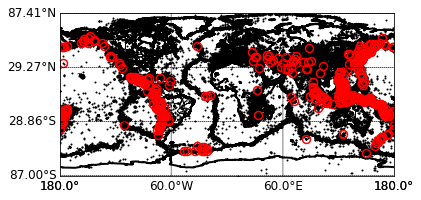

In [5]:
m = Basemap( llcrnrlat  =  ymin,urcrnrlat  =  ymax,
             llcrnrlon  =  xmin,urcrnrlon  =  xmax,
             projection = projection,lat_0=(ymin+ymax)*.5,lon_0=(xmin+xmax)*.5,
             resolution = 'l')
m.drawstates( linewidth = 1)
m.drawcoastlines( linewidth= 2)
a_x, a_y = m( eqCat.data['Lon'], eqCat.data['Lat'])
m.plot( a_x, a_y, 'ko', ms = 1)
sel7 = eqCat.data['Mag'] >=7
m.plot( a_x[sel7], a_y[sel7], 'ro', ms = 8, mew= 1.5, mfc = 'none')


m.drawmeridians( np.linspace( int(xmin), xmax, 4),labels=[False,False,False,True],
                 fontsize = 12, fmt = '%.1f')
m.drawparallels( np.linspace( int(ymin), ymax, 4),labels=[True,False,False,False],
                 fontsize = 12, fmt = '%.2f')

plt.savefig( file_in.replace( 'mat', 'png'))
plt.show()

The abover figure shows the map of seismicity. Earthquakes with magnitude exceeding $M_W7$ are indicated in red circles.

## 4) Determine $\eta_0$:   

(**time intensive** - optional for quick analysis)

1. shuffle event magnitudes and times
1. computer NND values for all event pairs
1. use 1st percentile as estimate for $\eta_0$. Note that $\eta_0$ is required to separate clustered and background events in the following analyses steps
1. eta_0 is saved in /data directory, file_out = [file_in]_Mc_[mc]_eta_0.txt
       
Note that this step is very time instensive. If the user wishes to get quick and dirty results. We recommend on of the following:

1. Run the analysis on a smaller part of the catalog (e.g. higher completeness) by changing the first box which sets "dPar"
1. Skip this step and specifiy a reasonable value for $\eta_0$ in dPar. A reasonable value ensure a proper separation of the two modes of seismicity (background and clustered). 

**IMPORTANT**: The code currently uses the default value specified in dPar if there is no ascii file eta_0.txt that specied the value calculated in this step.
       

In [6]:
if dPar['eta_0'] == None:

    eqCat   = EqCat( ) # original cat
    ranCat  = EqCat()  # randomized, Poissonian catalog
    eqCatMc = EqCat()  # catalog above completeness
    np.random.seed( 123456)

    # eqCat.loadMatBin(  os.path.join( dir_in, file_in))
    # print( 'total no. of events', eqCat.size())
    # eqCat.selectEvents( dPar['aMc'][0], None, 'Mag')
    # #eqCat.selectEvents( tmin, tmax, 'Time')
    # print( 'no. of events after initial selection', eqCat.size())

    # project to equi-distant coordiante system for cartesian distances
    eqCat.toCart_coordinates( projection = 'aeqd')
    for f_Mc in dPar['aMc']:
        print( '-------------- current Mc:', f_Mc, '---------------------')
        # select magnitude range
        eqCatMc.copy( eqCat)
        eqCatMc.selectEvents( f_Mc, None, 'Mag')
        print( 'catalog size after MAG selection', eqCat.size())
        # this dictionary is used in module: clustering
        dConst = {'Mc' : f_Mc,
                   'b' : dPar['b'],
                   'D' : dPar['D']}

        #=============================2===================================================
        #                    randomize catalog
        #=================================================================================
        a_Eta_0 = np.zeros( dPar['nBoot'])
        for i_Bs in xrange( dPar['nBoot']):

            ranCat.copy( eqCatMc)
            ranCat.data['X']     = np.random.uniform( eqCatMc.data['X'].min(), eqCatMc.data['X'].max(), size = eqCatMc.size())
            ranCat.data['Y']     = np.random.uniform( eqCatMc.data['Y'].min(), eqCatMc.data['Y'].max(), size = eqCatMc.size())
            ranCat.data['Time']  = clustering.rand_rate_uni( eqCatMc.size(), eqCatMc.data['Time'].min(), eqCatMc.data['Time'].max())
            ranCat.sortCatalog( 'Time')
            #==================================3=============================================
            #                   compute space-time-magnitude distance, histogram
            #================================================================================
            dNND = clustering.NND_eta( ranCat, dConst,  M0 = 0,   correct_co_located = True,
                                       verbose = False)
            sel = dNND['aNND'] < 0
            a_Eta_0[i_Bs] = round( np.percentile( np.log10(dNND['aNND']), 1), 5)
            print( 'nBoot', i_Bs+1,'out of', dPar['nBoot'], 'eta 0 - 1st', np.percentile( np.log10(dNND['aNND']), 1))
            if dPar['showPlot'] == True: # plots to check if everything is working
                #=================================4==============================================
                #                          plot NND histogram
                #================================================================================
                plt.figure( 1, figsize = (10,5))
                ax = plt.axes( [.12, .12, .83, .83])
                ax.hist( np.log10( dNND['aNND']), np.arange( dPar['xmin'], dPar['xmax'], dPar['eta_binsize']),
                                color = '.5', label = 'Mc = %.1f'%( f_Mc), align = 'mid', rwidth=.9)
                ax.plot( [-5, -5], ax.get_ylim(), 'w-',  lw = 2, )
                ax.plot( [-5, -5], ax.get_ylim(), 'k--', lw = 2, )
                ax.plot( [a_Eta_0[i_Bs], a_Eta_0[i_Bs]], ax.get_ylim(), 'w-',  lw = 2, label = '$N_\mathrm{tot}$=%i'%( ranCat.size()))
                ax.plot( [a_Eta_0[i_Bs], a_Eta_0[i_Bs]], ax.get_ylim(), 'r--', lw = 2, label = '$N_\mathrm{cl}$=%i'%( dNND['aNND'][dNND['aNND']<1e-5].shape[0]))

                ax.legend( loc = 'upper left')
                ax.set_xlabel( 'NND, log$_{10} \eta$')
                ax.set_ylabel( 'Number of Events')
                ax.grid( 'on')
                ax.set_xlim( dPar['xmin'], dPar['xmax'])


                #==================================4==============================================================
                #                           T-R density plot
                #=================================================================================================
                catChild = EqCat()
                catParent= EqCat()
                catChild.copy(  ranCat)
                catParent.copy( ranCat)

                catChild.selEventsFromID(    dNND['aEqID_c'], repeats = True)
                catParent.selEventsFromID(   dNND['aEqID_p'], repeats = True)
                print( catChild.size(), catParent.size(), eqCatMc.size())
                a_R, a_T = clustering.rescaled_t_r( catChild, catParent, dConst, correct_co_located = True)

                a_Tbin = np.arange( dPar['Tmin'], dPar['Tmax']+2*dPar['binx'], dPar['binx'])
                a_Rbin = np.arange( dPar['Rmin'], dPar['Rmax']+2*dPar['biny'], dPar['biny'])
                a_log_T = np.log10( a_T)
                a_log_R = np.log10( a_R)
                XX, YY, ZZ = data_utils.density_2D( a_log_T, a_log_R, a_Tbin, a_Rbin, sigma = dPar['sigma'])

                plt.figure(2, figsize= (8,10))
                ax = plt.subplot(111)
                ax.set_title( 'Nearest Neighbor Pairs in R-T')
                #------------------------------------------------------------------------------
                normZZ = ZZ*( dPar['binx']*dPar['biny']*eqCatMc.size())
                plot1 = ax.pcolormesh( XX, YY, normZZ, cmap=dPar['cmap'])
                cbar  = plt.colorbar(plot1, orientation = 'horizontal', shrink = .5, aspect = 20,)
                #ax.plot(  np.log10( a_T), np.log10( a_R), 'wo', ms = 1.5, alpha = .2)
                # plot eta_0 to divide clustered and background mode
                ax.plot( [dPar['Tmin'], dPar['Tmax']],  -np.array([dPar['Tmin'], dPar['Tmax']])+a_Eta_0[i_Bs], '-', lw = 1.5, color = 'w' )
                ax.plot( [dPar['Tmin'], dPar['Tmax']],  -np.array([dPar['Tmin'], dPar['Tmax']])+a_Eta_0[i_Bs],'--', lw = 1.5, color = '.5' )
                #-----------------------labels and legends-------------------------------------------------------
                #cbar.set_label( 'Event Pair Density [#ev./dRdT]')
                cbar.set_label( 'Number of Event Pairs',labelpad=-40)
                ax.set_xlabel( 'Rescaled Time')
                ax.set_ylabel( 'Rescaled Distance')
                ax.set_xlim( dPar['Tmin'], dPar['Tmax'])
                ax.set_ylim( dPar['Rmin'], dPar['Rmax'])

In [7]:
if dPar['eta_0'] == None:

    eqCat   = EqCat( ) # original cat
    ranCat  = EqCat()  # randomized, Poissonian catalog
    eqCatMc = EqCat()  # catalog above completeness
    np.random.seed( 123456)

    # eqCat.loadMatBin(  os.path.join( dir_in, file_in))
    # print( 'total no. of events', eqCat.size())
    # eqCat.selectEvents( dPar['aMc'][0], None, 'Mag')
    # #eqCat.selectEvents( tmin, tmax, 'Time')
    # print( 'no. of events after initial selection', eqCat.size())

    # project to equi-distant coordiante system for cartesian distances
    eqCat.toCart_coordinates( projection = 'aeqd')
    for f_Mc in dPar['aMc']:
        print( '-------------- current Mc:', f_Mc, '---------------------')
        # select magnitude range
        eqCatMc.copy( eqCat)
        eqCatMc.selectEvents( f_Mc, None, 'Mag')
        print( 'catalog size after MAG selection', eqCat.size())
        # this dictionary is used in module: clustering
        dConst = {'Mc' : f_Mc,
                   'b' : dPar['b'],
                   'D' : dPar['D']}

        #=============================2===================================================
        #                    randomize catalog
        #=================================================================================
        a_Eta_0 = np.zeros( dPar['nBoot'])
        for i_Bs in xrange( dPar['nBoot']):

            ranCat.copy( eqCatMc)
            ranCat.data['X']     = np.random.uniform( eqCatMc.data['X'].min(), eqCatMc.data['X'].max(), size = eqCatMc.size())
            ranCat.data['Y']     = np.random.uniform( eqCatMc.data['Y'].min(), eqCatMc.data['Y'].max(), size = eqCatMc.size())
            ranCat.data['Time']  = clustering.rand_rate_uni( eqCatMc.size(), eqCatMc.data['Time'].min(), eqCatMc.data['Time'].max())
            ranCat.sortCatalog( 'Time')
            #==================================3=============================================
            #                   compute space-time-magnitude distance, histogram
            #================================================================================
            dNND = clustering.NND_eta( ranCat, dConst,  M0 = 0,   correct_co_located = True,
                                       verbose = False)
            sel = dNND['aNND'] < 0
            a_Eta_0[i_Bs] = round( np.percentile( np.log10(dNND['aNND']), 1), 5)
            print( 'nBoot', i_Bs+1,'out of', dPar['nBoot'], 'eta 0 - 1st', np.percentile( np.log10(dNND['aNND']), 1))
            if dPar['showPlot'] == True: # plots to check if everything is working
                #=================================4==============================================
                #                          plot NND histogram
                #================================================================================
                plt.figure( 1, figsize = (10,5))
                ax = plt.axes( [.12, .12, .83, .83])
                ax.hist( np.log10( dNND['aNND']), np.arange( dPar['xmin'], dPar['xmax'], dPar['eta_binsize']),
                                color = '.5', label = 'Mc = %.1f'%( f_Mc), align = 'mid', rwidth=.9)
                ax.plot( [-5, -5], ax.get_ylim(), 'w-',  lw = 2, )
                ax.plot( [-5, -5], ax.get_ylim(), 'k--', lw = 2, )
                ax.plot( [a_Eta_0[i_Bs], a_Eta_0[i_Bs]], ax.get_ylim(), 'w-',  lw = 2, label = '$N_\mathrm{tot}$=%i'%( ranCat.size()))
                ax.plot( [a_Eta_0[i_Bs], a_Eta_0[i_Bs]], ax.get_ylim(), 'r--', lw = 2, label = '$N_\mathrm{cl}$=%i'%( dNND['aNND'][dNND['aNND']<1e-5].shape[0]))

                ax.legend( loc = 'upper left')
                ax.set_xlabel( 'NND, log$_{10} \eta$')
                ax.set_ylabel( 'Number of Events')
                ax.grid( 'on')
                ax.set_xlim( dPar['xmin'], dPar['xmax'])


                #==================================4==============================================================
                #                           T-R density plot
                #=================================================================================================
                catChild = EqCat()
                catParent= EqCat()
                catChild.copy(  ranCat)
                catParent.copy( ranCat)

                catChild.selEventsFromID(    dNND['aEqID_c'], repeats = True)
                catParent.selEventsFromID(   dNND['aEqID_p'], repeats = True)
                print( catChild.size(), catParent.size(), eqCatMc.size())
                a_R, a_T = clustering.rescaled_t_r( catChild, catParent, dConst, correct_co_located = True)

                a_Tbin = np.arange( dPar['Tmin'], dPar['Tmax']+2*dPar['binx'], dPar['binx'])
                a_Rbin = np.arange( dPar['Rmin'], dPar['Rmax']+2*dPar['biny'], dPar['biny'])
                a_log_T = np.log10( a_T)
                a_log_R = np.log10( a_R)
                XX, YY, ZZ = data_utils.density_2D( a_log_T, a_log_R, a_Tbin, a_Rbin, sigma = dPar['sigma'])

                plt.figure(2, figsize= (8,10))
                ax = plt.subplot(111)
                ax.set_title( 'Nearest Neighbor Pairs in R-T')
                #------------------------------------------------------------------------------
                normZZ = ZZ*( dPar['binx']*dPar['biny']*eqCatMc.size())
                plot1 = ax.pcolormesh( XX, YY, normZZ, cmap=dPar['cmap'])
                cbar  = plt.colorbar(plot1, orientation = 'horizontal', shrink = .5, aspect = 20,)
                #ax.plot(  np.log10( a_T), np.log10( a_R), 'wo', ms = 1.5, alpha = .2)
                # plot eta_0 to divide clustered and background mode
                ax.plot( [dPar['Tmin'], dPar['Tmax']],  -np.array([dPar['Tmin'], dPar['Tmax']])+a_Eta_0[i_Bs], '-', lw = 1.5, color = 'w' )
                ax.plot( [dPar['Tmin'], dPar['Tmax']],  -np.array([dPar['Tmin'], dPar['Tmax']])+a_Eta_0[i_Bs],'--', lw = 1.5, color = '.5' )
                #-----------------------labels and legends-------------------------------------------------------
                #cbar.set_label( 'Event Pair Density [#ev./dRdT]')
                cbar.set_label( 'Number of Event Pairs',labelpad=-40)
                ax.set_xlabel( 'Rescaled Time')
                ax.set_ylabel( 'Rescaled Distance')
                ax.set_xlim( dPar['Tmin'], dPar['Tmax'])
                ax.set_ylim( dPar['Rmin'], dPar['Rmax'])

                plt.show()
        #=================================3==============================================
        #                            save results
        #================================================================================
        f_eta_0 = a_Eta_0.mean()
        print 'medium eta_0', a_Eta_0.mean()
        file_out = '%s/%s_Mc_%.1f_eta_0.txt'%(dir_in, file_in, f_Mc)
        np.savetxt( file_out, np.array([f_eta_0]), fmt = '%10.3f', header='eta_0')
        print 'save results', file_out
        scipy.io.savemat(file_out.replace('txt','mat'),
                         {'eta_0': f_eta_0, 'eta_BS' : a_Eta_0,}, do_compression=True)

## 5) (Key step) Calculate nearest space-time-magnitude ($\eta_{ij}$) distance: 

- compute nearest-neighbor distance (NND) between all event pairs (see equ. 1 in  Zaliapin & Ben-Zion, 2013)
- test -plot histogram of NNDs: Figure 4c in Zaliapin & Ben-Zion, 2013

This may take a some time depending on the size of the catalog (a couple of minutes for catalog of ~10^6 earthquakes

In [8]:
#=================================1==============================================
#                           to cartesian coordinates
#================================================================================
# two ways to do the distance comp: 1 project into equal distance azimuthal , comp Cartersian distance in 3D
#                                   2 get surface distance from lon, lat (haversine), use pythagoras to include depth
eqCat.toCart_coordinates( projection = 'aeqd')

for f_Mc in dPar['aMc']:
    print( '-------------- current Mc:', f_Mc, '---------------------')
    # select magnitude range
    eqCat.selectEvents( f_Mc, None, 'Mag')
    print( 'catalog size after MAG selection', eqCat.size())
    # this dictionary is used in module: clustering
    dConst = {'Mc' : f_Mc,
               'b' : dPar['b'],
               'D' : dPar['D']}
    #==================================2=============================================
    #                       compute space-time-magnitude distance, histogram
    #================================================================================  
    dCluster = clustering.NND_eta( eqCat, dConst,    correct_co_located = True, verbose= True)
    ###histogram
    aBins       = np.arange( -13, 1, dPar['eta_binsize'])
    aHist, aBins = np.histogram( np.log10( dCluster['aNND'][dCluster['aNND']>0]), aBins)
    aHist, aBins = np.array(zip(*zip(aHist, aBins)))# cut to same length
    # correct for binsize
    aHist /= dPar['eta_binsize']
    # to pdf (prob. density)
    aHist /= eqCat.size()
    
    #=================================3==============================================
    #                            save results
    #================================================================================
    NND_file = os.path.join(dir_in,'%s_NND_Mc_%.1f.mat'%( file_in.split('.')[0], f_Mc))
    print( 'save file', NND_file)
    scipy.io.savemat( NND_file, dCluster, do_compression  = True)
    
    

('-------------- current Mc:', 4.5, '---------------------')
('catalog size after MAG selection', 231310)
event 1 of 231310
event 2 of 231310
event 3 of 231310
event 4 of 231310
event 5 of 231310
event 6 of 231310
event 7 of 231310
event 8 of 231310
event 9 of 231310
event 10 of 231310
event 11 of 231310
event 12 of 231310
event 13 of 231310
event 14 of 231310
event 15 of 231310
event 16 of 231310
event 17 of 231310
event 18 of 231310
event 19 of 231310
event 20 of 231310
event 21 of 231310
event 22 of 231310
event 23 of 231310
event 24 of 231310
event 25 of 231310
event 26 of 231310
event 27 of 231310
event 28 of 231310
event 29 of 231310
event 30 of 231310
event 31 of 231310
event 32 of 231310
event 33 of 231310
event 34 of 231310
event 35 of 231310
event 36 of 231310
event 37 of 231310
event 38 of 231310
event 39 of 231310
event 40 of 231310
event 41 of 231310
event 42 of 231310
event 43 of 231310
event 44 of 231310
event 45 of 231310
event 46 of 231310
event 47 of 231310
event 48 o

event 451 of 231310
event 452 of 231310
event 453 of 231310
event 454 of 231310
event 455 of 231310
event 456 of 231310
event 457 of 231310
event 458 of 231310
event 459 of 231310
event 460 of 231310
event 461 of 231310
event 462 of 231310
event 463 of 231310
event 464 of 231310
event 465 of 231310
event 466 of 231310
event 467 of 231310
event 468 of 231310
event 469 of 231310
event 470 of 231310
event 471 of 231310
event 472 of 231310
event 473 of 231310
event 474 of 231310
event 475 of 231310
event 476 of 231310
event 477 of 231310
event 478 of 231310
event 479 of 231310
event 480 of 231310
event 481 of 231310
event 482 of 231310
event 483 of 231310
event 484 of 231310
event 485 of 231310
event 486 of 231310
event 487 of 231310
event 488 of 231310
event 489 of 231310
event 490 of 231310
event 491 of 231310
event 492 of 231310
event 493 of 231310
event 494 of 231310
event 495 of 231310
event 496 of 231310
event 497 of 231310
event 498 of 231310
event 499 of 231310
event 500 of 231310


event 863 of 231310
event 864 of 231310
event 865 of 231310
event 866 of 231310
event 867 of 231310
event 868 of 231310
event 869 of 231310
event 870 of 231310
event 871 of 231310
event 872 of 231310
event 873 of 231310
event 874 of 231310
event 875 of 231310
event 876 of 231310
event 877 of 231310
event 878 of 231310
event 879 of 231310
event 880 of 231310
event 881 of 231310
event 882 of 231310
event 883 of 231310
event 884 of 231310
event 885 of 231310
event 886 of 231310
event 887 of 231310
event 888 of 231310
event 889 of 231310
event 890 of 231310
event 891 of 231310
event 892 of 231310
event 893 of 231310
event 894 of 231310
event 895 of 231310
event 896 of 231310
event 897 of 231310
event 898 of 231310
event 899 of 231310
event 900 of 231310
event 901 of 231310
event 902 of 231310
event 903 of 231310
event 904 of 231310
event 905 of 231310
event 906 of 231310
event 907 of 231310
event 908 of 231310
event 909 of 231310
event 910 of 231310
event 911 of 231310
event 912 of 231310


event 1314 of 231310
event 1315 of 231310
event 1316 of 231310
event 1317 of 231310
event 1318 of 231310
event 1319 of 231310
event 1320 of 231310
event 1321 of 231310
event 1322 of 231310
event 1323 of 231310
event 1324 of 231310
event 1325 of 231310
event 1326 of 231310
event 1327 of 231310
event 1328 of 231310
event 1329 of 231310
event 1330 of 231310
event 1331 of 231310
event 1332 of 231310
event 1333 of 231310
event 1334 of 231310
event 1335 of 231310
event 1336 of 231310
event 1337 of 231310
event 1338 of 231310
event 1339 of 231310
event 1340 of 231310
event 1341 of 231310
event 1342 of 231310
event 1343 of 231310
event 1344 of 231310
event 1345 of 231310
event 1346 of 231310
event 1347 of 231310
event 1348 of 231310
event 1349 of 231310
event 1350 of 231310
event 1351 of 231310
event 1352 of 231310
event 1353 of 231310
event 1354 of 231310
event 1355 of 231310
event 1356 of 231310
event 1357 of 231310
event 1358 of 231310
event 1359 of 231310
event 1360 of 231310
event 1361 of

event 1768 of 231310
event 1769 of 231310
event 1770 of 231310
event 1771 of 231310
event 1772 of 231310
event 1773 of 231310
event 1774 of 231310
event 1775 of 231310
event 1776 of 231310
event 1777 of 231310
event 1778 of 231310
event 1779 of 231310
event 1780 of 231310
event 1781 of 231310
event 1782 of 231310
event 1783 of 231310
event 1784 of 231310
event 1785 of 231310
event 1786 of 231310
event 1787 of 231310
event 1788 of 231310
event 1789 of 231310
event 1790 of 231310
event 1791 of 231310
event 1792 of 231310
event 1793 of 231310
event 1794 of 231310
event 1795 of 231310
event 1796 of 231310
event 1797 of 231310
event 1798 of 231310
event 1799 of 231310
event 1800 of 231310
event 1801 of 231310
event 1802 of 231310
event 1803 of 231310
event 1804 of 231310
event 1805 of 231310
event 1806 of 231310
event 1807 of 231310
event 1808 of 231310
event 1809 of 231310
event 1810 of 231310
event 1811 of 231310
event 1812 of 231310
event 1813 of 231310
event 1814 of 231310
event 1815 of

event 2189 of 231310
event 2190 of 231310
event 2191 of 231310
event 2192 of 231310
event 2193 of 231310
event 2194 of 231310
event 2195 of 231310
event 2196 of 231310
event 2197 of 231310
event 2198 of 231310
event 2199 of 231310
event 2200 of 231310
event 2201 of 231310
event 2202 of 231310
event 2203 of 231310
event 2204 of 231310
event 2205 of 231310
event 2206 of 231310
event 2207 of 231310
event 2208 of 231310
event 2209 of 231310
event 2210 of 231310
event 2211 of 231310
event 2212 of 231310
event 2213 of 231310
event 2214 of 231310
event 2215 of 231310
event 2216 of 231310
event 2217 of 231310
event 2218 of 231310
event 2219 of 231310
event 2220 of 231310
event 2221 of 231310
event 2222 of 231310
event 2223 of 231310
event 2224 of 231310
event 2225 of 231310
event 2226 of 231310
event 2227 of 231310
event 2228 of 231310
event 2229 of 231310
event 2230 of 231310
event 2231 of 231310
event 2232 of 231310
event 2233 of 231310
event 2234 of 231310
event 2235 of 231310
event 2236 of

event 2625 of 231310
event 2626 of 231310
event 2627 of 231310
event 2628 of 231310
event 2629 of 231310
event 2630 of 231310
event 2631 of 231310
event 2632 of 231310
event 2633 of 231310
event 2634 of 231310
event 2635 of 231310
event 2636 of 231310
event 2637 of 231310
event 2638 of 231310
event 2639 of 231310
event 2640 of 231310
event 2641 of 231310
event 2642 of 231310
event 2643 of 231310
event 2644 of 231310
event 2645 of 231310
event 2646 of 231310
event 2647 of 231310
event 2648 of 231310
event 2649 of 231310
event 2650 of 231310
event 2651 of 231310
event 2652 of 231310
event 2653 of 231310
event 2654 of 231310
event 2655 of 231310
event 2656 of 231310
event 2657 of 231310
event 2658 of 231310
event 2659 of 231310
event 2660 of 231310
event 2661 of 231310
event 2662 of 231310
event 2663 of 231310
event 2664 of 231310
event 2665 of 231310
event 2666 of 231310
event 2667 of 231310
event 2668 of 231310
event 2669 of 231310
event 2670 of 231310
event 2671 of 231310
event 2672 of

event 3065 of 231310
event 3066 of 231310
event 3067 of 231310
event 3068 of 231310
event 3069 of 231310
event 3070 of 231310
event 3071 of 231310
event 3072 of 231310
event 3073 of 231310
event 3074 of 231310
event 3075 of 231310
event 3076 of 231310
event 3077 of 231310
event 3078 of 231310
event 3079 of 231310
event 3080 of 231310
event 3081 of 231310
event 3082 of 231310
event 3083 of 231310
event 3084 of 231310
event 3085 of 231310
event 3086 of 231310
event 3087 of 231310
event 3088 of 231310
event 3089 of 231310
event 3090 of 231310
event 3091 of 231310
event 3092 of 231310
event 3093 of 231310
event 3094 of 231310
event 3095 of 231310
event 3096 of 231310
event 3097 of 231310
event 3098 of 231310
event 3099 of 231310
event 3100 of 231310
event 3101 of 231310
event 3102 of 231310
event 3103 of 231310
event 3104 of 231310
event 3105 of 231310
event 3106 of 231310
event 3107 of 231310
event 3108 of 231310
event 3109 of 231310
event 3110 of 231310
event 3111 of 231310
event 3112 of

event 3494 of 231310
event 3495 of 231310
event 3496 of 231310
event 3497 of 231310
event 3498 of 231310
event 3499 of 231310
event 3500 of 231310
event 3501 of 231310
event 3502 of 231310
event 3503 of 231310
event 3504 of 231310
event 3505 of 231310
event 3506 of 231310
event 3507 of 231310
event 3508 of 231310
event 3509 of 231310
event 3510 of 231310
event 3511 of 231310
event 3512 of 231310
event 3513 of 231310
event 3514 of 231310
event 3515 of 231310
event 3516 of 231310
event 3517 of 231310
event 3518 of 231310
event 3519 of 231310
event 3520 of 231310
event 3521 of 231310
event 3522 of 231310
event 3523 of 231310
event 3524 of 231310
event 3525 of 231310
event 3526 of 231310
event 3527 of 231310
event 3528 of 231310
event 3529 of 231310
event 3530 of 231310
event 3531 of 231310
event 3532 of 231310
event 3533 of 231310
event 3534 of 231310
event 3535 of 231310
event 3536 of 231310
event 3537 of 231310
event 3538 of 231310
event 3539 of 231310
event 3540 of 231310
event 3541 of

event 3898 of 231310
event 3899 of 231310
event 3900 of 231310
event 3901 of 231310
event 3902 of 231310
event 3903 of 231310
event 3904 of 231310
event 3905 of 231310
event 3906 of 231310
event 3907 of 231310
event 3908 of 231310
event 3909 of 231310
event 3910 of 231310
event 3911 of 231310
event 3912 of 231310
event 3913 of 231310
event 3914 of 231310
event 3915 of 231310
event 3916 of 231310
event 3917 of 231310
event 3918 of 231310
event 3919 of 231310
event 3920 of 231310
event 3921 of 231310
event 3922 of 231310
event 3923 of 231310
event 3924 of 231310
event 3925 of 231310
event 3926 of 231310
event 3927 of 231310
event 3928 of 231310
event 3929 of 231310
event 3930 of 231310
event 3931 of 231310
event 3932 of 231310
event 3933 of 231310
event 3934 of 231310
event 3935 of 231310
event 3936 of 231310
event 3937 of 231310
event 3938 of 231310
event 3939 of 231310
event 3940 of 231310
event 3941 of 231310
event 3942 of 231310
event 3943 of 231310
event 3944 of 231310
event 3945 of

event 4289 of 231310
event 4290 of 231310
event 4291 of 231310
event 4292 of 231310
event 4293 of 231310
event 4294 of 231310
event 4295 of 231310
event 4296 of 231310
event 4297 of 231310
event 4298 of 231310
event 4299 of 231310
event 4300 of 231310
event 4301 of 231310
event 4302 of 231310
event 4303 of 231310
event 4304 of 231310
event 4305 of 231310
event 4306 of 231310
event 4307 of 231310
event 4308 of 231310
event 4309 of 231310
event 4310 of 231310
event 4311 of 231310
event 4312 of 231310
event 4313 of 231310
event 4314 of 231310
event 4315 of 231310
event 4316 of 231310
event 4317 of 231310
event 4318 of 231310
event 4319 of 231310
event 4320 of 231310
event 4321 of 231310
event 4322 of 231310
event 4323 of 231310
event 4324 of 231310
event 4325 of 231310
event 4326 of 231310
event 4327 of 231310
event 4328 of 231310
event 4329 of 231310
event 4330 of 231310
event 4331 of 231310
event 4332 of 231310
event 4333 of 231310
event 4334 of 231310
event 4335 of 231310
event 4336 of

event 4698 of 231310
event 4699 of 231310
event 4700 of 231310
event 4701 of 231310
event 4702 of 231310
event 4703 of 231310
event 4704 of 231310
event 4705 of 231310
event 4706 of 231310
event 4707 of 231310
event 4708 of 231310
event 4709 of 231310
event 4710 of 231310
event 4711 of 231310
event 4712 of 231310
event 4713 of 231310
event 4714 of 231310
event 4715 of 231310
event 4716 of 231310
event 4717 of 231310
event 4718 of 231310
event 4719 of 231310
event 4720 of 231310
event 4721 of 231310
event 4722 of 231310
event 4723 of 231310
event 4724 of 231310
event 4725 of 231310
event 4726 of 231310
event 4727 of 231310
event 4728 of 231310
event 4729 of 231310
event 4730 of 231310
event 4731 of 231310
event 4732 of 231310
event 4733 of 231310
event 4734 of 231310
event 4735 of 231310
event 4736 of 231310
event 4737 of 231310
event 4738 of 231310
event 4739 of 231310
event 4740 of 231310
event 4741 of 231310
event 4742 of 231310
event 4743 of 231310
event 4744 of 231310
event 4745 of

event 5096 of 231310
event 5097 of 231310
event 5098 of 231310
event 5099 of 231310
event 5100 of 231310
event 5101 of 231310
event 5102 of 231310
event 5103 of 231310
event 5104 of 231310
event 5105 of 231310
event 5106 of 231310
event 5107 of 231310
event 5108 of 231310
event 5109 of 231310
event 5110 of 231310
event 5111 of 231310
event 5112 of 231310
event 5113 of 231310
event 5114 of 231310
event 5115 of 231310
event 5116 of 231310
event 5117 of 231310
event 5118 of 231310
event 5119 of 231310
event 5120 of 231310
event 5121 of 231310
event 5122 of 231310
event 5123 of 231310
event 5124 of 231310
event 5125 of 231310
event 5126 of 231310
event 5127 of 231310
event 5128 of 231310
event 5129 of 231310
event 5130 of 231310
event 5131 of 231310
event 5132 of 231310
event 5133 of 231310
event 5134 of 231310
event 5135 of 231310
event 5136 of 231310
event 5137 of 231310
event 5138 of 231310
event 5139 of 231310
event 5140 of 231310
event 5141 of 231310
event 5142 of 231310
event 5143 of

event 5494 of 231310
event 5495 of 231310
event 5496 of 231310
event 5497 of 231310
event 5498 of 231310
event 5499 of 231310
event 5500 of 231310
event 5501 of 231310
event 5502 of 231310
event 5503 of 231310
event 5504 of 231310
event 5505 of 231310
event 5506 of 231310
event 5507 of 231310
event 5508 of 231310
event 5509 of 231310
event 5510 of 231310
event 5511 of 231310
event 5512 of 231310
event 5513 of 231310
event 5514 of 231310
event 5515 of 231310
event 5516 of 231310
event 5517 of 231310
event 5518 of 231310
event 5519 of 231310
event 5520 of 231310
event 5521 of 231310
event 5522 of 231310
event 5523 of 231310
event 5524 of 231310
event 5525 of 231310
event 5526 of 231310
event 5527 of 231310
event 5528 of 231310
event 5529 of 231310
event 5530 of 231310
event 5531 of 231310
event 5532 of 231310
event 5533 of 231310
event 5534 of 231310
event 5535 of 231310
event 5536 of 231310
event 5537 of 231310
event 5538 of 231310
event 5539 of 231310
event 5540 of 231310
event 5541 of

event 5885 of 231310
event 5886 of 231310
event 5887 of 231310
event 5888 of 231310
event 5889 of 231310
event 5890 of 231310
event 5891 of 231310
event 5892 of 231310
event 5893 of 231310
event 5894 of 231310
event 5895 of 231310
event 5896 of 231310
event 5897 of 231310
event 5898 of 231310
event 5899 of 231310
event 5900 of 231310
event 5901 of 231310
event 5902 of 231310
event 5903 of 231310
event 5904 of 231310
event 5905 of 231310
event 5906 of 231310
event 5907 of 231310
event 5908 of 231310
event 5909 of 231310
event 5910 of 231310
event 5911 of 231310
event 5912 of 231310
event 5913 of 231310
event 5914 of 231310
event 5915 of 231310
event 5916 of 231310
event 5917 of 231310
event 5918 of 231310
event 5919 of 231310
event 5920 of 231310
event 5921 of 231310
event 5922 of 231310
event 5923 of 231310
event 5924 of 231310
event 5925 of 231310
event 5926 of 231310
event 5927 of 231310
event 5928 of 231310
event 5929 of 231310
event 5930 of 231310
event 5931 of 231310
event 5932 of

event 6301 of 231310
event 6302 of 231310
event 6303 of 231310
event 6304 of 231310
event 6305 of 231310
event 6306 of 231310
event 6307 of 231310
event 6308 of 231310
event 6309 of 231310
event 6310 of 231310
event 6311 of 231310
event 6312 of 231310
event 6313 of 231310
event 6314 of 231310
event 6315 of 231310
event 6316 of 231310
event 6317 of 231310
event 6318 of 231310
event 6319 of 231310
event 6320 of 231310
event 6321 of 231310
event 6322 of 231310
event 6323 of 231310
event 6324 of 231310
event 6325 of 231310
event 6326 of 231310
event 6327 of 231310
event 6328 of 231310
event 6329 of 231310
event 6330 of 231310
event 6331 of 231310
event 6332 of 231310
event 6333 of 231310
event 6334 of 231310
event 6335 of 231310
event 6336 of 231310
event 6337 of 231310
event 6338 of 231310
event 6339 of 231310
event 6340 of 231310
event 6341 of 231310
event 6342 of 231310
event 6343 of 231310
event 6344 of 231310
event 6345 of 231310
event 6346 of 231310
event 6347 of 231310
event 6348 of

event 6711 of 231310
event 6712 of 231310
event 6713 of 231310
event 6714 of 231310
event 6715 of 231310
event 6716 of 231310
event 6717 of 231310
event 6718 of 231310
event 6719 of 231310
event 6720 of 231310
event 6721 of 231310
event 6722 of 231310
event 6723 of 231310
event 6724 of 231310
event 6725 of 231310
event 6726 of 231310
event 6727 of 231310
event 6728 of 231310
event 6729 of 231310
event 6730 of 231310
event 6731 of 231310
event 6732 of 231310
event 6733 of 231310
event 6734 of 231310
event 6735 of 231310
event 6736 of 231310
event 6737 of 231310
event 6738 of 231310
event 6739 of 231310
event 6740 of 231310
event 6741 of 231310
event 6742 of 231310
event 6743 of 231310
event 6744 of 231310
event 6745 of 231310
event 6746 of 231310
event 6747 of 231310
event 6748 of 231310
event 6749 of 231310
event 6750 of 231310
event 6751 of 231310
event 6752 of 231310
event 6753 of 231310
event 6754 of 231310
event 6755 of 231310
event 6756 of 231310
event 6757 of 231310
event 6758 of

event 7115 of 231310
event 7116 of 231310
event 7117 of 231310
event 7118 of 231310
event 7119 of 231310
event 7120 of 231310
event 7121 of 231310
event 7122 of 231310
event 7123 of 231310
event 7124 of 231310
event 7125 of 231310
event 7126 of 231310
event 7127 of 231310
event 7128 of 231310
event 7129 of 231310
event 7130 of 231310
event 7131 of 231310
event 7132 of 231310
event 7133 of 231310
event 7134 of 231310
event 7135 of 231310
event 7136 of 231310
event 7137 of 231310
event 7138 of 231310
event 7139 of 231310
event 7140 of 231310
event 7141 of 231310
event 7142 of 231310
event 7143 of 231310
event 7144 of 231310
event 7145 of 231310
event 7146 of 231310
event 7147 of 231310
event 7148 of 231310
event 7149 of 231310
event 7150 of 231310
event 7151 of 231310
event 7152 of 231310
event 7153 of 231310
event 7154 of 231310
event 7155 of 231310
event 7156 of 231310
event 7157 of 231310
event 7158 of 231310
event 7159 of 231310
event 7160 of 231310
event 7161 of 231310
event 7162 of

event 7531 of 231310
event 7532 of 231310
event 7533 of 231310
event 7534 of 231310
event 7535 of 231310
event 7536 of 231310
event 7537 of 231310
event 7538 of 231310
event 7539 of 231310
event 7540 of 231310
event 7541 of 231310
event 7542 of 231310
event 7543 of 231310
event 7544 of 231310
event 7545 of 231310
event 7546 of 231310
event 7547 of 231310
event 7548 of 231310
event 7549 of 231310
event 7550 of 231310
event 7551 of 231310
event 7552 of 231310
event 7553 of 231310
event 7554 of 231310
event 7555 of 231310
event 7556 of 231310
event 7557 of 231310
event 7558 of 231310
event 7559 of 231310
event 7560 of 231310
event 7561 of 231310
event 7562 of 231310
event 7563 of 231310
event 7564 of 231310
event 7565 of 231310
event 7566 of 231310
event 7567 of 231310
event 7568 of 231310
event 7569 of 231310
event 7570 of 231310
event 7571 of 231310
event 7572 of 231310
event 7573 of 231310
event 7574 of 231310
event 7575 of 231310
event 7576 of 231310
event 7577 of 231310
event 7578 of

event 7945 of 231310
event 7946 of 231310
event 7947 of 231310
event 7948 of 231310
event 7949 of 231310
event 7950 of 231310
event 7951 of 231310
event 7952 of 231310
event 7953 of 231310
event 7954 of 231310
event 7955 of 231310
event 7956 of 231310
event 7957 of 231310
event 7958 of 231310
event 7959 of 231310
event 7960 of 231310
event 7961 of 231310
event 7962 of 231310
event 7963 of 231310
event 7964 of 231310
event 7965 of 231310
event 7966 of 231310
event 7967 of 231310
event 7968 of 231310
event 7969 of 231310
event 7970 of 231310
event 7971 of 231310
event 7972 of 231310
event 7973 of 231310
event 7974 of 231310
event 7975 of 231310
event 7976 of 231310
event 7977 of 231310
event 7978 of 231310
event 7979 of 231310
event 7980 of 231310
event 7981 of 231310
event 7982 of 231310
event 7983 of 231310
event 7984 of 231310
event 7985 of 231310
event 7986 of 231310
event 7987 of 231310
event 7988 of 231310
event 7989 of 231310
event 7990 of 231310
event 7991 of 231310
event 7992 of

event 8354 of 231310
event 8355 of 231310
event 8356 of 231310
event 8357 of 231310
event 8358 of 231310
event 8359 of 231310
event 8360 of 231310
event 8361 of 231310
event 8362 of 231310
event 8363 of 231310
event 8364 of 231310
event 8365 of 231310
event 8366 of 231310
event 8367 of 231310
event 8368 of 231310
event 8369 of 231310
event 8370 of 231310
event 8371 of 231310
event 8372 of 231310
event 8373 of 231310
event 8374 of 231310
event 8375 of 231310
event 8376 of 231310
event 8377 of 231310
event 8378 of 231310
event 8379 of 231310
event 8380 of 231310
event 8381 of 231310
event 8382 of 231310
event 8383 of 231310
event 8384 of 231310
event 8385 of 231310
event 8386 of 231310
event 8387 of 231310
event 8388 of 231310
event 8389 of 231310
event 8390 of 231310
event 8391 of 231310
event 8392 of 231310
event 8393 of 231310
event 8394 of 231310
event 8395 of 231310
event 8396 of 231310
event 8397 of 231310
event 8398 of 231310
event 8399 of 231310
event 8400 of 231310
event 8401 of

event 8762 of 231310
event 8763 of 231310
event 8764 of 231310
event 8765 of 231310
event 8766 of 231310
event 8767 of 231310
event 8768 of 231310
event 8769 of 231310
event 8770 of 231310
event 8771 of 231310
event 8772 of 231310
event 8773 of 231310
event 8774 of 231310
event 8775 of 231310
event 8776 of 231310
event 8777 of 231310
event 8778 of 231310
event 8779 of 231310
event 8780 of 231310
event 8781 of 231310
event 8782 of 231310
event 8783 of 231310
event 8784 of 231310
event 8785 of 231310
event 8786 of 231310
event 8787 of 231310
event 8788 of 231310
event 8789 of 231310
event 8790 of 231310
event 8791 of 231310
event 8792 of 231310
event 8793 of 231310
event 8794 of 231310
event 8795 of 231310
event 8796 of 231310
event 8797 of 231310
event 8798 of 231310
event 8799 of 231310
event 8800 of 231310
event 8801 of 231310
event 8802 of 231310
event 8803 of 231310
event 8804 of 231310
event 8805 of 231310
event 8806 of 231310
event 8807 of 231310
event 8808 of 231310
event 8809 of

event 9171 of 231310
event 9172 of 231310
event 9173 of 231310
event 9174 of 231310
event 9175 of 231310
event 9176 of 231310
event 9177 of 231310
event 9178 of 231310
event 9179 of 231310
event 9180 of 231310
event 9181 of 231310
event 9182 of 231310
event 9183 of 231310
event 9184 of 231310
event 9185 of 231310
event 9186 of 231310
event 9187 of 231310
event 9188 of 231310
event 9189 of 231310
event 9190 of 231310
event 9191 of 231310
event 9192 of 231310
event 9193 of 231310
event 9194 of 231310
event 9195 of 231310
event 9196 of 231310
event 9197 of 231310
event 9198 of 231310
event 9199 of 231310
event 9200 of 231310
event 9201 of 231310
event 9202 of 231310
event 9203 of 231310
event 9204 of 231310
event 9205 of 231310
event 9206 of 231310
event 9207 of 231310
event 9208 of 231310
event 9209 of 231310
event 9210 of 231310
event 9211 of 231310
event 9212 of 231310
event 9213 of 231310
event 9214 of 231310
event 9215 of 231310
event 9216 of 231310
event 9217 of 231310
event 9218 of

event 9581 of 231310
event 9582 of 231310
event 9583 of 231310
event 9584 of 231310
event 9585 of 231310
event 9586 of 231310
event 9587 of 231310
event 9588 of 231310
event 9589 of 231310
event 9590 of 231310
event 9591 of 231310
event 9592 of 231310
event 9593 of 231310
event 9594 of 231310
event 9595 of 231310
event 9596 of 231310
event 9597 of 231310
event 9598 of 231310
event 9599 of 231310
event 9600 of 231310
event 9601 of 231310
event 9602 of 231310
event 9603 of 231310
event 9604 of 231310
event 9605 of 231310
event 9606 of 231310
event 9607 of 231310
event 9608 of 231310
event 9609 of 231310
event 9610 of 231310
event 9611 of 231310
event 9612 of 231310
event 9613 of 231310
event 9614 of 231310
event 9615 of 231310
event 9616 of 231310
event 9617 of 231310
event 9618 of 231310
event 9619 of 231310
event 9620 of 231310
event 9621 of 231310
event 9622 of 231310
event 9623 of 231310
event 9624 of 231310
event 9625 of 231310
event 9626 of 231310
event 9627 of 231310
event 9628 of

event 9990 of 231310
event 9991 of 231310
event 9992 of 231310
event 9993 of 231310
event 9994 of 231310
event 9995 of 231310
event 9996 of 231310
event 9997 of 231310
event 9998 of 231310
event 9999 of 231310
event 10000 of 231310
event 10001 of 231310
event 10002 of 231310
event 10003 of 231310
event 10004 of 231310
event 10005 of 231310
event 10006 of 231310
event 10007 of 231310
event 10008 of 231310
event 10009 of 231310
event 10010 of 231310
event 10011 of 231310
event 10012 of 231310
event 10013 of 231310
event 10014 of 231310
event 10015 of 231310
event 10016 of 231310
event 10017 of 231310
event 10018 of 231310
event 10019 of 231310
event 10020 of 231310
event 10021 of 231310
event 10022 of 231310
event 10023 of 231310
event 10024 of 231310
event 10025 of 231310
event 10026 of 231310
event 10027 of 231310
event 10028 of 231310
event 10029 of 231310
event 10030 of 231310
event 10031 of 231310
event 10032 of 231310
event 10033 of 231310
event 10034 of 231310
event 10035 of 23131

event 10397 of 231310
event 10398 of 231310
event 10399 of 231310
event 10400 of 231310
event 10401 of 231310
event 10402 of 231310
event 10403 of 231310
event 10404 of 231310
event 10405 of 231310
event 10406 of 231310
event 10407 of 231310
event 10408 of 231310
event 10409 of 231310
event 10410 of 231310
event 10411 of 231310
event 10412 of 231310
event 10413 of 231310
event 10414 of 231310
event 10415 of 231310
event 10416 of 231310
event 10417 of 231310
event 10418 of 231310
event 10419 of 231310
event 10420 of 231310
event 10421 of 231310
event 10422 of 231310
event 10423 of 231310
event 10424 of 231310
event 10425 of 231310
event 10426 of 231310
event 10427 of 231310
event 10428 of 231310
event 10429 of 231310
event 10430 of 231310
event 10431 of 231310
event 10432 of 231310
event 10433 of 231310
event 10434 of 231310
event 10435 of 231310
event 10436 of 231310
event 10437 of 231310
event 10438 of 231310
event 10439 of 231310
event 10440 of 231310
event 10441 of 231310
event 1044

event 10809 of 231310
event 10810 of 231310
event 10811 of 231310
event 10812 of 231310
event 10813 of 231310
event 10814 of 231310
event 10815 of 231310
event 10816 of 231310
event 10817 of 231310
event 10818 of 231310
event 10819 of 231310
event 10820 of 231310
event 10821 of 231310
event 10822 of 231310
event 10823 of 231310
event 10824 of 231310
event 10825 of 231310
event 10826 of 231310
event 10827 of 231310
event 10828 of 231310
event 10829 of 231310
event 10830 of 231310
event 10831 of 231310
event 10832 of 231310
event 10833 of 231310
event 10834 of 231310
event 10835 of 231310
event 10836 of 231310
event 10837 of 231310
event 10838 of 231310
event 10839 of 231310
event 10840 of 231310
event 10841 of 231310
event 10842 of 231310
event 10843 of 231310
event 10844 of 231310
event 10845 of 231310
event 10846 of 231310
event 10847 of 231310
event 10848 of 231310
event 10849 of 231310
event 10850 of 231310
event 10851 of 231310
event 10852 of 231310
event 10853 of 231310
event 1085

event 11212 of 231310
event 11213 of 231310
event 11214 of 231310
event 11215 of 231310
event 11216 of 231310
event 11217 of 231310
event 11218 of 231310
event 11219 of 231310
event 11220 of 231310
event 11221 of 231310
event 11222 of 231310
event 11223 of 231310
event 11224 of 231310
event 11225 of 231310
event 11226 of 231310
event 11227 of 231310
event 11228 of 231310
event 11229 of 231310
event 11230 of 231310
event 11231 of 231310
event 11232 of 231310
event 11233 of 231310
event 11234 of 231310
event 11235 of 231310
event 11236 of 231310
event 11237 of 231310
event 11238 of 231310
event 11239 of 231310
event 11240 of 231310
event 11241 of 231310
event 11242 of 231310
event 11243 of 231310
event 11244 of 231310
event 11245 of 231310
event 11246 of 231310
event 11247 of 231310
event 11248 of 231310
event 11249 of 231310
event 11250 of 231310
event 11251 of 231310
event 11252 of 231310
event 11253 of 231310
event 11254 of 231310
event 11255 of 231310
event 11256 of 231310
event 1125

event 11631 of 231310
event 11632 of 231310
event 11633 of 231310
event 11634 of 231310
event 11635 of 231310
event 11636 of 231310
event 11637 of 231310
event 11638 of 231310
event 11639 of 231310
event 11640 of 231310
event 11641 of 231310
event 11642 of 231310
event 11643 of 231310
event 11644 of 231310
event 11645 of 231310
event 11646 of 231310
event 11647 of 231310
event 11648 of 231310
event 11649 of 231310
event 11650 of 231310
event 11651 of 231310
event 11652 of 231310
event 11653 of 231310
event 11654 of 231310
event 11655 of 231310
event 11656 of 231310
event 11657 of 231310
event 11658 of 231310
event 11659 of 231310
event 11660 of 231310
event 11661 of 231310
event 11662 of 231310
event 11663 of 231310
event 11664 of 231310
event 11665 of 231310
event 11666 of 231310
event 11667 of 231310
event 11668 of 231310
event 11669 of 231310
event 11670 of 231310
event 11671 of 231310
event 11672 of 231310
event 11673 of 231310
event 11674 of 231310
event 11675 of 231310
event 1167

event 12049 of 231310
event 12050 of 231310
event 12051 of 231310
event 12052 of 231310
event 12053 of 231310
event 12054 of 231310
event 12055 of 231310
event 12056 of 231310
event 12057 of 231310
event 12058 of 231310
event 12059 of 231310
event 12060 of 231310
event 12061 of 231310
event 12062 of 231310
event 12063 of 231310
event 12064 of 231310
event 12065 of 231310
event 12066 of 231310
event 12067 of 231310
event 12068 of 231310
event 12069 of 231310
event 12070 of 231310
event 12071 of 231310
event 12072 of 231310
event 12073 of 231310
event 12074 of 231310
event 12075 of 231310
event 12076 of 231310
event 12077 of 231310
event 12078 of 231310
event 12079 of 231310
event 12080 of 231310
event 12081 of 231310
event 12082 of 231310
event 12083 of 231310
event 12084 of 231310
event 12085 of 231310
event 12086 of 231310
event 12087 of 231310
event 12088 of 231310
event 12089 of 231310
event 12090 of 231310
event 12091 of 231310
event 12092 of 231310
event 12093 of 231310
event 1209

event 12454 of 231310
event 12455 of 231310
event 12456 of 231310
event 12457 of 231310
event 12458 of 231310
event 12459 of 231310
event 12460 of 231310
event 12461 of 231310
event 12462 of 231310
event 12463 of 231310
event 12464 of 231310
event 12465 of 231310
event 12466 of 231310
event 12467 of 231310
event 12468 of 231310
event 12469 of 231310
event 12470 of 231310
event 12471 of 231310
event 12472 of 231310
event 12473 of 231310
event 12474 of 231310
event 12475 of 231310
event 12476 of 231310
event 12477 of 231310
event 12478 of 231310
event 12479 of 231310
event 12480 of 231310
event 12481 of 231310
event 12482 of 231310
event 12483 of 231310
event 12484 of 231310
event 12485 of 231310
event 12486 of 231310
event 12487 of 231310
event 12488 of 231310
event 12489 of 231310
event 12490 of 231310
event 12491 of 231310
event 12492 of 231310
event 12493 of 231310
event 12494 of 231310
event 12495 of 231310
event 12496 of 231310
event 12497 of 231310
event 12498 of 231310
event 1249

event 12861 of 231310
event 12862 of 231310
event 12863 of 231310
event 12864 of 231310
event 12865 of 231310
event 12866 of 231310
event 12867 of 231310
event 12868 of 231310
event 12869 of 231310
event 12870 of 231310
event 12871 of 231310
event 12872 of 231310
event 12873 of 231310
event 12874 of 231310
event 12875 of 231310
event 12876 of 231310
event 12877 of 231310
event 12878 of 231310
event 12879 of 231310
event 12880 of 231310
event 12881 of 231310
event 12882 of 231310
event 12883 of 231310
event 12884 of 231310
event 12885 of 231310
event 12886 of 231310
event 12887 of 231310
event 12888 of 231310
event 12889 of 231310
event 12890 of 231310
event 12891 of 231310
event 12892 of 231310
event 12893 of 231310
event 12894 of 231310
event 12895 of 231310
event 12896 of 231310
event 12897 of 231310
event 12898 of 231310
event 12899 of 231310
event 12900 of 231310
event 12901 of 231310
event 12902 of 231310
event 12903 of 231310
event 12904 of 231310
event 12905 of 231310
event 1290

event 13267 of 231310
event 13268 of 231310
event 13269 of 231310
event 13270 of 231310
event 13271 of 231310
event 13272 of 231310
event 13273 of 231310
event 13274 of 231310
event 13275 of 231310
event 13276 of 231310
event 13277 of 231310
event 13278 of 231310
event 13279 of 231310
event 13280 of 231310
event 13281 of 231310
event 13282 of 231310
event 13283 of 231310
event 13284 of 231310
event 13285 of 231310
event 13286 of 231310
event 13287 of 231310
event 13288 of 231310
event 13289 of 231310
event 13290 of 231310
event 13291 of 231310
event 13292 of 231310
event 13293 of 231310
event 13294 of 231310
event 13295 of 231310
event 13296 of 231310
event 13297 of 231310
event 13298 of 231310
event 13299 of 231310
event 13300 of 231310
event 13301 of 231310
event 13302 of 231310
event 13303 of 231310
event 13304 of 231310
event 13305 of 231310
event 13306 of 231310
event 13307 of 231310
event 13308 of 231310
event 13309 of 231310
event 13310 of 231310
event 13311 of 231310
event 1331

event 13665 of 231310
event 13666 of 231310
event 13667 of 231310
event 13668 of 231310
event 13669 of 231310
event 13670 of 231310
event 13671 of 231310
event 13672 of 231310
event 13673 of 231310
event 13674 of 231310
event 13675 of 231310
event 13676 of 231310
event 13677 of 231310
event 13678 of 231310
event 13679 of 231310
event 13680 of 231310
event 13681 of 231310
event 13682 of 231310
event 13683 of 231310
event 13684 of 231310
event 13685 of 231310
event 13686 of 231310
event 13687 of 231310
event 13688 of 231310
event 13689 of 231310
event 13690 of 231310
event 13691 of 231310
event 13692 of 231310
event 13693 of 231310
event 13694 of 231310
event 13695 of 231310
event 13696 of 231310
event 13697 of 231310
event 13698 of 231310
event 13699 of 231310
event 13700 of 231310
event 13701 of 231310
event 13702 of 231310
event 13703 of 231310
event 13704 of 231310
event 13705 of 231310
event 13706 of 231310
event 13707 of 231310
event 13708 of 231310
event 13709 of 231310
event 1371

event 14084 of 231310
event 14085 of 231310
event 14086 of 231310
event 14087 of 231310
event 14088 of 231310
event 14089 of 231310
event 14090 of 231310
event 14091 of 231310
event 14092 of 231310
event 14093 of 231310
event 14094 of 231310
event 14095 of 231310
event 14096 of 231310
event 14097 of 231310
event 14098 of 231310
event 14099 of 231310
event 14100 of 231310
event 14101 of 231310
event 14102 of 231310
event 14103 of 231310
event 14104 of 231310
event 14105 of 231310
event 14106 of 231310
event 14107 of 231310
event 14108 of 231310
event 14109 of 231310
event 14110 of 231310
event 14111 of 231310
event 14112 of 231310
event 14113 of 231310
event 14114 of 231310
event 14115 of 231310
event 14116 of 231310
event 14117 of 231310
event 14118 of 231310
event 14119 of 231310
event 14120 of 231310
event 14121 of 231310
event 14122 of 231310
event 14123 of 231310
event 14124 of 231310
event 14125 of 231310
event 14126 of 231310
event 14127 of 231310
event 14128 of 231310
event 1412

event 14490 of 231310
event 14491 of 231310
event 14492 of 231310
event 14493 of 231310
event 14494 of 231310
event 14495 of 231310
event 14496 of 231310
event 14497 of 231310
event 14498 of 231310
event 14499 of 231310
event 14500 of 231310
event 14501 of 231310
event 14502 of 231310
event 14503 of 231310
event 14504 of 231310
event 14505 of 231310
event 14506 of 231310
event 14507 of 231310
event 14508 of 231310
event 14509 of 231310
event 14510 of 231310
event 14511 of 231310
event 14512 of 231310
event 14513 of 231310
event 14514 of 231310
event 14515 of 231310
event 14516 of 231310
event 14517 of 231310
event 14518 of 231310
event 14519 of 231310
event 14520 of 231310
event 14521 of 231310
event 14522 of 231310
event 14523 of 231310
event 14524 of 231310
event 14525 of 231310
event 14526 of 231310
event 14527 of 231310
event 14528 of 231310
event 14529 of 231310
event 14530 of 231310
event 14531 of 231310
event 14532 of 231310
event 14533 of 231310
event 14534 of 231310
event 1453

event 14925 of 231310
event 14926 of 231310
event 14927 of 231310
event 14928 of 231310
event 14929 of 231310
event 14930 of 231310
event 14931 of 231310
event 14932 of 231310
event 14933 of 231310
event 14934 of 231310
event 14935 of 231310
event 14936 of 231310
event 14937 of 231310
event 14938 of 231310
event 14939 of 231310
event 14940 of 231310
event 14941 of 231310
event 14942 of 231310
event 14943 of 231310
event 14944 of 231310
event 14945 of 231310
event 14946 of 231310
event 14947 of 231310
event 14948 of 231310
event 14949 of 231310
event 14950 of 231310
event 14951 of 231310
event 14952 of 231310
event 14953 of 231310
event 14954 of 231310
event 14955 of 231310
event 14956 of 231310
event 14957 of 231310
event 14958 of 231310
event 14959 of 231310
event 14960 of 231310
event 14961 of 231310
event 14962 of 231310
event 14963 of 231310
event 14964 of 231310
event 14965 of 231310
event 14966 of 231310
event 14967 of 231310
event 14968 of 231310
event 14969 of 231310
event 1497

event 15333 of 231310
event 15334 of 231310
event 15335 of 231310
event 15336 of 231310
event 15337 of 231310
event 15338 of 231310
event 15339 of 231310
event 15340 of 231310
event 15341 of 231310
event 15342 of 231310
event 15343 of 231310
event 15344 of 231310
event 15345 of 231310
event 15346 of 231310
event 15347 of 231310
event 15348 of 231310
event 15349 of 231310
event 15350 of 231310
event 15351 of 231310
event 15352 of 231310
event 15353 of 231310
event 15354 of 231310
event 15355 of 231310
event 15356 of 231310
event 15357 of 231310
event 15358 of 231310
event 15359 of 231310
event 15360 of 231310
event 15361 of 231310
event 15362 of 231310
event 15363 of 231310
event 15364 of 231310
event 15365 of 231310
event 15366 of 231310
event 15367 of 231310
event 15368 of 231310
event 15369 of 231310
event 15370 of 231310
event 15371 of 231310
event 15372 of 231310
event 15373 of 231310
event 15374 of 231310
event 15375 of 231310
event 15376 of 231310
event 15377 of 231310
event 1537

event 15737 of 231310
event 15738 of 231310
event 15739 of 231310
event 15740 of 231310
event 15741 of 231310
event 15742 of 231310
event 15743 of 231310
event 15744 of 231310
event 15745 of 231310
event 15746 of 231310
event 15747 of 231310
event 15748 of 231310
event 15749 of 231310
event 15750 of 231310
event 15751 of 231310
event 15752 of 231310
event 15753 of 231310
event 15754 of 231310
event 15755 of 231310
event 15756 of 231310
event 15757 of 231310
event 15758 of 231310
event 15759 of 231310
event 15760 of 231310
event 15761 of 231310
event 15762 of 231310
event 15763 of 231310
event 15764 of 231310
event 15765 of 231310
event 15766 of 231310
event 15767 of 231310
event 15768 of 231310
event 15769 of 231310
event 15770 of 231310
event 15771 of 231310
event 15772 of 231310
event 15773 of 231310
event 15774 of 231310
event 15775 of 231310
event 15776 of 231310
event 15777 of 231310
event 15778 of 231310
event 15779 of 231310
event 15780 of 231310
event 15781 of 231310
event 1578

event 16151 of 231310
event 16152 of 231310
event 16153 of 231310
event 16154 of 231310
event 16155 of 231310
event 16156 of 231310
event 16157 of 231310
event 16158 of 231310
event 16159 of 231310
event 16160 of 231310
event 16161 of 231310
event 16162 of 231310
event 16163 of 231310
event 16164 of 231310
event 16165 of 231310
event 16166 of 231310
event 16167 of 231310
event 16168 of 231310
event 16169 of 231310
event 16170 of 231310
event 16171 of 231310
event 16172 of 231310
event 16173 of 231310
event 16174 of 231310
event 16175 of 231310
event 16176 of 231310
event 16177 of 231310
event 16178 of 231310
event 16179 of 231310
event 16180 of 231310
event 16181 of 231310
event 16182 of 231310
event 16183 of 231310
event 16184 of 231310
event 16185 of 231310
event 16186 of 231310
event 16187 of 231310
event 16188 of 231310
event 16189 of 231310
event 16190 of 231310
event 16191 of 231310
event 16192 of 231310
event 16193 of 231310
event 16194 of 231310
event 16195 of 231310
event 1619

event 16545 of 231310
event 16546 of 231310
event 16547 of 231310
event 16548 of 231310
event 16549 of 231310
event 16550 of 231310
event 16551 of 231310
event 16552 of 231310
event 16553 of 231310
event 16554 of 231310
event 16555 of 231310
event 16556 of 231310
event 16557 of 231310
event 16558 of 231310
event 16559 of 231310
event 16560 of 231310
event 16561 of 231310
event 16562 of 231310
event 16563 of 231310
event 16564 of 231310
event 16565 of 231310
event 16566 of 231310
event 16567 of 231310
event 16568 of 231310
event 16569 of 231310
event 16570 of 231310
event 16571 of 231310
event 16572 of 231310
event 16573 of 231310
event 16574 of 231310
event 16575 of 231310
event 16576 of 231310
event 16577 of 231310
event 16578 of 231310
event 16579 of 231310
event 16580 of 231310
event 16581 of 231310
event 16582 of 231310
event 16583 of 231310
event 16584 of 231310
event 16585 of 231310
event 16586 of 231310
event 16587 of 231310
event 16588 of 231310
event 16589 of 231310
event 1659

event 16947 of 231310
event 16948 of 231310
event 16949 of 231310
event 16950 of 231310
event 16951 of 231310
event 16952 of 231310
event 16953 of 231310
event 16954 of 231310
event 16955 of 231310
event 16956 of 231310
event 16957 of 231310
event 16958 of 231310
event 16959 of 231310
event 16960 of 231310
event 16961 of 231310
event 16962 of 231310
event 16963 of 231310
event 16964 of 231310
event 16965 of 231310
event 16966 of 231310
event 16967 of 231310
event 16968 of 231310
event 16969 of 231310
event 16970 of 231310
event 16971 of 231310
event 16972 of 231310
event 16973 of 231310
event 16974 of 231310
event 16975 of 231310
event 16976 of 231310
event 16977 of 231310
event 16978 of 231310
event 16979 of 231310
event 16980 of 231310
event 16981 of 231310
event 16982 of 231310
event 16983 of 231310
event 16984 of 231310
event 16985 of 231310
event 16986 of 231310
event 16987 of 231310
event 16988 of 231310
event 16989 of 231310
event 16990 of 231310
event 16991 of 231310
event 1699

event 17362 of 231310
event 17363 of 231310
event 17364 of 231310
event 17365 of 231310
event 17366 of 231310
event 17367 of 231310
event 17368 of 231310
event 17369 of 231310
event 17370 of 231310
event 17371 of 231310
event 17372 of 231310
event 17373 of 231310
event 17374 of 231310
event 17375 of 231310
event 17376 of 231310
event 17377 of 231310
event 17378 of 231310
event 17379 of 231310
event 17380 of 231310
event 17381 of 231310
event 17382 of 231310
event 17383 of 231310
event 17384 of 231310
event 17385 of 231310
event 17386 of 231310
event 17387 of 231310
event 17388 of 231310
event 17389 of 231310
event 17390 of 231310
event 17391 of 231310
event 17392 of 231310
event 17393 of 231310
event 17394 of 231310
event 17395 of 231310
event 17396 of 231310
event 17397 of 231310
event 17398 of 231310
event 17399 of 231310
event 17400 of 231310
event 17401 of 231310
event 17402 of 231310
event 17403 of 231310
event 17404 of 231310
event 17405 of 231310
event 17406 of 231310
event 1740

event 17767 of 231310
event 17768 of 231310
event 17769 of 231310
event 17770 of 231310
event 17771 of 231310
event 17772 of 231310
event 17773 of 231310
event 17774 of 231310
event 17775 of 231310
event 17776 of 231310
event 17777 of 231310
event 17778 of 231310
event 17779 of 231310
event 17780 of 231310
event 17781 of 231310
event 17782 of 231310
event 17783 of 231310
event 17784 of 231310
event 17785 of 231310
event 17786 of 231310
event 17787 of 231310
event 17788 of 231310
event 17789 of 231310
event 17790 of 231310
event 17791 of 231310
event 17792 of 231310
event 17793 of 231310
event 17794 of 231310
event 17795 of 231310
event 17796 of 231310
event 17797 of 231310
event 17798 of 231310
event 17799 of 231310
event 17800 of 231310
event 17801 of 231310
event 17802 of 231310
event 17803 of 231310
event 17804 of 231310
event 17805 of 231310
event 17806 of 231310
event 17807 of 231310
event 17808 of 231310
event 17809 of 231310
event 17810 of 231310
event 17811 of 231310
event 1781

event 18177 of 231310
event 18178 of 231310
event 18179 of 231310
event 18180 of 231310
event 18181 of 231310
event 18182 of 231310
event 18183 of 231310
event 18184 of 231310
event 18185 of 231310
event 18186 of 231310
event 18187 of 231310
event 18188 of 231310
event 18189 of 231310
event 18190 of 231310
event 18191 of 231310
event 18192 of 231310
event 18193 of 231310
event 18194 of 231310
event 18195 of 231310
event 18196 of 231310
event 18197 of 231310
event 18198 of 231310
event 18199 of 231310
event 18200 of 231310
event 18201 of 231310
event 18202 of 231310
event 18203 of 231310
event 18204 of 231310
event 18205 of 231310
event 18206 of 231310
event 18207 of 231310
event 18208 of 231310
event 18209 of 231310
event 18210 of 231310
event 18211 of 231310
event 18212 of 231310
event 18213 of 231310
event 18214 of 231310
event 18215 of 231310
event 18216 of 231310
event 18217 of 231310
event 18218 of 231310
event 18219 of 231310
event 18220 of 231310
event 18221 of 231310
event 1822

event 18561 of 231310
event 18562 of 231310
event 18563 of 231310
event 18564 of 231310
event 18565 of 231310
event 18566 of 231310
event 18567 of 231310
event 18568 of 231310
event 18569 of 231310
event 18570 of 231310
event 18571 of 231310
event 18572 of 231310
event 18573 of 231310
event 18574 of 231310
event 18575 of 231310
event 18576 of 231310
event 18577 of 231310
event 18578 of 231310
event 18579 of 231310
event 18580 of 231310
event 18581 of 231310
event 18582 of 231310
event 18583 of 231310
event 18584 of 231310
event 18585 of 231310
event 18586 of 231310
event 18587 of 231310
event 18588 of 231310
event 18589 of 231310
event 18590 of 231310
event 18591 of 231310
event 18592 of 231310
event 18593 of 231310
event 18594 of 231310
event 18595 of 231310
event 18596 of 231310
event 18597 of 231310
event 18598 of 231310
event 18599 of 231310
event 18600 of 231310
event 18601 of 231310
event 18602 of 231310
event 18603 of 231310
event 18604 of 231310
event 18605 of 231310
event 1860

event 18971 of 231310
event 18972 of 231310
event 18973 of 231310
event 18974 of 231310
event 18975 of 231310
event 18976 of 231310
event 18977 of 231310
event 18978 of 231310
event 18979 of 231310
event 18980 of 231310
event 18981 of 231310
event 18982 of 231310
event 18983 of 231310
event 18984 of 231310
event 18985 of 231310
event 18986 of 231310
event 18987 of 231310
event 18988 of 231310
event 18989 of 231310
event 18990 of 231310
event 18991 of 231310
event 18992 of 231310
event 18993 of 231310
event 18994 of 231310
event 18995 of 231310
event 18996 of 231310
event 18997 of 231310
event 18998 of 231310
event 18999 of 231310
event 19000 of 231310
event 19001 of 231310
event 19002 of 231310
event 19003 of 231310
event 19004 of 231310
event 19005 of 231310
event 19006 of 231310
event 19007 of 231310
event 19008 of 231310
event 19009 of 231310
event 19010 of 231310
event 19011 of 231310
event 19012 of 231310
event 19013 of 231310
event 19014 of 231310
event 19015 of 231310
event 1901

event 19382 of 231310
event 19383 of 231310
event 19384 of 231310
event 19385 of 231310
event 19386 of 231310
event 19387 of 231310
event 19388 of 231310
event 19389 of 231310
event 19390 of 231310
event 19391 of 231310
event 19392 of 231310
event 19393 of 231310
event 19394 of 231310
event 19395 of 231310
event 19396 of 231310
event 19397 of 231310
event 19398 of 231310
event 19399 of 231310
event 19400 of 231310
event 19401 of 231310
event 19402 of 231310
event 19403 of 231310
event 19404 of 231310
event 19405 of 231310
event 19406 of 231310
event 19407 of 231310
event 19408 of 231310
event 19409 of 231310
event 19410 of 231310
event 19411 of 231310
event 19412 of 231310
event 19413 of 231310
event 19414 of 231310
event 19415 of 231310
event 19416 of 231310
event 19417 of 231310
event 19418 of 231310
event 19419 of 231310
event 19420 of 231310
event 19421 of 231310
event 19422 of 231310
event 19423 of 231310
event 19424 of 231310
event 19425 of 231310
event 19426 of 231310
event 1942

event 19796 of 231310
event 19797 of 231310
event 19798 of 231310
event 19799 of 231310
event 19800 of 231310
event 19801 of 231310
event 19802 of 231310
event 19803 of 231310
event 19804 of 231310
event 19805 of 231310
event 19806 of 231310
event 19807 of 231310
event 19808 of 231310
event 19809 of 231310
event 19810 of 231310
event 19811 of 231310
event 19812 of 231310
event 19813 of 231310
event 19814 of 231310
event 19815 of 231310
event 19816 of 231310
event 19817 of 231310
event 19818 of 231310
event 19819 of 231310
event 19820 of 231310
event 19821 of 231310
event 19822 of 231310
event 19823 of 231310
event 19824 of 231310
event 19825 of 231310
event 19826 of 231310
event 19827 of 231310
event 19828 of 231310
event 19829 of 231310
event 19830 of 231310
event 19831 of 231310
event 19832 of 231310
event 19833 of 231310
event 19834 of 231310
event 19835 of 231310
event 19836 of 231310
event 19837 of 231310
event 19838 of 231310
event 19839 of 231310
event 19840 of 231310
event 1984

event 20206 of 231310
event 20207 of 231310
event 20208 of 231310
event 20209 of 231310
event 20210 of 231310
event 20211 of 231310
event 20212 of 231310
event 20213 of 231310
event 20214 of 231310
event 20215 of 231310
event 20216 of 231310
event 20217 of 231310
event 20218 of 231310
event 20219 of 231310
event 20220 of 231310
event 20221 of 231310
event 20222 of 231310
event 20223 of 231310
event 20224 of 231310
event 20225 of 231310
event 20226 of 231310
event 20227 of 231310
event 20228 of 231310
event 20229 of 231310
event 20230 of 231310
event 20231 of 231310
event 20232 of 231310
event 20233 of 231310
event 20234 of 231310
event 20235 of 231310
event 20236 of 231310
event 20237 of 231310
event 20238 of 231310
event 20239 of 231310
event 20240 of 231310
event 20241 of 231310
event 20242 of 231310
event 20243 of 231310
event 20244 of 231310
event 20245 of 231310
event 20246 of 231310
event 20247 of 231310
event 20248 of 231310
event 20249 of 231310
event 20250 of 231310
event 2025

event 20601 of 231310
event 20602 of 231310
event 20603 of 231310
event 20604 of 231310
event 20605 of 231310
event 20606 of 231310
event 20607 of 231310
event 20608 of 231310
event 20609 of 231310
event 20610 of 231310
event 20611 of 231310
event 20612 of 231310
event 20613 of 231310
event 20614 of 231310
event 20615 of 231310
event 20616 of 231310
event 20617 of 231310
event 20618 of 231310
event 20619 of 231310
event 20620 of 231310
event 20621 of 231310
event 20622 of 231310
event 20623 of 231310
event 20624 of 231310
event 20625 of 231310
event 20626 of 231310
event 20627 of 231310
event 20628 of 231310
event 20629 of 231310
event 20630 of 231310
event 20631 of 231310
event 20632 of 231310
event 20633 of 231310
event 20634 of 231310
event 20635 of 231310
event 20636 of 231310
event 20637 of 231310
event 20638 of 231310
event 20639 of 231310
event 20640 of 231310
event 20641 of 231310
event 20642 of 231310
event 20643 of 231310
event 20644 of 231310
event 20645 of 231310
event 2064

event 21027 of 231310
event 21028 of 231310
event 21029 of 231310
event 21030 of 231310
event 21031 of 231310
event 21032 of 231310
event 21033 of 231310
event 21034 of 231310
event 21035 of 231310
event 21036 of 231310
event 21037 of 231310
event 21038 of 231310
event 21039 of 231310
event 21040 of 231310
event 21041 of 231310
event 21042 of 231310
event 21043 of 231310
event 21044 of 231310
event 21045 of 231310
event 21046 of 231310
event 21047 of 231310
event 21048 of 231310
event 21049 of 231310
event 21050 of 231310
event 21051 of 231310
event 21052 of 231310
event 21053 of 231310
event 21054 of 231310
event 21055 of 231310
event 21056 of 231310
event 21057 of 231310
event 21058 of 231310
event 21059 of 231310
event 21060 of 231310
event 21061 of 231310
event 21062 of 231310
event 21063 of 231310
event 21064 of 231310
event 21065 of 231310
event 21066 of 231310
event 21067 of 231310
event 21068 of 231310
event 21069 of 231310
event 21070 of 231310
event 21071 of 231310
event 2107

event 21424 of 231310
event 21425 of 231310
event 21426 of 231310
event 21427 of 231310
event 21428 of 231310
event 21429 of 231310
event 21430 of 231310
event 21431 of 231310
event 21432 of 231310
event 21433 of 231310
event 21434 of 231310
event 21435 of 231310
event 21436 of 231310
event 21437 of 231310
event 21438 of 231310
event 21439 of 231310
event 21440 of 231310
event 21441 of 231310
event 21442 of 231310
event 21443 of 231310
event 21444 of 231310
event 21445 of 231310
event 21446 of 231310
event 21447 of 231310
event 21448 of 231310
event 21449 of 231310
event 21450 of 231310
event 21451 of 231310
event 21452 of 231310
event 21453 of 231310
event 21454 of 231310
event 21455 of 231310
event 21456 of 231310
event 21457 of 231310
event 21458 of 231310
event 21459 of 231310
event 21460 of 231310
event 21461 of 231310
event 21462 of 231310
event 21463 of 231310
event 21464 of 231310
event 21465 of 231310
event 21466 of 231310
event 21467 of 231310
event 21468 of 231310
event 2146

event 21849 of 231310
event 21850 of 231310
event 21851 of 231310
event 21852 of 231310
event 21853 of 231310
event 21854 of 231310
event 21855 of 231310
event 21856 of 231310
event 21857 of 231310
event 21858 of 231310
event 21859 of 231310
event 21860 of 231310
event 21861 of 231310
event 21862 of 231310
event 21863 of 231310
event 21864 of 231310
event 21865 of 231310
event 21866 of 231310
event 21867 of 231310
event 21868 of 231310
event 21869 of 231310
event 21870 of 231310
event 21871 of 231310
event 21872 of 231310
event 21873 of 231310
event 21874 of 231310
event 21875 of 231310
event 21876 of 231310
event 21877 of 231310
event 21878 of 231310
event 21879 of 231310
event 21880 of 231310
event 21881 of 231310
event 21882 of 231310
event 21883 of 231310
event 21884 of 231310
event 21885 of 231310
event 21886 of 231310
event 21887 of 231310
event 21888 of 231310
event 21889 of 231310
event 21890 of 231310
event 21891 of 231310
event 21892 of 231310
event 21893 of 231310
event 2189

event 22253 of 231310
event 22254 of 231310
event 22255 of 231310
event 22256 of 231310
event 22257 of 231310
event 22258 of 231310
event 22259 of 231310
event 22260 of 231310
event 22261 of 231310
event 22262 of 231310
event 22263 of 231310
event 22264 of 231310
event 22265 of 231310
event 22266 of 231310
event 22267 of 231310
event 22268 of 231310
event 22269 of 231310
event 22270 of 231310
event 22271 of 231310
event 22272 of 231310
event 22273 of 231310
event 22274 of 231310
event 22275 of 231310
event 22276 of 231310
event 22277 of 231310
event 22278 of 231310
event 22279 of 231310
event 22280 of 231310
event 22281 of 231310
event 22282 of 231310
event 22283 of 231310
event 22284 of 231310
event 22285 of 231310
event 22286 of 231310
event 22287 of 231310
event 22288 of 231310
event 22289 of 231310
event 22290 of 231310
event 22291 of 231310
event 22292 of 231310
event 22293 of 231310
event 22294 of 231310
event 22295 of 231310
event 22296 of 231310
event 22297 of 231310
event 2229

event 22673 of 231310
event 22674 of 231310
event 22675 of 231310
event 22676 of 231310
event 22677 of 231310
event 22678 of 231310
event 22679 of 231310
event 22680 of 231310
event 22681 of 231310
event 22682 of 231310
event 22683 of 231310
event 22684 of 231310
event 22685 of 231310
event 22686 of 231310
event 22687 of 231310
event 22688 of 231310
event 22689 of 231310
event 22690 of 231310
event 22691 of 231310
event 22692 of 231310
event 22693 of 231310
event 22694 of 231310
event 22695 of 231310
event 22696 of 231310
event 22697 of 231310
event 22698 of 231310
event 22699 of 231310
event 22700 of 231310
event 22701 of 231310
event 22702 of 231310
event 22703 of 231310
event 22704 of 231310
event 22705 of 231310
event 22706 of 231310
event 22707 of 231310
event 22708 of 231310
event 22709 of 231310
event 22710 of 231310
event 22711 of 231310
event 22712 of 231310
event 22713 of 231310
event 22714 of 231310
event 22715 of 231310
event 22716 of 231310
event 22717 of 231310
event 2271

event 23084 of 231310
event 23085 of 231310
event 23086 of 231310
event 23087 of 231310
event 23088 of 231310
event 23089 of 231310
event 23090 of 231310
event 23091 of 231310
event 23092 of 231310
event 23093 of 231310
event 23094 of 231310
event 23095 of 231310
event 23096 of 231310
event 23097 of 231310
event 23098 of 231310
event 23099 of 231310
event 23100 of 231310
event 23101 of 231310
event 23102 of 231310
event 23103 of 231310
event 23104 of 231310
event 23105 of 231310
event 23106 of 231310
event 23107 of 231310
event 23108 of 231310
event 23109 of 231310
event 23110 of 231310
event 23111 of 231310
event 23112 of 231310
event 23113 of 231310
event 23114 of 231310
event 23115 of 231310
event 23116 of 231310
event 23117 of 231310
event 23118 of 231310
event 23119 of 231310
event 23120 of 231310
event 23121 of 231310
event 23122 of 231310
event 23123 of 231310
event 23124 of 231310
event 23125 of 231310
event 23126 of 231310
event 23127 of 231310
event 23128 of 231310
event 2312

event 23499 of 231310
event 23500 of 231310
event 23501 of 231310
event 23502 of 231310
event 23503 of 231310
event 23504 of 231310
event 23505 of 231310
event 23506 of 231310
event 23507 of 231310
event 23508 of 231310
event 23509 of 231310
event 23510 of 231310
event 23511 of 231310
event 23512 of 231310
event 23513 of 231310
event 23514 of 231310
event 23515 of 231310
event 23516 of 231310
event 23517 of 231310
event 23518 of 231310
event 23519 of 231310
event 23520 of 231310
event 23521 of 231310
event 23522 of 231310
event 23523 of 231310
event 23524 of 231310
event 23525 of 231310
event 23526 of 231310
event 23527 of 231310
event 23528 of 231310
event 23529 of 231310
event 23530 of 231310
event 23531 of 231310
event 23532 of 231310
event 23533 of 231310
event 23534 of 231310
event 23535 of 231310
event 23536 of 231310
event 23537 of 231310
event 23538 of 231310
event 23539 of 231310
event 23540 of 231310
event 23541 of 231310
event 23542 of 231310
event 23543 of 231310
event 2354

event 23921 of 231310
event 23922 of 231310
event 23923 of 231310
event 23924 of 231310
event 23925 of 231310
event 23926 of 231310
event 23927 of 231310
event 23928 of 231310
event 23929 of 231310
event 23930 of 231310
event 23931 of 231310
event 23932 of 231310
event 23933 of 231310
event 23934 of 231310
event 23935 of 231310
event 23936 of 231310
event 23937 of 231310
event 23938 of 231310
event 23939 of 231310
event 23940 of 231310
event 23941 of 231310
event 23942 of 231310
event 23943 of 231310
event 23944 of 231310
event 23945 of 231310
event 23946 of 231310
event 23947 of 231310
event 23948 of 231310
event 23949 of 231310
event 23950 of 231310
event 23951 of 231310
event 23952 of 231310
event 23953 of 231310
event 23954 of 231310
event 23955 of 231310
event 23956 of 231310
event 23957 of 231310
event 23958 of 231310
event 23959 of 231310
event 23960 of 231310
event 23961 of 231310
event 23962 of 231310
event 23963 of 231310
event 23964 of 231310
event 23965 of 231310
event 2396

event 24343 of 231310
event 24344 of 231310
event 24345 of 231310
event 24346 of 231310
event 24347 of 231310
event 24348 of 231310
event 24349 of 231310
event 24350 of 231310
event 24351 of 231310
event 24352 of 231310
event 24353 of 231310
event 24354 of 231310
event 24355 of 231310
event 24356 of 231310
event 24357 of 231310
event 24358 of 231310
event 24359 of 231310
event 24360 of 231310
event 24361 of 231310
event 24362 of 231310
event 24363 of 231310
event 24364 of 231310
event 24365 of 231310
event 24366 of 231310
event 24367 of 231310
event 24368 of 231310
event 24369 of 231310
event 24370 of 231310
event 24371 of 231310
event 24372 of 231310
event 24373 of 231310
event 24374 of 231310
event 24375 of 231310
event 24376 of 231310
event 24377 of 231310
event 24378 of 231310
event 24379 of 231310
event 24380 of 231310
event 24381 of 231310
event 24382 of 231310
event 24383 of 231310
event 24384 of 231310
event 24385 of 231310
event 24386 of 231310
event 24387 of 231310
event 2438

event 24730 of 231310
event 24731 of 231310
event 24732 of 231310
event 24733 of 231310
event 24734 of 231310
event 24735 of 231310
event 24736 of 231310
event 24737 of 231310
event 24738 of 231310
event 24739 of 231310
event 24740 of 231310
event 24741 of 231310
event 24742 of 231310
event 24743 of 231310
event 24744 of 231310
event 24745 of 231310
event 24746 of 231310
event 24747 of 231310
event 24748 of 231310
event 24749 of 231310
event 24750 of 231310
event 24751 of 231310
event 24752 of 231310
event 24753 of 231310
event 24754 of 231310
event 24755 of 231310
event 24756 of 231310
event 24757 of 231310
event 24758 of 231310
event 24759 of 231310
event 24760 of 231310
event 24761 of 231310
event 24762 of 231310
event 24763 of 231310
event 24764 of 231310
event 24765 of 231310
event 24766 of 231310
event 24767 of 231310
event 24768 of 231310
event 24769 of 231310
event 24770 of 231310
event 24771 of 231310
event 24772 of 231310
event 24773 of 231310
event 24774 of 231310
event 2477

event 25147 of 231310
event 25148 of 231310
event 25149 of 231310
event 25150 of 231310
event 25151 of 231310
event 25152 of 231310
event 25153 of 231310
event 25154 of 231310
event 25155 of 231310
event 25156 of 231310
event 25157 of 231310
event 25158 of 231310
event 25159 of 231310
event 25160 of 231310
event 25161 of 231310
event 25162 of 231310
event 25163 of 231310
event 25164 of 231310
event 25165 of 231310
event 25166 of 231310
event 25167 of 231310
event 25168 of 231310
event 25169 of 231310
event 25170 of 231310
event 25171 of 231310
event 25172 of 231310
event 25173 of 231310
event 25174 of 231310
event 25175 of 231310
event 25176 of 231310
event 25177 of 231310
event 25178 of 231310
event 25179 of 231310
event 25180 of 231310
event 25181 of 231310
event 25182 of 231310
event 25183 of 231310
event 25184 of 231310
event 25185 of 231310
event 25186 of 231310
event 25187 of 231310
event 25188 of 231310
event 25189 of 231310
event 25190 of 231310
event 25191 of 231310
event 2519

event 25554 of 231310
event 25555 of 231310
event 25556 of 231310
event 25557 of 231310
event 25558 of 231310
event 25559 of 231310
event 25560 of 231310
event 25561 of 231310
event 25562 of 231310
event 25563 of 231310
event 25564 of 231310
event 25565 of 231310
event 25566 of 231310
event 25567 of 231310
event 25568 of 231310
event 25569 of 231310
event 25570 of 231310
event 25571 of 231310
event 25572 of 231310
event 25573 of 231310
event 25574 of 231310
event 25575 of 231310
event 25576 of 231310
event 25577 of 231310
event 25578 of 231310
event 25579 of 231310
event 25580 of 231310
event 25581 of 231310
event 25582 of 231310
event 25583 of 231310
event 25584 of 231310
event 25585 of 231310
event 25586 of 231310
event 25587 of 231310
event 25588 of 231310
event 25589 of 231310
event 25590 of 231310
event 25591 of 231310
event 25592 of 231310
event 25593 of 231310
event 25594 of 231310
event 25595 of 231310
event 25596 of 231310
event 25597 of 231310
event 25598 of 231310
event 2559

event 25953 of 231310
event 25954 of 231310
event 25955 of 231310
event 25956 of 231310
event 25957 of 231310
event 25958 of 231310
event 25959 of 231310
event 25960 of 231310
event 25961 of 231310
event 25962 of 231310
event 25963 of 231310
event 25964 of 231310
event 25965 of 231310
event 25966 of 231310
event 25967 of 231310
event 25968 of 231310
event 25969 of 231310
event 25970 of 231310
event 25971 of 231310
event 25972 of 231310
event 25973 of 231310
event 25974 of 231310
event 25975 of 231310
event 25976 of 231310
event 25977 of 231310
event 25978 of 231310
event 25979 of 231310
event 25980 of 231310
event 25981 of 231310
event 25982 of 231310
event 25983 of 231310
event 25984 of 231310
event 25985 of 231310
event 25986 of 231310
event 25987 of 231310
event 25988 of 231310
event 25989 of 231310
event 25990 of 231310
event 25991 of 231310
event 25992 of 231310
event 25993 of 231310
event 25994 of 231310
event 25995 of 231310
event 25996 of 231310
event 25997 of 231310
event 2599

event 26359 of 231310
event 26360 of 231310
event 26361 of 231310
event 26362 of 231310
event 26363 of 231310
event 26364 of 231310
event 26365 of 231310
event 26366 of 231310
event 26367 of 231310
event 26368 of 231310
event 26369 of 231310
event 26370 of 231310
event 26371 of 231310
event 26372 of 231310
event 26373 of 231310
event 26374 of 231310
event 26375 of 231310
event 26376 of 231310
event 26377 of 231310
event 26378 of 231310
event 26379 of 231310
event 26380 of 231310
event 26381 of 231310
event 26382 of 231310
event 26383 of 231310
event 26384 of 231310
event 26385 of 231310
event 26386 of 231310
event 26387 of 231310
event 26388 of 231310
event 26389 of 231310
event 26390 of 231310
event 26391 of 231310
event 26392 of 231310
event 26393 of 231310
event 26394 of 231310
event 26395 of 231310
event 26396 of 231310
event 26397 of 231310
event 26398 of 231310
event 26399 of 231310
event 26400 of 231310
event 26401 of 231310
event 26402 of 231310
event 26403 of 231310
event 2640

event 26788 of 231310
event 26789 of 231310
event 26790 of 231310
event 26791 of 231310
event 26792 of 231310
event 26793 of 231310
event 26794 of 231310
event 26795 of 231310
event 26796 of 231310
event 26797 of 231310
event 26798 of 231310
event 26799 of 231310
event 26800 of 231310
event 26801 of 231310
event 26802 of 231310
event 26803 of 231310
event 26804 of 231310
event 26805 of 231310
event 26806 of 231310
event 26807 of 231310
event 26808 of 231310
event 26809 of 231310
event 26810 of 231310
event 26811 of 231310
event 26812 of 231310
event 26813 of 231310
event 26814 of 231310
event 26815 of 231310
event 26816 of 231310
event 26817 of 231310
event 26818 of 231310
event 26819 of 231310
event 26820 of 231310
event 26821 of 231310
event 26822 of 231310
event 26823 of 231310
event 26824 of 231310
event 26825 of 231310
event 26826 of 231310
event 26827 of 231310
event 26828 of 231310
event 26829 of 231310
event 26830 of 231310
event 26831 of 231310
event 26832 of 231310
event 2683

event 27225 of 231310
event 27226 of 231310
event 27227 of 231310
event 27228 of 231310
event 27229 of 231310
event 27230 of 231310
event 27231 of 231310
event 27232 of 231310
event 27233 of 231310
event 27234 of 231310
event 27235 of 231310
event 27236 of 231310
event 27237 of 231310
event 27238 of 231310
event 27239 of 231310
event 27240 of 231310
event 27241 of 231310
event 27242 of 231310
event 27243 of 231310
event 27244 of 231310
event 27245 of 231310
event 27246 of 231310
event 27247 of 231310
event 27248 of 231310
event 27249 of 231310
event 27250 of 231310
event 27251 of 231310
event 27252 of 231310
event 27253 of 231310
event 27254 of 231310
event 27255 of 231310
event 27256 of 231310
event 27257 of 231310
event 27258 of 231310
event 27259 of 231310
event 27260 of 231310
event 27261 of 231310
event 27262 of 231310
event 27263 of 231310
event 27264 of 231310
event 27265 of 231310
event 27266 of 231310
event 27267 of 231310
event 27268 of 231310
event 27269 of 231310
event 2727

event 27650 of 231310
event 27651 of 231310
event 27652 of 231310
event 27653 of 231310
event 27654 of 231310
event 27655 of 231310
event 27656 of 231310
event 27657 of 231310
event 27658 of 231310
event 27659 of 231310
event 27660 of 231310
event 27661 of 231310
event 27662 of 231310
event 27663 of 231310
event 27664 of 231310
event 27665 of 231310
event 27666 of 231310
event 27667 of 231310
event 27668 of 231310
event 27669 of 231310
event 27670 of 231310
event 27671 of 231310
event 27672 of 231310
event 27673 of 231310
event 27674 of 231310
event 27675 of 231310
event 27676 of 231310
event 27677 of 231310
event 27678 of 231310
event 27679 of 231310
event 27680 of 231310
event 27681 of 231310
event 27682 of 231310
event 27683 of 231310
event 27684 of 231310
event 27685 of 231310
event 27686 of 231310
event 27687 of 231310
event 27688 of 231310
event 27689 of 231310
event 27690 of 231310
event 27691 of 231310
event 27692 of 231310
event 27693 of 231310
event 27694 of 231310
event 2769

event 28085 of 231310
event 28086 of 231310
event 28087 of 231310
event 28088 of 231310
event 28089 of 231310
event 28090 of 231310
event 28091 of 231310
event 28092 of 231310
event 28093 of 231310
event 28094 of 231310
event 28095 of 231310
event 28096 of 231310
event 28097 of 231310
event 28098 of 231310
event 28099 of 231310
event 28100 of 231310
event 28101 of 231310
event 28102 of 231310
event 28103 of 231310
event 28104 of 231310
event 28105 of 231310
event 28106 of 231310
event 28107 of 231310
event 28108 of 231310
event 28109 of 231310
event 28110 of 231310
event 28111 of 231310
event 28112 of 231310
event 28113 of 231310
event 28114 of 231310
event 28115 of 231310
event 28116 of 231310
event 28117 of 231310
event 28118 of 231310
event 28119 of 231310
event 28120 of 231310
event 28121 of 231310
event 28122 of 231310
event 28123 of 231310
event 28124 of 231310
event 28125 of 231310
event 28126 of 231310
event 28127 of 231310
event 28128 of 231310
event 28129 of 231310
event 2813

event 28522 of 231310
event 28523 of 231310
event 28524 of 231310
event 28525 of 231310
event 28526 of 231310
event 28527 of 231310
event 28528 of 231310
event 28529 of 231310
event 28530 of 231310
event 28531 of 231310
event 28532 of 231310
event 28533 of 231310
event 28534 of 231310
event 28535 of 231310
event 28536 of 231310
event 28537 of 231310
event 28538 of 231310
event 28539 of 231310
event 28540 of 231310
event 28541 of 231310
event 28542 of 231310
event 28543 of 231310
event 28544 of 231310
event 28545 of 231310
event 28546 of 231310
event 28547 of 231310
event 28548 of 231310
event 28549 of 231310
event 28550 of 231310
event 28551 of 231310
event 28552 of 231310
event 28553 of 231310
event 28554 of 231310
event 28555 of 231310
event 28556 of 231310
event 28557 of 231310
event 28558 of 231310
event 28559 of 231310
event 28560 of 231310
event 28561 of 231310
event 28562 of 231310
event 28563 of 231310
event 28564 of 231310
event 28565 of 231310
event 28566 of 231310
event 2856

event 28956 of 231310
event 28957 of 231310
event 28958 of 231310
event 28959 of 231310
event 28960 of 231310
event 28961 of 231310
event 28962 of 231310
event 28963 of 231310
event 28964 of 231310
event 28965 of 231310
event 28966 of 231310
event 28967 of 231310
event 28968 of 231310
event 28969 of 231310
event 28970 of 231310
event 28971 of 231310
event 28972 of 231310
event 28973 of 231310
event 28974 of 231310
event 28975 of 231310
event 28976 of 231310
event 28977 of 231310
event 28978 of 231310
event 28979 of 231310
event 28980 of 231310
event 28981 of 231310
event 28982 of 231310
event 28983 of 231310
event 28984 of 231310
event 28985 of 231310
event 28986 of 231310
event 28987 of 231310
event 28988 of 231310
event 28989 of 231310
event 28990 of 231310
event 28991 of 231310
event 28992 of 231310
event 28993 of 231310
event 28994 of 231310
event 28995 of 231310
event 28996 of 231310
event 28997 of 231310
event 28998 of 231310
event 28999 of 231310
event 29000 of 231310
event 2900

event 29367 of 231310
event 29368 of 231310
event 29369 of 231310
event 29370 of 231310
event 29371 of 231310
event 29372 of 231310
event 29373 of 231310
event 29374 of 231310
event 29375 of 231310
event 29376 of 231310
event 29377 of 231310
event 29378 of 231310
event 29379 of 231310
event 29380 of 231310
event 29381 of 231310
event 29382 of 231310
event 29383 of 231310
event 29384 of 231310
event 29385 of 231310
event 29386 of 231310
event 29387 of 231310
event 29388 of 231310
event 29389 of 231310
event 29390 of 231310
event 29391 of 231310
event 29392 of 231310
event 29393 of 231310
event 29394 of 231310
event 29395 of 231310
event 29396 of 231310
event 29397 of 231310
event 29398 of 231310
event 29399 of 231310
event 29400 of 231310
event 29401 of 231310
event 29402 of 231310
event 29403 of 231310
event 29404 of 231310
event 29405 of 231310
event 29406 of 231310
event 29407 of 231310
event 29408 of 231310
event 29409 of 231310
event 29410 of 231310
event 29411 of 231310
event 2941

event 29754 of 231310
event 29755 of 231310
event 29756 of 231310
event 29757 of 231310
event 29758 of 231310
event 29759 of 231310
event 29760 of 231310
event 29761 of 231310
event 29762 of 231310
event 29763 of 231310
event 29764 of 231310
event 29765 of 231310
event 29766 of 231310
event 29767 of 231310
event 29768 of 231310
event 29769 of 231310
event 29770 of 231310
event 29771 of 231310
event 29772 of 231310
event 29773 of 231310
event 29774 of 231310
event 29775 of 231310
event 29776 of 231310
event 29777 of 231310
event 29778 of 231310
event 29779 of 231310
event 29780 of 231310
event 29781 of 231310
event 29782 of 231310
event 29783 of 231310
event 29784 of 231310
event 29785 of 231310
event 29786 of 231310
event 29787 of 231310
event 29788 of 231310
event 29789 of 231310
event 29790 of 231310
event 29791 of 231310
event 29792 of 231310
event 29793 of 231310
event 29794 of 231310
event 29795 of 231310
event 29796 of 231310
event 29797 of 231310
event 29798 of 231310
event 2979

event 30157 of 231310
event 30158 of 231310
event 30159 of 231310
event 30160 of 231310
event 30161 of 231310
event 30162 of 231310
event 30163 of 231310
event 30164 of 231310
event 30165 of 231310
event 30166 of 231310
event 30167 of 231310
event 30168 of 231310
event 30169 of 231310
event 30170 of 231310
event 30171 of 231310
event 30172 of 231310
event 30173 of 231310
event 30174 of 231310
event 30175 of 231310
event 30176 of 231310
event 30177 of 231310
event 30178 of 231310
event 30179 of 231310
event 30180 of 231310
event 30181 of 231310
event 30182 of 231310
event 30183 of 231310
event 30184 of 231310
event 30185 of 231310
event 30186 of 231310
event 30187 of 231310
event 30188 of 231310
event 30189 of 231310
event 30190 of 231310
event 30191 of 231310
event 30192 of 231310
event 30193 of 231310
event 30194 of 231310
event 30195 of 231310
event 30196 of 231310
event 30197 of 231310
event 30198 of 231310
event 30199 of 231310
event 30200 of 231310
event 30201 of 231310
event 3020

event 30571 of 231310
event 30572 of 231310
event 30573 of 231310
event 30574 of 231310
event 30575 of 231310
event 30576 of 231310
event 30577 of 231310
event 30578 of 231310
event 30579 of 231310
event 30580 of 231310
event 30581 of 231310
event 30582 of 231310
event 30583 of 231310
event 30584 of 231310
event 30585 of 231310
event 30586 of 231310
event 30587 of 231310
event 30588 of 231310
event 30589 of 231310
event 30590 of 231310
event 30591 of 231310
event 30592 of 231310
event 30593 of 231310
event 30594 of 231310
event 30595 of 231310
event 30596 of 231310
event 30597 of 231310
event 30598 of 231310
event 30599 of 231310
event 30600 of 231310
event 30601 of 231310
event 30602 of 231310
event 30603 of 231310
event 30604 of 231310
event 30605 of 231310
event 30606 of 231310
event 30607 of 231310
event 30608 of 231310
event 30609 of 231310
event 30610 of 231310
event 30611 of 231310
event 30612 of 231310
event 30613 of 231310
event 30614 of 231310
event 30615 of 231310
event 3061

event 30960 of 231310
event 30961 of 231310
event 30962 of 231310
event 30963 of 231310
event 30964 of 231310
event 30965 of 231310
event 30966 of 231310
event 30967 of 231310
event 30968 of 231310
event 30969 of 231310
event 30970 of 231310
event 30971 of 231310
event 30972 of 231310
event 30973 of 231310
event 30974 of 231310
event 30975 of 231310
event 30976 of 231310
event 30977 of 231310
event 30978 of 231310
event 30979 of 231310
event 30980 of 231310
event 30981 of 231310
event 30982 of 231310
event 30983 of 231310
event 30984 of 231310
event 30985 of 231310
event 30986 of 231310
event 30987 of 231310
event 30988 of 231310
event 30989 of 231310
event 30990 of 231310
event 30991 of 231310
event 30992 of 231310
event 30993 of 231310
event 30994 of 231310
event 30995 of 231310
event 30996 of 231310
event 30997 of 231310
event 30998 of 231310
event 30999 of 231310
event 31000 of 231310
event 31001 of 231310
event 31002 of 231310
event 31003 of 231310
event 31004 of 231310
event 3100

event 31357 of 231310
event 31358 of 231310
event 31359 of 231310
event 31360 of 231310
event 31361 of 231310
event 31362 of 231310
event 31363 of 231310
event 31364 of 231310
event 31365 of 231310
event 31366 of 231310
event 31367 of 231310
event 31368 of 231310
event 31369 of 231310
event 31370 of 231310
event 31371 of 231310
event 31372 of 231310
event 31373 of 231310
event 31374 of 231310
event 31375 of 231310
event 31376 of 231310
event 31377 of 231310
event 31378 of 231310
event 31379 of 231310
event 31380 of 231310
event 31381 of 231310
event 31382 of 231310
event 31383 of 231310
event 31384 of 231310
event 31385 of 231310
event 31386 of 231310
event 31387 of 231310
event 31388 of 231310
event 31389 of 231310
event 31390 of 231310
event 31391 of 231310
event 31392 of 231310
event 31393 of 231310
event 31394 of 231310
event 31395 of 231310
event 31396 of 231310
event 31397 of 231310
event 31398 of 231310
event 31399 of 231310
event 31400 of 231310
event 31401 of 231310
event 3140

event 31743 of 231310
event 31744 of 231310
event 31745 of 231310
event 31746 of 231310
event 31747 of 231310
event 31748 of 231310
event 31749 of 231310
event 31750 of 231310
event 31751 of 231310
event 31752 of 231310
event 31753 of 231310
event 31754 of 231310
event 31755 of 231310
event 31756 of 231310
event 31757 of 231310
event 31758 of 231310
event 31759 of 231310
event 31760 of 231310
event 31761 of 231310
event 31762 of 231310
event 31763 of 231310
event 31764 of 231310
event 31765 of 231310
event 31766 of 231310
event 31767 of 231310
event 31768 of 231310
event 31769 of 231310
event 31770 of 231310
event 31771 of 231310
event 31772 of 231310
event 31773 of 231310
event 31774 of 231310
event 31775 of 231310
event 31776 of 231310
event 31777 of 231310
event 31778 of 231310
event 31779 of 231310
event 31780 of 231310
event 31781 of 231310
event 31782 of 231310
event 31783 of 231310
event 31784 of 231310
event 31785 of 231310
event 31786 of 231310
event 31787 of 231310
event 3178

event 32131 of 231310
event 32132 of 231310
event 32133 of 231310
event 32134 of 231310
event 32135 of 231310
event 32136 of 231310
event 32137 of 231310
event 32138 of 231310
event 32139 of 231310
event 32140 of 231310
event 32141 of 231310
event 32142 of 231310
event 32143 of 231310
event 32144 of 231310
event 32145 of 231310
event 32146 of 231310
event 32147 of 231310
event 32148 of 231310
event 32149 of 231310
event 32150 of 231310
event 32151 of 231310
event 32152 of 231310
event 32153 of 231310
event 32154 of 231310
event 32155 of 231310
event 32156 of 231310
event 32157 of 231310
event 32158 of 231310
event 32159 of 231310
event 32160 of 231310
event 32161 of 231310
event 32162 of 231310
event 32163 of 231310
event 32164 of 231310
event 32165 of 231310
event 32166 of 231310
event 32167 of 231310
event 32168 of 231310
event 32169 of 231310
event 32170 of 231310
event 32171 of 231310
event 32172 of 231310
event 32173 of 231310
event 32174 of 231310
event 32175 of 231310
event 3217

event 32507 of 231310
event 32508 of 231310
event 32509 of 231310
event 32510 of 231310
event 32511 of 231310
event 32512 of 231310
event 32513 of 231310
event 32514 of 231310
event 32515 of 231310
event 32516 of 231310
event 32517 of 231310
event 32518 of 231310
event 32519 of 231310
event 32520 of 231310
event 32521 of 231310
event 32522 of 231310
event 32523 of 231310
event 32524 of 231310
event 32525 of 231310
event 32526 of 231310
event 32527 of 231310
event 32528 of 231310
event 32529 of 231310
event 32530 of 231310
event 32531 of 231310
event 32532 of 231310
event 32533 of 231310
event 32534 of 231310
event 32535 of 231310
event 32536 of 231310
event 32537 of 231310
event 32538 of 231310
event 32539 of 231310
event 32540 of 231310
event 32541 of 231310
event 32542 of 231310
event 32543 of 231310
event 32544 of 231310
event 32545 of 231310
event 32546 of 231310
event 32547 of 231310
event 32548 of 231310
event 32549 of 231310
event 32550 of 231310
event 32551 of 231310
event 3255

event 32890 of 231310
event 32891 of 231310
event 32892 of 231310
event 32893 of 231310
event 32894 of 231310
event 32895 of 231310
event 32896 of 231310
event 32897 of 231310
event 32898 of 231310
event 32899 of 231310
event 32900 of 231310
event 32901 of 231310
event 32902 of 231310
event 32903 of 231310
event 32904 of 231310
event 32905 of 231310
event 32906 of 231310
event 32907 of 231310
event 32908 of 231310
event 32909 of 231310
event 32910 of 231310
event 32911 of 231310
event 32912 of 231310
event 32913 of 231310
event 32914 of 231310
event 32915 of 231310
event 32916 of 231310
event 32917 of 231310
event 32918 of 231310
event 32919 of 231310
event 32920 of 231310
event 32921 of 231310
event 32922 of 231310
event 32923 of 231310
event 32924 of 231310
event 32925 of 231310
event 32926 of 231310
event 32927 of 231310
event 32928 of 231310
event 32929 of 231310
event 32930 of 231310
event 32931 of 231310
event 32932 of 231310
event 32933 of 231310
event 32934 of 231310
event 3293

event 33301 of 231310
event 33302 of 231310
event 33303 of 231310
event 33304 of 231310
event 33305 of 231310
event 33306 of 231310
event 33307 of 231310
event 33308 of 231310
event 33309 of 231310
event 33310 of 231310
event 33311 of 231310
event 33312 of 231310
event 33313 of 231310
event 33314 of 231310
event 33315 of 231310
event 33316 of 231310
event 33317 of 231310
event 33318 of 231310
event 33319 of 231310
event 33320 of 231310
event 33321 of 231310
event 33322 of 231310
event 33323 of 231310
event 33324 of 231310
event 33325 of 231310
event 33326 of 231310
event 33327 of 231310
event 33328 of 231310
event 33329 of 231310
event 33330 of 231310
event 33331 of 231310
event 33332 of 231310
event 33333 of 231310
event 33334 of 231310
event 33335 of 231310
event 33336 of 231310
event 33337 of 231310
event 33338 of 231310
event 33339 of 231310
event 33340 of 231310
event 33341 of 231310
event 33342 of 231310
event 33343 of 231310
event 33344 of 231310
event 33345 of 231310
event 3334

event 33692 of 231310
event 33693 of 231310
event 33694 of 231310
event 33695 of 231310
event 33696 of 231310
event 33697 of 231310
event 33698 of 231310
event 33699 of 231310
event 33700 of 231310
event 33701 of 231310
event 33702 of 231310
event 33703 of 231310
event 33704 of 231310
event 33705 of 231310
event 33706 of 231310
event 33707 of 231310
event 33708 of 231310
event 33709 of 231310
event 33710 of 231310
event 33711 of 231310
event 33712 of 231310
event 33713 of 231310
event 33714 of 231310
event 33715 of 231310
event 33716 of 231310
event 33717 of 231310
event 33718 of 231310
event 33719 of 231310
event 33720 of 231310
event 33721 of 231310
event 33722 of 231310
event 33723 of 231310
event 33724 of 231310
event 33725 of 231310
event 33726 of 231310
event 33727 of 231310
event 33728 of 231310
event 33729 of 231310
event 33730 of 231310
event 33731 of 231310
event 33732 of 231310
event 33733 of 231310
event 33734 of 231310
event 33735 of 231310
event 33736 of 231310
event 3373

event 34082 of 231310
event 34083 of 231310
event 34084 of 231310
event 34085 of 231310
event 34086 of 231310
event 34087 of 231310
event 34088 of 231310
event 34089 of 231310
event 34090 of 231310
event 34091 of 231310
event 34092 of 231310
event 34093 of 231310
event 34094 of 231310
event 34095 of 231310
event 34096 of 231310
event 34097 of 231310
event 34098 of 231310
event 34099 of 231310
event 34100 of 231310
event 34101 of 231310
event 34102 of 231310
event 34103 of 231310
event 34104 of 231310
event 34105 of 231310
event 34106 of 231310
event 34107 of 231310
event 34108 of 231310
event 34109 of 231310
event 34110 of 231310
event 34111 of 231310
event 34112 of 231310
event 34113 of 231310
event 34114 of 231310
event 34115 of 231310
event 34116 of 231310
event 34117 of 231310
event 34118 of 231310
event 34119 of 231310
event 34120 of 231310
event 34121 of 231310
event 34122 of 231310
event 34123 of 231310
event 34124 of 231310
event 34125 of 231310
event 34126 of 231310
event 3412

event 34458 of 231310
event 34459 of 231310
event 34460 of 231310
event 34461 of 231310
event 34462 of 231310
event 34463 of 231310
event 34464 of 231310
event 34465 of 231310
event 34466 of 231310
event 34467 of 231310
event 34468 of 231310
event 34469 of 231310
event 34470 of 231310
event 34471 of 231310
event 34472 of 231310
event 34473 of 231310
event 34474 of 231310
event 34475 of 231310
event 34476 of 231310
event 34477 of 231310
event 34478 of 231310
event 34479 of 231310
event 34480 of 231310
event 34481 of 231310
event 34482 of 231310
event 34483 of 231310
event 34484 of 231310
event 34485 of 231310
event 34486 of 231310
event 34487 of 231310
event 34488 of 231310
event 34489 of 231310
event 34490 of 231310
event 34491 of 231310
event 34492 of 231310
event 34493 of 231310
event 34494 of 231310
event 34495 of 231310
event 34496 of 231310
event 34497 of 231310
event 34498 of 231310
event 34499 of 231310
event 34500 of 231310
event 34501 of 231310
event 34502 of 231310
event 3450

event 34843 of 231310
event 34844 of 231310
event 34845 of 231310
event 34846 of 231310
event 34847 of 231310
event 34848 of 231310
event 34849 of 231310
event 34850 of 231310
event 34851 of 231310
event 34852 of 231310
event 34853 of 231310
event 34854 of 231310
event 34855 of 231310
event 34856 of 231310
event 34857 of 231310
event 34858 of 231310
event 34859 of 231310
event 34860 of 231310
event 34861 of 231310
event 34862 of 231310
event 34863 of 231310
event 34864 of 231310
event 34865 of 231310
event 34866 of 231310
event 34867 of 231310
event 34868 of 231310
event 34869 of 231310
event 34870 of 231310
event 34871 of 231310
event 34872 of 231310
event 34873 of 231310
event 34874 of 231310
event 34875 of 231310
event 34876 of 231310
event 34877 of 231310
event 34878 of 231310
event 34879 of 231310
event 34880 of 231310
event 34881 of 231310
event 34882 of 231310
event 34883 of 231310
event 34884 of 231310
event 34885 of 231310
event 34886 of 231310
event 34887 of 231310
event 3488

event 35241 of 231310
event 35242 of 231310
event 35243 of 231310
event 35244 of 231310
event 35245 of 231310
event 35246 of 231310
event 35247 of 231310
event 35248 of 231310
event 35249 of 231310
event 35250 of 231310
event 35251 of 231310
event 35252 of 231310
event 35253 of 231310
event 35254 of 231310
event 35255 of 231310
event 35256 of 231310
event 35257 of 231310
event 35258 of 231310
event 35259 of 231310
event 35260 of 231310
event 35261 of 231310
event 35262 of 231310
event 35263 of 231310
event 35264 of 231310
event 35265 of 231310
event 35266 of 231310
event 35267 of 231310
event 35268 of 231310
event 35269 of 231310
event 35270 of 231310
event 35271 of 231310
event 35272 of 231310
event 35273 of 231310
event 35274 of 231310
event 35275 of 231310
event 35276 of 231310
event 35277 of 231310
event 35278 of 231310
event 35279 of 231310
event 35280 of 231310
event 35281 of 231310
event 35282 of 231310
event 35283 of 231310
event 35284 of 231310
event 35285 of 231310
event 3528

event 35648 of 231310
event 35649 of 231310
event 35650 of 231310
event 35651 of 231310
event 35652 of 231310
event 35653 of 231310
event 35654 of 231310
event 35655 of 231310
event 35656 of 231310
event 35657 of 231310
event 35658 of 231310
event 35659 of 231310
event 35660 of 231310
event 35661 of 231310
event 35662 of 231310
event 35663 of 231310
event 35664 of 231310
event 35665 of 231310
event 35666 of 231310
event 35667 of 231310
event 35668 of 231310
event 35669 of 231310
event 35670 of 231310
event 35671 of 231310
event 35672 of 231310
event 35673 of 231310
event 35674 of 231310
event 35675 of 231310
event 35676 of 231310
event 35677 of 231310
event 35678 of 231310
event 35679 of 231310
event 35680 of 231310
event 35681 of 231310
event 35682 of 231310
event 35683 of 231310
event 35684 of 231310
event 35685 of 231310
event 35686 of 231310
event 35687 of 231310
event 35688 of 231310
event 35689 of 231310
event 35690 of 231310
event 35691 of 231310
event 35692 of 231310
event 3569

event 36049 of 231310
event 36050 of 231310
event 36051 of 231310
event 36052 of 231310
event 36053 of 231310
event 36054 of 231310
event 36055 of 231310
event 36056 of 231310
event 36057 of 231310
event 36058 of 231310
event 36059 of 231310
event 36060 of 231310
event 36061 of 231310
event 36062 of 231310
event 36063 of 231310
event 36064 of 231310
event 36065 of 231310
event 36066 of 231310
event 36067 of 231310
event 36068 of 231310
event 36069 of 231310
event 36070 of 231310
event 36071 of 231310
event 36072 of 231310
event 36073 of 231310
event 36074 of 231310
event 36075 of 231310
event 36076 of 231310
event 36077 of 231310
event 36078 of 231310
event 36079 of 231310
event 36080 of 231310
event 36081 of 231310
event 36082 of 231310
event 36083 of 231310
event 36084 of 231310
event 36085 of 231310
event 36086 of 231310
event 36087 of 231310
event 36088 of 231310
event 36089 of 231310
event 36090 of 231310
event 36091 of 231310
event 36092 of 231310
event 36093 of 231310
event 3609

event 36425 of 231310
event 36426 of 231310
event 36427 of 231310
event 36428 of 231310
event 36429 of 231310
event 36430 of 231310
event 36431 of 231310
event 36432 of 231310
event 36433 of 231310
event 36434 of 231310
event 36435 of 231310
event 36436 of 231310
event 36437 of 231310
event 36438 of 231310
event 36439 of 231310
event 36440 of 231310
event 36441 of 231310
event 36442 of 231310
event 36443 of 231310
event 36444 of 231310
event 36445 of 231310
event 36446 of 231310
event 36447 of 231310
event 36448 of 231310
event 36449 of 231310
event 36450 of 231310
event 36451 of 231310
event 36452 of 231310
event 36453 of 231310
event 36454 of 231310
event 36455 of 231310
event 36456 of 231310
event 36457 of 231310
event 36458 of 231310
event 36459 of 231310
event 36460 of 231310
event 36461 of 231310
event 36462 of 231310
event 36463 of 231310
event 36464 of 231310
event 36465 of 231310
event 36466 of 231310
event 36467 of 231310
event 36468 of 231310
event 36469 of 231310
event 3647

event 36820 of 231310
event 36821 of 231310
event 36822 of 231310
event 36823 of 231310
event 36824 of 231310
event 36825 of 231310
event 36826 of 231310
event 36827 of 231310
event 36828 of 231310
event 36829 of 231310
event 36830 of 231310
event 36831 of 231310
event 36832 of 231310
event 36833 of 231310
event 36834 of 231310
event 36835 of 231310
event 36836 of 231310
event 36837 of 231310
event 36838 of 231310
event 36839 of 231310
event 36840 of 231310
event 36841 of 231310
event 36842 of 231310
event 36843 of 231310
event 36844 of 231310
event 36845 of 231310
event 36846 of 231310
event 36847 of 231310
event 36848 of 231310
event 36849 of 231310
event 36850 of 231310
event 36851 of 231310
event 36852 of 231310
event 36853 of 231310
event 36854 of 231310
event 36855 of 231310
event 36856 of 231310
event 36857 of 231310
event 36858 of 231310
event 36859 of 231310
event 36860 of 231310
event 36861 of 231310
event 36862 of 231310
event 36863 of 231310
event 36864 of 231310
event 3686

event 37200 of 231310
event 37201 of 231310
event 37202 of 231310
event 37203 of 231310
event 37204 of 231310
event 37205 of 231310
event 37206 of 231310
event 37207 of 231310
event 37208 of 231310
event 37209 of 231310
event 37210 of 231310
event 37211 of 231310
event 37212 of 231310
event 37213 of 231310
event 37214 of 231310
event 37215 of 231310
event 37216 of 231310
event 37217 of 231310
event 37218 of 231310
event 37219 of 231310
event 37220 of 231310
event 37221 of 231310
event 37222 of 231310
event 37223 of 231310
event 37224 of 231310
event 37225 of 231310
event 37226 of 231310
event 37227 of 231310
event 37228 of 231310
event 37229 of 231310
event 37230 of 231310
event 37231 of 231310
event 37232 of 231310
event 37233 of 231310
event 37234 of 231310
event 37235 of 231310
event 37236 of 231310
event 37237 of 231310
event 37238 of 231310
event 37239 of 231310
event 37240 of 231310
event 37241 of 231310
event 37242 of 231310
event 37243 of 231310
event 37244 of 231310
event 3724

event 37604 of 231310
event 37605 of 231310
event 37606 of 231310
event 37607 of 231310
event 37608 of 231310
event 37609 of 231310
event 37610 of 231310
event 37611 of 231310
event 37612 of 231310
event 37613 of 231310
event 37614 of 231310
event 37615 of 231310
event 37616 of 231310
event 37617 of 231310
event 37618 of 231310
event 37619 of 231310
event 37620 of 231310
event 37621 of 231310
event 37622 of 231310
event 37623 of 231310
event 37624 of 231310
event 37625 of 231310
event 37626 of 231310
event 37627 of 231310
event 37628 of 231310
event 37629 of 231310
event 37630 of 231310
event 37631 of 231310
event 37632 of 231310
event 37633 of 231310
event 37634 of 231310
event 37635 of 231310
event 37636 of 231310
event 37637 of 231310
event 37638 of 231310
event 37639 of 231310
event 37640 of 231310
event 37641 of 231310
event 37642 of 231310
event 37643 of 231310
event 37644 of 231310
event 37645 of 231310
event 37646 of 231310
event 37647 of 231310
event 37648 of 231310
event 3764

event 37995 of 231310
event 37996 of 231310
event 37997 of 231310
event 37998 of 231310
event 37999 of 231310
event 38000 of 231310
event 38001 of 231310
event 38002 of 231310
event 38003 of 231310
event 38004 of 231310
event 38005 of 231310
event 38006 of 231310
event 38007 of 231310
event 38008 of 231310
event 38009 of 231310
event 38010 of 231310
event 38011 of 231310
event 38012 of 231310
event 38013 of 231310
event 38014 of 231310
event 38015 of 231310
event 38016 of 231310
event 38017 of 231310
event 38018 of 231310
event 38019 of 231310
event 38020 of 231310
event 38021 of 231310
event 38022 of 231310
event 38023 of 231310
event 38024 of 231310
event 38025 of 231310
event 38026 of 231310
event 38027 of 231310
event 38028 of 231310
event 38029 of 231310
event 38030 of 231310
event 38031 of 231310
event 38032 of 231310
event 38033 of 231310
event 38034 of 231310
event 38035 of 231310
event 38036 of 231310
event 38037 of 231310
event 38038 of 231310
event 38039 of 231310
event 3804

event 38376 of 231310
event 38377 of 231310
event 38378 of 231310
event 38379 of 231310
event 38380 of 231310
event 38381 of 231310
event 38382 of 231310
event 38383 of 231310
event 38384 of 231310
event 38385 of 231310
event 38386 of 231310
event 38387 of 231310
event 38388 of 231310
event 38389 of 231310
event 38390 of 231310
event 38391 of 231310
event 38392 of 231310
event 38393 of 231310
event 38394 of 231310
event 38395 of 231310
event 38396 of 231310
event 38397 of 231310
event 38398 of 231310
event 38399 of 231310
event 38400 of 231310
event 38401 of 231310
event 38402 of 231310
event 38403 of 231310
event 38404 of 231310
event 38405 of 231310
event 38406 of 231310
event 38407 of 231310
event 38408 of 231310
event 38409 of 231310
event 38410 of 231310
event 38411 of 231310
event 38412 of 231310
event 38413 of 231310
event 38414 of 231310
event 38415 of 231310
event 38416 of 231310
event 38417 of 231310
event 38418 of 231310
event 38419 of 231310
event 38420 of 231310
event 3842

event 38749 of 231310
event 38750 of 231310
event 38751 of 231310
event 38752 of 231310
event 38753 of 231310
event 38754 of 231310
event 38755 of 231310
event 38756 of 231310
event 38757 of 231310
event 38758 of 231310
event 38759 of 231310
event 38760 of 231310
event 38761 of 231310
event 38762 of 231310
event 38763 of 231310
event 38764 of 231310
event 38765 of 231310
event 38766 of 231310
event 38767 of 231310
event 38768 of 231310
event 38769 of 231310
event 38770 of 231310
event 38771 of 231310
event 38772 of 231310
event 38773 of 231310
event 38774 of 231310
event 38775 of 231310
event 38776 of 231310
event 38777 of 231310
event 38778 of 231310
event 38779 of 231310
event 38780 of 231310
event 38781 of 231310
event 38782 of 231310
event 38783 of 231310
event 38784 of 231310
event 38785 of 231310
event 38786 of 231310
event 38787 of 231310
event 38788 of 231310
event 38789 of 231310
event 38790 of 231310
event 38791 of 231310
event 38792 of 231310
event 38793 of 231310
event 3879

event 39130 of 231310
event 39131 of 231310
event 39132 of 231310
event 39133 of 231310
event 39134 of 231310
event 39135 of 231310
event 39136 of 231310
event 39137 of 231310
event 39138 of 231310
event 39139 of 231310
event 39140 of 231310
event 39141 of 231310
event 39142 of 231310
event 39143 of 231310
event 39144 of 231310
event 39145 of 231310
event 39146 of 231310
event 39147 of 231310
event 39148 of 231310
event 39149 of 231310
event 39150 of 231310
event 39151 of 231310
event 39152 of 231310
event 39153 of 231310
event 39154 of 231310
event 39155 of 231310
event 39156 of 231310
event 39157 of 231310
event 39158 of 231310
event 39159 of 231310
event 39160 of 231310
event 39161 of 231310
event 39162 of 231310
event 39163 of 231310
event 39164 of 231310
event 39165 of 231310
event 39166 of 231310
event 39167 of 231310
event 39168 of 231310
event 39169 of 231310
event 39170 of 231310
event 39171 of 231310
event 39172 of 231310
event 39173 of 231310
event 39174 of 231310
event 3917

event 39507 of 231310
event 39508 of 231310
event 39509 of 231310
event 39510 of 231310
event 39511 of 231310
event 39512 of 231310
event 39513 of 231310
event 39514 of 231310
event 39515 of 231310
event 39516 of 231310
event 39517 of 231310
event 39518 of 231310
event 39519 of 231310
event 39520 of 231310
event 39521 of 231310
event 39522 of 231310
event 39523 of 231310
event 39524 of 231310
event 39525 of 231310
event 39526 of 231310
event 39527 of 231310
event 39528 of 231310
event 39529 of 231310
event 39530 of 231310
event 39531 of 231310
event 39532 of 231310
event 39533 of 231310
event 39534 of 231310
event 39535 of 231310
event 39536 of 231310
event 39537 of 231310
event 39538 of 231310
event 39539 of 231310
event 39540 of 231310
event 39541 of 231310
event 39542 of 231310
event 39543 of 231310
event 39544 of 231310
event 39545 of 231310
event 39546 of 231310
event 39547 of 231310
event 39548 of 231310
event 39549 of 231310
event 39550 of 231310
event 39551 of 231310
event 3955

event 39905 of 231310
event 39906 of 231310
event 39907 of 231310
event 39908 of 231310
event 39909 of 231310
event 39910 of 231310
event 39911 of 231310
event 39912 of 231310
event 39913 of 231310
event 39914 of 231310
event 39915 of 231310
event 39916 of 231310
event 39917 of 231310
event 39918 of 231310
event 39919 of 231310
event 39920 of 231310
event 39921 of 231310
event 39922 of 231310
event 39923 of 231310
event 39924 of 231310
event 39925 of 231310
event 39926 of 231310
event 39927 of 231310
event 39928 of 231310
event 39929 of 231310
event 39930 of 231310
event 39931 of 231310
event 39932 of 231310
event 39933 of 231310
event 39934 of 231310
event 39935 of 231310
event 39936 of 231310
event 39937 of 231310
event 39938 of 231310
event 39939 of 231310
event 39940 of 231310
event 39941 of 231310
event 39942 of 231310
event 39943 of 231310
event 39944 of 231310
event 39945 of 231310
event 39946 of 231310
event 39947 of 231310
event 39948 of 231310
event 39949 of 231310
event 3995

event 40307 of 231310
event 40308 of 231310
event 40309 of 231310
event 40310 of 231310
event 40311 of 231310
event 40312 of 231310
event 40313 of 231310
event 40314 of 231310
event 40315 of 231310
event 40316 of 231310
event 40317 of 231310
event 40318 of 231310
event 40319 of 231310
event 40320 of 231310
event 40321 of 231310
event 40322 of 231310
event 40323 of 231310
event 40324 of 231310
event 40325 of 231310
event 40326 of 231310
event 40327 of 231310
event 40328 of 231310
event 40329 of 231310
event 40330 of 231310
event 40331 of 231310
event 40332 of 231310
event 40333 of 231310
event 40334 of 231310
event 40335 of 231310
event 40336 of 231310
event 40337 of 231310
event 40338 of 231310
event 40339 of 231310
event 40340 of 231310
event 40341 of 231310
event 40342 of 231310
event 40343 of 231310
event 40344 of 231310
event 40345 of 231310
event 40346 of 231310
event 40347 of 231310
event 40348 of 231310
event 40349 of 231310
event 40350 of 231310
event 40351 of 231310
event 4035

event 40690 of 231310
event 40691 of 231310
event 40692 of 231310
event 40693 of 231310
event 40694 of 231310
event 40695 of 231310
event 40696 of 231310
event 40697 of 231310
event 40698 of 231310
event 40699 of 231310
event 40700 of 231310
event 40701 of 231310
event 40702 of 231310
event 40703 of 231310
event 40704 of 231310
event 40705 of 231310
event 40706 of 231310
event 40707 of 231310
event 40708 of 231310
event 40709 of 231310
event 40710 of 231310
event 40711 of 231310
event 40712 of 231310
event 40713 of 231310
event 40714 of 231310
event 40715 of 231310
event 40716 of 231310
event 40717 of 231310
event 40718 of 231310
event 40719 of 231310
event 40720 of 231310
event 40721 of 231310
event 40722 of 231310
event 40723 of 231310
event 40724 of 231310
event 40725 of 231310
event 40726 of 231310
event 40727 of 231310
event 40728 of 231310
event 40729 of 231310
event 40730 of 231310
event 40731 of 231310
event 40732 of 231310
event 40733 of 231310
event 40734 of 231310
event 4073

event 41086 of 231310
event 41087 of 231310
event 41088 of 231310
event 41089 of 231310
event 41090 of 231310
event 41091 of 231310
event 41092 of 231310
event 41093 of 231310
event 41094 of 231310
event 41095 of 231310
event 41096 of 231310
event 41097 of 231310
event 41098 of 231310
event 41099 of 231310
event 41100 of 231310
event 41101 of 231310
event 41102 of 231310
event 41103 of 231310
event 41104 of 231310
event 41105 of 231310
event 41106 of 231310
event 41107 of 231310
event 41108 of 231310
event 41109 of 231310
event 41110 of 231310
event 41111 of 231310
event 41112 of 231310
event 41113 of 231310
event 41114 of 231310
event 41115 of 231310
event 41116 of 231310
event 41117 of 231310
event 41118 of 231310
event 41119 of 231310
event 41120 of 231310
event 41121 of 231310
event 41122 of 231310
event 41123 of 231310
event 41124 of 231310
event 41125 of 231310
event 41126 of 231310
event 41127 of 231310
event 41128 of 231310
event 41129 of 231310
event 41130 of 231310
event 4113

event 41491 of 231310
event 41492 of 231310
event 41493 of 231310
event 41494 of 231310
event 41495 of 231310
event 41496 of 231310
event 41497 of 231310
event 41498 of 231310
event 41499 of 231310
event 41500 of 231310
event 41501 of 231310
event 41502 of 231310
event 41503 of 231310
event 41504 of 231310
event 41505 of 231310
event 41506 of 231310
event 41507 of 231310
event 41508 of 231310
event 41509 of 231310
event 41510 of 231310
event 41511 of 231310
event 41512 of 231310
event 41513 of 231310
event 41514 of 231310
event 41515 of 231310
event 41516 of 231310
event 41517 of 231310
event 41518 of 231310
event 41519 of 231310
event 41520 of 231310
event 41521 of 231310
event 41522 of 231310
event 41523 of 231310
event 41524 of 231310
event 41525 of 231310
event 41526 of 231310
event 41527 of 231310
event 41528 of 231310
event 41529 of 231310
event 41530 of 231310
event 41531 of 231310
event 41532 of 231310
event 41533 of 231310
event 41534 of 231310
event 41535 of 231310
event 4153

event 41868 of 231310
event 41869 of 231310
event 41870 of 231310
event 41871 of 231310
event 41872 of 231310
event 41873 of 231310
event 41874 of 231310
event 41875 of 231310
event 41876 of 231310
event 41877 of 231310
event 41878 of 231310
event 41879 of 231310
event 41880 of 231310
event 41881 of 231310
event 41882 of 231310
event 41883 of 231310
event 41884 of 231310
event 41885 of 231310
event 41886 of 231310
event 41887 of 231310
event 41888 of 231310
event 41889 of 231310
event 41890 of 231310
event 41891 of 231310
event 41892 of 231310
event 41893 of 231310
event 41894 of 231310
event 41895 of 231310
event 41896 of 231310
event 41897 of 231310
event 41898 of 231310
event 41899 of 231310
event 41900 of 231310
event 41901 of 231310
event 41902 of 231310
event 41903 of 231310
event 41904 of 231310
event 41905 of 231310
event 41906 of 231310
event 41907 of 231310
event 41908 of 231310
event 41909 of 231310
event 41910 of 231310
event 41911 of 231310
event 41912 of 231310
event 4191

event 42275 of 231310
event 42276 of 231310
event 42277 of 231310
event 42278 of 231310
event 42279 of 231310
event 42280 of 231310
event 42281 of 231310
event 42282 of 231310
event 42283 of 231310
event 42284 of 231310
event 42285 of 231310
event 42286 of 231310
event 42287 of 231310
event 42288 of 231310
event 42289 of 231310
event 42290 of 231310
event 42291 of 231310
event 42292 of 231310
event 42293 of 231310
event 42294 of 231310
event 42295 of 231310
event 42296 of 231310
event 42297 of 231310
event 42298 of 231310
event 42299 of 231310
event 42300 of 231310
event 42301 of 231310
event 42302 of 231310
event 42303 of 231310
event 42304 of 231310
event 42305 of 231310
event 42306 of 231310
event 42307 of 231310
event 42308 of 231310
event 42309 of 231310
event 42310 of 231310
event 42311 of 231310
event 42312 of 231310
event 42313 of 231310
event 42314 of 231310
event 42315 of 231310
event 42316 of 231310
event 42317 of 231310
event 42318 of 231310
event 42319 of 231310
event 4232

event 42686 of 231310
event 42687 of 231310
event 42688 of 231310
event 42689 of 231310
event 42690 of 231310
event 42691 of 231310
event 42692 of 231310
event 42693 of 231310
event 42694 of 231310
event 42695 of 231310
event 42696 of 231310
event 42697 of 231310
event 42698 of 231310
event 42699 of 231310
event 42700 of 231310
event 42701 of 231310
event 42702 of 231310
event 42703 of 231310
event 42704 of 231310
event 42705 of 231310
event 42706 of 231310
event 42707 of 231310
event 42708 of 231310
event 42709 of 231310
event 42710 of 231310
event 42711 of 231310
event 42712 of 231310
event 42713 of 231310
event 42714 of 231310
event 42715 of 231310
event 42716 of 231310
event 42717 of 231310
event 42718 of 231310
event 42719 of 231310
event 42720 of 231310
event 42721 of 231310
event 42722 of 231310
event 42723 of 231310
event 42724 of 231310
event 42725 of 231310
event 42726 of 231310
event 42727 of 231310
event 42728 of 231310
event 42729 of 231310
event 42730 of 231310
event 4273

event 43063 of 231310
event 43064 of 231310
event 43065 of 231310
event 43066 of 231310
event 43067 of 231310
event 43068 of 231310
event 43069 of 231310
event 43070 of 231310
event 43071 of 231310
event 43072 of 231310
event 43073 of 231310
event 43074 of 231310
event 43075 of 231310
event 43076 of 231310
event 43077 of 231310
event 43078 of 231310
event 43079 of 231310
event 43080 of 231310
event 43081 of 231310
event 43082 of 231310
event 43083 of 231310
event 43084 of 231310
event 43085 of 231310
event 43086 of 231310
event 43087 of 231310
event 43088 of 231310
event 43089 of 231310
event 43090 of 231310
event 43091 of 231310
event 43092 of 231310
event 43093 of 231310
event 43094 of 231310
event 43095 of 231310
event 43096 of 231310
event 43097 of 231310
event 43098 of 231310
event 43099 of 231310
event 43100 of 231310
event 43101 of 231310
event 43102 of 231310
event 43103 of 231310
event 43104 of 231310
event 43105 of 231310
event 43106 of 231310
event 43107 of 231310
event 4310

event 43448 of 231310
event 43449 of 231310
event 43450 of 231310
event 43451 of 231310
event 43452 of 231310
event 43453 of 231310
event 43454 of 231310
event 43455 of 231310
event 43456 of 231310
event 43457 of 231310
event 43458 of 231310
event 43459 of 231310
event 43460 of 231310
event 43461 of 231310
event 43462 of 231310
event 43463 of 231310
event 43464 of 231310
event 43465 of 231310
event 43466 of 231310
event 43467 of 231310
event 43468 of 231310
event 43469 of 231310
event 43470 of 231310
event 43471 of 231310
event 43472 of 231310
event 43473 of 231310
event 43474 of 231310
event 43475 of 231310
event 43476 of 231310
event 43477 of 231310
event 43478 of 231310
event 43479 of 231310
event 43480 of 231310
event 43481 of 231310
event 43482 of 231310
event 43483 of 231310
event 43484 of 231310
event 43485 of 231310
event 43486 of 231310
event 43487 of 231310
event 43488 of 231310
event 43489 of 231310
event 43490 of 231310
event 43491 of 231310
event 43492 of 231310
event 4349

event 43873 of 231310
event 43874 of 231310
event 43875 of 231310
event 43876 of 231310
event 43877 of 231310
event 43878 of 231310
event 43879 of 231310
event 43880 of 231310
event 43881 of 231310
event 43882 of 231310
event 43883 of 231310
event 43884 of 231310
event 43885 of 231310
event 43886 of 231310
event 43887 of 231310
event 43888 of 231310
event 43889 of 231310
event 43890 of 231310
event 43891 of 231310
event 43892 of 231310
event 43893 of 231310
event 43894 of 231310
event 43895 of 231310
event 43896 of 231310
event 43897 of 231310
event 43898 of 231310
event 43899 of 231310
event 43900 of 231310
event 43901 of 231310
event 43902 of 231310
event 43903 of 231310
event 43904 of 231310
event 43905 of 231310
event 43906 of 231310
event 43907 of 231310
event 43908 of 231310
event 43909 of 231310
event 43910 of 231310
event 43911 of 231310
event 43912 of 231310
event 43913 of 231310
event 43914 of 231310
event 43915 of 231310
event 43916 of 231310
event 43917 of 231310
event 4391

event 44279 of 231310
event 44280 of 231310
event 44281 of 231310
event 44282 of 231310
event 44283 of 231310
event 44284 of 231310
event 44285 of 231310
event 44286 of 231310
event 44287 of 231310
event 44288 of 231310
event 44289 of 231310
event 44290 of 231310
event 44291 of 231310
event 44292 of 231310
event 44293 of 231310
event 44294 of 231310
event 44295 of 231310
event 44296 of 231310
event 44297 of 231310
event 44298 of 231310
event 44299 of 231310
event 44300 of 231310
event 44301 of 231310
event 44302 of 231310
event 44303 of 231310
event 44304 of 231310
event 44305 of 231310
event 44306 of 231310
event 44307 of 231310
event 44308 of 231310
event 44309 of 231310
event 44310 of 231310
event 44311 of 231310
event 44312 of 231310
event 44313 of 231310
event 44314 of 231310
event 44315 of 231310
event 44316 of 231310
event 44317 of 231310
event 44318 of 231310
event 44319 of 231310
event 44320 of 231310
event 44321 of 231310
event 44322 of 231310
event 44323 of 231310
event 4432

event 44697 of 231310
event 44698 of 231310
event 44699 of 231310
event 44700 of 231310
event 44701 of 231310
event 44702 of 231310
event 44703 of 231310
event 44704 of 231310
event 44705 of 231310
event 44706 of 231310
event 44707 of 231310
event 44708 of 231310
event 44709 of 231310
event 44710 of 231310
event 44711 of 231310
event 44712 of 231310
event 44713 of 231310
event 44714 of 231310
event 44715 of 231310
event 44716 of 231310
event 44717 of 231310
event 44718 of 231310
event 44719 of 231310
event 44720 of 231310
event 44721 of 231310
event 44722 of 231310
event 44723 of 231310
event 44724 of 231310
event 44725 of 231310
event 44726 of 231310
event 44727 of 231310
event 44728 of 231310
event 44729 of 231310
event 44730 of 231310
event 44731 of 231310
event 44732 of 231310
event 44733 of 231310
event 44734 of 231310
event 44735 of 231310
event 44736 of 231310
event 44737 of 231310
event 44738 of 231310
event 44739 of 231310
event 44740 of 231310
event 44741 of 231310
event 4474

event 45099 of 231310
event 45100 of 231310
event 45101 of 231310
event 45102 of 231310
event 45103 of 231310
event 45104 of 231310
event 45105 of 231310
event 45106 of 231310
event 45107 of 231310
event 45108 of 231310
event 45109 of 231310
event 45110 of 231310
event 45111 of 231310
event 45112 of 231310
event 45113 of 231310
event 45114 of 231310
event 45115 of 231310
event 45116 of 231310
event 45117 of 231310
event 45118 of 231310
event 45119 of 231310
event 45120 of 231310
event 45121 of 231310
event 45122 of 231310
event 45123 of 231310
event 45124 of 231310
event 45125 of 231310
event 45126 of 231310
event 45127 of 231310
event 45128 of 231310
event 45129 of 231310
event 45130 of 231310
event 45131 of 231310
event 45132 of 231310
event 45133 of 231310
event 45134 of 231310
event 45135 of 231310
event 45136 of 231310
event 45137 of 231310
event 45138 of 231310
event 45139 of 231310
event 45140 of 231310
event 45141 of 231310
event 45142 of 231310
event 45143 of 231310
event 4514

event 45484 of 231310
event 45485 of 231310
event 45486 of 231310
event 45487 of 231310
event 45488 of 231310
event 45489 of 231310
event 45490 of 231310
event 45491 of 231310
event 45492 of 231310
event 45493 of 231310
event 45494 of 231310
event 45495 of 231310
event 45496 of 231310
event 45497 of 231310
event 45498 of 231310
event 45499 of 231310
event 45500 of 231310
event 45501 of 231310
event 45502 of 231310
event 45503 of 231310
event 45504 of 231310
event 45505 of 231310
event 45506 of 231310
event 45507 of 231310
event 45508 of 231310
event 45509 of 231310
event 45510 of 231310
event 45511 of 231310
event 45512 of 231310
event 45513 of 231310
event 45514 of 231310
event 45515 of 231310
event 45516 of 231310
event 45517 of 231310
event 45518 of 231310
event 45519 of 231310
event 45520 of 231310
event 45521 of 231310
event 45522 of 231310
event 45523 of 231310
event 45524 of 231310
event 45525 of 231310
event 45526 of 231310
event 45527 of 231310
event 45528 of 231310
event 4552

event 45897 of 231310
event 45898 of 231310
event 45899 of 231310
event 45900 of 231310
event 45901 of 231310
event 45902 of 231310
event 45903 of 231310
event 45904 of 231310
event 45905 of 231310
event 45906 of 231310
event 45907 of 231310
event 45908 of 231310
event 45909 of 231310
event 45910 of 231310
event 45911 of 231310
event 45912 of 231310
event 45913 of 231310
event 45914 of 231310
event 45915 of 231310
event 45916 of 231310
event 45917 of 231310
event 45918 of 231310
event 45919 of 231310
event 45920 of 231310
event 45921 of 231310
event 45922 of 231310
event 45923 of 231310
event 45924 of 231310
event 45925 of 231310
event 45926 of 231310
event 45927 of 231310
event 45928 of 231310
event 45929 of 231310
event 45930 of 231310
event 45931 of 231310
event 45932 of 231310
event 45933 of 231310
event 45934 of 231310
event 45935 of 231310
event 45936 of 231310
event 45937 of 231310
event 45938 of 231310
event 45939 of 231310
event 45940 of 231310
event 45941 of 231310
event 4594

event 46306 of 231310
event 46307 of 231310
event 46308 of 231310
event 46309 of 231310
event 46310 of 231310
event 46311 of 231310
event 46312 of 231310
event 46313 of 231310
event 46314 of 231310
event 46315 of 231310
event 46316 of 231310
event 46317 of 231310
event 46318 of 231310
event 46319 of 231310
event 46320 of 231310
event 46321 of 231310
event 46322 of 231310
event 46323 of 231310
event 46324 of 231310
event 46325 of 231310
event 46326 of 231310
event 46327 of 231310
event 46328 of 231310
event 46329 of 231310
event 46330 of 231310
event 46331 of 231310
event 46332 of 231310
event 46333 of 231310
event 46334 of 231310
event 46335 of 231310
event 46336 of 231310
event 46337 of 231310
event 46338 of 231310
event 46339 of 231310
event 46340 of 231310
event 46341 of 231310
event 46342 of 231310
event 46343 of 231310
event 46344 of 231310
event 46345 of 231310
event 46346 of 231310
event 46347 of 231310
event 46348 of 231310
event 46349 of 231310
event 46350 of 231310
event 4635

event 46693 of 231310
event 46694 of 231310
event 46695 of 231310
event 46696 of 231310
event 46697 of 231310
event 46698 of 231310
event 46699 of 231310
event 46700 of 231310
event 46701 of 231310
event 46702 of 231310
event 46703 of 231310
event 46704 of 231310
event 46705 of 231310
event 46706 of 231310
event 46707 of 231310
event 46708 of 231310
event 46709 of 231310
event 46710 of 231310
event 46711 of 231310
event 46712 of 231310
event 46713 of 231310
event 46714 of 231310
event 46715 of 231310
event 46716 of 231310
event 46717 of 231310
event 46718 of 231310
event 46719 of 231310
event 46720 of 231310
event 46721 of 231310
event 46722 of 231310
event 46723 of 231310
event 46724 of 231310
event 46725 of 231310
event 46726 of 231310
event 46727 of 231310
event 46728 of 231310
event 46729 of 231310
event 46730 of 231310
event 46731 of 231310
event 46732 of 231310
event 46733 of 231310
event 46734 of 231310
event 46735 of 231310
event 46736 of 231310
event 46737 of 231310
event 4673

event 47081 of 231310
event 47082 of 231310
event 47083 of 231310
event 47084 of 231310
event 47085 of 231310
event 47086 of 231310
event 47087 of 231310
event 47088 of 231310
event 47089 of 231310
event 47090 of 231310
event 47091 of 231310
event 47092 of 231310
event 47093 of 231310
event 47094 of 231310
event 47095 of 231310
event 47096 of 231310
event 47097 of 231310
event 47098 of 231310
event 47099 of 231310
event 47100 of 231310
event 47101 of 231310
event 47102 of 231310
event 47103 of 231310
event 47104 of 231310
event 47105 of 231310
event 47106 of 231310
event 47107 of 231310
event 47108 of 231310
event 47109 of 231310
event 47110 of 231310
event 47111 of 231310
event 47112 of 231310
event 47113 of 231310
event 47114 of 231310
event 47115 of 231310
event 47116 of 231310
event 47117 of 231310
event 47118 of 231310
event 47119 of 231310
event 47120 of 231310
event 47121 of 231310
event 47122 of 231310
event 47123 of 231310
event 47124 of 231310
event 47125 of 231310
event 4712

event 47486 of 231310
event 47487 of 231310
event 47488 of 231310
event 47489 of 231310
event 47490 of 231310
event 47491 of 231310
event 47492 of 231310
event 47493 of 231310
event 47494 of 231310
event 47495 of 231310
event 47496 of 231310
event 47497 of 231310
event 47498 of 231310
event 47499 of 231310
event 47500 of 231310
event 47501 of 231310
event 47502 of 231310
event 47503 of 231310
event 47504 of 231310
event 47505 of 231310
event 47506 of 231310
event 47507 of 231310
event 47508 of 231310
event 47509 of 231310
event 47510 of 231310
event 47511 of 231310
event 47512 of 231310
event 47513 of 231310
event 47514 of 231310
event 47515 of 231310
event 47516 of 231310
event 47517 of 231310
event 47518 of 231310
event 47519 of 231310
event 47520 of 231310
event 47521 of 231310
event 47522 of 231310
event 47523 of 231310
event 47524 of 231310
event 47525 of 231310
event 47526 of 231310
event 47527 of 231310
event 47528 of 231310
event 47529 of 231310
event 47530 of 231310
event 4753

event 47889 of 231310
event 47890 of 231310
event 47891 of 231310
event 47892 of 231310
event 47893 of 231310
event 47894 of 231310
event 47895 of 231310
event 47896 of 231310
event 47897 of 231310
event 47898 of 231310
event 47899 of 231310
event 47900 of 231310
event 47901 of 231310
event 47902 of 231310
event 47903 of 231310
event 47904 of 231310
event 47905 of 231310
event 47906 of 231310
event 47907 of 231310
event 47908 of 231310
event 47909 of 231310
event 47910 of 231310
event 47911 of 231310
event 47912 of 231310
event 47913 of 231310
event 47914 of 231310
event 47915 of 231310
event 47916 of 231310
event 47917 of 231310
event 47918 of 231310
event 47919 of 231310
event 47920 of 231310
event 47921 of 231310
event 47922 of 231310
event 47923 of 231310
event 47924 of 231310
event 47925 of 231310
event 47926 of 231310
event 47927 of 231310
event 47928 of 231310
event 47929 of 231310
event 47930 of 231310
event 47931 of 231310
event 47932 of 231310
event 47933 of 231310
event 4793

event 48262 of 231310
event 48263 of 231310
event 48264 of 231310
event 48265 of 231310
event 48266 of 231310
event 48267 of 231310
event 48268 of 231310
event 48269 of 231310
event 48270 of 231310
event 48271 of 231310
event 48272 of 231310
event 48273 of 231310
event 48274 of 231310
event 48275 of 231310
event 48276 of 231310
event 48277 of 231310
event 48278 of 231310
event 48279 of 231310
event 48280 of 231310
event 48281 of 231310
event 48282 of 231310
event 48283 of 231310
event 48284 of 231310
event 48285 of 231310
event 48286 of 231310
event 48287 of 231310
event 48288 of 231310
event 48289 of 231310
event 48290 of 231310
event 48291 of 231310
event 48292 of 231310
event 48293 of 231310
event 48294 of 231310
event 48295 of 231310
event 48296 of 231310
event 48297 of 231310
event 48298 of 231310
event 48299 of 231310
event 48300 of 231310
event 48301 of 231310
event 48302 of 231310
event 48303 of 231310
event 48304 of 231310
event 48305 of 231310
event 48306 of 231310
event 4830

event 48657 of 231310
event 48658 of 231310
event 48659 of 231310
event 48660 of 231310
event 48661 of 231310
event 48662 of 231310
event 48663 of 231310
event 48664 of 231310
event 48665 of 231310
event 48666 of 231310
event 48667 of 231310
event 48668 of 231310
event 48669 of 231310
event 48670 of 231310
event 48671 of 231310
event 48672 of 231310
event 48673 of 231310
event 48674 of 231310
event 48675 of 231310
event 48676 of 231310
event 48677 of 231310
event 48678 of 231310
event 48679 of 231310
event 48680 of 231310
event 48681 of 231310
event 48682 of 231310
event 48683 of 231310
event 48684 of 231310
event 48685 of 231310
event 48686 of 231310
event 48687 of 231310
event 48688 of 231310
event 48689 of 231310
event 48690 of 231310
event 48691 of 231310
event 48692 of 231310
event 48693 of 231310
event 48694 of 231310
event 48695 of 231310
event 48696 of 231310
event 48697 of 231310
event 48698 of 231310
event 48699 of 231310
event 48700 of 231310
event 48701 of 231310
event 4870

event 49035 of 231310
event 49036 of 231310
event 49037 of 231310
event 49038 of 231310
event 49039 of 231310
event 49040 of 231310
event 49041 of 231310
event 49042 of 231310
event 49043 of 231310
event 49044 of 231310
event 49045 of 231310
event 49046 of 231310
event 49047 of 231310
event 49048 of 231310
event 49049 of 231310
event 49050 of 231310
event 49051 of 231310
event 49052 of 231310
event 49053 of 231310
event 49054 of 231310
event 49055 of 231310
event 49056 of 231310
event 49057 of 231310
event 49058 of 231310
event 49059 of 231310
event 49060 of 231310
event 49061 of 231310
event 49062 of 231310
event 49063 of 231310
event 49064 of 231310
event 49065 of 231310
event 49066 of 231310
event 49067 of 231310
event 49068 of 231310
event 49069 of 231310
event 49070 of 231310
event 49071 of 231310
event 49072 of 231310
event 49073 of 231310
event 49074 of 231310
event 49075 of 231310
event 49076 of 231310
event 49077 of 231310
event 49078 of 231310
event 49079 of 231310
event 4908

event 49448 of 231310
event 49449 of 231310
event 49450 of 231310
event 49451 of 231310
event 49452 of 231310
event 49453 of 231310
event 49454 of 231310
event 49455 of 231310
event 49456 of 231310
event 49457 of 231310
event 49458 of 231310
event 49459 of 231310
event 49460 of 231310
event 49461 of 231310
event 49462 of 231310
event 49463 of 231310
event 49464 of 231310
event 49465 of 231310
event 49466 of 231310
event 49467 of 231310
event 49468 of 231310
event 49469 of 231310
event 49470 of 231310
event 49471 of 231310
event 49472 of 231310
event 49473 of 231310
event 49474 of 231310
event 49475 of 231310
event 49476 of 231310
event 49477 of 231310
event 49478 of 231310
event 49479 of 231310
event 49480 of 231310
event 49481 of 231310
event 49482 of 231310
event 49483 of 231310
event 49484 of 231310
event 49485 of 231310
event 49486 of 231310
event 49487 of 231310
event 49488 of 231310
event 49489 of 231310
event 49490 of 231310
event 49491 of 231310
event 49492 of 231310
event 4949

event 49845 of 231310
event 49846 of 231310
event 49847 of 231310
event 49848 of 231310
event 49849 of 231310
event 49850 of 231310
event 49851 of 231310
event 49852 of 231310
event 49853 of 231310
event 49854 of 231310
event 49855 of 231310
event 49856 of 231310
event 49857 of 231310
event 49858 of 231310
event 49859 of 231310
event 49860 of 231310
event 49861 of 231310
event 49862 of 231310
event 49863 of 231310
event 49864 of 231310
event 49865 of 231310
event 49866 of 231310
event 49867 of 231310
event 49868 of 231310
event 49869 of 231310
event 49870 of 231310
event 49871 of 231310
event 49872 of 231310
event 49873 of 231310
event 49874 of 231310
event 49875 of 231310
event 49876 of 231310
event 49877 of 231310
event 49878 of 231310
event 49879 of 231310
event 49880 of 231310
event 49881 of 231310
event 49882 of 231310
event 49883 of 231310
event 49884 of 231310
event 49885 of 231310
event 49886 of 231310
event 49887 of 231310
event 49888 of 231310
event 49889 of 231310
event 4989

event 50254 of 231310
event 50255 of 231310
event 50256 of 231310
event 50257 of 231310
event 50258 of 231310
event 50259 of 231310
event 50260 of 231310
event 50261 of 231310
event 50262 of 231310
event 50263 of 231310
event 50264 of 231310
event 50265 of 231310
event 50266 of 231310
event 50267 of 231310
event 50268 of 231310
event 50269 of 231310
event 50270 of 231310
event 50271 of 231310
event 50272 of 231310
event 50273 of 231310
event 50274 of 231310
event 50275 of 231310
event 50276 of 231310
event 50277 of 231310
event 50278 of 231310
event 50279 of 231310
event 50280 of 231310
event 50281 of 231310
event 50282 of 231310
event 50283 of 231310
event 50284 of 231310
event 50285 of 231310
event 50286 of 231310
event 50287 of 231310
event 50288 of 231310
event 50289 of 231310
event 50290 of 231310
event 50291 of 231310
event 50292 of 231310
event 50293 of 231310
event 50294 of 231310
event 50295 of 231310
event 50296 of 231310
event 50297 of 231310
event 50298 of 231310
event 5029

event 50638 of 231310
event 50639 of 231310
event 50640 of 231310
event 50641 of 231310
event 50642 of 231310
event 50643 of 231310
event 50644 of 231310
event 50645 of 231310
event 50646 of 231310
event 50647 of 231310
event 50648 of 231310
event 50649 of 231310
event 50650 of 231310
event 50651 of 231310
event 50652 of 231310
event 50653 of 231310
event 50654 of 231310
event 50655 of 231310
event 50656 of 231310
event 50657 of 231310
event 50658 of 231310
event 50659 of 231310
event 50660 of 231310
event 50661 of 231310
event 50662 of 231310
event 50663 of 231310
event 50664 of 231310
event 50665 of 231310
event 50666 of 231310
event 50667 of 231310
event 50668 of 231310
event 50669 of 231310
event 50670 of 231310
event 50671 of 231310
event 50672 of 231310
event 50673 of 231310
event 50674 of 231310
event 50675 of 231310
event 50676 of 231310
event 50677 of 231310
event 50678 of 231310
event 50679 of 231310
event 50680 of 231310
event 50681 of 231310
event 50682 of 231310
event 5068

event 51040 of 231310
event 51041 of 231310
event 51042 of 231310
event 51043 of 231310
event 51044 of 231310
event 51045 of 231310
event 51046 of 231310
event 51047 of 231310
event 51048 of 231310
event 51049 of 231310
event 51050 of 231310
event 51051 of 231310
event 51052 of 231310
event 51053 of 231310
event 51054 of 231310
event 51055 of 231310
event 51056 of 231310
event 51057 of 231310
event 51058 of 231310
event 51059 of 231310
event 51060 of 231310
event 51061 of 231310
event 51062 of 231310
event 51063 of 231310
event 51064 of 231310
event 51065 of 231310
event 51066 of 231310
event 51067 of 231310
event 51068 of 231310
event 51069 of 231310
event 51070 of 231310
event 51071 of 231310
event 51072 of 231310
event 51073 of 231310
event 51074 of 231310
event 51075 of 231310
event 51076 of 231310
event 51077 of 231310
event 51078 of 231310
event 51079 of 231310
event 51080 of 231310
event 51081 of 231310
event 51082 of 231310
event 51083 of 231310
event 51084 of 231310
event 5108

event 51445 of 231310
event 51446 of 231310
event 51447 of 231310
event 51448 of 231310
event 51449 of 231310
event 51450 of 231310
event 51451 of 231310
event 51452 of 231310
event 51453 of 231310
event 51454 of 231310
event 51455 of 231310
event 51456 of 231310
event 51457 of 231310
event 51458 of 231310
event 51459 of 231310
event 51460 of 231310
event 51461 of 231310
event 51462 of 231310
event 51463 of 231310
event 51464 of 231310
event 51465 of 231310
event 51466 of 231310
event 51467 of 231310
event 51468 of 231310
event 51469 of 231310
event 51470 of 231310
event 51471 of 231310
event 51472 of 231310
event 51473 of 231310
event 51474 of 231310
event 51475 of 231310
event 51476 of 231310
event 51477 of 231310
event 51478 of 231310
event 51479 of 231310
event 51480 of 231310
event 51481 of 231310
event 51482 of 231310
event 51483 of 231310
event 51484 of 231310
event 51485 of 231310
event 51486 of 231310
event 51487 of 231310
event 51488 of 231310
event 51489 of 231310
event 5149

event 51884 of 231310
event 51885 of 231310
event 51886 of 231310
event 51887 of 231310
event 51888 of 231310
event 51889 of 231310
event 51890 of 231310
event 51891 of 231310
event 51892 of 231310
event 51893 of 231310
event 51894 of 231310
event 51895 of 231310
event 51896 of 231310
event 51897 of 231310
event 51898 of 231310
event 51899 of 231310
event 51900 of 231310
event 51901 of 231310
event 51902 of 231310
event 51903 of 231310
event 51904 of 231310
event 51905 of 231310
event 51906 of 231310
event 51907 of 231310
event 51908 of 231310
event 51909 of 231310
event 51910 of 231310
event 51911 of 231310
event 51912 of 231310
event 51913 of 231310
event 51914 of 231310
event 51915 of 231310
event 51916 of 231310
event 51917 of 231310
event 51918 of 231310
event 51919 of 231310
event 51920 of 231310
event 51921 of 231310
event 51922 of 231310
event 51923 of 231310
event 51924 of 231310
event 51925 of 231310
event 51926 of 231310
event 51927 of 231310
event 51928 of 231310
event 5192

event 52325 of 231310
event 52326 of 231310
event 52327 of 231310
event 52328 of 231310
event 52329 of 231310
event 52330 of 231310
event 52331 of 231310
event 52332 of 231310
event 52333 of 231310
event 52334 of 231310
event 52335 of 231310
event 52336 of 231310
event 52337 of 231310
event 52338 of 231310
event 52339 of 231310
event 52340 of 231310
event 52341 of 231310
event 52342 of 231310
event 52343 of 231310
event 52344 of 231310
event 52345 of 231310
event 52346 of 231310
event 52347 of 231310
event 52348 of 231310
event 52349 of 231310
event 52350 of 231310
event 52351 of 231310
event 52352 of 231310
event 52353 of 231310
event 52354 of 231310
event 52355 of 231310
event 52356 of 231310
event 52357 of 231310
event 52358 of 231310
event 52359 of 231310
event 52360 of 231310
event 52361 of 231310
event 52362 of 231310
event 52363 of 231310
event 52364 of 231310
event 52365 of 231310
event 52366 of 231310
event 52367 of 231310
event 52368 of 231310
event 52369 of 231310
event 5237

event 52749 of 231310
event 52750 of 231310
event 52751 of 231310
event 52752 of 231310
event 52753 of 231310
event 52754 of 231310
event 52755 of 231310
event 52756 of 231310
event 52757 of 231310
event 52758 of 231310
event 52759 of 231310
event 52760 of 231310
event 52761 of 231310
event 52762 of 231310
event 52763 of 231310
event 52764 of 231310
event 52765 of 231310
event 52766 of 231310
event 52767 of 231310
event 52768 of 231310
event 52769 of 231310
event 52770 of 231310
event 52771 of 231310
event 52772 of 231310
event 52773 of 231310
event 52774 of 231310
event 52775 of 231310
event 52776 of 231310
event 52777 of 231310
event 52778 of 231310
event 52779 of 231310
event 52780 of 231310
event 52781 of 231310
event 52782 of 231310
event 52783 of 231310
event 52784 of 231310
event 52785 of 231310
event 52786 of 231310
event 52787 of 231310
event 52788 of 231310
event 52789 of 231310
event 52790 of 231310
event 52791 of 231310
event 52792 of 231310
event 52793 of 231310
event 5279

event 53152 of 231310
event 53153 of 231310
event 53154 of 231310
event 53155 of 231310
event 53156 of 231310
event 53157 of 231310
event 53158 of 231310
event 53159 of 231310
event 53160 of 231310
event 53161 of 231310
event 53162 of 231310
event 53163 of 231310
event 53164 of 231310
event 53165 of 231310
event 53166 of 231310
event 53167 of 231310
event 53168 of 231310
event 53169 of 231310
event 53170 of 231310
event 53171 of 231310
event 53172 of 231310
event 53173 of 231310
event 53174 of 231310
event 53175 of 231310
event 53176 of 231310
event 53177 of 231310
event 53178 of 231310
event 53179 of 231310
event 53180 of 231310
event 53181 of 231310
event 53182 of 231310
event 53183 of 231310
event 53184 of 231310
event 53185 of 231310
event 53186 of 231310
event 53187 of 231310
event 53188 of 231310
event 53189 of 231310
event 53190 of 231310
event 53191 of 231310
event 53192 of 231310
event 53193 of 231310
event 53194 of 231310
event 53195 of 231310
event 53196 of 231310
event 5319

event 53532 of 231310
event 53533 of 231310
event 53534 of 231310
event 53535 of 231310
event 53536 of 231310
event 53537 of 231310
event 53538 of 231310
event 53539 of 231310
event 53540 of 231310
event 53541 of 231310
event 53542 of 231310
event 53543 of 231310
event 53544 of 231310
event 53545 of 231310
event 53546 of 231310
event 53547 of 231310
event 53548 of 231310
event 53549 of 231310
event 53550 of 231310
event 53551 of 231310
event 53552 of 231310
event 53553 of 231310
event 53554 of 231310
event 53555 of 231310
event 53556 of 231310
event 53557 of 231310
event 53558 of 231310
event 53559 of 231310
event 53560 of 231310
event 53561 of 231310
event 53562 of 231310
event 53563 of 231310
event 53564 of 231310
event 53565 of 231310
event 53566 of 231310
event 53567 of 231310
event 53568 of 231310
event 53569 of 231310
event 53570 of 231310
event 53571 of 231310
event 53572 of 231310
event 53573 of 231310
event 53574 of 231310
event 53575 of 231310
event 53576 of 231310
event 5357

event 53939 of 231310
event 53940 of 231310
event 53941 of 231310
event 53942 of 231310
event 53943 of 231310
event 53944 of 231310
event 53945 of 231310
event 53946 of 231310
event 53947 of 231310
event 53948 of 231310
event 53949 of 231310
event 53950 of 231310
event 53951 of 231310
event 53952 of 231310
event 53953 of 231310
event 53954 of 231310
event 53955 of 231310
event 53956 of 231310
event 53957 of 231310
event 53958 of 231310
event 53959 of 231310
event 53960 of 231310
event 53961 of 231310
event 53962 of 231310
event 53963 of 231310
event 53964 of 231310
event 53965 of 231310
event 53966 of 231310
event 53967 of 231310
event 53968 of 231310
event 53969 of 231310
event 53970 of 231310
event 53971 of 231310
event 53972 of 231310
event 53973 of 231310
event 53974 of 231310
event 53975 of 231310
event 53976 of 231310
event 53977 of 231310
event 53978 of 231310
event 53979 of 231310
event 53980 of 231310
event 53981 of 231310
event 53982 of 231310
event 53983 of 231310
event 5398

event 54357 of 231310
event 54358 of 231310
event 54359 of 231310
event 54360 of 231310
event 54361 of 231310
event 54362 of 231310
event 54363 of 231310
event 54364 of 231310
event 54365 of 231310
event 54366 of 231310
event 54367 of 231310
event 54368 of 231310
event 54369 of 231310
event 54370 of 231310
event 54371 of 231310
event 54372 of 231310
event 54373 of 231310
event 54374 of 231310
event 54375 of 231310
event 54376 of 231310
event 54377 of 231310
event 54378 of 231310
event 54379 of 231310
event 54380 of 231310
event 54381 of 231310
event 54382 of 231310
event 54383 of 231310
event 54384 of 231310
event 54385 of 231310
event 54386 of 231310
event 54387 of 231310
event 54388 of 231310
event 54389 of 231310
event 54390 of 231310
event 54391 of 231310
event 54392 of 231310
event 54393 of 231310
event 54394 of 231310
event 54395 of 231310
event 54396 of 231310
event 54397 of 231310
event 54398 of 231310
event 54399 of 231310
event 54400 of 231310
event 54401 of 231310
event 5440

event 54747 of 231310
event 54748 of 231310
event 54749 of 231310
event 54750 of 231310
event 54751 of 231310
event 54752 of 231310
event 54753 of 231310
event 54754 of 231310
event 54755 of 231310
event 54756 of 231310
event 54757 of 231310
event 54758 of 231310
event 54759 of 231310
event 54760 of 231310
event 54761 of 231310
event 54762 of 231310
event 54763 of 231310
event 54764 of 231310
event 54765 of 231310
event 54766 of 231310
event 54767 of 231310
event 54768 of 231310
event 54769 of 231310
event 54770 of 231310
event 54771 of 231310
event 54772 of 231310
event 54773 of 231310
event 54774 of 231310
event 54775 of 231310
event 54776 of 231310
event 54777 of 231310
event 54778 of 231310
event 54779 of 231310
event 54780 of 231310
event 54781 of 231310
event 54782 of 231310
event 54783 of 231310
event 54784 of 231310
event 54785 of 231310
event 54786 of 231310
event 54787 of 231310
event 54788 of 231310
event 54789 of 231310
event 54790 of 231310
event 54791 of 231310
event 5479

event 55128 of 231310
event 55129 of 231310
event 55130 of 231310
event 55131 of 231310
event 55132 of 231310
event 55133 of 231310
event 55134 of 231310
event 55135 of 231310
event 55136 of 231310
event 55137 of 231310
event 55138 of 231310
event 55139 of 231310
event 55140 of 231310
event 55141 of 231310
event 55142 of 231310
event 55143 of 231310
event 55144 of 231310
event 55145 of 231310
event 55146 of 231310
event 55147 of 231310
event 55148 of 231310
event 55149 of 231310
event 55150 of 231310
event 55151 of 231310
event 55152 of 231310
event 55153 of 231310
event 55154 of 231310
event 55155 of 231310
event 55156 of 231310
event 55157 of 231310
event 55158 of 231310
event 55159 of 231310
event 55160 of 231310
event 55161 of 231310
event 55162 of 231310
event 55163 of 231310
event 55164 of 231310
event 55165 of 231310
event 55166 of 231310
event 55167 of 231310
event 55168 of 231310
event 55169 of 231310
event 55170 of 231310
event 55171 of 231310
event 55172 of 231310
event 5517

event 55513 of 231310
event 55514 of 231310
event 55515 of 231310
event 55516 of 231310
event 55517 of 231310
event 55518 of 231310
event 55519 of 231310
event 55520 of 231310
event 55521 of 231310
event 55522 of 231310
event 55523 of 231310
event 55524 of 231310
event 55525 of 231310
event 55526 of 231310
event 55527 of 231310
event 55528 of 231310
event 55529 of 231310
event 55530 of 231310
event 55531 of 231310
event 55532 of 231310
event 55533 of 231310
event 55534 of 231310
event 55535 of 231310
event 55536 of 231310
event 55537 of 231310
event 55538 of 231310
event 55539 of 231310
event 55540 of 231310
event 55541 of 231310
event 55542 of 231310
event 55543 of 231310
event 55544 of 231310
event 55545 of 231310
event 55546 of 231310
event 55547 of 231310
event 55548 of 231310
event 55549 of 231310
event 55550 of 231310
event 55551 of 231310
event 55552 of 231310
event 55553 of 231310
event 55554 of 231310
event 55555 of 231310
event 55556 of 231310
event 55557 of 231310
event 5555

event 55950 of 231310
event 55951 of 231310
event 55952 of 231310
event 55953 of 231310
event 55954 of 231310
event 55955 of 231310
event 55956 of 231310
event 55957 of 231310
event 55958 of 231310
event 55959 of 231310
event 55960 of 231310
event 55961 of 231310
event 55962 of 231310
event 55963 of 231310
event 55964 of 231310
event 55965 of 231310
event 55966 of 231310
event 55967 of 231310
event 55968 of 231310
event 55969 of 231310
event 55970 of 231310
event 55971 of 231310
event 55972 of 231310
event 55973 of 231310
event 55974 of 231310
event 55975 of 231310
event 55976 of 231310
event 55977 of 231310
event 55978 of 231310
event 55979 of 231310
event 55980 of 231310
event 55981 of 231310
event 55982 of 231310
event 55983 of 231310
event 55984 of 231310
event 55985 of 231310
event 55986 of 231310
event 55987 of 231310
event 55988 of 231310
event 55989 of 231310
event 55990 of 231310
event 55991 of 231310
event 55992 of 231310
event 55993 of 231310
event 55994 of 231310
event 5599

event 56335 of 231310
event 56336 of 231310
event 56337 of 231310
event 56338 of 231310
event 56339 of 231310
event 56340 of 231310
event 56341 of 231310
event 56342 of 231310
event 56343 of 231310
event 56344 of 231310
event 56345 of 231310
event 56346 of 231310
event 56347 of 231310
event 56348 of 231310
event 56349 of 231310
event 56350 of 231310
event 56351 of 231310
event 56352 of 231310
event 56353 of 231310
event 56354 of 231310
event 56355 of 231310
event 56356 of 231310
event 56357 of 231310
event 56358 of 231310
event 56359 of 231310
event 56360 of 231310
event 56361 of 231310
event 56362 of 231310
event 56363 of 231310
event 56364 of 231310
event 56365 of 231310
event 56366 of 231310
event 56367 of 231310
event 56368 of 231310
event 56369 of 231310
event 56370 of 231310
event 56371 of 231310
event 56372 of 231310
event 56373 of 231310
event 56374 of 231310
event 56375 of 231310
event 56376 of 231310
event 56377 of 231310
event 56378 of 231310
event 56379 of 231310
event 5638

event 56741 of 231310
event 56742 of 231310
event 56743 of 231310
event 56744 of 231310
event 56745 of 231310
event 56746 of 231310
event 56747 of 231310
event 56748 of 231310
event 56749 of 231310
event 56750 of 231310
event 56751 of 231310
event 56752 of 231310
event 56753 of 231310
event 56754 of 231310
event 56755 of 231310
event 56756 of 231310
event 56757 of 231310
event 56758 of 231310
event 56759 of 231310
event 56760 of 231310
event 56761 of 231310
event 56762 of 231310
event 56763 of 231310
event 56764 of 231310
event 56765 of 231310
event 56766 of 231310
event 56767 of 231310
event 56768 of 231310
event 56769 of 231310
event 56770 of 231310
event 56771 of 231310
event 56772 of 231310
event 56773 of 231310
event 56774 of 231310
event 56775 of 231310
event 56776 of 231310
event 56777 of 231310
event 56778 of 231310
event 56779 of 231310
event 56780 of 231310
event 56781 of 231310
event 56782 of 231310
event 56783 of 231310
event 56784 of 231310
event 56785 of 231310
event 5678

event 57147 of 231310
event 57148 of 231310
event 57149 of 231310
event 57150 of 231310
event 57151 of 231310
event 57152 of 231310
event 57153 of 231310
event 57154 of 231310
event 57155 of 231310
event 57156 of 231310
event 57157 of 231310
event 57158 of 231310
event 57159 of 231310
event 57160 of 231310
event 57161 of 231310
event 57162 of 231310
event 57163 of 231310
event 57164 of 231310
event 57165 of 231310
event 57166 of 231310
event 57167 of 231310
event 57168 of 231310
event 57169 of 231310
event 57170 of 231310
event 57171 of 231310
event 57172 of 231310
event 57173 of 231310
event 57174 of 231310
event 57175 of 231310
event 57176 of 231310
event 57177 of 231310
event 57178 of 231310
event 57179 of 231310
event 57180 of 231310
event 57181 of 231310
event 57182 of 231310
event 57183 of 231310
event 57184 of 231310
event 57185 of 231310
event 57186 of 231310
event 57187 of 231310
event 57188 of 231310
event 57189 of 231310
event 57190 of 231310
event 57191 of 231310
event 5719

event 57549 of 231310
event 57550 of 231310
event 57551 of 231310
event 57552 of 231310
event 57553 of 231310
event 57554 of 231310
event 57555 of 231310
event 57556 of 231310
event 57557 of 231310
event 57558 of 231310
event 57559 of 231310
event 57560 of 231310
event 57561 of 231310
event 57562 of 231310
event 57563 of 231310
event 57564 of 231310
event 57565 of 231310
event 57566 of 231310
event 57567 of 231310
event 57568 of 231310
event 57569 of 231310
event 57570 of 231310
event 57571 of 231310
event 57572 of 231310
event 57573 of 231310
event 57574 of 231310
event 57575 of 231310
event 57576 of 231310
event 57577 of 231310
event 57578 of 231310
event 57579 of 231310
event 57580 of 231310
event 57581 of 231310
event 57582 of 231310
event 57583 of 231310
event 57584 of 231310
event 57585 of 231310
event 57586 of 231310
event 57587 of 231310
event 57588 of 231310
event 57589 of 231310
event 57590 of 231310
event 57591 of 231310
event 57592 of 231310
event 57593 of 231310
event 5759

event 57928 of 231310
event 57929 of 231310
event 57930 of 231310
event 57931 of 231310
event 57932 of 231310
event 57933 of 231310
event 57934 of 231310
event 57935 of 231310
event 57936 of 231310
event 57937 of 231310
event 57938 of 231310
event 57939 of 231310
event 57940 of 231310
event 57941 of 231310
event 57942 of 231310
event 57943 of 231310
event 57944 of 231310
event 57945 of 231310
event 57946 of 231310
event 57947 of 231310
event 57948 of 231310
event 57949 of 231310
event 57950 of 231310
event 57951 of 231310
event 57952 of 231310
event 57953 of 231310
event 57954 of 231310
event 57955 of 231310
event 57956 of 231310
event 57957 of 231310
event 57958 of 231310
event 57959 of 231310
event 57960 of 231310
event 57961 of 231310
event 57962 of 231310
event 57963 of 231310
event 57964 of 231310
event 57965 of 231310
event 57966 of 231310
event 57967 of 231310
event 57968 of 231310
event 57969 of 231310
event 57970 of 231310
event 57971 of 231310
event 57972 of 231310
event 5797

event 58305 of 231310
event 58306 of 231310
event 58307 of 231310
event 58308 of 231310
event 58309 of 231310
event 58310 of 231310
event 58311 of 231310
event 58312 of 231310
event 58313 of 231310
event 58314 of 231310
event 58315 of 231310
event 58316 of 231310
event 58317 of 231310
event 58318 of 231310
event 58319 of 231310
event 58320 of 231310
event 58321 of 231310
event 58322 of 231310
event 58323 of 231310
event 58324 of 231310
event 58325 of 231310
event 58326 of 231310
event 58327 of 231310
event 58328 of 231310
event 58329 of 231310
event 58330 of 231310
event 58331 of 231310
event 58332 of 231310
event 58333 of 231310
event 58334 of 231310
event 58335 of 231310
event 58336 of 231310
event 58337 of 231310
event 58338 of 231310
event 58339 of 231310
event 58340 of 231310
event 58341 of 231310
event 58342 of 231310
event 58343 of 231310
event 58344 of 231310
event 58345 of 231310
event 58346 of 231310
event 58347 of 231310
event 58348 of 231310
event 58349 of 231310
event 5835

event 58710 of 231310
event 58711 of 231310
event 58712 of 231310
event 58713 of 231310
event 58714 of 231310
event 58715 of 231310
event 58716 of 231310
event 58717 of 231310
event 58718 of 231310
event 58719 of 231310
event 58720 of 231310
event 58721 of 231310
event 58722 of 231310
event 58723 of 231310
event 58724 of 231310
event 58725 of 231310
event 58726 of 231310
event 58727 of 231310
event 58728 of 231310
event 58729 of 231310
event 58730 of 231310
event 58731 of 231310
event 58732 of 231310
event 58733 of 231310
event 58734 of 231310
event 58735 of 231310
event 58736 of 231310
event 58737 of 231310
event 58738 of 231310
event 58739 of 231310
event 58740 of 231310
event 58741 of 231310
event 58742 of 231310
event 58743 of 231310
event 58744 of 231310
event 58745 of 231310
event 58746 of 231310
event 58747 of 231310
event 58748 of 231310
event 58749 of 231310
event 58750 of 231310
event 58751 of 231310
event 58752 of 231310
event 58753 of 231310
event 58754 of 231310
event 5875

event 59154 of 231310
event 59155 of 231310
event 59156 of 231310
event 59157 of 231310
event 59158 of 231310
event 59159 of 231310
event 59160 of 231310
event 59161 of 231310
event 59162 of 231310
event 59163 of 231310
event 59164 of 231310
event 59165 of 231310
event 59166 of 231310
event 59167 of 231310
event 59168 of 231310
event 59169 of 231310
event 59170 of 231310
event 59171 of 231310
event 59172 of 231310
event 59173 of 231310
event 59174 of 231310
event 59175 of 231310
event 59176 of 231310
event 59177 of 231310
event 59178 of 231310
event 59179 of 231310
event 59180 of 231310
event 59181 of 231310
event 59182 of 231310
event 59183 of 231310
event 59184 of 231310
event 59185 of 231310
event 59186 of 231310
event 59187 of 231310
event 59188 of 231310
event 59189 of 231310
event 59190 of 231310
event 59191 of 231310
event 59192 of 231310
event 59193 of 231310
event 59194 of 231310
event 59195 of 231310
event 59196 of 231310
event 59197 of 231310
event 59198 of 231310
event 5919

event 59587 of 231310
event 59588 of 231310
event 59589 of 231310
event 59590 of 231310
event 59591 of 231310
event 59592 of 231310
event 59593 of 231310
event 59594 of 231310
event 59595 of 231310
event 59596 of 231310
event 59597 of 231310
event 59598 of 231310
event 59599 of 231310
event 59600 of 231310
event 59601 of 231310
event 59602 of 231310
event 59603 of 231310
event 59604 of 231310
event 59605 of 231310
event 59606 of 231310
event 59607 of 231310
event 59608 of 231310
event 59609 of 231310
event 59610 of 231310
event 59611 of 231310
event 59612 of 231310
event 59613 of 231310
event 59614 of 231310
event 59615 of 231310
event 59616 of 231310
event 59617 of 231310
event 59618 of 231310
event 59619 of 231310
event 59620 of 231310
event 59621 of 231310
event 59622 of 231310
event 59623 of 231310
event 59624 of 231310
event 59625 of 231310
event 59626 of 231310
event 59627 of 231310
event 59628 of 231310
event 59629 of 231310
event 59630 of 231310
event 59631 of 231310
event 5963

event 59968 of 231310
event 59969 of 231310
event 59970 of 231310
event 59971 of 231310
event 59972 of 231310
event 59973 of 231310
event 59974 of 231310
event 59975 of 231310
event 59976 of 231310
event 59977 of 231310
event 59978 of 231310
event 59979 of 231310
event 59980 of 231310
event 59981 of 231310
event 59982 of 231310
event 59983 of 231310
event 59984 of 231310
event 59985 of 231310
event 59986 of 231310
event 59987 of 231310
event 59988 of 231310
event 59989 of 231310
event 59990 of 231310
event 59991 of 231310
event 59992 of 231310
event 59993 of 231310
event 59994 of 231310
event 59995 of 231310
event 59996 of 231310
event 59997 of 231310
event 59998 of 231310
event 59999 of 231310
event 60000 of 231310
event 60001 of 231310
event 60002 of 231310
event 60003 of 231310
event 60004 of 231310
event 60005 of 231310
event 60006 of 231310
event 60007 of 231310
event 60008 of 231310
event 60009 of 231310
event 60010 of 231310
event 60011 of 231310
event 60012 of 231310
event 6001

event 60344 of 231310
event 60345 of 231310
event 60346 of 231310
event 60347 of 231310
event 60348 of 231310
event 60349 of 231310
event 60350 of 231310
event 60351 of 231310
event 60352 of 231310
event 60353 of 231310
event 60354 of 231310
event 60355 of 231310
event 60356 of 231310
event 60357 of 231310
event 60358 of 231310
event 60359 of 231310
event 60360 of 231310
event 60361 of 231310
event 60362 of 231310
event 60363 of 231310
event 60364 of 231310
event 60365 of 231310
event 60366 of 231310
event 60367 of 231310
event 60368 of 231310
event 60369 of 231310
event 60370 of 231310
event 60371 of 231310
event 60372 of 231310
event 60373 of 231310
event 60374 of 231310
event 60375 of 231310
event 60376 of 231310
event 60377 of 231310
event 60378 of 231310
event 60379 of 231310
event 60380 of 231310
event 60381 of 231310
event 60382 of 231310
event 60383 of 231310
event 60384 of 231310
event 60385 of 231310
event 60386 of 231310
event 60387 of 231310
event 60388 of 231310
event 6038

event 60739 of 231310
event 60740 of 231310
event 60741 of 231310
event 60742 of 231310
event 60743 of 231310
event 60744 of 231310
event 60745 of 231310
event 60746 of 231310
event 60747 of 231310
event 60748 of 231310
event 60749 of 231310
event 60750 of 231310
event 60751 of 231310
event 60752 of 231310
event 60753 of 231310
event 60754 of 231310
event 60755 of 231310
event 60756 of 231310
event 60757 of 231310
event 60758 of 231310
event 60759 of 231310
event 60760 of 231310
event 60761 of 231310
event 60762 of 231310
event 60763 of 231310
event 60764 of 231310
event 60765 of 231310
event 60766 of 231310
event 60767 of 231310
event 60768 of 231310
event 60769 of 231310
event 60770 of 231310
event 60771 of 231310
event 60772 of 231310
event 60773 of 231310
event 60774 of 231310
event 60775 of 231310
event 60776 of 231310
event 60777 of 231310
event 60778 of 231310
event 60779 of 231310
event 60780 of 231310
event 60781 of 231310
event 60782 of 231310
event 60783 of 231310
event 6078

event 61129 of 231310
event 61130 of 231310
event 61131 of 231310
event 61132 of 231310
event 61133 of 231310
event 61134 of 231310
event 61135 of 231310
event 61136 of 231310
event 61137 of 231310
event 61138 of 231310
event 61139 of 231310
event 61140 of 231310
event 61141 of 231310
event 61142 of 231310
event 61143 of 231310
event 61144 of 231310
event 61145 of 231310
event 61146 of 231310
event 61147 of 231310
event 61148 of 231310
event 61149 of 231310
event 61150 of 231310
event 61151 of 231310
event 61152 of 231310
event 61153 of 231310
event 61154 of 231310
event 61155 of 231310
event 61156 of 231310
event 61157 of 231310
event 61158 of 231310
event 61159 of 231310
event 61160 of 231310
event 61161 of 231310
event 61162 of 231310
event 61163 of 231310
event 61164 of 231310
event 61165 of 231310
event 61166 of 231310
event 61167 of 231310
event 61168 of 231310
event 61169 of 231310
event 61170 of 231310
event 61171 of 231310
event 61172 of 231310
event 61173 of 231310
event 6117

event 61529 of 231310
event 61530 of 231310
event 61531 of 231310
event 61532 of 231310
event 61533 of 231310
event 61534 of 231310
event 61535 of 231310
event 61536 of 231310
event 61537 of 231310
event 61538 of 231310
event 61539 of 231310
event 61540 of 231310
event 61541 of 231310
event 61542 of 231310
event 61543 of 231310
event 61544 of 231310
event 61545 of 231310
event 61546 of 231310
event 61547 of 231310
event 61548 of 231310
event 61549 of 231310
event 61550 of 231310
event 61551 of 231310
event 61552 of 231310
event 61553 of 231310
event 61554 of 231310
event 61555 of 231310
event 61556 of 231310
event 61557 of 231310
event 61558 of 231310
event 61559 of 231310
event 61560 of 231310
event 61561 of 231310
event 61562 of 231310
event 61563 of 231310
event 61564 of 231310
event 61565 of 231310
event 61566 of 231310
event 61567 of 231310
event 61568 of 231310
event 61569 of 231310
event 61570 of 231310
event 61571 of 231310
event 61572 of 231310
event 61573 of 231310
event 6157

event 61928 of 231310
event 61929 of 231310
event 61930 of 231310
event 61931 of 231310
event 61932 of 231310
event 61933 of 231310
event 61934 of 231310
event 61935 of 231310
event 61936 of 231310
event 61937 of 231310
event 61938 of 231310
event 61939 of 231310
event 61940 of 231310
event 61941 of 231310
event 61942 of 231310
event 61943 of 231310
event 61944 of 231310
event 61945 of 231310
event 61946 of 231310
event 61947 of 231310
event 61948 of 231310
event 61949 of 231310
event 61950 of 231310
event 61951 of 231310
event 61952 of 231310
event 61953 of 231310
event 61954 of 231310
event 61955 of 231310
event 61956 of 231310
event 61957 of 231310
event 61958 of 231310
event 61959 of 231310
event 61960 of 231310
event 61961 of 231310
event 61962 of 231310
event 61963 of 231310
event 61964 of 231310
event 61965 of 231310
event 61966 of 231310
event 61967 of 231310
event 61968 of 231310
event 61969 of 231310
event 61970 of 231310
event 61971 of 231310
event 61972 of 231310
event 6197

event 62317 of 231310
event 62318 of 231310
event 62319 of 231310
event 62320 of 231310
event 62321 of 231310
event 62322 of 231310
event 62323 of 231310
event 62324 of 231310
event 62325 of 231310
event 62326 of 231310
event 62327 of 231310
event 62328 of 231310
event 62329 of 231310
event 62330 of 231310
event 62331 of 231310
event 62332 of 231310
event 62333 of 231310
event 62334 of 231310
event 62335 of 231310
event 62336 of 231310
event 62337 of 231310
event 62338 of 231310
event 62339 of 231310
event 62340 of 231310
event 62341 of 231310
event 62342 of 231310
event 62343 of 231310
event 62344 of 231310
event 62345 of 231310
event 62346 of 231310
event 62347 of 231310
event 62348 of 231310
event 62349 of 231310
event 62350 of 231310
event 62351 of 231310
event 62352 of 231310
event 62353 of 231310
event 62354 of 231310
event 62355 of 231310
event 62356 of 231310
event 62357 of 231310
event 62358 of 231310
event 62359 of 231310
event 62360 of 231310
event 62361 of 231310
event 6236

event 62694 of 231310
event 62695 of 231310
event 62696 of 231310
event 62697 of 231310
event 62698 of 231310
event 62699 of 231310
event 62700 of 231310
event 62701 of 231310
event 62702 of 231310
event 62703 of 231310
event 62704 of 231310
event 62705 of 231310
event 62706 of 231310
event 62707 of 231310
event 62708 of 231310
event 62709 of 231310
event 62710 of 231310
event 62711 of 231310
event 62712 of 231310
event 62713 of 231310
event 62714 of 231310
event 62715 of 231310
event 62716 of 231310
event 62717 of 231310
event 62718 of 231310
event 62719 of 231310
event 62720 of 231310
event 62721 of 231310
event 62722 of 231310
event 62723 of 231310
event 62724 of 231310
event 62725 of 231310
event 62726 of 231310
event 62727 of 231310
event 62728 of 231310
event 62729 of 231310
event 62730 of 231310
event 62731 of 231310
event 62732 of 231310
event 62733 of 231310
event 62734 of 231310
event 62735 of 231310
event 62736 of 231310
event 62737 of 231310
event 62738 of 231310
event 6273

event 63088 of 231310
event 63089 of 231310
event 63090 of 231310
event 63091 of 231310
event 63092 of 231310
event 63093 of 231310
event 63094 of 231310
event 63095 of 231310
event 63096 of 231310
event 63097 of 231310
event 63098 of 231310
event 63099 of 231310
event 63100 of 231310
event 63101 of 231310
event 63102 of 231310
event 63103 of 231310
event 63104 of 231310
event 63105 of 231310
event 63106 of 231310
event 63107 of 231310
event 63108 of 231310
event 63109 of 231310
event 63110 of 231310
event 63111 of 231310
event 63112 of 231310
event 63113 of 231310
event 63114 of 231310
event 63115 of 231310
event 63116 of 231310
event 63117 of 231310
event 63118 of 231310
event 63119 of 231310
event 63120 of 231310
event 63121 of 231310
event 63122 of 231310
event 63123 of 231310
event 63124 of 231310
event 63125 of 231310
event 63126 of 231310
event 63127 of 231310
event 63128 of 231310
event 63129 of 231310
event 63130 of 231310
event 63131 of 231310
event 63132 of 231310
event 6313

event 63518 of 231310
event 63519 of 231310
event 63520 of 231310
event 63521 of 231310
event 63522 of 231310
event 63523 of 231310
event 63524 of 231310
event 63525 of 231310
event 63526 of 231310
event 63527 of 231310
event 63528 of 231310
event 63529 of 231310
event 63530 of 231310
event 63531 of 231310
event 63532 of 231310
event 63533 of 231310
event 63534 of 231310
event 63535 of 231310
event 63536 of 231310
event 63537 of 231310
event 63538 of 231310
event 63539 of 231310
event 63540 of 231310
event 63541 of 231310
event 63542 of 231310
event 63543 of 231310
event 63544 of 231310
event 63545 of 231310
event 63546 of 231310
event 63547 of 231310
event 63548 of 231310
event 63549 of 231310
event 63550 of 231310
event 63551 of 231310
event 63552 of 231310
event 63553 of 231310
event 63554 of 231310
event 63555 of 231310
event 63556 of 231310
event 63557 of 231310
event 63558 of 231310
event 63559 of 231310
event 63560 of 231310
event 63561 of 231310
event 63562 of 231310
event 6356

event 63921 of 231310
event 63922 of 231310
event 63923 of 231310
event 63924 of 231310
event 63925 of 231310
event 63926 of 231310
event 63927 of 231310
event 63928 of 231310
event 63929 of 231310
event 63930 of 231310
event 63931 of 231310
event 63932 of 231310
event 63933 of 231310
event 63934 of 231310
event 63935 of 231310
event 63936 of 231310
event 63937 of 231310
event 63938 of 231310
event 63939 of 231310
event 63940 of 231310
event 63941 of 231310
event 63942 of 231310
event 63943 of 231310
event 63944 of 231310
event 63945 of 231310
event 63946 of 231310
event 63947 of 231310
event 63948 of 231310
event 63949 of 231310
event 63950 of 231310
event 63951 of 231310
event 63952 of 231310
event 63953 of 231310
event 63954 of 231310
event 63955 of 231310
event 63956 of 231310
event 63957 of 231310
event 63958 of 231310
event 63959 of 231310
event 63960 of 231310
event 63961 of 231310
event 63962 of 231310
event 63963 of 231310
event 63964 of 231310
event 63965 of 231310
event 6396

event 64319 of 231310
event 64320 of 231310
event 64321 of 231310
event 64322 of 231310
event 64323 of 231310
event 64324 of 231310
event 64325 of 231310
event 64326 of 231310
event 64327 of 231310
event 64328 of 231310
event 64329 of 231310
event 64330 of 231310
event 64331 of 231310
event 64332 of 231310
event 64333 of 231310
event 64334 of 231310
event 64335 of 231310
event 64336 of 231310
event 64337 of 231310
event 64338 of 231310
event 64339 of 231310
event 64340 of 231310
event 64341 of 231310
event 64342 of 231310
event 64343 of 231310
event 64344 of 231310
event 64345 of 231310
event 64346 of 231310
event 64347 of 231310
event 64348 of 231310
event 64349 of 231310
event 64350 of 231310
event 64351 of 231310
event 64352 of 231310
event 64353 of 231310
event 64354 of 231310
event 64355 of 231310
event 64356 of 231310
event 64357 of 231310
event 64358 of 231310
event 64359 of 231310
event 64360 of 231310
event 64361 of 231310
event 64362 of 231310
event 64363 of 231310
event 6436

event 64713 of 231310
event 64714 of 231310
event 64715 of 231310
event 64716 of 231310
event 64717 of 231310
event 64718 of 231310
event 64719 of 231310
event 64720 of 231310
event 64721 of 231310
event 64722 of 231310
event 64723 of 231310
event 64724 of 231310
event 64725 of 231310
event 64726 of 231310
event 64727 of 231310
event 64728 of 231310
event 64729 of 231310
event 64730 of 231310
event 64731 of 231310
event 64732 of 231310
event 64733 of 231310
event 64734 of 231310
event 64735 of 231310
event 64736 of 231310
event 64737 of 231310
event 64738 of 231310
event 64739 of 231310
event 64740 of 231310
event 64741 of 231310
event 64742 of 231310
event 64743 of 231310
event 64744 of 231310
event 64745 of 231310
event 64746 of 231310
event 64747 of 231310
event 64748 of 231310
event 64749 of 231310
event 64750 of 231310
event 64751 of 231310
event 64752 of 231310
event 64753 of 231310
event 64754 of 231310
event 64755 of 231310
event 64756 of 231310
event 64757 of 231310
event 6475

event 65090 of 231310
event 65091 of 231310
event 65092 of 231310
event 65093 of 231310
event 65094 of 231310
event 65095 of 231310
event 65096 of 231310
event 65097 of 231310
event 65098 of 231310
event 65099 of 231310
event 65100 of 231310
event 65101 of 231310
event 65102 of 231310
event 65103 of 231310
event 65104 of 231310
event 65105 of 231310
event 65106 of 231310
event 65107 of 231310
event 65108 of 231310
event 65109 of 231310
event 65110 of 231310
event 65111 of 231310
event 65112 of 231310
event 65113 of 231310
event 65114 of 231310
event 65115 of 231310
event 65116 of 231310
event 65117 of 231310
event 65118 of 231310
event 65119 of 231310
event 65120 of 231310
event 65121 of 231310
event 65122 of 231310
event 65123 of 231310
event 65124 of 231310
event 65125 of 231310
event 65126 of 231310
event 65127 of 231310
event 65128 of 231310
event 65129 of 231310
event 65130 of 231310
event 65131 of 231310
event 65132 of 231310
event 65133 of 231310
event 65134 of 231310
event 6513

event 65519 of 231310
event 65520 of 231310
event 65521 of 231310
event 65522 of 231310
event 65523 of 231310
event 65524 of 231310
event 65525 of 231310
event 65526 of 231310
event 65527 of 231310
event 65528 of 231310
event 65529 of 231310
event 65530 of 231310
event 65531 of 231310
event 65532 of 231310
event 65533 of 231310
event 65534 of 231310
event 65535 of 231310
event 65536 of 231310
event 65537 of 231310
event 65538 of 231310
event 65539 of 231310
event 65540 of 231310
event 65541 of 231310
event 65542 of 231310
event 65543 of 231310
event 65544 of 231310
event 65545 of 231310
event 65546 of 231310
event 65547 of 231310
event 65548 of 231310
event 65549 of 231310
event 65550 of 231310
event 65551 of 231310
event 65552 of 231310
event 65553 of 231310
event 65554 of 231310
event 65555 of 231310
event 65556 of 231310
event 65557 of 231310
event 65558 of 231310
event 65559 of 231310
event 65560 of 231310
event 65561 of 231310
event 65562 of 231310
event 65563 of 231310
event 6556

event 65936 of 231310
event 65937 of 231310
event 65938 of 231310
event 65939 of 231310
event 65940 of 231310
event 65941 of 231310
event 65942 of 231310
event 65943 of 231310
event 65944 of 231310
event 65945 of 231310
event 65946 of 231310
event 65947 of 231310
event 65948 of 231310
event 65949 of 231310
event 65950 of 231310
event 65951 of 231310
event 65952 of 231310
event 65953 of 231310
event 65954 of 231310
event 65955 of 231310
event 65956 of 231310
event 65957 of 231310
event 65958 of 231310
event 65959 of 231310
event 65960 of 231310
event 65961 of 231310
event 65962 of 231310
event 65963 of 231310
event 65964 of 231310
event 65965 of 231310
event 65966 of 231310
event 65967 of 231310
event 65968 of 231310
event 65969 of 231310
event 65970 of 231310
event 65971 of 231310
event 65972 of 231310
event 65973 of 231310
event 65974 of 231310
event 65975 of 231310
event 65976 of 231310
event 65977 of 231310
event 65978 of 231310
event 65979 of 231310
event 65980 of 231310
event 6598

event 66369 of 231310
event 66370 of 231310
event 66371 of 231310
event 66372 of 231310
event 66373 of 231310
event 66374 of 231310
event 66375 of 231310
event 66376 of 231310
event 66377 of 231310
event 66378 of 231310
event 66379 of 231310
event 66380 of 231310
event 66381 of 231310
event 66382 of 231310
event 66383 of 231310
event 66384 of 231310
event 66385 of 231310
event 66386 of 231310
event 66387 of 231310
event 66388 of 231310
event 66389 of 231310
event 66390 of 231310
event 66391 of 231310
event 66392 of 231310
event 66393 of 231310
event 66394 of 231310
event 66395 of 231310
event 66396 of 231310
event 66397 of 231310
event 66398 of 231310
event 66399 of 231310
event 66400 of 231310
event 66401 of 231310
event 66402 of 231310
event 66403 of 231310
event 66404 of 231310
event 66405 of 231310
event 66406 of 231310
event 66407 of 231310
event 66408 of 231310
event 66409 of 231310
event 66410 of 231310
event 66411 of 231310
event 66412 of 231310
event 66413 of 231310
event 6641

event 66772 of 231310
event 66773 of 231310
event 66774 of 231310
event 66775 of 231310
event 66776 of 231310
event 66777 of 231310
event 66778 of 231310
event 66779 of 231310
event 66780 of 231310
event 66781 of 231310
event 66782 of 231310
event 66783 of 231310
event 66784 of 231310
event 66785 of 231310
event 66786 of 231310
event 66787 of 231310
event 66788 of 231310
event 66789 of 231310
event 66790 of 231310
event 66791 of 231310
event 66792 of 231310
event 66793 of 231310
event 66794 of 231310
event 66795 of 231310
event 66796 of 231310
event 66797 of 231310
event 66798 of 231310
event 66799 of 231310
event 66800 of 231310
event 66801 of 231310
event 66802 of 231310
event 66803 of 231310
event 66804 of 231310
event 66805 of 231310
event 66806 of 231310
event 66807 of 231310
event 66808 of 231310
event 66809 of 231310
event 66810 of 231310
event 66811 of 231310
event 66812 of 231310
event 66813 of 231310
event 66814 of 231310
event 66815 of 231310
event 66816 of 231310
event 6681

event 67153 of 231310
event 67154 of 231310
event 67155 of 231310
event 67156 of 231310
event 67157 of 231310
event 67158 of 231310
event 67159 of 231310
event 67160 of 231310
event 67161 of 231310
event 67162 of 231310
event 67163 of 231310
event 67164 of 231310
event 67165 of 231310
event 67166 of 231310
event 67167 of 231310
event 67168 of 231310
event 67169 of 231310
event 67170 of 231310
event 67171 of 231310
event 67172 of 231310
event 67173 of 231310
event 67174 of 231310
event 67175 of 231310
event 67176 of 231310
event 67177 of 231310
event 67178 of 231310
event 67179 of 231310
event 67180 of 231310
event 67181 of 231310
event 67182 of 231310
event 67183 of 231310
event 67184 of 231310
event 67185 of 231310
event 67186 of 231310
event 67187 of 231310
event 67188 of 231310
event 67189 of 231310
event 67190 of 231310
event 67191 of 231310
event 67192 of 231310
event 67193 of 231310
event 67194 of 231310
event 67195 of 231310
event 67196 of 231310
event 67197 of 231310
event 6719

event 67540 of 231310
event 67541 of 231310
event 67542 of 231310
event 67543 of 231310
event 67544 of 231310
event 67545 of 231310
event 67546 of 231310
event 67547 of 231310
event 67548 of 231310
event 67549 of 231310
event 67550 of 231310
event 67551 of 231310
event 67552 of 231310
event 67553 of 231310
event 67554 of 231310
event 67555 of 231310
event 67556 of 231310
event 67557 of 231310
event 67558 of 231310
event 67559 of 231310
event 67560 of 231310
event 67561 of 231310
event 67562 of 231310
event 67563 of 231310
event 67564 of 231310
event 67565 of 231310
event 67566 of 231310
event 67567 of 231310
event 67568 of 231310
event 67569 of 231310
event 67570 of 231310
event 67571 of 231310
event 67572 of 231310
event 67573 of 231310
event 67574 of 231310
event 67575 of 231310
event 67576 of 231310
event 67577 of 231310
event 67578 of 231310
event 67579 of 231310
event 67580 of 231310
event 67581 of 231310
event 67582 of 231310
event 67583 of 231310
event 67584 of 231310
event 6758

event 67981 of 231310
event 67982 of 231310
event 67983 of 231310
event 67984 of 231310
event 67985 of 231310
event 67986 of 231310
event 67987 of 231310
event 67988 of 231310
event 67989 of 231310
event 67990 of 231310
event 67991 of 231310
event 67992 of 231310
event 67993 of 231310
event 67994 of 231310
event 67995 of 231310
event 67996 of 231310
event 67997 of 231310
event 67998 of 231310
event 67999 of 231310
event 68000 of 231310
event 68001 of 231310
event 68002 of 231310
event 68003 of 231310
event 68004 of 231310
event 68005 of 231310
event 68006 of 231310
event 68007 of 231310
event 68008 of 231310
event 68009 of 231310
event 68010 of 231310
event 68011 of 231310
event 68012 of 231310
event 68013 of 231310
event 68014 of 231310
event 68015 of 231310
event 68016 of 231310
event 68017 of 231310
event 68018 of 231310
event 68019 of 231310
event 68020 of 231310
event 68021 of 231310
event 68022 of 231310
event 68023 of 231310
event 68024 of 231310
event 68025 of 231310
event 6802

event 68388 of 231310
event 68389 of 231310
event 68390 of 231310
event 68391 of 231310
event 68392 of 231310
event 68393 of 231310
event 68394 of 231310
event 68395 of 231310
event 68396 of 231310
event 68397 of 231310
event 68398 of 231310
event 68399 of 231310
event 68400 of 231310
event 68401 of 231310
event 68402 of 231310
event 68403 of 231310
event 68404 of 231310
event 68405 of 231310
event 68406 of 231310
event 68407 of 231310
event 68408 of 231310
event 68409 of 231310
event 68410 of 231310
event 68411 of 231310
event 68412 of 231310
event 68413 of 231310
event 68414 of 231310
event 68415 of 231310
event 68416 of 231310
event 68417 of 231310
event 68418 of 231310
event 68419 of 231310
event 68420 of 231310
event 68421 of 231310
event 68422 of 231310
event 68423 of 231310
event 68424 of 231310
event 68425 of 231310
event 68426 of 231310
event 68427 of 231310
event 68428 of 231310
event 68429 of 231310
event 68430 of 231310
event 68431 of 231310
event 68432 of 231310
event 6843

event 68819 of 231310
event 68820 of 231310
event 68821 of 231310
event 68822 of 231310
event 68823 of 231310
event 68824 of 231310
event 68825 of 231310
event 68826 of 231310
event 68827 of 231310
event 68828 of 231310
event 68829 of 231310
event 68830 of 231310
event 68831 of 231310
event 68832 of 231310
event 68833 of 231310
event 68834 of 231310
event 68835 of 231310
event 68836 of 231310
event 68837 of 231310
event 68838 of 231310
event 68839 of 231310
event 68840 of 231310
event 68841 of 231310
event 68842 of 231310
event 68843 of 231310
event 68844 of 231310
event 68845 of 231310
event 68846 of 231310
event 68847 of 231310
event 68848 of 231310
event 68849 of 231310
event 68850 of 231310
event 68851 of 231310
event 68852 of 231310
event 68853 of 231310
event 68854 of 231310
event 68855 of 231310
event 68856 of 231310
event 68857 of 231310
event 68858 of 231310
event 68859 of 231310
event 68860 of 231310
event 68861 of 231310
event 68862 of 231310
event 68863 of 231310
event 6886

event 69231 of 231310
event 69232 of 231310
event 69233 of 231310
event 69234 of 231310
event 69235 of 231310
event 69236 of 231310
event 69237 of 231310
event 69238 of 231310
event 69239 of 231310
event 69240 of 231310
event 69241 of 231310
event 69242 of 231310
event 69243 of 231310
event 69244 of 231310
event 69245 of 231310
event 69246 of 231310
event 69247 of 231310
event 69248 of 231310
event 69249 of 231310
event 69250 of 231310
event 69251 of 231310
event 69252 of 231310
event 69253 of 231310
event 69254 of 231310
event 69255 of 231310
event 69256 of 231310
event 69257 of 231310
event 69258 of 231310
event 69259 of 231310
event 69260 of 231310
event 69261 of 231310
event 69262 of 231310
event 69263 of 231310
event 69264 of 231310
event 69265 of 231310
event 69266 of 231310
event 69267 of 231310
event 69268 of 231310
event 69269 of 231310
event 69270 of 231310
event 69271 of 231310
event 69272 of 231310
event 69273 of 231310
event 69274 of 231310
event 69275 of 231310
event 6927

event 69667 of 231310
event 69668 of 231310
event 69669 of 231310
event 69670 of 231310
event 69671 of 231310
event 69672 of 231310
event 69673 of 231310
event 69674 of 231310
event 69675 of 231310
event 69676 of 231310
event 69677 of 231310
event 69678 of 231310
event 69679 of 231310
event 69680 of 231310
event 69681 of 231310
event 69682 of 231310
event 69683 of 231310
event 69684 of 231310
event 69685 of 231310
event 69686 of 231310
event 69687 of 231310
event 69688 of 231310
event 69689 of 231310
event 69690 of 231310
event 69691 of 231310
event 69692 of 231310
event 69693 of 231310
event 69694 of 231310
event 69695 of 231310
event 69696 of 231310
event 69697 of 231310
event 69698 of 231310
event 69699 of 231310
event 69700 of 231310
event 69701 of 231310
event 69702 of 231310
event 69703 of 231310
event 69704 of 231310
event 69705 of 231310
event 69706 of 231310
event 69707 of 231310
event 69708 of 231310
event 69709 of 231310
event 69710 of 231310
event 69711 of 231310
event 6971

event 70109 of 231310
event 70110 of 231310
event 70111 of 231310
event 70112 of 231310
event 70113 of 231310
event 70114 of 231310
event 70115 of 231310
event 70116 of 231310
event 70117 of 231310
event 70118 of 231310
event 70119 of 231310
event 70120 of 231310
event 70121 of 231310
event 70122 of 231310
event 70123 of 231310
event 70124 of 231310
event 70125 of 231310
event 70126 of 231310
event 70127 of 231310
event 70128 of 231310
event 70129 of 231310
event 70130 of 231310
event 70131 of 231310
event 70132 of 231310
event 70133 of 231310
event 70134 of 231310
event 70135 of 231310
event 70136 of 231310
event 70137 of 231310
event 70138 of 231310
event 70139 of 231310
event 70140 of 231310
event 70141 of 231310
event 70142 of 231310
event 70143 of 231310
event 70144 of 231310
event 70145 of 231310
event 70146 of 231310
event 70147 of 231310
event 70148 of 231310
event 70149 of 231310
event 70150 of 231310
event 70151 of 231310
event 70152 of 231310
event 70153 of 231310
event 7015

event 70530 of 231310
event 70531 of 231310
event 70532 of 231310
event 70533 of 231310
event 70534 of 231310
event 70535 of 231310
event 70536 of 231310
event 70537 of 231310
event 70538 of 231310
event 70539 of 231310
event 70540 of 231310
event 70541 of 231310
event 70542 of 231310
event 70543 of 231310
event 70544 of 231310
event 70545 of 231310
event 70546 of 231310
event 70547 of 231310
event 70548 of 231310
event 70549 of 231310
event 70550 of 231310
event 70551 of 231310
event 70552 of 231310
event 70553 of 231310
event 70554 of 231310
event 70555 of 231310
event 70556 of 231310
event 70557 of 231310
event 70558 of 231310
event 70559 of 231310
event 70560 of 231310
event 70561 of 231310
event 70562 of 231310
event 70563 of 231310
event 70564 of 231310
event 70565 of 231310
event 70566 of 231310
event 70567 of 231310
event 70568 of 231310
event 70569 of 231310
event 70570 of 231310
event 70571 of 231310
event 70572 of 231310
event 70573 of 231310
event 70574 of 231310
event 7057

event 70960 of 231310
event 70961 of 231310
event 70962 of 231310
event 70963 of 231310
event 70964 of 231310
event 70965 of 231310
event 70966 of 231310
event 70967 of 231310
event 70968 of 231310
event 70969 of 231310
event 70970 of 231310
event 70971 of 231310
event 70972 of 231310
event 70973 of 231310
event 70974 of 231310
event 70975 of 231310
event 70976 of 231310
event 70977 of 231310
event 70978 of 231310
event 70979 of 231310
event 70980 of 231310
event 70981 of 231310
event 70982 of 231310
event 70983 of 231310
event 70984 of 231310
event 70985 of 231310
event 70986 of 231310
event 70987 of 231310
event 70988 of 231310
event 70989 of 231310
event 70990 of 231310
event 70991 of 231310
event 70992 of 231310
event 70993 of 231310
event 70994 of 231310
event 70995 of 231310
event 70996 of 231310
event 70997 of 231310
event 70998 of 231310
event 70999 of 231310
event 71000 of 231310
event 71001 of 231310
event 71002 of 231310
event 71003 of 231310
event 71004 of 231310
event 7100

event 71380 of 231310
event 71381 of 231310
event 71382 of 231310
event 71383 of 231310
event 71384 of 231310
event 71385 of 231310
event 71386 of 231310
event 71387 of 231310
event 71388 of 231310
event 71389 of 231310
event 71390 of 231310
event 71391 of 231310
event 71392 of 231310
event 71393 of 231310
event 71394 of 231310
event 71395 of 231310
event 71396 of 231310
event 71397 of 231310
event 71398 of 231310
event 71399 of 231310
event 71400 of 231310
event 71401 of 231310
event 71402 of 231310
event 71403 of 231310
event 71404 of 231310
event 71405 of 231310
event 71406 of 231310
event 71407 of 231310
event 71408 of 231310
event 71409 of 231310
event 71410 of 231310
event 71411 of 231310
event 71412 of 231310
event 71413 of 231310
event 71414 of 231310
event 71415 of 231310
event 71416 of 231310
event 71417 of 231310
event 71418 of 231310
event 71419 of 231310
event 71420 of 231310
event 71421 of 231310
event 71422 of 231310
event 71423 of 231310
event 71424 of 231310
event 7142

event 71795 of 231310
event 71796 of 231310
event 71797 of 231310
event 71798 of 231310
event 71799 of 231310
event 71800 of 231310
event 71801 of 231310
event 71802 of 231310
event 71803 of 231310
event 71804 of 231310
event 71805 of 231310
event 71806 of 231310
event 71807 of 231310
event 71808 of 231310
event 71809 of 231310
event 71810 of 231310
event 71811 of 231310
event 71812 of 231310
event 71813 of 231310
event 71814 of 231310
event 71815 of 231310
event 71816 of 231310
event 71817 of 231310
event 71818 of 231310
event 71819 of 231310
event 71820 of 231310
event 71821 of 231310
event 71822 of 231310
event 71823 of 231310
event 71824 of 231310
event 71825 of 231310
event 71826 of 231310
event 71827 of 231310
event 71828 of 231310
event 71829 of 231310
event 71830 of 231310
event 71831 of 231310
event 71832 of 231310
event 71833 of 231310
event 71834 of 231310
event 71835 of 231310
event 71836 of 231310
event 71837 of 231310
event 71838 of 231310
event 71839 of 231310
event 7184

event 72218 of 231310
event 72219 of 231310
event 72220 of 231310
event 72221 of 231310
event 72222 of 231310
event 72223 of 231310
event 72224 of 231310
event 72225 of 231310
event 72226 of 231310
event 72227 of 231310
event 72228 of 231310
event 72229 of 231310
event 72230 of 231310
event 72231 of 231310
event 72232 of 231310
event 72233 of 231310
event 72234 of 231310
event 72235 of 231310
event 72236 of 231310
event 72237 of 231310
event 72238 of 231310
event 72239 of 231310
event 72240 of 231310
event 72241 of 231310
event 72242 of 231310
event 72243 of 231310
event 72244 of 231310
event 72245 of 231310
event 72246 of 231310
event 72247 of 231310
event 72248 of 231310
event 72249 of 231310
event 72250 of 231310
event 72251 of 231310
event 72252 of 231310
event 72253 of 231310
event 72254 of 231310
event 72255 of 231310
event 72256 of 231310
event 72257 of 231310
event 72258 of 231310
event 72259 of 231310
event 72260 of 231310
event 72261 of 231310
event 72262 of 231310
event 7226

event 72646 of 231310
event 72647 of 231310
event 72648 of 231310
event 72649 of 231310
event 72650 of 231310
event 72651 of 231310
event 72652 of 231310
event 72653 of 231310
event 72654 of 231310
event 72655 of 231310
event 72656 of 231310
event 72657 of 231310
event 72658 of 231310
event 72659 of 231310
event 72660 of 231310
event 72661 of 231310
event 72662 of 231310
event 72663 of 231310
event 72664 of 231310
event 72665 of 231310
event 72666 of 231310
event 72667 of 231310
event 72668 of 231310
event 72669 of 231310
event 72670 of 231310
event 72671 of 231310
event 72672 of 231310
event 72673 of 231310
event 72674 of 231310
event 72675 of 231310
event 72676 of 231310
event 72677 of 231310
event 72678 of 231310
event 72679 of 231310
event 72680 of 231310
event 72681 of 231310
event 72682 of 231310
event 72683 of 231310
event 72684 of 231310
event 72685 of 231310
event 72686 of 231310
event 72687 of 231310
event 72688 of 231310
event 72689 of 231310
event 72690 of 231310
event 7269

event 73050 of 231310
event 73051 of 231310
event 73052 of 231310
event 73053 of 231310
event 73054 of 231310
event 73055 of 231310
event 73056 of 231310
event 73057 of 231310
event 73058 of 231310
event 73059 of 231310
event 73060 of 231310
event 73061 of 231310
event 73062 of 231310
event 73063 of 231310
event 73064 of 231310
event 73065 of 231310
event 73066 of 231310
event 73067 of 231310
event 73068 of 231310
event 73069 of 231310
event 73070 of 231310
event 73071 of 231310
event 73072 of 231310
event 73073 of 231310
event 73074 of 231310
event 73075 of 231310
event 73076 of 231310
event 73077 of 231310
event 73078 of 231310
event 73079 of 231310
event 73080 of 231310
event 73081 of 231310
event 73082 of 231310
event 73083 of 231310
event 73084 of 231310
event 73085 of 231310
event 73086 of 231310
event 73087 of 231310
event 73088 of 231310
event 73089 of 231310
event 73090 of 231310
event 73091 of 231310
event 73092 of 231310
event 73093 of 231310
event 73094 of 231310
event 7309

event 73487 of 231310
event 73488 of 231310
event 73489 of 231310
event 73490 of 231310
event 73491 of 231310
event 73492 of 231310
event 73493 of 231310
event 73494 of 231310
event 73495 of 231310
event 73496 of 231310
event 73497 of 231310
event 73498 of 231310
event 73499 of 231310
event 73500 of 231310
event 73501 of 231310
event 73502 of 231310
event 73503 of 231310
event 73504 of 231310
event 73505 of 231310
event 73506 of 231310
event 73507 of 231310
event 73508 of 231310
event 73509 of 231310
event 73510 of 231310
event 73511 of 231310
event 73512 of 231310
event 73513 of 231310
event 73514 of 231310
event 73515 of 231310
event 73516 of 231310
event 73517 of 231310
event 73518 of 231310
event 73519 of 231310
event 73520 of 231310
event 73521 of 231310
event 73522 of 231310
event 73523 of 231310
event 73524 of 231310
event 73525 of 231310
event 73526 of 231310
event 73527 of 231310
event 73528 of 231310
event 73529 of 231310
event 73530 of 231310
event 73531 of 231310
event 7353

event 73909 of 231310
event 73910 of 231310
event 73911 of 231310
event 73912 of 231310
event 73913 of 231310
event 73914 of 231310
event 73915 of 231310
event 73916 of 231310
event 73917 of 231310
event 73918 of 231310
event 73919 of 231310
event 73920 of 231310
event 73921 of 231310
event 73922 of 231310
event 73923 of 231310
event 73924 of 231310
event 73925 of 231310
event 73926 of 231310
event 73927 of 231310
event 73928 of 231310
event 73929 of 231310
event 73930 of 231310
event 73931 of 231310
event 73932 of 231310
event 73933 of 231310
event 73934 of 231310
event 73935 of 231310
event 73936 of 231310
event 73937 of 231310
event 73938 of 231310
event 73939 of 231310
event 73940 of 231310
event 73941 of 231310
event 73942 of 231310
event 73943 of 231310
event 73944 of 231310
event 73945 of 231310
event 73946 of 231310
event 73947 of 231310
event 73948 of 231310
event 73949 of 231310
event 73950 of 231310
event 73951 of 231310
event 73952 of 231310
event 73953 of 231310
event 7395

event 74334 of 231310
event 74335 of 231310
event 74336 of 231310
event 74337 of 231310
event 74338 of 231310
event 74339 of 231310
event 74340 of 231310
event 74341 of 231310
event 74342 of 231310
event 74343 of 231310
event 74344 of 231310
event 74345 of 231310
event 74346 of 231310
event 74347 of 231310
event 74348 of 231310
event 74349 of 231310
event 74350 of 231310
event 74351 of 231310
event 74352 of 231310
event 74353 of 231310
event 74354 of 231310
event 74355 of 231310
event 74356 of 231310
event 74357 of 231310
event 74358 of 231310
event 74359 of 231310
event 74360 of 231310
event 74361 of 231310
event 74362 of 231310
event 74363 of 231310
event 74364 of 231310
event 74365 of 231310
event 74366 of 231310
event 74367 of 231310
event 74368 of 231310
event 74369 of 231310
event 74370 of 231310
event 74371 of 231310
event 74372 of 231310
event 74373 of 231310
event 74374 of 231310
event 74375 of 231310
event 74376 of 231310
event 74377 of 231310
event 74378 of 231310
event 7437

event 74740 of 231310
event 74741 of 231310
event 74742 of 231310
event 74743 of 231310
event 74744 of 231310
event 74745 of 231310
event 74746 of 231310
event 74747 of 231310
event 74748 of 231310
event 74749 of 231310
event 74750 of 231310
event 74751 of 231310
event 74752 of 231310
event 74753 of 231310
event 74754 of 231310
event 74755 of 231310
event 74756 of 231310
event 74757 of 231310
event 74758 of 231310
event 74759 of 231310
event 74760 of 231310
event 74761 of 231310
event 74762 of 231310
event 74763 of 231310
event 74764 of 231310
event 74765 of 231310
event 74766 of 231310
event 74767 of 231310
event 74768 of 231310
event 74769 of 231310
event 74770 of 231310
event 74771 of 231310
event 74772 of 231310
event 74773 of 231310
event 74774 of 231310
event 74775 of 231310
event 74776 of 231310
event 74777 of 231310
event 74778 of 231310
event 74779 of 231310
event 74780 of 231310
event 74781 of 231310
event 74782 of 231310
event 74783 of 231310
event 74784 of 231310
event 7478

event 75117 of 231310
event 75118 of 231310
event 75119 of 231310
event 75120 of 231310
event 75121 of 231310
event 75122 of 231310
event 75123 of 231310
event 75124 of 231310
event 75125 of 231310
event 75126 of 231310
event 75127 of 231310
event 75128 of 231310
event 75129 of 231310
event 75130 of 231310
event 75131 of 231310
event 75132 of 231310
event 75133 of 231310
event 75134 of 231310
event 75135 of 231310
event 75136 of 231310
event 75137 of 231310
event 75138 of 231310
event 75139 of 231310
event 75140 of 231310
event 75141 of 231310
event 75142 of 231310
event 75143 of 231310
event 75144 of 231310
event 75145 of 231310
event 75146 of 231310
event 75147 of 231310
event 75148 of 231310
event 75149 of 231310
event 75150 of 231310
event 75151 of 231310
event 75152 of 231310
event 75153 of 231310
event 75154 of 231310
event 75155 of 231310
event 75156 of 231310
event 75157 of 231310
event 75158 of 231310
event 75159 of 231310
event 75160 of 231310
event 75161 of 231310
event 7516

event 75507 of 231310
event 75508 of 231310
event 75509 of 231310
event 75510 of 231310
event 75511 of 231310
event 75512 of 231310
event 75513 of 231310
event 75514 of 231310
event 75515 of 231310
event 75516 of 231310
event 75517 of 231310
event 75518 of 231310
event 75519 of 231310
event 75520 of 231310
event 75521 of 231310
event 75522 of 231310
event 75523 of 231310
event 75524 of 231310
event 75525 of 231310
event 75526 of 231310
event 75527 of 231310
event 75528 of 231310
event 75529 of 231310
event 75530 of 231310
event 75531 of 231310
event 75532 of 231310
event 75533 of 231310
event 75534 of 231310
event 75535 of 231310
event 75536 of 231310
event 75537 of 231310
event 75538 of 231310
event 75539 of 231310
event 75540 of 231310
event 75541 of 231310
event 75542 of 231310
event 75543 of 231310
event 75544 of 231310
event 75545 of 231310
event 75546 of 231310
event 75547 of 231310
event 75548 of 231310
event 75549 of 231310
event 75550 of 231310
event 75551 of 231310
event 7555

event 75942 of 231310
event 75943 of 231310
event 75944 of 231310
event 75945 of 231310
event 75946 of 231310
event 75947 of 231310
event 75948 of 231310
event 75949 of 231310
event 75950 of 231310
event 75951 of 231310
event 75952 of 231310
event 75953 of 231310
event 75954 of 231310
event 75955 of 231310
event 75956 of 231310
event 75957 of 231310
event 75958 of 231310
event 75959 of 231310
event 75960 of 231310
event 75961 of 231310
event 75962 of 231310
event 75963 of 231310
event 75964 of 231310
event 75965 of 231310
event 75966 of 231310
event 75967 of 231310
event 75968 of 231310
event 75969 of 231310
event 75970 of 231310
event 75971 of 231310
event 75972 of 231310
event 75973 of 231310
event 75974 of 231310
event 75975 of 231310
event 75976 of 231310
event 75977 of 231310
event 75978 of 231310
event 75979 of 231310
event 75980 of 231310
event 75981 of 231310
event 75982 of 231310
event 75983 of 231310
event 75984 of 231310
event 75985 of 231310
event 75986 of 231310
event 7598

event 76354 of 231310
event 76355 of 231310
event 76356 of 231310
event 76357 of 231310
event 76358 of 231310
event 76359 of 231310
event 76360 of 231310
event 76361 of 231310
event 76362 of 231310
event 76363 of 231310
event 76364 of 231310
event 76365 of 231310
event 76366 of 231310
event 76367 of 231310
event 76368 of 231310
event 76369 of 231310
event 76370 of 231310
event 76371 of 231310
event 76372 of 231310
event 76373 of 231310
event 76374 of 231310
event 76375 of 231310
event 76376 of 231310
event 76377 of 231310
event 76378 of 231310
event 76379 of 231310
event 76380 of 231310
event 76381 of 231310
event 76382 of 231310
event 76383 of 231310
event 76384 of 231310
event 76385 of 231310
event 76386 of 231310
event 76387 of 231310
event 76388 of 231310
event 76389 of 231310
event 76390 of 231310
event 76391 of 231310
event 76392 of 231310
event 76393 of 231310
event 76394 of 231310
event 76395 of 231310
event 76396 of 231310
event 76397 of 231310
event 76398 of 231310
event 7639

event 76762 of 231310
event 76763 of 231310
event 76764 of 231310
event 76765 of 231310
event 76766 of 231310
event 76767 of 231310
event 76768 of 231310
event 76769 of 231310
event 76770 of 231310
event 76771 of 231310
event 76772 of 231310
event 76773 of 231310
event 76774 of 231310
event 76775 of 231310
event 76776 of 231310
event 76777 of 231310
event 76778 of 231310
event 76779 of 231310
event 76780 of 231310
event 76781 of 231310
event 76782 of 231310
event 76783 of 231310
event 76784 of 231310
event 76785 of 231310
event 76786 of 231310
event 76787 of 231310
event 76788 of 231310
event 76789 of 231310
event 76790 of 231310
event 76791 of 231310
event 76792 of 231310
event 76793 of 231310
event 76794 of 231310
event 76795 of 231310
event 76796 of 231310
event 76797 of 231310
event 76798 of 231310
event 76799 of 231310
event 76800 of 231310
event 76801 of 231310
event 76802 of 231310
event 76803 of 231310
event 76804 of 231310
event 76805 of 231310
event 76806 of 231310
event 7680

event 77170 of 231310
event 77171 of 231310
event 77172 of 231310
event 77173 of 231310
event 77174 of 231310
event 77175 of 231310
event 77176 of 231310
event 77177 of 231310
event 77178 of 231310
event 77179 of 231310
event 77180 of 231310
event 77181 of 231310
event 77182 of 231310
event 77183 of 231310
event 77184 of 231310
event 77185 of 231310
event 77186 of 231310
event 77187 of 231310
event 77188 of 231310
event 77189 of 231310
event 77190 of 231310
event 77191 of 231310
event 77192 of 231310
event 77193 of 231310
event 77194 of 231310
event 77195 of 231310
event 77196 of 231310
event 77197 of 231310
event 77198 of 231310
event 77199 of 231310
event 77200 of 231310
event 77201 of 231310
event 77202 of 231310
event 77203 of 231310
event 77204 of 231310
event 77205 of 231310
event 77206 of 231310
event 77207 of 231310
event 77208 of 231310
event 77209 of 231310
event 77210 of 231310
event 77211 of 231310
event 77212 of 231310
event 77213 of 231310
event 77214 of 231310
event 7721

event 77575 of 231310
event 77576 of 231310
event 77577 of 231310
event 77578 of 231310
event 77579 of 231310
event 77580 of 231310
event 77581 of 231310
event 77582 of 231310
event 77583 of 231310
event 77584 of 231310
event 77585 of 231310
event 77586 of 231310
event 77587 of 231310
event 77588 of 231310
event 77589 of 231310
event 77590 of 231310
event 77591 of 231310
event 77592 of 231310
event 77593 of 231310
event 77594 of 231310
event 77595 of 231310
event 77596 of 231310
event 77597 of 231310
event 77598 of 231310
event 77599 of 231310
event 77600 of 231310
event 77601 of 231310
event 77602 of 231310
event 77603 of 231310
event 77604 of 231310
event 77605 of 231310
event 77606 of 231310
event 77607 of 231310
event 77608 of 231310
event 77609 of 231310
event 77610 of 231310
event 77611 of 231310
event 77612 of 231310
event 77613 of 231310
event 77614 of 231310
event 77615 of 231310
event 77616 of 231310
event 77617 of 231310
event 77618 of 231310
event 77619 of 231310
event 7762

event 78026 of 231310
event 78027 of 231310
event 78028 of 231310
event 78029 of 231310
event 78030 of 231310
event 78031 of 231310
event 78032 of 231310
event 78033 of 231310
event 78034 of 231310
event 78035 of 231310
event 78036 of 231310
event 78037 of 231310
event 78038 of 231310
event 78039 of 231310
event 78040 of 231310
event 78041 of 231310
event 78042 of 231310
event 78043 of 231310
event 78044 of 231310
event 78045 of 231310
event 78046 of 231310
event 78047 of 231310
event 78048 of 231310
event 78049 of 231310
event 78050 of 231310
event 78051 of 231310
event 78052 of 231310
event 78053 of 231310
event 78054 of 231310
event 78055 of 231310
event 78056 of 231310
event 78057 of 231310
event 78058 of 231310
event 78059 of 231310
event 78060 of 231310
event 78061 of 231310
event 78062 of 231310
event 78063 of 231310
event 78064 of 231310
event 78065 of 231310
event 78066 of 231310
event 78067 of 231310
event 78068 of 231310
event 78069 of 231310
event 78070 of 231310
event 7807

event 78435 of 231310
event 78436 of 231310
event 78437 of 231310
event 78438 of 231310
event 78439 of 231310
event 78440 of 231310
event 78441 of 231310
event 78442 of 231310
event 78443 of 231310
event 78444 of 231310
event 78445 of 231310
event 78446 of 231310
event 78447 of 231310
event 78448 of 231310
event 78449 of 231310
event 78450 of 231310
event 78451 of 231310
event 78452 of 231310
event 78453 of 231310
event 78454 of 231310
event 78455 of 231310
event 78456 of 231310
event 78457 of 231310
event 78458 of 231310
event 78459 of 231310
event 78460 of 231310
event 78461 of 231310
event 78462 of 231310
event 78463 of 231310
event 78464 of 231310
event 78465 of 231310
event 78466 of 231310
event 78467 of 231310
event 78468 of 231310
event 78469 of 231310
event 78470 of 231310
event 78471 of 231310
event 78472 of 231310
event 78473 of 231310
event 78474 of 231310
event 78475 of 231310
event 78476 of 231310
event 78477 of 231310
event 78478 of 231310
event 78479 of 231310
event 7848

event 78839 of 231310
event 78840 of 231310
event 78841 of 231310
event 78842 of 231310
event 78843 of 231310
event 78844 of 231310
event 78845 of 231310
event 78846 of 231310
event 78847 of 231310
event 78848 of 231310
event 78849 of 231310
event 78850 of 231310
event 78851 of 231310
event 78852 of 231310
event 78853 of 231310
event 78854 of 231310
event 78855 of 231310
event 78856 of 231310
event 78857 of 231310
event 78858 of 231310
event 78859 of 231310
event 78860 of 231310
event 78861 of 231310
event 78862 of 231310
event 78863 of 231310
event 78864 of 231310
event 78865 of 231310
event 78866 of 231310
event 78867 of 231310
event 78868 of 231310
event 78869 of 231310
event 78870 of 231310
event 78871 of 231310
event 78872 of 231310
event 78873 of 231310
event 78874 of 231310
event 78875 of 231310
event 78876 of 231310
event 78877 of 231310
event 78878 of 231310
event 78879 of 231310
event 78880 of 231310
event 78881 of 231310
event 78882 of 231310
event 78883 of 231310
event 7888

event 79214 of 231310
event 79215 of 231310
event 79216 of 231310
event 79217 of 231310
event 79218 of 231310
event 79219 of 231310
event 79220 of 231310
event 79221 of 231310
event 79222 of 231310
event 79223 of 231310
event 79224 of 231310
event 79225 of 231310
event 79226 of 231310
event 79227 of 231310
event 79228 of 231310
event 79229 of 231310
event 79230 of 231310
event 79231 of 231310
event 79232 of 231310
event 79233 of 231310
event 79234 of 231310
event 79235 of 231310
event 79236 of 231310
event 79237 of 231310
event 79238 of 231310
event 79239 of 231310
event 79240 of 231310
event 79241 of 231310
event 79242 of 231310
event 79243 of 231310
event 79244 of 231310
event 79245 of 231310
event 79246 of 231310
event 79247 of 231310
event 79248 of 231310
event 79249 of 231310
event 79250 of 231310
event 79251 of 231310
event 79252 of 231310
event 79253 of 231310
event 79254 of 231310
event 79255 of 231310
event 79256 of 231310
event 79257 of 231310
event 79258 of 231310
event 7925

event 79592 of 231310
event 79593 of 231310
event 79594 of 231310
event 79595 of 231310
event 79596 of 231310
event 79597 of 231310
event 79598 of 231310
event 79599 of 231310
event 79600 of 231310
event 79601 of 231310
event 79602 of 231310
event 79603 of 231310
event 79604 of 231310
event 79605 of 231310
event 79606 of 231310
event 79607 of 231310
event 79608 of 231310
event 79609 of 231310
event 79610 of 231310
event 79611 of 231310
event 79612 of 231310
event 79613 of 231310
event 79614 of 231310
event 79615 of 231310
event 79616 of 231310
event 79617 of 231310
event 79618 of 231310
event 79619 of 231310
event 79620 of 231310
event 79621 of 231310
event 79622 of 231310
event 79623 of 231310
event 79624 of 231310
event 79625 of 231310
event 79626 of 231310
event 79627 of 231310
event 79628 of 231310
event 79629 of 231310
event 79630 of 231310
event 79631 of 231310
event 79632 of 231310
event 79633 of 231310
event 79634 of 231310
event 79635 of 231310
event 79636 of 231310
event 7963

event 80018 of 231310
event 80019 of 231310
event 80020 of 231310
event 80021 of 231310
event 80022 of 231310
event 80023 of 231310
event 80024 of 231310
event 80025 of 231310
event 80026 of 231310
event 80027 of 231310
event 80028 of 231310
event 80029 of 231310
event 80030 of 231310
event 80031 of 231310
event 80032 of 231310
event 80033 of 231310
event 80034 of 231310
event 80035 of 231310
event 80036 of 231310
event 80037 of 231310
event 80038 of 231310
event 80039 of 231310
event 80040 of 231310
event 80041 of 231310
event 80042 of 231310
event 80043 of 231310
event 80044 of 231310
event 80045 of 231310
event 80046 of 231310
event 80047 of 231310
event 80048 of 231310
event 80049 of 231310
event 80050 of 231310
event 80051 of 231310
event 80052 of 231310
event 80053 of 231310
event 80054 of 231310
event 80055 of 231310
event 80056 of 231310
event 80057 of 231310
event 80058 of 231310
event 80059 of 231310
event 80060 of 231310
event 80061 of 231310
event 80062 of 231310
event 8006

event 80422 of 231310
event 80423 of 231310
event 80424 of 231310
event 80425 of 231310
event 80426 of 231310
event 80427 of 231310
event 80428 of 231310
event 80429 of 231310
event 80430 of 231310
event 80431 of 231310
event 80432 of 231310
event 80433 of 231310
event 80434 of 231310
event 80435 of 231310
event 80436 of 231310
event 80437 of 231310
event 80438 of 231310
event 80439 of 231310
event 80440 of 231310
event 80441 of 231310
event 80442 of 231310
event 80443 of 231310
event 80444 of 231310
event 80445 of 231310
event 80446 of 231310
event 80447 of 231310
event 80448 of 231310
event 80449 of 231310
event 80450 of 231310
event 80451 of 231310
event 80452 of 231310
event 80453 of 231310
event 80454 of 231310
event 80455 of 231310
event 80456 of 231310
event 80457 of 231310
event 80458 of 231310
event 80459 of 231310
event 80460 of 231310
event 80461 of 231310
event 80462 of 231310
event 80463 of 231310
event 80464 of 231310
event 80465 of 231310
event 80466 of 231310
event 8046

event 80830 of 231310
event 80831 of 231310
event 80832 of 231310
event 80833 of 231310
event 80834 of 231310
event 80835 of 231310
event 80836 of 231310
event 80837 of 231310
event 80838 of 231310
event 80839 of 231310
event 80840 of 231310
event 80841 of 231310
event 80842 of 231310
event 80843 of 231310
event 80844 of 231310
event 80845 of 231310
event 80846 of 231310
event 80847 of 231310
event 80848 of 231310
event 80849 of 231310
event 80850 of 231310
event 80851 of 231310
event 80852 of 231310
event 80853 of 231310
event 80854 of 231310
event 80855 of 231310
event 80856 of 231310
event 80857 of 231310
event 80858 of 231310
event 80859 of 231310
event 80860 of 231310
event 80861 of 231310
event 80862 of 231310
event 80863 of 231310
event 80864 of 231310
event 80865 of 231310
event 80866 of 231310
event 80867 of 231310
event 80868 of 231310
event 80869 of 231310
event 80870 of 231310
event 80871 of 231310
event 80872 of 231310
event 80873 of 231310
event 80874 of 231310
event 8087

event 81237 of 231310
event 81238 of 231310
event 81239 of 231310
event 81240 of 231310
event 81241 of 231310
event 81242 of 231310
event 81243 of 231310
event 81244 of 231310
event 81245 of 231310
event 81246 of 231310
event 81247 of 231310
event 81248 of 231310
event 81249 of 231310
event 81250 of 231310
event 81251 of 231310
event 81252 of 231310
event 81253 of 231310
event 81254 of 231310
event 81255 of 231310
event 81256 of 231310
event 81257 of 231310
event 81258 of 231310
event 81259 of 231310
event 81260 of 231310
event 81261 of 231310
event 81262 of 231310
event 81263 of 231310
event 81264 of 231310
event 81265 of 231310
event 81266 of 231310
event 81267 of 231310
event 81268 of 231310
event 81269 of 231310
event 81270 of 231310
event 81271 of 231310
event 81272 of 231310
event 81273 of 231310
event 81274 of 231310
event 81275 of 231310
event 81276 of 231310
event 81277 of 231310
event 81278 of 231310
event 81279 of 231310
event 81280 of 231310
event 81281 of 231310
event 8128

event 81656 of 231310
event 81657 of 231310
event 81658 of 231310
event 81659 of 231310
event 81660 of 231310
event 81661 of 231310
event 81662 of 231310
event 81663 of 231310
event 81664 of 231310
event 81665 of 231310
event 81666 of 231310
event 81667 of 231310
event 81668 of 231310
event 81669 of 231310
event 81670 of 231310
event 81671 of 231310
event 81672 of 231310
event 81673 of 231310
event 81674 of 231310
event 81675 of 231310
event 81676 of 231310
event 81677 of 231310
event 81678 of 231310
event 81679 of 231310
event 81680 of 231310
event 81681 of 231310
event 81682 of 231310
event 81683 of 231310
event 81684 of 231310
event 81685 of 231310
event 81686 of 231310
event 81687 of 231310
event 81688 of 231310
event 81689 of 231310
event 81690 of 231310
event 81691 of 231310
event 81692 of 231310
event 81693 of 231310
event 81694 of 231310
event 81695 of 231310
event 81696 of 231310
event 81697 of 231310
event 81698 of 231310
event 81699 of 231310
event 81700 of 231310
event 8170

event 82046 of 231310
event 82047 of 231310
event 82048 of 231310
event 82049 of 231310
event 82050 of 231310
event 82051 of 231310
event 82052 of 231310
event 82053 of 231310
event 82054 of 231310
event 82055 of 231310
event 82056 of 231310
event 82057 of 231310
event 82058 of 231310
event 82059 of 231310
event 82060 of 231310
event 82061 of 231310
event 82062 of 231310
event 82063 of 231310
event 82064 of 231310
event 82065 of 231310
event 82066 of 231310
event 82067 of 231310
event 82068 of 231310
event 82069 of 231310
event 82070 of 231310
event 82071 of 231310
event 82072 of 231310
event 82073 of 231310
event 82074 of 231310
event 82075 of 231310
event 82076 of 231310
event 82077 of 231310
event 82078 of 231310
event 82079 of 231310
event 82080 of 231310
event 82081 of 231310
event 82082 of 231310
event 82083 of 231310
event 82084 of 231310
event 82085 of 231310
event 82086 of 231310
event 82087 of 231310
event 82088 of 231310
event 82089 of 231310
event 82090 of 231310
event 8209

event 82419 of 231310
event 82420 of 231310
event 82421 of 231310
event 82422 of 231310
event 82423 of 231310
event 82424 of 231310
event 82425 of 231310
event 82426 of 231310
event 82427 of 231310
event 82428 of 231310
event 82429 of 231310
event 82430 of 231310
event 82431 of 231310
event 82432 of 231310
event 82433 of 231310
event 82434 of 231310
event 82435 of 231310
event 82436 of 231310
event 82437 of 231310
event 82438 of 231310
event 82439 of 231310
event 82440 of 231310
event 82441 of 231310
event 82442 of 231310
event 82443 of 231310
event 82444 of 231310
event 82445 of 231310
event 82446 of 231310
event 82447 of 231310
event 82448 of 231310
event 82449 of 231310
event 82450 of 231310
event 82451 of 231310
event 82452 of 231310
event 82453 of 231310
event 82454 of 231310
event 82455 of 231310
event 82456 of 231310
event 82457 of 231310
event 82458 of 231310
event 82459 of 231310
event 82460 of 231310
event 82461 of 231310
event 82462 of 231310
event 82463 of 231310
event 8246

event 82842 of 231310
event 82843 of 231310
event 82844 of 231310
event 82845 of 231310
event 82846 of 231310
event 82847 of 231310
event 82848 of 231310
event 82849 of 231310
event 82850 of 231310
event 82851 of 231310
event 82852 of 231310
event 82853 of 231310
event 82854 of 231310
event 82855 of 231310
event 82856 of 231310
event 82857 of 231310
event 82858 of 231310
event 82859 of 231310
event 82860 of 231310
event 82861 of 231310
event 82862 of 231310
event 82863 of 231310
event 82864 of 231310
event 82865 of 231310
event 82866 of 231310
event 82867 of 231310
event 82868 of 231310
event 82869 of 231310
event 82870 of 231310
event 82871 of 231310
event 82872 of 231310
event 82873 of 231310
event 82874 of 231310
event 82875 of 231310
event 82876 of 231310
event 82877 of 231310
event 82878 of 231310
event 82879 of 231310
event 82880 of 231310
event 82881 of 231310
event 82882 of 231310
event 82883 of 231310
event 82884 of 231310
event 82885 of 231310
event 82886 of 231310
event 8288

event 83233 of 231310
event 83234 of 231310
event 83235 of 231310
event 83236 of 231310
event 83237 of 231310
event 83238 of 231310
event 83239 of 231310
event 83240 of 231310
event 83241 of 231310
event 83242 of 231310
event 83243 of 231310
event 83244 of 231310
event 83245 of 231310
event 83246 of 231310
event 83247 of 231310
event 83248 of 231310
event 83249 of 231310
event 83250 of 231310
event 83251 of 231310
event 83252 of 231310
event 83253 of 231310
event 83254 of 231310
event 83255 of 231310
event 83256 of 231310
event 83257 of 231310
event 83258 of 231310
event 83259 of 231310
event 83260 of 231310
event 83261 of 231310
event 83262 of 231310
event 83263 of 231310
event 83264 of 231310
event 83265 of 231310
event 83266 of 231310
event 83267 of 231310
event 83268 of 231310
event 83269 of 231310
event 83270 of 231310
event 83271 of 231310
event 83272 of 231310
event 83273 of 231310
event 83274 of 231310
event 83275 of 231310
event 83276 of 231310
event 83277 of 231310
event 8327

event 83606 of 231310
event 83607 of 231310
event 83608 of 231310
event 83609 of 231310
event 83610 of 231310
event 83611 of 231310
event 83612 of 231310
event 83613 of 231310
event 83614 of 231310
event 83615 of 231310
event 83616 of 231310
event 83617 of 231310
event 83618 of 231310
event 83619 of 231310
event 83620 of 231310
event 83621 of 231310
event 83622 of 231310
event 83623 of 231310
event 83624 of 231310
event 83625 of 231310
event 83626 of 231310
event 83627 of 231310
event 83628 of 231310
event 83629 of 231310
event 83630 of 231310
event 83631 of 231310
event 83632 of 231310
event 83633 of 231310
event 83634 of 231310
event 83635 of 231310
event 83636 of 231310
event 83637 of 231310
event 83638 of 231310
event 83639 of 231310
event 83640 of 231310
event 83641 of 231310
event 83642 of 231310
event 83643 of 231310
event 83644 of 231310
event 83645 of 231310
event 83646 of 231310
event 83647 of 231310
event 83648 of 231310
event 83649 of 231310
event 83650 of 231310
event 8365

event 84052 of 231310
event 84053 of 231310
event 84054 of 231310
event 84055 of 231310
event 84056 of 231310
event 84057 of 231310
event 84058 of 231310
event 84059 of 231310
event 84060 of 231310
event 84061 of 231310
event 84062 of 231310
event 84063 of 231310
event 84064 of 231310
event 84065 of 231310
event 84066 of 231310
event 84067 of 231310
event 84068 of 231310
event 84069 of 231310
event 84070 of 231310
event 84071 of 231310
event 84072 of 231310
event 84073 of 231310
event 84074 of 231310
event 84075 of 231310
event 84076 of 231310
event 84077 of 231310
event 84078 of 231310
event 84079 of 231310
event 84080 of 231310
event 84081 of 231310
event 84082 of 231310
event 84083 of 231310
event 84084 of 231310
event 84085 of 231310
event 84086 of 231310
event 84087 of 231310
event 84088 of 231310
event 84089 of 231310
event 84090 of 231310
event 84091 of 231310
event 84092 of 231310
event 84093 of 231310
event 84094 of 231310
event 84095 of 231310
event 84096 of 231310
event 8409

event 84450 of 231310
event 84451 of 231310
event 84452 of 231310
event 84453 of 231310
event 84454 of 231310
event 84455 of 231310
event 84456 of 231310
event 84457 of 231310
event 84458 of 231310
event 84459 of 231310
event 84460 of 231310
event 84461 of 231310
event 84462 of 231310
event 84463 of 231310
event 84464 of 231310
event 84465 of 231310
event 84466 of 231310
event 84467 of 231310
event 84468 of 231310
event 84469 of 231310
event 84470 of 231310
event 84471 of 231310
event 84472 of 231310
event 84473 of 231310
event 84474 of 231310
event 84475 of 231310
event 84476 of 231310
event 84477 of 231310
event 84478 of 231310
event 84479 of 231310
event 84480 of 231310
event 84481 of 231310
event 84482 of 231310
event 84483 of 231310
event 84484 of 231310
event 84485 of 231310
event 84486 of 231310
event 84487 of 231310
event 84488 of 231310
event 84489 of 231310
event 84490 of 231310
event 84491 of 231310
event 84492 of 231310
event 84493 of 231310
event 84494 of 231310
event 8449

event 84832 of 231310
event 84833 of 231310
event 84834 of 231310
event 84835 of 231310
event 84836 of 231310
event 84837 of 231310
event 84838 of 231310
event 84839 of 231310
event 84840 of 231310
event 84841 of 231310
event 84842 of 231310
event 84843 of 231310
event 84844 of 231310
event 84845 of 231310
event 84846 of 231310
event 84847 of 231310
event 84848 of 231310
event 84849 of 231310
event 84850 of 231310
event 84851 of 231310
event 84852 of 231310
event 84853 of 231310
event 84854 of 231310
event 84855 of 231310
event 84856 of 231310
event 84857 of 231310
event 84858 of 231310
event 84859 of 231310
event 84860 of 231310
event 84861 of 231310
event 84862 of 231310
event 84863 of 231310
event 84864 of 231310
event 84865 of 231310
event 84866 of 231310
event 84867 of 231310
event 84868 of 231310
event 84869 of 231310
event 84870 of 231310
event 84871 of 231310
event 84872 of 231310
event 84873 of 231310
event 84874 of 231310
event 84875 of 231310
event 84876 of 231310
event 8487

event 85276 of 231310
event 85277 of 231310
event 85278 of 231310
event 85279 of 231310
event 85280 of 231310
event 85281 of 231310
event 85282 of 231310
event 85283 of 231310
event 85284 of 231310
event 85285 of 231310
event 85286 of 231310
event 85287 of 231310
event 85288 of 231310
event 85289 of 231310
event 85290 of 231310
event 85291 of 231310
event 85292 of 231310
event 85293 of 231310
event 85294 of 231310
event 85295 of 231310
event 85296 of 231310
event 85297 of 231310
event 85298 of 231310
event 85299 of 231310
event 85300 of 231310
event 85301 of 231310
event 85302 of 231310
event 85303 of 231310
event 85304 of 231310
event 85305 of 231310
event 85306 of 231310
event 85307 of 231310
event 85308 of 231310
event 85309 of 231310
event 85310 of 231310
event 85311 of 231310
event 85312 of 231310
event 85313 of 231310
event 85314 of 231310
event 85315 of 231310
event 85316 of 231310
event 85317 of 231310
event 85318 of 231310
event 85319 of 231310
event 85320 of 231310
event 8532

event 85692 of 231310
event 85693 of 231310
event 85694 of 231310
event 85695 of 231310
event 85696 of 231310
event 85697 of 231310
event 85698 of 231310
event 85699 of 231310
event 85700 of 231310
event 85701 of 231310
event 85702 of 231310
event 85703 of 231310
event 85704 of 231310
event 85705 of 231310
event 85706 of 231310
event 85707 of 231310
event 85708 of 231310
event 85709 of 231310
event 85710 of 231310
event 85711 of 231310
event 85712 of 231310
event 85713 of 231310
event 85714 of 231310
event 85715 of 231310
event 85716 of 231310
event 85717 of 231310
event 85718 of 231310
event 85719 of 231310
event 85720 of 231310
event 85721 of 231310
event 85722 of 231310
event 85723 of 231310
event 85724 of 231310
event 85725 of 231310
event 85726 of 231310
event 85727 of 231310
event 85728 of 231310
event 85729 of 231310
event 85730 of 231310
event 85731 of 231310
event 85732 of 231310
event 85733 of 231310
event 85734 of 231310
event 85735 of 231310
event 85736 of 231310
event 8573

event 86105 of 231310
event 86106 of 231310
event 86107 of 231310
event 86108 of 231310
event 86109 of 231310
event 86110 of 231310
event 86111 of 231310
event 86112 of 231310
event 86113 of 231310
event 86114 of 231310
event 86115 of 231310
event 86116 of 231310
event 86117 of 231310
event 86118 of 231310
event 86119 of 231310
event 86120 of 231310
event 86121 of 231310
event 86122 of 231310
event 86123 of 231310
event 86124 of 231310
event 86125 of 231310
event 86126 of 231310
event 86127 of 231310
event 86128 of 231310
event 86129 of 231310
event 86130 of 231310
event 86131 of 231310
event 86132 of 231310
event 86133 of 231310
event 86134 of 231310
event 86135 of 231310
event 86136 of 231310
event 86137 of 231310
event 86138 of 231310
event 86139 of 231310
event 86140 of 231310
event 86141 of 231310
event 86142 of 231310
event 86143 of 231310
event 86144 of 231310
event 86145 of 231310
event 86146 of 231310
event 86147 of 231310
event 86148 of 231310
event 86149 of 231310
event 8615

event 86533 of 231310
event 86534 of 231310
event 86535 of 231310
event 86536 of 231310
event 86537 of 231310
event 86538 of 231310
event 86539 of 231310
event 86540 of 231310
event 86541 of 231310
event 86542 of 231310
event 86543 of 231310
event 86544 of 231310
event 86545 of 231310
event 86546 of 231310
event 86547 of 231310
event 86548 of 231310
event 86549 of 231310
event 86550 of 231310
event 86551 of 231310
event 86552 of 231310
event 86553 of 231310
event 86554 of 231310
event 86555 of 231310
event 86556 of 231310
event 86557 of 231310
event 86558 of 231310
event 86559 of 231310
event 86560 of 231310
event 86561 of 231310
event 86562 of 231310
event 86563 of 231310
event 86564 of 231310
event 86565 of 231310
event 86566 of 231310
event 86567 of 231310
event 86568 of 231310
event 86569 of 231310
event 86570 of 231310
event 86571 of 231310
event 86572 of 231310
event 86573 of 231310
event 86574 of 231310
event 86575 of 231310
event 86576 of 231310
event 86577 of 231310
event 8657

event 86960 of 231310
event 86961 of 231310
event 86962 of 231310
event 86963 of 231310
event 86964 of 231310
event 86965 of 231310
event 86966 of 231310
event 86967 of 231310
event 86968 of 231310
event 86969 of 231310
event 86970 of 231310
event 86971 of 231310
event 86972 of 231310
event 86973 of 231310
event 86974 of 231310
event 86975 of 231310
event 86976 of 231310
event 86977 of 231310
event 86978 of 231310
event 86979 of 231310
event 86980 of 231310
event 86981 of 231310
event 86982 of 231310
event 86983 of 231310
event 86984 of 231310
event 86985 of 231310
event 86986 of 231310
event 86987 of 231310
event 86988 of 231310
event 86989 of 231310
event 86990 of 231310
event 86991 of 231310
event 86992 of 231310
event 86993 of 231310
event 86994 of 231310
event 86995 of 231310
event 86996 of 231310
event 86997 of 231310
event 86998 of 231310
event 86999 of 231310
event 87000 of 231310
event 87001 of 231310
event 87002 of 231310
event 87003 of 231310
event 87004 of 231310
event 8700

event 87413 of 231310
event 87414 of 231310
event 87415 of 231310
event 87416 of 231310
event 87417 of 231310
event 87418 of 231310
event 87419 of 231310
event 87420 of 231310
event 87421 of 231310
event 87422 of 231310
event 87423 of 231310
event 87424 of 231310
event 87425 of 231310
event 87426 of 231310
event 87427 of 231310
event 87428 of 231310
event 87429 of 231310
event 87430 of 231310
event 87431 of 231310
event 87432 of 231310
event 87433 of 231310
event 87434 of 231310
event 87435 of 231310
event 87436 of 231310
event 87437 of 231310
event 87438 of 231310
event 87439 of 231310
event 87440 of 231310
event 87441 of 231310
event 87442 of 231310
event 87443 of 231310
event 87444 of 231310
event 87445 of 231310
event 87446 of 231310
event 87447 of 231310
event 87448 of 231310
event 87449 of 231310
event 87450 of 231310
event 87451 of 231310
event 87452 of 231310
event 87453 of 231310
event 87454 of 231310
event 87455 of 231310
event 87456 of 231310
event 87457 of 231310
event 8745

event 87828 of 231310
event 87829 of 231310
event 87830 of 231310
event 87831 of 231310
event 87832 of 231310
event 87833 of 231310
event 87834 of 231310
event 87835 of 231310
event 87836 of 231310
event 87837 of 231310
event 87838 of 231310
event 87839 of 231310
event 87840 of 231310
event 87841 of 231310
event 87842 of 231310
event 87843 of 231310
event 87844 of 231310
event 87845 of 231310
event 87846 of 231310
event 87847 of 231310
event 87848 of 231310
event 87849 of 231310
event 87850 of 231310
event 87851 of 231310
event 87852 of 231310
event 87853 of 231310
event 87854 of 231310
event 87855 of 231310
event 87856 of 231310
event 87857 of 231310
event 87858 of 231310
event 87859 of 231310
event 87860 of 231310
event 87861 of 231310
event 87862 of 231310
event 87863 of 231310
event 87864 of 231310
event 87865 of 231310
event 87866 of 231310
event 87867 of 231310
event 87868 of 231310
event 87869 of 231310
event 87870 of 231310
event 87871 of 231310
event 87872 of 231310
event 8787

event 88256 of 231310
event 88257 of 231310
event 88258 of 231310
event 88259 of 231310
event 88260 of 231310
event 88261 of 231310
event 88262 of 231310
event 88263 of 231310
event 88264 of 231310
event 88265 of 231310
event 88266 of 231310
event 88267 of 231310
event 88268 of 231310
event 88269 of 231310
event 88270 of 231310
event 88271 of 231310
event 88272 of 231310
event 88273 of 231310
event 88274 of 231310
event 88275 of 231310
event 88276 of 231310
event 88277 of 231310
event 88278 of 231310
event 88279 of 231310
event 88280 of 231310
event 88281 of 231310
event 88282 of 231310
event 88283 of 231310
event 88284 of 231310
event 88285 of 231310
event 88286 of 231310
event 88287 of 231310
event 88288 of 231310
event 88289 of 231310
event 88290 of 231310
event 88291 of 231310
event 88292 of 231310
event 88293 of 231310
event 88294 of 231310
event 88295 of 231310
event 88296 of 231310
event 88297 of 231310
event 88298 of 231310
event 88299 of 231310
event 88300 of 231310
event 8830

event 88685 of 231310
event 88686 of 231310
event 88687 of 231310
event 88688 of 231310
event 88689 of 231310
event 88690 of 231310
event 88691 of 231310
event 88692 of 231310
event 88693 of 231310
event 88694 of 231310
event 88695 of 231310
event 88696 of 231310
event 88697 of 231310
event 88698 of 231310
event 88699 of 231310
event 88700 of 231310
event 88701 of 231310
event 88702 of 231310
event 88703 of 231310
event 88704 of 231310
event 88705 of 231310
event 88706 of 231310
event 88707 of 231310
event 88708 of 231310
event 88709 of 231310
event 88710 of 231310
event 88711 of 231310
event 88712 of 231310
event 88713 of 231310
event 88714 of 231310
event 88715 of 231310
event 88716 of 231310
event 88717 of 231310
event 88718 of 231310
event 88719 of 231310
event 88720 of 231310
event 88721 of 231310
event 88722 of 231310
event 88723 of 231310
event 88724 of 231310
event 88725 of 231310
event 88726 of 231310
event 88727 of 231310
event 88728 of 231310
event 88729 of 231310
event 8873

event 89107 of 231310
event 89108 of 231310
event 89109 of 231310
event 89110 of 231310
event 89111 of 231310
event 89112 of 231310
event 89113 of 231310
event 89114 of 231310
event 89115 of 231310
event 89116 of 231310
event 89117 of 231310
event 89118 of 231310
event 89119 of 231310
event 89120 of 231310
event 89121 of 231310
event 89122 of 231310
event 89123 of 231310
event 89124 of 231310
event 89125 of 231310
event 89126 of 231310
event 89127 of 231310
event 89128 of 231310
event 89129 of 231310
event 89130 of 231310
event 89131 of 231310
event 89132 of 231310
event 89133 of 231310
event 89134 of 231310
event 89135 of 231310
event 89136 of 231310
event 89137 of 231310
event 89138 of 231310
event 89139 of 231310
event 89140 of 231310
event 89141 of 231310
event 89142 of 231310
event 89143 of 231310
event 89144 of 231310
event 89145 of 231310
event 89146 of 231310
event 89147 of 231310
event 89148 of 231310
event 89149 of 231310
event 89150 of 231310
event 89151 of 231310
event 8915

event 89506 of 231310
event 89507 of 231310
event 89508 of 231310
event 89509 of 231310
event 89510 of 231310
event 89511 of 231310
event 89512 of 231310
event 89513 of 231310
event 89514 of 231310
event 89515 of 231310
event 89516 of 231310
event 89517 of 231310
event 89518 of 231310
event 89519 of 231310
event 89520 of 231310
event 89521 of 231310
event 89522 of 231310
event 89523 of 231310
event 89524 of 231310
event 89525 of 231310
event 89526 of 231310
event 89527 of 231310
event 89528 of 231310
event 89529 of 231310
event 89530 of 231310
event 89531 of 231310
event 89532 of 231310
event 89533 of 231310
event 89534 of 231310
event 89535 of 231310
event 89536 of 231310
event 89537 of 231310
event 89538 of 231310
event 89539 of 231310
event 89540 of 231310
event 89541 of 231310
event 89542 of 231310
event 89543 of 231310
event 89544 of 231310
event 89545 of 231310
event 89546 of 231310
event 89547 of 231310
event 89548 of 231310
event 89549 of 231310
event 89550 of 231310
event 8955

event 89959 of 231310
event 89960 of 231310
event 89961 of 231310
event 89962 of 231310
event 89963 of 231310
event 89964 of 231310
event 89965 of 231310
event 89966 of 231310
event 89967 of 231310
event 89968 of 231310
event 89969 of 231310
event 89970 of 231310
event 89971 of 231310
event 89972 of 231310
event 89973 of 231310
event 89974 of 231310
event 89975 of 231310
event 89976 of 231310
event 89977 of 231310
event 89978 of 231310
event 89979 of 231310
event 89980 of 231310
event 89981 of 231310
event 89982 of 231310
event 89983 of 231310
event 89984 of 231310
event 89985 of 231310
event 89986 of 231310
event 89987 of 231310
event 89988 of 231310
event 89989 of 231310
event 89990 of 231310
event 89991 of 231310
event 89992 of 231310
event 89993 of 231310
event 89994 of 231310
event 89995 of 231310
event 89996 of 231310
event 89997 of 231310
event 89998 of 231310
event 89999 of 231310
event 90000 of 231310
event 90001 of 231310
event 90002 of 231310
event 90003 of 231310
event 9000

event 90383 of 231310
event 90384 of 231310
event 90385 of 231310
event 90386 of 231310
event 90387 of 231310
event 90388 of 231310
event 90389 of 231310
event 90390 of 231310
event 90391 of 231310
event 90392 of 231310
event 90393 of 231310
event 90394 of 231310
event 90395 of 231310
event 90396 of 231310
event 90397 of 231310
event 90398 of 231310
event 90399 of 231310
event 90400 of 231310
event 90401 of 231310
event 90402 of 231310
event 90403 of 231310
event 90404 of 231310
event 90405 of 231310
event 90406 of 231310
event 90407 of 231310
event 90408 of 231310
event 90409 of 231310
event 90410 of 231310
event 90411 of 231310
event 90412 of 231310
event 90413 of 231310
event 90414 of 231310
event 90415 of 231310
event 90416 of 231310
event 90417 of 231310
event 90418 of 231310
event 90419 of 231310
event 90420 of 231310
event 90421 of 231310
event 90422 of 231310
event 90423 of 231310
event 90424 of 231310
event 90425 of 231310
event 90426 of 231310
event 90427 of 231310
event 9042

event 90816 of 231310
event 90817 of 231310
event 90818 of 231310
event 90819 of 231310
event 90820 of 231310
event 90821 of 231310
event 90822 of 231310
event 90823 of 231310
event 90824 of 231310
event 90825 of 231310
event 90826 of 231310
event 90827 of 231310
event 90828 of 231310
event 90829 of 231310
event 90830 of 231310
event 90831 of 231310
event 90832 of 231310
event 90833 of 231310
event 90834 of 231310
event 90835 of 231310
event 90836 of 231310
event 90837 of 231310
event 90838 of 231310
event 90839 of 231310
event 90840 of 231310
event 90841 of 231310
event 90842 of 231310
event 90843 of 231310
event 90844 of 231310
event 90845 of 231310
event 90846 of 231310
event 90847 of 231310
event 90848 of 231310
event 90849 of 231310
event 90850 of 231310
event 90851 of 231310
event 90852 of 231310
event 90853 of 231310
event 90854 of 231310
event 90855 of 231310
event 90856 of 231310
event 90857 of 231310
event 90858 of 231310
event 90859 of 231310
event 90860 of 231310
event 9086

event 91209 of 231310
event 91210 of 231310
event 91211 of 231310
event 91212 of 231310
event 91213 of 231310
event 91214 of 231310
event 91215 of 231310
event 91216 of 231310
event 91217 of 231310
event 91218 of 231310
event 91219 of 231310
event 91220 of 231310
event 91221 of 231310
event 91222 of 231310
event 91223 of 231310
event 91224 of 231310
event 91225 of 231310
event 91226 of 231310
event 91227 of 231310
event 91228 of 231310
event 91229 of 231310
event 91230 of 231310
event 91231 of 231310
event 91232 of 231310
event 91233 of 231310
event 91234 of 231310
event 91235 of 231310
event 91236 of 231310
event 91237 of 231310
event 91238 of 231310
event 91239 of 231310
event 91240 of 231310
event 91241 of 231310
event 91242 of 231310
event 91243 of 231310
event 91244 of 231310
event 91245 of 231310
event 91246 of 231310
event 91247 of 231310
event 91248 of 231310
event 91249 of 231310
event 91250 of 231310
event 91251 of 231310
event 91252 of 231310
event 91253 of 231310
event 9125

event 91640 of 231310
event 91641 of 231310
event 91642 of 231310
event 91643 of 231310
event 91644 of 231310
event 91645 of 231310
event 91646 of 231310
event 91647 of 231310
event 91648 of 231310
event 91649 of 231310
event 91650 of 231310
event 91651 of 231310
event 91652 of 231310
event 91653 of 231310
event 91654 of 231310
event 91655 of 231310
event 91656 of 231310
event 91657 of 231310
event 91658 of 231310
event 91659 of 231310
event 91660 of 231310
event 91661 of 231310
event 91662 of 231310
event 91663 of 231310
event 91664 of 231310
event 91665 of 231310
event 91666 of 231310
event 91667 of 231310
event 91668 of 231310
event 91669 of 231310
event 91670 of 231310
event 91671 of 231310
event 91672 of 231310
event 91673 of 231310
event 91674 of 231310
event 91675 of 231310
event 91676 of 231310
event 91677 of 231310
event 91678 of 231310
event 91679 of 231310
event 91680 of 231310
event 91681 of 231310
event 91682 of 231310
event 91683 of 231310
event 91684 of 231310
event 9168

event 92074 of 231310
event 92075 of 231310
event 92076 of 231310
event 92077 of 231310
event 92078 of 231310
event 92079 of 231310
event 92080 of 231310
event 92081 of 231310
event 92082 of 231310
event 92083 of 231310
event 92084 of 231310
event 92085 of 231310
event 92086 of 231310
event 92087 of 231310
event 92088 of 231310
event 92089 of 231310
event 92090 of 231310
event 92091 of 231310
event 92092 of 231310
event 92093 of 231310
event 92094 of 231310
event 92095 of 231310
event 92096 of 231310
event 92097 of 231310
event 92098 of 231310
event 92099 of 231310
event 92100 of 231310
event 92101 of 231310
event 92102 of 231310
event 92103 of 231310
event 92104 of 231310
event 92105 of 231310
event 92106 of 231310
event 92107 of 231310
event 92108 of 231310
event 92109 of 231310
event 92110 of 231310
event 92111 of 231310
event 92112 of 231310
event 92113 of 231310
event 92114 of 231310
event 92115 of 231310
event 92116 of 231310
event 92117 of 231310
event 92118 of 231310
event 9211

event 92532 of 231310
event 92533 of 231310
event 92534 of 231310
event 92535 of 231310
event 92536 of 231310
event 92537 of 231310
event 92538 of 231310
event 92539 of 231310
event 92540 of 231310
event 92541 of 231310
event 92542 of 231310
event 92543 of 231310
event 92544 of 231310
event 92545 of 231310
event 92546 of 231310
event 92547 of 231310
event 92548 of 231310
event 92549 of 231310
event 92550 of 231310
event 92551 of 231310
event 92552 of 231310
event 92553 of 231310
event 92554 of 231310
event 92555 of 231310
event 92556 of 231310
event 92557 of 231310
event 92558 of 231310
event 92559 of 231310
event 92560 of 231310
event 92561 of 231310
event 92562 of 231310
event 92563 of 231310
event 92564 of 231310
event 92565 of 231310
event 92566 of 231310
event 92567 of 231310
event 92568 of 231310
event 92569 of 231310
event 92570 of 231310
event 92571 of 231310
event 92572 of 231310
event 92573 of 231310
event 92574 of 231310
event 92575 of 231310
event 92576 of 231310
event 9257

event 92913 of 231310
event 92914 of 231310
event 92915 of 231310
event 92916 of 231310
event 92917 of 231310
event 92918 of 231310
event 92919 of 231310
event 92920 of 231310
event 92921 of 231310
event 92922 of 231310
event 92923 of 231310
event 92924 of 231310
event 92925 of 231310
event 92926 of 231310
event 92927 of 231310
event 92928 of 231310
event 92929 of 231310
event 92930 of 231310
event 92931 of 231310
event 92932 of 231310
event 92933 of 231310
event 92934 of 231310
event 92935 of 231310
event 92936 of 231310
event 92937 of 231310
event 92938 of 231310
event 92939 of 231310
event 92940 of 231310
event 92941 of 231310
event 92942 of 231310
event 92943 of 231310
event 92944 of 231310
event 92945 of 231310
event 92946 of 231310
event 92947 of 231310
event 92948 of 231310
event 92949 of 231310
event 92950 of 231310
event 92951 of 231310
event 92952 of 231310
event 92953 of 231310
event 92954 of 231310
event 92955 of 231310
event 92956 of 231310
event 92957 of 231310
event 9295

event 93331 of 231310
event 93332 of 231310
event 93333 of 231310
event 93334 of 231310
event 93335 of 231310
event 93336 of 231310
event 93337 of 231310
event 93338 of 231310
event 93339 of 231310
event 93340 of 231310
event 93341 of 231310
event 93342 of 231310
event 93343 of 231310
event 93344 of 231310
event 93345 of 231310
event 93346 of 231310
event 93347 of 231310
event 93348 of 231310
event 93349 of 231310
event 93350 of 231310
event 93351 of 231310
event 93352 of 231310
event 93353 of 231310
event 93354 of 231310
event 93355 of 231310
event 93356 of 231310
event 93357 of 231310
event 93358 of 231310
event 93359 of 231310
event 93360 of 231310
event 93361 of 231310
event 93362 of 231310
event 93363 of 231310
event 93364 of 231310
event 93365 of 231310
event 93366 of 231310
event 93367 of 231310
event 93368 of 231310
event 93369 of 231310
event 93370 of 231310
event 93371 of 231310
event 93372 of 231310
event 93373 of 231310
event 93374 of 231310
event 93375 of 231310
event 9337

event 93717 of 231310
event 93718 of 231310
event 93719 of 231310
event 93720 of 231310
event 93721 of 231310
event 93722 of 231310
event 93723 of 231310
event 93724 of 231310
event 93725 of 231310
event 93726 of 231310
event 93727 of 231310
event 93728 of 231310
event 93729 of 231310
event 93730 of 231310
event 93731 of 231310
event 93732 of 231310
event 93733 of 231310
event 93734 of 231310
event 93735 of 231310
event 93736 of 231310
event 93737 of 231310
event 93738 of 231310
event 93739 of 231310
event 93740 of 231310
event 93741 of 231310
event 93742 of 231310
event 93743 of 231310
event 93744 of 231310
event 93745 of 231310
event 93746 of 231310
event 93747 of 231310
event 93748 of 231310
event 93749 of 231310
event 93750 of 231310
event 93751 of 231310
event 93752 of 231310
event 93753 of 231310
event 93754 of 231310
event 93755 of 231310
event 93756 of 231310
event 93757 of 231310
event 93758 of 231310
event 93759 of 231310
event 93760 of 231310
event 93761 of 231310
event 9376

event 94137 of 231310
event 94138 of 231310
event 94139 of 231310
event 94140 of 231310
event 94141 of 231310
event 94142 of 231310
event 94143 of 231310
event 94144 of 231310
event 94145 of 231310
event 94146 of 231310
event 94147 of 231310
event 94148 of 231310
event 94149 of 231310
event 94150 of 231310
event 94151 of 231310
event 94152 of 231310
event 94153 of 231310
event 94154 of 231310
event 94155 of 231310
event 94156 of 231310
event 94157 of 231310
event 94158 of 231310
event 94159 of 231310
event 94160 of 231310
event 94161 of 231310
event 94162 of 231310
event 94163 of 231310
event 94164 of 231310
event 94165 of 231310
event 94166 of 231310
event 94167 of 231310
event 94168 of 231310
event 94169 of 231310
event 94170 of 231310
event 94171 of 231310
event 94172 of 231310
event 94173 of 231310
event 94174 of 231310
event 94175 of 231310
event 94176 of 231310
event 94177 of 231310
event 94178 of 231310
event 94179 of 231310
event 94180 of 231310
event 94181 of 231310
event 9418

event 94601 of 231310
event 94602 of 231310
event 94603 of 231310
event 94604 of 231310
event 94605 of 231310
event 94606 of 231310
event 94607 of 231310
event 94608 of 231310
event 94609 of 231310
event 94610 of 231310
event 94611 of 231310
event 94612 of 231310
event 94613 of 231310
event 94614 of 231310
event 94615 of 231310
event 94616 of 231310
event 94617 of 231310
event 94618 of 231310
event 94619 of 231310
event 94620 of 231310
event 94621 of 231310
event 94622 of 231310
event 94623 of 231310
event 94624 of 231310
event 94625 of 231310
event 94626 of 231310
event 94627 of 231310
event 94628 of 231310
event 94629 of 231310
event 94630 of 231310
event 94631 of 231310
event 94632 of 231310
event 94633 of 231310
event 94634 of 231310
event 94635 of 231310
event 94636 of 231310
event 94637 of 231310
event 94638 of 231310
event 94639 of 231310
event 94640 of 231310
event 94641 of 231310
event 94642 of 231310
event 94643 of 231310
event 94644 of 231310
event 94645 of 231310
event 9464

event 95063 of 231310
event 95064 of 231310
event 95065 of 231310
event 95066 of 231310
event 95067 of 231310
event 95068 of 231310
event 95069 of 231310
event 95070 of 231310
event 95071 of 231310
event 95072 of 231310
event 95073 of 231310
event 95074 of 231310
event 95075 of 231310
event 95076 of 231310
event 95077 of 231310
event 95078 of 231310
event 95079 of 231310
event 95080 of 231310
event 95081 of 231310
event 95082 of 231310
event 95083 of 231310
event 95084 of 231310
event 95085 of 231310
event 95086 of 231310
event 95087 of 231310
event 95088 of 231310
event 95089 of 231310
event 95090 of 231310
event 95091 of 231310
event 95092 of 231310
event 95093 of 231310
event 95094 of 231310
event 95095 of 231310
event 95096 of 231310
event 95097 of 231310
event 95098 of 231310
event 95099 of 231310
event 95100 of 231310
event 95101 of 231310
event 95102 of 231310
event 95103 of 231310
event 95104 of 231310
event 95105 of 231310
event 95106 of 231310
event 95107 of 231310
event 9510

event 95488 of 231310
event 95489 of 231310
event 95490 of 231310
event 95491 of 231310
event 95492 of 231310
event 95493 of 231310
event 95494 of 231310
event 95495 of 231310
event 95496 of 231310
event 95497 of 231310
event 95498 of 231310
event 95499 of 231310
event 95500 of 231310
event 95501 of 231310
event 95502 of 231310
event 95503 of 231310
event 95504 of 231310
event 95505 of 231310
event 95506 of 231310
event 95507 of 231310
event 95508 of 231310
event 95509 of 231310
event 95510 of 231310
event 95511 of 231310
event 95512 of 231310
event 95513 of 231310
event 95514 of 231310
event 95515 of 231310
event 95516 of 231310
event 95517 of 231310
event 95518 of 231310
event 95519 of 231310
event 95520 of 231310
event 95521 of 231310
event 95522 of 231310
event 95523 of 231310
event 95524 of 231310
event 95525 of 231310
event 95526 of 231310
event 95527 of 231310
event 95528 of 231310
event 95529 of 231310
event 95530 of 231310
event 95531 of 231310
event 95532 of 231310
event 9553

event 95879 of 231310
event 95880 of 231310
event 95881 of 231310
event 95882 of 231310
event 95883 of 231310
event 95884 of 231310
event 95885 of 231310
event 95886 of 231310
event 95887 of 231310
event 95888 of 231310
event 95889 of 231310
event 95890 of 231310
event 95891 of 231310
event 95892 of 231310
event 95893 of 231310
event 95894 of 231310
event 95895 of 231310
event 95896 of 231310
event 95897 of 231310
event 95898 of 231310
event 95899 of 231310
event 95900 of 231310
event 95901 of 231310
event 95902 of 231310
event 95903 of 231310
event 95904 of 231310
event 95905 of 231310
event 95906 of 231310
event 95907 of 231310
event 95908 of 231310
event 95909 of 231310
event 95910 of 231310
event 95911 of 231310
event 95912 of 231310
event 95913 of 231310
event 95914 of 231310
event 95915 of 231310
event 95916 of 231310
event 95917 of 231310
event 95918 of 231310
event 95919 of 231310
event 95920 of 231310
event 95921 of 231310
event 95922 of 231310
event 95923 of 231310
event 9592

event 96266 of 231310
event 96267 of 231310
event 96268 of 231310
event 96269 of 231310
event 96270 of 231310
event 96271 of 231310
event 96272 of 231310
event 96273 of 231310
event 96274 of 231310
event 96275 of 231310
event 96276 of 231310
event 96277 of 231310
event 96278 of 231310
event 96279 of 231310
event 96280 of 231310
event 96281 of 231310
event 96282 of 231310
event 96283 of 231310
event 96284 of 231310
event 96285 of 231310
event 96286 of 231310
event 96287 of 231310
event 96288 of 231310
event 96289 of 231310
event 96290 of 231310
event 96291 of 231310
event 96292 of 231310
event 96293 of 231310
event 96294 of 231310
event 96295 of 231310
event 96296 of 231310
event 96297 of 231310
event 96298 of 231310
event 96299 of 231310
event 96300 of 231310
event 96301 of 231310
event 96302 of 231310
event 96303 of 231310
event 96304 of 231310
event 96305 of 231310
event 96306 of 231310
event 96307 of 231310
event 96308 of 231310
event 96309 of 231310
event 96310 of 231310
event 9631

event 96655 of 231310
event 96656 of 231310
event 96657 of 231310
event 96658 of 231310
event 96659 of 231310
event 96660 of 231310
event 96661 of 231310
event 96662 of 231310
event 96663 of 231310
event 96664 of 231310
event 96665 of 231310
event 96666 of 231310
event 96667 of 231310
event 96668 of 231310
event 96669 of 231310
event 96670 of 231310
event 96671 of 231310
event 96672 of 231310
event 96673 of 231310
event 96674 of 231310
event 96675 of 231310
event 96676 of 231310
event 96677 of 231310
event 96678 of 231310
event 96679 of 231310
event 96680 of 231310
event 96681 of 231310
event 96682 of 231310
event 96683 of 231310
event 96684 of 231310
event 96685 of 231310
event 96686 of 231310
event 96687 of 231310
event 96688 of 231310
event 96689 of 231310
event 96690 of 231310
event 96691 of 231310
event 96692 of 231310
event 96693 of 231310
event 96694 of 231310
event 96695 of 231310
event 96696 of 231310
event 96697 of 231310
event 96698 of 231310
event 96699 of 231310
event 9670

event 97068 of 231310
event 97069 of 231310
event 97070 of 231310
event 97071 of 231310
event 97072 of 231310
event 97073 of 231310
event 97074 of 231310
event 97075 of 231310
event 97076 of 231310
event 97077 of 231310
event 97078 of 231310
event 97079 of 231310
event 97080 of 231310
event 97081 of 231310
event 97082 of 231310
event 97083 of 231310
event 97084 of 231310
event 97085 of 231310
event 97086 of 231310
event 97087 of 231310
event 97088 of 231310
event 97089 of 231310
event 97090 of 231310
event 97091 of 231310
event 97092 of 231310
event 97093 of 231310
event 97094 of 231310
event 97095 of 231310
event 97096 of 231310
event 97097 of 231310
event 97098 of 231310
event 97099 of 231310
event 97100 of 231310
event 97101 of 231310
event 97102 of 231310
event 97103 of 231310
event 97104 of 231310
event 97105 of 231310
event 97106 of 231310
event 97107 of 231310
event 97108 of 231310
event 97109 of 231310
event 97110 of 231310
event 97111 of 231310
event 97112 of 231310
event 9711

event 97444 of 231310
event 97445 of 231310
event 97446 of 231310
event 97447 of 231310
event 97448 of 231310
event 97449 of 231310
event 97450 of 231310
event 97451 of 231310
event 97452 of 231310
event 97453 of 231310
event 97454 of 231310
event 97455 of 231310
event 97456 of 231310
event 97457 of 231310
event 97458 of 231310
event 97459 of 231310
event 97460 of 231310
event 97461 of 231310
event 97462 of 231310
event 97463 of 231310
event 97464 of 231310
event 97465 of 231310
event 97466 of 231310
event 97467 of 231310
event 97468 of 231310
event 97469 of 231310
event 97470 of 231310
event 97471 of 231310
event 97472 of 231310
event 97473 of 231310
event 97474 of 231310
event 97475 of 231310
event 97476 of 231310
event 97477 of 231310
event 97478 of 231310
event 97479 of 231310
event 97480 of 231310
event 97481 of 231310
event 97482 of 231310
event 97483 of 231310
event 97484 of 231310
event 97485 of 231310
event 97486 of 231310
event 97487 of 231310
event 97488 of 231310
event 9748

event 97886 of 231310
event 97887 of 231310
event 97888 of 231310
event 97889 of 231310
event 97890 of 231310
event 97891 of 231310
event 97892 of 231310
event 97893 of 231310
event 97894 of 231310
event 97895 of 231310
event 97896 of 231310
event 97897 of 231310
event 97898 of 231310
event 97899 of 231310
event 97900 of 231310
event 97901 of 231310
event 97902 of 231310
event 97903 of 231310
event 97904 of 231310
event 97905 of 231310
event 97906 of 231310
event 97907 of 231310
event 97908 of 231310
event 97909 of 231310
event 97910 of 231310
event 97911 of 231310
event 97912 of 231310
event 97913 of 231310
event 97914 of 231310
event 97915 of 231310
event 97916 of 231310
event 97917 of 231310
event 97918 of 231310
event 97919 of 231310
event 97920 of 231310
event 97921 of 231310
event 97922 of 231310
event 97923 of 231310
event 97924 of 231310
event 97925 of 231310
event 97926 of 231310
event 97927 of 231310
event 97928 of 231310
event 97929 of 231310
event 97930 of 231310
event 9793

event 98325 of 231310
event 98326 of 231310
event 98327 of 231310
event 98328 of 231310
event 98329 of 231310
event 98330 of 231310
event 98331 of 231310
event 98332 of 231310
event 98333 of 231310
event 98334 of 231310
event 98335 of 231310
event 98336 of 231310
event 98337 of 231310
event 98338 of 231310
event 98339 of 231310
event 98340 of 231310
event 98341 of 231310
event 98342 of 231310
event 98343 of 231310
event 98344 of 231310
event 98345 of 231310
event 98346 of 231310
event 98347 of 231310
event 98348 of 231310
event 98349 of 231310
event 98350 of 231310
event 98351 of 231310
event 98352 of 231310
event 98353 of 231310
event 98354 of 231310
event 98355 of 231310
event 98356 of 231310
event 98357 of 231310
event 98358 of 231310
event 98359 of 231310
event 98360 of 231310
event 98361 of 231310
event 98362 of 231310
event 98363 of 231310
event 98364 of 231310
event 98365 of 231310
event 98366 of 231310
event 98367 of 231310
event 98368 of 231310
event 98369 of 231310
event 9837

event 98778 of 231310
event 98779 of 231310
event 98780 of 231310
event 98781 of 231310
event 98782 of 231310
event 98783 of 231310
event 98784 of 231310
event 98785 of 231310
event 98786 of 231310
event 98787 of 231310
event 98788 of 231310
event 98789 of 231310
event 98790 of 231310
event 98791 of 231310
event 98792 of 231310
event 98793 of 231310
event 98794 of 231310
event 98795 of 231310
event 98796 of 231310
event 98797 of 231310
event 98798 of 231310
event 98799 of 231310
event 98800 of 231310
event 98801 of 231310
event 98802 of 231310
event 98803 of 231310
event 98804 of 231310
event 98805 of 231310
event 98806 of 231310
event 98807 of 231310
event 98808 of 231310
event 98809 of 231310
event 98810 of 231310
event 98811 of 231310
event 98812 of 231310
event 98813 of 231310
event 98814 of 231310
event 98815 of 231310
event 98816 of 231310
event 98817 of 231310
event 98818 of 231310
event 98819 of 231310
event 98820 of 231310
event 98821 of 231310
event 98822 of 231310
event 9882

event 99159 of 231310
event 99160 of 231310
event 99161 of 231310
event 99162 of 231310
event 99163 of 231310
event 99164 of 231310
event 99165 of 231310
event 99166 of 231310
event 99167 of 231310
event 99168 of 231310
event 99169 of 231310
event 99170 of 231310
event 99171 of 231310
event 99172 of 231310
event 99173 of 231310
event 99174 of 231310
event 99175 of 231310
event 99176 of 231310
event 99177 of 231310
event 99178 of 231310
event 99179 of 231310
event 99180 of 231310
event 99181 of 231310
event 99182 of 231310
event 99183 of 231310
event 99184 of 231310
event 99185 of 231310
event 99186 of 231310
event 99187 of 231310
event 99188 of 231310
event 99189 of 231310
event 99190 of 231310
event 99191 of 231310
event 99192 of 231310
event 99193 of 231310
event 99194 of 231310
event 99195 of 231310
event 99196 of 231310
event 99197 of 231310
event 99198 of 231310
event 99199 of 231310
event 99200 of 231310
event 99201 of 231310
event 99202 of 231310
event 99203 of 231310
event 9920

event 99536 of 231310
event 99537 of 231310
event 99538 of 231310
event 99539 of 231310
event 99540 of 231310
event 99541 of 231310
event 99542 of 231310
event 99543 of 231310
event 99544 of 231310
event 99545 of 231310
event 99546 of 231310
event 99547 of 231310
event 99548 of 231310
event 99549 of 231310
event 99550 of 231310
event 99551 of 231310
event 99552 of 231310
event 99553 of 231310
event 99554 of 231310
event 99555 of 231310
event 99556 of 231310
event 99557 of 231310
event 99558 of 231310
event 99559 of 231310
event 99560 of 231310
event 99561 of 231310
event 99562 of 231310
event 99563 of 231310
event 99564 of 231310
event 99565 of 231310
event 99566 of 231310
event 99567 of 231310
event 99568 of 231310
event 99569 of 231310
event 99570 of 231310
event 99571 of 231310
event 99572 of 231310
event 99573 of 231310
event 99574 of 231310
event 99575 of 231310
event 99576 of 231310
event 99577 of 231310
event 99578 of 231310
event 99579 of 231310
event 99580 of 231310
event 9958

event 99953 of 231310
event 99954 of 231310
event 99955 of 231310
event 99956 of 231310
event 99957 of 231310
event 99958 of 231310
event 99959 of 231310
event 99960 of 231310
event 99961 of 231310
event 99962 of 231310
event 99963 of 231310
event 99964 of 231310
event 99965 of 231310
event 99966 of 231310
event 99967 of 231310
event 99968 of 231310
event 99969 of 231310
event 99970 of 231310
event 99971 of 231310
event 99972 of 231310
event 99973 of 231310
event 99974 of 231310
event 99975 of 231310
event 99976 of 231310
event 99977 of 231310
event 99978 of 231310
event 99979 of 231310
event 99980 of 231310
event 99981 of 231310
event 99982 of 231310
event 99983 of 231310
event 99984 of 231310
event 99985 of 231310
event 99986 of 231310
event 99987 of 231310
event 99988 of 231310
event 99989 of 231310
event 99990 of 231310
event 99991 of 231310
event 99992 of 231310
event 99993 of 231310
event 99994 of 231310
event 99995 of 231310
event 99996 of 231310
event 99997 of 231310
event 9999

event 100351 of 231310
event 100352 of 231310
event 100353 of 231310
event 100354 of 231310
event 100355 of 231310
event 100356 of 231310
event 100357 of 231310
event 100358 of 231310
event 100359 of 231310
event 100360 of 231310
event 100361 of 231310
event 100362 of 231310
event 100363 of 231310
event 100364 of 231310
event 100365 of 231310
event 100366 of 231310
event 100367 of 231310
event 100368 of 231310
event 100369 of 231310
event 100370 of 231310
event 100371 of 231310
event 100372 of 231310
event 100373 of 231310
event 100374 of 231310
event 100375 of 231310
event 100376 of 231310
event 100377 of 231310
event 100378 of 231310
event 100379 of 231310
event 100380 of 231310
event 100381 of 231310
event 100382 of 231310
event 100383 of 231310
event 100384 of 231310
event 100385 of 231310
event 100386 of 231310
event 100387 of 231310
event 100388 of 231310
event 100389 of 231310
event 100390 of 231310
event 100391 of 231310
event 100392 of 231310
event 100393 of 231310
event 10039

event 100746 of 231310
event 100747 of 231310
event 100748 of 231310
event 100749 of 231310
event 100750 of 231310
event 100751 of 231310
event 100752 of 231310
event 100753 of 231310
event 100754 of 231310
event 100755 of 231310
event 100756 of 231310
event 100757 of 231310
event 100758 of 231310
event 100759 of 231310
event 100760 of 231310
event 100761 of 231310
event 100762 of 231310
event 100763 of 231310
event 100764 of 231310
event 100765 of 231310
event 100766 of 231310
event 100767 of 231310
event 100768 of 231310
event 100769 of 231310
event 100770 of 231310
event 100771 of 231310
event 100772 of 231310
event 100773 of 231310
event 100774 of 231310
event 100775 of 231310
event 100776 of 231310
event 100777 of 231310
event 100778 of 231310
event 100779 of 231310
event 100780 of 231310
event 100781 of 231310
event 100782 of 231310
event 100783 of 231310
event 100784 of 231310
event 100785 of 231310
event 100786 of 231310
event 100787 of 231310
event 100788 of 231310
event 10078

event 101146 of 231310
event 101147 of 231310
event 101148 of 231310
event 101149 of 231310
event 101150 of 231310
event 101151 of 231310
event 101152 of 231310
event 101153 of 231310
event 101154 of 231310
event 101155 of 231310
event 101156 of 231310
event 101157 of 231310
event 101158 of 231310
event 101159 of 231310
event 101160 of 231310
event 101161 of 231310
event 101162 of 231310
event 101163 of 231310
event 101164 of 231310
event 101165 of 231310
event 101166 of 231310
event 101167 of 231310
event 101168 of 231310
event 101169 of 231310
event 101170 of 231310
event 101171 of 231310
event 101172 of 231310
event 101173 of 231310
event 101174 of 231310
event 101175 of 231310
event 101176 of 231310
event 101177 of 231310
event 101178 of 231310
event 101179 of 231310
event 101180 of 231310
event 101181 of 231310
event 101182 of 231310
event 101183 of 231310
event 101184 of 231310
event 101185 of 231310
event 101186 of 231310
event 101187 of 231310
event 101188 of 231310
event 10118

event 101538 of 231310
event 101539 of 231310
event 101540 of 231310
event 101541 of 231310
event 101542 of 231310
event 101543 of 231310
event 101544 of 231310
event 101545 of 231310
event 101546 of 231310
event 101547 of 231310
event 101548 of 231310
event 101549 of 231310
event 101550 of 231310
event 101551 of 231310
event 101552 of 231310
event 101553 of 231310
event 101554 of 231310
event 101555 of 231310
event 101556 of 231310
event 101557 of 231310
event 101558 of 231310
event 101559 of 231310
event 101560 of 231310
event 101561 of 231310
event 101562 of 231310
event 101563 of 231310
event 101564 of 231310
event 101565 of 231310
event 101566 of 231310
event 101567 of 231310
event 101568 of 231310
event 101569 of 231310
event 101570 of 231310
event 101571 of 231310
event 101572 of 231310
event 101573 of 231310
event 101574 of 231310
event 101575 of 231310
event 101576 of 231310
event 101577 of 231310
event 101578 of 231310
event 101579 of 231310
event 101580 of 231310
event 10158

event 101935 of 231310
event 101936 of 231310
event 101937 of 231310
event 101938 of 231310
event 101939 of 231310
event 101940 of 231310
event 101941 of 231310
event 101942 of 231310
event 101943 of 231310
event 101944 of 231310
event 101945 of 231310
event 101946 of 231310
event 101947 of 231310
event 101948 of 231310
event 101949 of 231310
event 101950 of 231310
event 101951 of 231310
event 101952 of 231310
event 101953 of 231310
event 101954 of 231310
event 101955 of 231310
event 101956 of 231310
event 101957 of 231310
event 101958 of 231310
event 101959 of 231310
event 101960 of 231310
event 101961 of 231310
event 101962 of 231310
event 101963 of 231310
event 101964 of 231310
event 101965 of 231310
event 101966 of 231310
event 101967 of 231310
event 101968 of 231310
event 101969 of 231310
event 101970 of 231310
event 101971 of 231310
event 101972 of 231310
event 101973 of 231310
event 101974 of 231310
event 101975 of 231310
event 101976 of 231310
event 101977 of 231310
event 10197

event 102333 of 231310
event 102334 of 231310
event 102335 of 231310
event 102336 of 231310
event 102337 of 231310
event 102338 of 231310
event 102339 of 231310
event 102340 of 231310
event 102341 of 231310
event 102342 of 231310
event 102343 of 231310
event 102344 of 231310
event 102345 of 231310
event 102346 of 231310
event 102347 of 231310
event 102348 of 231310
event 102349 of 231310
event 102350 of 231310
event 102351 of 231310
event 102352 of 231310
event 102353 of 231310
event 102354 of 231310
event 102355 of 231310
event 102356 of 231310
event 102357 of 231310
event 102358 of 231310
event 102359 of 231310
event 102360 of 231310
event 102361 of 231310
event 102362 of 231310
event 102363 of 231310
event 102364 of 231310
event 102365 of 231310
event 102366 of 231310
event 102367 of 231310
event 102368 of 231310
event 102369 of 231310
event 102370 of 231310
event 102371 of 231310
event 102372 of 231310
event 102373 of 231310
event 102374 of 231310
event 102375 of 231310
event 10237

event 102729 of 231310
event 102730 of 231310
event 102731 of 231310
event 102732 of 231310
event 102733 of 231310
event 102734 of 231310
event 102735 of 231310
event 102736 of 231310
event 102737 of 231310
event 102738 of 231310
event 102739 of 231310
event 102740 of 231310
event 102741 of 231310
event 102742 of 231310
event 102743 of 231310
event 102744 of 231310
event 102745 of 231310
event 102746 of 231310
event 102747 of 231310
event 102748 of 231310
event 102749 of 231310
event 102750 of 231310
event 102751 of 231310
event 102752 of 231310
event 102753 of 231310
event 102754 of 231310
event 102755 of 231310
event 102756 of 231310
event 102757 of 231310
event 102758 of 231310
event 102759 of 231310
event 102760 of 231310
event 102761 of 231310
event 102762 of 231310
event 102763 of 231310
event 102764 of 231310
event 102765 of 231310
event 102766 of 231310
event 102767 of 231310
event 102768 of 231310
event 102769 of 231310
event 102770 of 231310
event 102771 of 231310
event 10277

event 103124 of 231310
event 103125 of 231310
event 103126 of 231310
event 103127 of 231310
event 103128 of 231310
event 103129 of 231310
event 103130 of 231310
event 103131 of 231310
event 103132 of 231310
event 103133 of 231310
event 103134 of 231310
event 103135 of 231310
event 103136 of 231310
event 103137 of 231310
event 103138 of 231310
event 103139 of 231310
event 103140 of 231310
event 103141 of 231310
event 103142 of 231310
event 103143 of 231310
event 103144 of 231310
event 103145 of 231310
event 103146 of 231310
event 103147 of 231310
event 103148 of 231310
event 103149 of 231310
event 103150 of 231310
event 103151 of 231310
event 103152 of 231310
event 103153 of 231310
event 103154 of 231310
event 103155 of 231310
event 103156 of 231310
event 103157 of 231310
event 103158 of 231310
event 103159 of 231310
event 103160 of 231310
event 103161 of 231310
event 103162 of 231310
event 103163 of 231310
event 103164 of 231310
event 103165 of 231310
event 103166 of 231310
event 10316

event 103539 of 231310
event 103540 of 231310
event 103541 of 231310
event 103542 of 231310
event 103543 of 231310
event 103544 of 231310
event 103545 of 231310
event 103546 of 231310
event 103547 of 231310
event 103548 of 231310
event 103549 of 231310
event 103550 of 231310
event 103551 of 231310
event 103552 of 231310
event 103553 of 231310
event 103554 of 231310
event 103555 of 231310
event 103556 of 231310
event 103557 of 231310
event 103558 of 231310
event 103559 of 231310
event 103560 of 231310
event 103561 of 231310
event 103562 of 231310
event 103563 of 231310
event 103564 of 231310
event 103565 of 231310
event 103566 of 231310
event 103567 of 231310
event 103568 of 231310
event 103569 of 231310
event 103570 of 231310
event 103571 of 231310
event 103572 of 231310
event 103573 of 231310
event 103574 of 231310
event 103575 of 231310
event 103576 of 231310
event 103577 of 231310
event 103578 of 231310
event 103579 of 231310
event 103580 of 231310
event 103581 of 231310
event 10358

event 103986 of 231310
event 103987 of 231310
event 103988 of 231310
event 103989 of 231310
event 103990 of 231310
event 103991 of 231310
event 103992 of 231310
event 103993 of 231310
event 103994 of 231310
event 103995 of 231310
event 103996 of 231310
event 103997 of 231310
event 103998 of 231310
event 103999 of 231310
event 104000 of 231310
event 104001 of 231310
event 104002 of 231310
event 104003 of 231310
event 104004 of 231310
event 104005 of 231310
event 104006 of 231310
event 104007 of 231310
event 104008 of 231310
event 104009 of 231310
event 104010 of 231310
event 104011 of 231310
event 104012 of 231310
event 104013 of 231310
event 104014 of 231310
event 104015 of 231310
event 104016 of 231310
event 104017 of 231310
event 104018 of 231310
event 104019 of 231310
event 104020 of 231310
event 104021 of 231310
event 104022 of 231310
event 104023 of 231310
event 104024 of 231310
event 104025 of 231310
event 104026 of 231310
event 104027 of 231310
event 104028 of 231310
event 10402

event 104428 of 231310
event 104429 of 231310
event 104430 of 231310
event 104431 of 231310
event 104432 of 231310
event 104433 of 231310
event 104434 of 231310
event 104435 of 231310
event 104436 of 231310
event 104437 of 231310
event 104438 of 231310
event 104439 of 231310
event 104440 of 231310
event 104441 of 231310
event 104442 of 231310
event 104443 of 231310
event 104444 of 231310
event 104445 of 231310
event 104446 of 231310
event 104447 of 231310
event 104448 of 231310
event 104449 of 231310
event 104450 of 231310
event 104451 of 231310
event 104452 of 231310
event 104453 of 231310
event 104454 of 231310
event 104455 of 231310
event 104456 of 231310
event 104457 of 231310
event 104458 of 231310
event 104459 of 231310
event 104460 of 231310
event 104461 of 231310
event 104462 of 231310
event 104463 of 231310
event 104464 of 231310
event 104465 of 231310
event 104466 of 231310
event 104467 of 231310
event 104468 of 231310
event 104469 of 231310
event 104470 of 231310
event 10447

event 104819 of 231310
event 104820 of 231310
event 104821 of 231310
event 104822 of 231310
event 104823 of 231310
event 104824 of 231310
event 104825 of 231310
event 104826 of 231310
event 104827 of 231310
event 104828 of 231310
event 104829 of 231310
event 104830 of 231310
event 104831 of 231310
event 104832 of 231310
event 104833 of 231310
event 104834 of 231310
event 104835 of 231310
event 104836 of 231310
event 104837 of 231310
event 104838 of 231310
event 104839 of 231310
event 104840 of 231310
event 104841 of 231310
event 104842 of 231310
event 104843 of 231310
event 104844 of 231310
event 104845 of 231310
event 104846 of 231310
event 104847 of 231310
event 104848 of 231310
event 104849 of 231310
event 104850 of 231310
event 104851 of 231310
event 104852 of 231310
event 104853 of 231310
event 104854 of 231310
event 104855 of 231310
event 104856 of 231310
event 104857 of 231310
event 104858 of 231310
event 104859 of 231310
event 104860 of 231310
event 104861 of 231310
event 10486

event 105188 of 231310
event 105189 of 231310
event 105190 of 231310
event 105191 of 231310
event 105192 of 231310
event 105193 of 231310
event 105194 of 231310
event 105195 of 231310
event 105196 of 231310
event 105197 of 231310
event 105198 of 231310
event 105199 of 231310
event 105200 of 231310
event 105201 of 231310
event 105202 of 231310
event 105203 of 231310
event 105204 of 231310
event 105205 of 231310
event 105206 of 231310
event 105207 of 231310
event 105208 of 231310
event 105209 of 231310
event 105210 of 231310
event 105211 of 231310
event 105212 of 231310
event 105213 of 231310
event 105214 of 231310
event 105215 of 231310
event 105216 of 231310
event 105217 of 231310
event 105218 of 231310
event 105219 of 231310
event 105220 of 231310
event 105221 of 231310
event 105222 of 231310
event 105223 of 231310
event 105224 of 231310
event 105225 of 231310
event 105226 of 231310
event 105227 of 231310
event 105228 of 231310
event 105229 of 231310
event 105230 of 231310
event 10523

event 105596 of 231310
event 105597 of 231310
event 105598 of 231310
event 105599 of 231310
event 105600 of 231310
event 105601 of 231310
event 105602 of 231310
event 105603 of 231310
event 105604 of 231310
event 105605 of 231310
event 105606 of 231310
event 105607 of 231310
event 105608 of 231310
event 105609 of 231310
event 105610 of 231310
event 105611 of 231310
event 105612 of 231310
event 105613 of 231310
event 105614 of 231310
event 105615 of 231310
event 105616 of 231310
event 105617 of 231310
event 105618 of 231310
event 105619 of 231310
event 105620 of 231310
event 105621 of 231310
event 105622 of 231310
event 105623 of 231310
event 105624 of 231310
event 105625 of 231310
event 105626 of 231310
event 105627 of 231310
event 105628 of 231310
event 105629 of 231310
event 105630 of 231310
event 105631 of 231310
event 105632 of 231310
event 105633 of 231310
event 105634 of 231310
event 105635 of 231310
event 105636 of 231310
event 105637 of 231310
event 105638 of 231310
event 10563

event 106034 of 231310
event 106035 of 231310
event 106036 of 231310
event 106037 of 231310
event 106038 of 231310
event 106039 of 231310
event 106040 of 231310
event 106041 of 231310
event 106042 of 231310
event 106043 of 231310
event 106044 of 231310
event 106045 of 231310
event 106046 of 231310
event 106047 of 231310
event 106048 of 231310
event 106049 of 231310
event 106050 of 231310
event 106051 of 231310
event 106052 of 231310
event 106053 of 231310
event 106054 of 231310
event 106055 of 231310
event 106056 of 231310
event 106057 of 231310
event 106058 of 231310
event 106059 of 231310
event 106060 of 231310
event 106061 of 231310
event 106062 of 231310
event 106063 of 231310
event 106064 of 231310
event 106065 of 231310
event 106066 of 231310
event 106067 of 231310
event 106068 of 231310
event 106069 of 231310
event 106070 of 231310
event 106071 of 231310
event 106072 of 231310
event 106073 of 231310
event 106074 of 231310
event 106075 of 231310
event 106076 of 231310
event 10607

event 106440 of 231310
event 106441 of 231310
event 106442 of 231310
event 106443 of 231310
event 106444 of 231310
event 106445 of 231310
event 106446 of 231310
event 106447 of 231310
event 106448 of 231310
event 106449 of 231310
event 106450 of 231310
event 106451 of 231310
event 106452 of 231310
event 106453 of 231310
event 106454 of 231310
event 106455 of 231310
event 106456 of 231310
event 106457 of 231310
event 106458 of 231310
event 106459 of 231310
event 106460 of 231310
event 106461 of 231310
event 106462 of 231310
event 106463 of 231310
event 106464 of 231310
event 106465 of 231310
event 106466 of 231310
event 106467 of 231310
event 106468 of 231310
event 106469 of 231310
event 106470 of 231310
event 106471 of 231310
event 106472 of 231310
event 106473 of 231310
event 106474 of 231310
event 106475 of 231310
event 106476 of 231310
event 106477 of 231310
event 106478 of 231310
event 106479 of 231310
event 106480 of 231310
event 106481 of 231310
event 106482 of 231310
event 10648

event 106809 of 231310
event 106810 of 231310
event 106811 of 231310
event 106812 of 231310
event 106813 of 231310
event 106814 of 231310
event 106815 of 231310
event 106816 of 231310
event 106817 of 231310
event 106818 of 231310
event 106819 of 231310
event 106820 of 231310
event 106821 of 231310
event 106822 of 231310
event 106823 of 231310
event 106824 of 231310
event 106825 of 231310
event 106826 of 231310
event 106827 of 231310
event 106828 of 231310
event 106829 of 231310
event 106830 of 231310
event 106831 of 231310
event 106832 of 231310
event 106833 of 231310
event 106834 of 231310
event 106835 of 231310
event 106836 of 231310
event 106837 of 231310
event 106838 of 231310
event 106839 of 231310
event 106840 of 231310
event 106841 of 231310
event 106842 of 231310
event 106843 of 231310
event 106844 of 231310
event 106845 of 231310
event 106846 of 231310
event 106847 of 231310
event 106848 of 231310
event 106849 of 231310
event 106850 of 231310
event 106851 of 231310
event 10685

event 107190 of 231310
event 107191 of 231310
event 107192 of 231310
event 107193 of 231310
event 107194 of 231310
event 107195 of 231310
event 107196 of 231310
event 107197 of 231310
event 107198 of 231310
event 107199 of 231310
event 107200 of 231310
event 107201 of 231310
event 107202 of 231310
event 107203 of 231310
event 107204 of 231310
event 107205 of 231310
event 107206 of 231310
event 107207 of 231310
event 107208 of 231310
event 107209 of 231310
event 107210 of 231310
event 107211 of 231310
event 107212 of 231310
event 107213 of 231310
event 107214 of 231310
event 107215 of 231310
event 107216 of 231310
event 107217 of 231310
event 107218 of 231310
event 107219 of 231310
event 107220 of 231310
event 107221 of 231310
event 107222 of 231310
event 107223 of 231310
event 107224 of 231310
event 107225 of 231310
event 107226 of 231310
event 107227 of 231310
event 107228 of 231310
event 107229 of 231310
event 107230 of 231310
event 107231 of 231310
event 107232 of 231310
event 10723

event 107581 of 231310
event 107582 of 231310
event 107583 of 231310
event 107584 of 231310
event 107585 of 231310
event 107586 of 231310
event 107587 of 231310
event 107588 of 231310
event 107589 of 231310
event 107590 of 231310
event 107591 of 231310
event 107592 of 231310
event 107593 of 231310
event 107594 of 231310
event 107595 of 231310
event 107596 of 231310
event 107597 of 231310
event 107598 of 231310
event 107599 of 231310
event 107600 of 231310
event 107601 of 231310
event 107602 of 231310
event 107603 of 231310
event 107604 of 231310
event 107605 of 231310
event 107606 of 231310
event 107607 of 231310
event 107608 of 231310
event 107609 of 231310
event 107610 of 231310
event 107611 of 231310
event 107612 of 231310
event 107613 of 231310
event 107614 of 231310
event 107615 of 231310
event 107616 of 231310
event 107617 of 231310
event 107618 of 231310
event 107619 of 231310
event 107620 of 231310
event 107621 of 231310
event 107622 of 231310
event 107623 of 231310
event 10762

event 107980 of 231310
event 107981 of 231310
event 107982 of 231310
event 107983 of 231310
event 107984 of 231310
event 107985 of 231310
event 107986 of 231310
event 107987 of 231310
event 107988 of 231310
event 107989 of 231310
event 107990 of 231310
event 107991 of 231310
event 107992 of 231310
event 107993 of 231310
event 107994 of 231310
event 107995 of 231310
event 107996 of 231310
event 107997 of 231310
event 107998 of 231310
event 107999 of 231310
event 108000 of 231310
event 108001 of 231310
event 108002 of 231310
event 108003 of 231310
event 108004 of 231310
event 108005 of 231310
event 108006 of 231310
event 108007 of 231310
event 108008 of 231310
event 108009 of 231310
event 108010 of 231310
event 108011 of 231310
event 108012 of 231310
event 108013 of 231310
event 108014 of 231310
event 108015 of 231310
event 108016 of 231310
event 108017 of 231310
event 108018 of 231310
event 108019 of 231310
event 108020 of 231310
event 108021 of 231310
event 108022 of 231310
event 10802

event 108353 of 231310
event 108354 of 231310
event 108355 of 231310
event 108356 of 231310
event 108357 of 231310
event 108358 of 231310
event 108359 of 231310
event 108360 of 231310
event 108361 of 231310
event 108362 of 231310
event 108363 of 231310
event 108364 of 231310
event 108365 of 231310
event 108366 of 231310
event 108367 of 231310
event 108368 of 231310
event 108369 of 231310
event 108370 of 231310
event 108371 of 231310
event 108372 of 231310
event 108373 of 231310
event 108374 of 231310
event 108375 of 231310
event 108376 of 231310
event 108377 of 231310
event 108378 of 231310
event 108379 of 231310
event 108380 of 231310
event 108381 of 231310
event 108382 of 231310
event 108383 of 231310
event 108384 of 231310
event 108385 of 231310
event 108386 of 231310
event 108387 of 231310
event 108388 of 231310
event 108389 of 231310
event 108390 of 231310
event 108391 of 231310
event 108392 of 231310
event 108393 of 231310
event 108394 of 231310
event 108395 of 231310
event 10839

event 108757 of 231310
event 108758 of 231310
event 108759 of 231310
event 108760 of 231310
event 108761 of 231310
event 108762 of 231310
event 108763 of 231310
event 108764 of 231310
event 108765 of 231310
event 108766 of 231310
event 108767 of 231310
event 108768 of 231310
event 108769 of 231310
event 108770 of 231310
event 108771 of 231310
event 108772 of 231310
event 108773 of 231310
event 108774 of 231310
event 108775 of 231310
event 108776 of 231310
event 108777 of 231310
event 108778 of 231310
event 108779 of 231310
event 108780 of 231310
event 108781 of 231310
event 108782 of 231310
event 108783 of 231310
event 108784 of 231310
event 108785 of 231310
event 108786 of 231310
event 108787 of 231310
event 108788 of 231310
event 108789 of 231310
event 108790 of 231310
event 108791 of 231310
event 108792 of 231310
event 108793 of 231310
event 108794 of 231310
event 108795 of 231310
event 108796 of 231310
event 108797 of 231310
event 108798 of 231310
event 108799 of 231310
event 10880

event 109128 of 231310
event 109129 of 231310
event 109130 of 231310
event 109131 of 231310
event 109132 of 231310
event 109133 of 231310
event 109134 of 231310
event 109135 of 231310
event 109136 of 231310
event 109137 of 231310
event 109138 of 231310
event 109139 of 231310
event 109140 of 231310
event 109141 of 231310
event 109142 of 231310
event 109143 of 231310
event 109144 of 231310
event 109145 of 231310
event 109146 of 231310
event 109147 of 231310
event 109148 of 231310
event 109149 of 231310
event 109150 of 231310
event 109151 of 231310
event 109152 of 231310
event 109153 of 231310
event 109154 of 231310
event 109155 of 231310
event 109156 of 231310
event 109157 of 231310
event 109158 of 231310
event 109159 of 231310
event 109160 of 231310
event 109161 of 231310
event 109162 of 231310
event 109163 of 231310
event 109164 of 231310
event 109165 of 231310
event 109166 of 231310
event 109167 of 231310
event 109168 of 231310
event 109169 of 231310
event 109170 of 231310
event 10917

event 109561 of 231310
event 109562 of 231310
event 109563 of 231310
event 109564 of 231310
event 109565 of 231310
event 109566 of 231310
event 109567 of 231310
event 109568 of 231310
event 109569 of 231310
event 109570 of 231310
event 109571 of 231310
event 109572 of 231310
event 109573 of 231310
event 109574 of 231310
event 109575 of 231310
event 109576 of 231310
event 109577 of 231310
event 109578 of 231310
event 109579 of 231310
event 109580 of 231310
event 109581 of 231310
event 109582 of 231310
event 109583 of 231310
event 109584 of 231310
event 109585 of 231310
event 109586 of 231310
event 109587 of 231310
event 109588 of 231310
event 109589 of 231310
event 109590 of 231310
event 109591 of 231310
event 109592 of 231310
event 109593 of 231310
event 109594 of 231310
event 109595 of 231310
event 109596 of 231310
event 109597 of 231310
event 109598 of 231310
event 109599 of 231310
event 109600 of 231310
event 109601 of 231310
event 109602 of 231310
event 109603 of 231310
event 10960

event 110016 of 231310
event 110017 of 231310
event 110018 of 231310
event 110019 of 231310
event 110020 of 231310
event 110021 of 231310
event 110022 of 231310
event 110023 of 231310
event 110024 of 231310
event 110025 of 231310
event 110026 of 231310
event 110027 of 231310
event 110028 of 231310
event 110029 of 231310
event 110030 of 231310
event 110031 of 231310
event 110032 of 231310
event 110033 of 231310
event 110034 of 231310
event 110035 of 231310
event 110036 of 231310
event 110037 of 231310
event 110038 of 231310
event 110039 of 231310
event 110040 of 231310
event 110041 of 231310
event 110042 of 231310
event 110043 of 231310
event 110044 of 231310
event 110045 of 231310
event 110046 of 231310
event 110047 of 231310
event 110048 of 231310
event 110049 of 231310
event 110050 of 231310
event 110051 of 231310
event 110052 of 231310
event 110053 of 231310
event 110054 of 231310
event 110055 of 231310
event 110056 of 231310
event 110057 of 231310
event 110058 of 231310
event 11005

event 110413 of 231310
event 110414 of 231310
event 110415 of 231310
event 110416 of 231310
event 110417 of 231310
event 110418 of 231310
event 110419 of 231310
event 110420 of 231310
event 110421 of 231310
event 110422 of 231310
event 110423 of 231310
event 110424 of 231310
event 110425 of 231310
event 110426 of 231310
event 110427 of 231310
event 110428 of 231310
event 110429 of 231310
event 110430 of 231310
event 110431 of 231310
event 110432 of 231310
event 110433 of 231310
event 110434 of 231310
event 110435 of 231310
event 110436 of 231310
event 110437 of 231310
event 110438 of 231310
event 110439 of 231310
event 110440 of 231310
event 110441 of 231310
event 110442 of 231310
event 110443 of 231310
event 110444 of 231310
event 110445 of 231310
event 110446 of 231310
event 110447 of 231310
event 110448 of 231310
event 110449 of 231310
event 110450 of 231310
event 110451 of 231310
event 110452 of 231310
event 110453 of 231310
event 110454 of 231310
event 110455 of 231310
event 11045

event 110826 of 231310
event 110827 of 231310
event 110828 of 231310
event 110829 of 231310
event 110830 of 231310
event 110831 of 231310
event 110832 of 231310
event 110833 of 231310
event 110834 of 231310
event 110835 of 231310
event 110836 of 231310
event 110837 of 231310
event 110838 of 231310
event 110839 of 231310
event 110840 of 231310
event 110841 of 231310
event 110842 of 231310
event 110843 of 231310
event 110844 of 231310
event 110845 of 231310
event 110846 of 231310
event 110847 of 231310
event 110848 of 231310
event 110849 of 231310
event 110850 of 231310
event 110851 of 231310
event 110852 of 231310
event 110853 of 231310
event 110854 of 231310
event 110855 of 231310
event 110856 of 231310
event 110857 of 231310
event 110858 of 231310
event 110859 of 231310
event 110860 of 231310
event 110861 of 231310
event 110862 of 231310
event 110863 of 231310
event 110864 of 231310
event 110865 of 231310
event 110866 of 231310
event 110867 of 231310
event 110868 of 231310
event 11086

event 111222 of 231310
event 111223 of 231310
event 111224 of 231310
event 111225 of 231310
event 111226 of 231310
event 111227 of 231310
event 111228 of 231310
event 111229 of 231310
event 111230 of 231310
event 111231 of 231310
event 111232 of 231310
event 111233 of 231310
event 111234 of 231310
event 111235 of 231310
event 111236 of 231310
event 111237 of 231310
event 111238 of 231310
event 111239 of 231310
event 111240 of 231310
event 111241 of 231310
event 111242 of 231310
event 111243 of 231310
event 111244 of 231310
event 111245 of 231310
event 111246 of 231310
event 111247 of 231310
event 111248 of 231310
event 111249 of 231310
event 111250 of 231310
event 111251 of 231310
event 111252 of 231310
event 111253 of 231310
event 111254 of 231310
event 111255 of 231310
event 111256 of 231310
event 111257 of 231310
event 111258 of 231310
event 111259 of 231310
event 111260 of 231310
event 111261 of 231310
event 111262 of 231310
event 111263 of 231310
event 111264 of 231310
event 11126

event 111618 of 231310
event 111619 of 231310
event 111620 of 231310
event 111621 of 231310
event 111622 of 231310
event 111623 of 231310
event 111624 of 231310
event 111625 of 231310
event 111626 of 231310
event 111627 of 231310
event 111628 of 231310
event 111629 of 231310
event 111630 of 231310
event 111631 of 231310
event 111632 of 231310
event 111633 of 231310
event 111634 of 231310
event 111635 of 231310
event 111636 of 231310
event 111637 of 231310
event 111638 of 231310
event 111639 of 231310
event 111640 of 231310
event 111641 of 231310
event 111642 of 231310
event 111643 of 231310
event 111644 of 231310
event 111645 of 231310
event 111646 of 231310
event 111647 of 231310
event 111648 of 231310
event 111649 of 231310
event 111650 of 231310
event 111651 of 231310
event 111652 of 231310
event 111653 of 231310
event 111654 of 231310
event 111655 of 231310
event 111656 of 231310
event 111657 of 231310
event 111658 of 231310
event 111659 of 231310
event 111660 of 231310
event 11166

event 112006 of 231310
event 112007 of 231310
event 112008 of 231310
event 112009 of 231310
event 112010 of 231310
event 112011 of 231310
event 112012 of 231310
event 112013 of 231310
event 112014 of 231310
event 112015 of 231310
event 112016 of 231310
event 112017 of 231310
event 112018 of 231310
event 112019 of 231310
event 112020 of 231310
event 112021 of 231310
event 112022 of 231310
event 112023 of 231310
event 112024 of 231310
event 112025 of 231310
event 112026 of 231310
event 112027 of 231310
event 112028 of 231310
event 112029 of 231310
event 112030 of 231310
event 112031 of 231310
event 112032 of 231310
event 112033 of 231310
event 112034 of 231310
event 112035 of 231310
event 112036 of 231310
event 112037 of 231310
event 112038 of 231310
event 112039 of 231310
event 112040 of 231310
event 112041 of 231310
event 112042 of 231310
event 112043 of 231310
event 112044 of 231310
event 112045 of 231310
event 112046 of 231310
event 112047 of 231310
event 112048 of 231310
event 11204

event 112408 of 231310
event 112409 of 231310
event 112410 of 231310
event 112411 of 231310
event 112412 of 231310
event 112413 of 231310
event 112414 of 231310
event 112415 of 231310
event 112416 of 231310
event 112417 of 231310
event 112418 of 231310
event 112419 of 231310
event 112420 of 231310
event 112421 of 231310
event 112422 of 231310
event 112423 of 231310
event 112424 of 231310
event 112425 of 231310
event 112426 of 231310
event 112427 of 231310
event 112428 of 231310
event 112429 of 231310
event 112430 of 231310
event 112431 of 231310
event 112432 of 231310
event 112433 of 231310
event 112434 of 231310
event 112435 of 231310
event 112436 of 231310
event 112437 of 231310
event 112438 of 231310
event 112439 of 231310
event 112440 of 231310
event 112441 of 231310
event 112442 of 231310
event 112443 of 231310
event 112444 of 231310
event 112445 of 231310
event 112446 of 231310
event 112447 of 231310
event 112448 of 231310
event 112449 of 231310
event 112450 of 231310
event 11245

event 112823 of 231310
event 112824 of 231310
event 112825 of 231310
event 112826 of 231310
event 112827 of 231310
event 112828 of 231310
event 112829 of 231310
event 112830 of 231310
event 112831 of 231310
event 112832 of 231310
event 112833 of 231310
event 112834 of 231310
event 112835 of 231310
event 112836 of 231310
event 112837 of 231310
event 112838 of 231310
event 112839 of 231310
event 112840 of 231310
event 112841 of 231310
event 112842 of 231310
event 112843 of 231310
event 112844 of 231310
event 112845 of 231310
event 112846 of 231310
event 112847 of 231310
event 112848 of 231310
event 112849 of 231310
event 112850 of 231310
event 112851 of 231310
event 112852 of 231310
event 112853 of 231310
event 112854 of 231310
event 112855 of 231310
event 112856 of 231310
event 112857 of 231310
event 112858 of 231310
event 112859 of 231310
event 112860 of 231310
event 112861 of 231310
event 112862 of 231310
event 112863 of 231310
event 112864 of 231310
event 112865 of 231310
event 11286

event 113240 of 231310
event 113241 of 231310
event 113242 of 231310
event 113243 of 231310
event 113244 of 231310
event 113245 of 231310
event 113246 of 231310
event 113247 of 231310
event 113248 of 231310
event 113249 of 231310
event 113250 of 231310
event 113251 of 231310
event 113252 of 231310
event 113253 of 231310
event 113254 of 231310
event 113255 of 231310
event 113256 of 231310
event 113257 of 231310
event 113258 of 231310
event 113259 of 231310
event 113260 of 231310
event 113261 of 231310
event 113262 of 231310
event 113263 of 231310
event 113264 of 231310
event 113265 of 231310
event 113266 of 231310
event 113267 of 231310
event 113268 of 231310
event 113269 of 231310
event 113270 of 231310
event 113271 of 231310
event 113272 of 231310
event 113273 of 231310
event 113274 of 231310
event 113275 of 231310
event 113276 of 231310
event 113277 of 231310
event 113278 of 231310
event 113279 of 231310
event 113280 of 231310
event 113281 of 231310
event 113282 of 231310
event 11328

event 113652 of 231310
event 113653 of 231310
event 113654 of 231310
event 113655 of 231310
event 113656 of 231310
event 113657 of 231310
event 113658 of 231310
event 113659 of 231310
event 113660 of 231310
event 113661 of 231310
event 113662 of 231310
event 113663 of 231310
event 113664 of 231310
event 113665 of 231310
event 113666 of 231310
event 113667 of 231310
event 113668 of 231310
event 113669 of 231310
event 113670 of 231310
event 113671 of 231310
event 113672 of 231310
event 113673 of 231310
event 113674 of 231310
event 113675 of 231310
event 113676 of 231310
event 113677 of 231310
event 113678 of 231310
event 113679 of 231310
event 113680 of 231310
event 113681 of 231310
event 113682 of 231310
event 113683 of 231310
event 113684 of 231310
event 113685 of 231310
event 113686 of 231310
event 113687 of 231310
event 113688 of 231310
event 113689 of 231310
event 113690 of 231310
event 113691 of 231310
event 113692 of 231310
event 113693 of 231310
event 113694 of 231310
event 11369

event 114061 of 231310
event 114062 of 231310
event 114063 of 231310
event 114064 of 231310
event 114065 of 231310
event 114066 of 231310
event 114067 of 231310
event 114068 of 231310
event 114069 of 231310
event 114070 of 231310
event 114071 of 231310
event 114072 of 231310
event 114073 of 231310
event 114074 of 231310
event 114075 of 231310
event 114076 of 231310
event 114077 of 231310
event 114078 of 231310
event 114079 of 231310
event 114080 of 231310
event 114081 of 231310
event 114082 of 231310
event 114083 of 231310
event 114084 of 231310
event 114085 of 231310
event 114086 of 231310
event 114087 of 231310
event 114088 of 231310
event 114089 of 231310
event 114090 of 231310
event 114091 of 231310
event 114092 of 231310
event 114093 of 231310
event 114094 of 231310
event 114095 of 231310
event 114096 of 231310
event 114097 of 231310
event 114098 of 231310
event 114099 of 231310
event 114100 of 231310
event 114101 of 231310
event 114102 of 231310
event 114103 of 231310
event 11410

event 114473 of 231310
event 114474 of 231310
event 114475 of 231310
event 114476 of 231310
event 114477 of 231310
event 114478 of 231310
event 114479 of 231310
event 114480 of 231310
event 114481 of 231310
event 114482 of 231310
event 114483 of 231310
event 114484 of 231310
event 114485 of 231310
event 114486 of 231310
event 114487 of 231310
event 114488 of 231310
event 114489 of 231310
event 114490 of 231310
event 114491 of 231310
event 114492 of 231310
event 114493 of 231310
event 114494 of 231310
event 114495 of 231310
event 114496 of 231310
event 114497 of 231310
event 114498 of 231310
event 114499 of 231310
event 114500 of 231310
event 114501 of 231310
event 114502 of 231310
event 114503 of 231310
event 114504 of 231310
event 114505 of 231310
event 114506 of 231310
event 114507 of 231310
event 114508 of 231310
event 114509 of 231310
event 114510 of 231310
event 114511 of 231310
event 114512 of 231310
event 114513 of 231310
event 114514 of 231310
event 114515 of 231310
event 11451

event 114868 of 231310
event 114869 of 231310
event 114870 of 231310
event 114871 of 231310
event 114872 of 231310
event 114873 of 231310
event 114874 of 231310
event 114875 of 231310
event 114876 of 231310
event 114877 of 231310
event 114878 of 231310
event 114879 of 231310
event 114880 of 231310
event 114881 of 231310
event 114882 of 231310
event 114883 of 231310
event 114884 of 231310
event 114885 of 231310
event 114886 of 231310
event 114887 of 231310
event 114888 of 231310
event 114889 of 231310
event 114890 of 231310
event 114891 of 231310
event 114892 of 231310
event 114893 of 231310
event 114894 of 231310
event 114895 of 231310
event 114896 of 231310
event 114897 of 231310
event 114898 of 231310
event 114899 of 231310
event 114900 of 231310
event 114901 of 231310
event 114902 of 231310
event 114903 of 231310
event 114904 of 231310
event 114905 of 231310
event 114906 of 231310
event 114907 of 231310
event 114908 of 231310
event 114909 of 231310
event 114910 of 231310
event 11491

event 115255 of 231310
event 115256 of 231310
event 115257 of 231310
event 115258 of 231310
event 115259 of 231310
event 115260 of 231310
event 115261 of 231310
event 115262 of 231310
event 115263 of 231310
event 115264 of 231310
event 115265 of 231310
event 115266 of 231310
event 115267 of 231310
event 115268 of 231310
event 115269 of 231310
event 115270 of 231310
event 115271 of 231310
event 115272 of 231310
event 115273 of 231310
event 115274 of 231310
event 115275 of 231310
event 115276 of 231310
event 115277 of 231310
event 115278 of 231310
event 115279 of 231310
event 115280 of 231310
event 115281 of 231310
event 115282 of 231310
event 115283 of 231310
event 115284 of 231310
event 115285 of 231310
event 115286 of 231310
event 115287 of 231310
event 115288 of 231310
event 115289 of 231310
event 115290 of 231310
event 115291 of 231310
event 115292 of 231310
event 115293 of 231310
event 115294 of 231310
event 115295 of 231310
event 115296 of 231310
event 115297 of 231310
event 11529

event 115652 of 231310
event 115653 of 231310
event 115654 of 231310
event 115655 of 231310
event 115656 of 231310
event 115657 of 231310
event 115658 of 231310
event 115659 of 231310
event 115660 of 231310
event 115661 of 231310
event 115662 of 231310
event 115663 of 231310
event 115664 of 231310
event 115665 of 231310
event 115666 of 231310
event 115667 of 231310
event 115668 of 231310
event 115669 of 231310
event 115670 of 231310
event 115671 of 231310
event 115672 of 231310
event 115673 of 231310
event 115674 of 231310
event 115675 of 231310
event 115676 of 231310
event 115677 of 231310
event 115678 of 231310
event 115679 of 231310
event 115680 of 231310
event 115681 of 231310
event 115682 of 231310
event 115683 of 231310
event 115684 of 231310
event 115685 of 231310
event 115686 of 231310
event 115687 of 231310
event 115688 of 231310
event 115689 of 231310
event 115690 of 231310
event 115691 of 231310
event 115692 of 231310
event 115693 of 231310
event 115694 of 231310
event 11569

event 116025 of 231310
event 116026 of 231310
event 116027 of 231310
event 116028 of 231310
event 116029 of 231310
event 116030 of 231310
event 116031 of 231310
event 116032 of 231310
event 116033 of 231310
event 116034 of 231310
event 116035 of 231310
event 116036 of 231310
event 116037 of 231310
event 116038 of 231310
event 116039 of 231310
event 116040 of 231310
event 116041 of 231310
event 116042 of 231310
event 116043 of 231310
event 116044 of 231310
event 116045 of 231310
event 116046 of 231310
event 116047 of 231310
event 116048 of 231310
event 116049 of 231310
event 116050 of 231310
event 116051 of 231310
event 116052 of 231310
event 116053 of 231310
event 116054 of 231310
event 116055 of 231310
event 116056 of 231310
event 116057 of 231310
event 116058 of 231310
event 116059 of 231310
event 116060 of 231310
event 116061 of 231310
event 116062 of 231310
event 116063 of 231310
event 116064 of 231310
event 116065 of 231310
event 116066 of 231310
event 116067 of 231310
event 11606

event 116423 of 231310
event 116424 of 231310
event 116425 of 231310
event 116426 of 231310
event 116427 of 231310
event 116428 of 231310
event 116429 of 231310
event 116430 of 231310
event 116431 of 231310
event 116432 of 231310
event 116433 of 231310
event 116434 of 231310
event 116435 of 231310
event 116436 of 231310
event 116437 of 231310
event 116438 of 231310
event 116439 of 231310
event 116440 of 231310
event 116441 of 231310
event 116442 of 231310
event 116443 of 231310
event 116444 of 231310
event 116445 of 231310
event 116446 of 231310
event 116447 of 231310
event 116448 of 231310
event 116449 of 231310
event 116450 of 231310
event 116451 of 231310
event 116452 of 231310
event 116453 of 231310
event 116454 of 231310
event 116455 of 231310
event 116456 of 231310
event 116457 of 231310
event 116458 of 231310
event 116459 of 231310
event 116460 of 231310
event 116461 of 231310
event 116462 of 231310
event 116463 of 231310
event 116464 of 231310
event 116465 of 231310
event 11646

event 116840 of 231310
event 116841 of 231310
event 116842 of 231310
event 116843 of 231310
event 116844 of 231310
event 116845 of 231310
event 116846 of 231310
event 116847 of 231310
event 116848 of 231310
event 116849 of 231310
event 116850 of 231310
event 116851 of 231310
event 116852 of 231310
event 116853 of 231310
event 116854 of 231310
event 116855 of 231310
event 116856 of 231310
event 116857 of 231310
event 116858 of 231310
event 116859 of 231310
event 116860 of 231310
event 116861 of 231310
event 116862 of 231310
event 116863 of 231310
event 116864 of 231310
event 116865 of 231310
event 116866 of 231310
event 116867 of 231310
event 116868 of 231310
event 116869 of 231310
event 116870 of 231310
event 116871 of 231310
event 116872 of 231310
event 116873 of 231310
event 116874 of 231310
event 116875 of 231310
event 116876 of 231310
event 116877 of 231310
event 116878 of 231310
event 116879 of 231310
event 116880 of 231310
event 116881 of 231310
event 116882 of 231310
event 11688

event 117234 of 231310
event 117235 of 231310
event 117236 of 231310
event 117237 of 231310
event 117238 of 231310
event 117239 of 231310
event 117240 of 231310
event 117241 of 231310
event 117242 of 231310
event 117243 of 231310
event 117244 of 231310
event 117245 of 231310
event 117246 of 231310
event 117247 of 231310
event 117248 of 231310
event 117249 of 231310
event 117250 of 231310
event 117251 of 231310
event 117252 of 231310
event 117253 of 231310
event 117254 of 231310
event 117255 of 231310
event 117256 of 231310
event 117257 of 231310
event 117258 of 231310
event 117259 of 231310
event 117260 of 231310
event 117261 of 231310
event 117262 of 231310
event 117263 of 231310
event 117264 of 231310
event 117265 of 231310
event 117266 of 231310
event 117267 of 231310
event 117268 of 231310
event 117269 of 231310
event 117270 of 231310
event 117271 of 231310
event 117272 of 231310
event 117273 of 231310
event 117274 of 231310
event 117275 of 231310
event 117276 of 231310
event 11727

event 117645 of 231310
event 117646 of 231310
event 117647 of 231310
event 117648 of 231310
event 117649 of 231310
event 117650 of 231310
event 117651 of 231310
event 117652 of 231310
event 117653 of 231310
event 117654 of 231310
event 117655 of 231310
event 117656 of 231310
event 117657 of 231310
event 117658 of 231310
event 117659 of 231310
event 117660 of 231310
event 117661 of 231310
event 117662 of 231310
event 117663 of 231310
event 117664 of 231310
event 117665 of 231310
event 117666 of 231310
event 117667 of 231310
event 117668 of 231310
event 117669 of 231310
event 117670 of 231310
event 117671 of 231310
event 117672 of 231310
event 117673 of 231310
event 117674 of 231310
event 117675 of 231310
event 117676 of 231310
event 117677 of 231310
event 117678 of 231310
event 117679 of 231310
event 117680 of 231310
event 117681 of 231310
event 117682 of 231310
event 117683 of 231310
event 117684 of 231310
event 117685 of 231310
event 117686 of 231310
event 117687 of 231310
event 11768

event 118054 of 231310
event 118055 of 231310
event 118056 of 231310
event 118057 of 231310
event 118058 of 231310
event 118059 of 231310
event 118060 of 231310
event 118061 of 231310
event 118062 of 231310
event 118063 of 231310
event 118064 of 231310
event 118065 of 231310
event 118066 of 231310
event 118067 of 231310
event 118068 of 231310
event 118069 of 231310
event 118070 of 231310
event 118071 of 231310
event 118072 of 231310
event 118073 of 231310
event 118074 of 231310
event 118075 of 231310
event 118076 of 231310
event 118077 of 231310
event 118078 of 231310
event 118079 of 231310
event 118080 of 231310
event 118081 of 231310
event 118082 of 231310
event 118083 of 231310
event 118084 of 231310
event 118085 of 231310
event 118086 of 231310
event 118087 of 231310
event 118088 of 231310
event 118089 of 231310
event 118090 of 231310
event 118091 of 231310
event 118092 of 231310
event 118093 of 231310
event 118094 of 231310
event 118095 of 231310
event 118096 of 231310
event 11809

event 118429 of 231310
event 118430 of 231310
event 118431 of 231310
event 118432 of 231310
event 118433 of 231310
event 118434 of 231310
event 118435 of 231310
event 118436 of 231310
event 118437 of 231310
event 118438 of 231310
event 118439 of 231310
event 118440 of 231310
event 118441 of 231310
event 118442 of 231310
event 118443 of 231310
event 118444 of 231310
event 118445 of 231310
event 118446 of 231310
event 118447 of 231310
event 118448 of 231310
event 118449 of 231310
event 118450 of 231310
event 118451 of 231310
event 118452 of 231310
event 118453 of 231310
event 118454 of 231310
event 118455 of 231310
event 118456 of 231310
event 118457 of 231310
event 118458 of 231310
event 118459 of 231310
event 118460 of 231310
event 118461 of 231310
event 118462 of 231310
event 118463 of 231310
event 118464 of 231310
event 118465 of 231310
event 118466 of 231310
event 118467 of 231310
event 118468 of 231310
event 118469 of 231310
event 118470 of 231310
event 118471 of 231310
event 11847

event 118850 of 231310
event 118851 of 231310
event 118852 of 231310
event 118853 of 231310
event 118854 of 231310
event 118855 of 231310
event 118856 of 231310
event 118857 of 231310
event 118858 of 231310
event 118859 of 231310
event 118860 of 231310
event 118861 of 231310
event 118862 of 231310
event 118863 of 231310
event 118864 of 231310
event 118865 of 231310
event 118866 of 231310
event 118867 of 231310
event 118868 of 231310
event 118869 of 231310
event 118870 of 231310
event 118871 of 231310
event 118872 of 231310
event 118873 of 231310
event 118874 of 231310
event 118875 of 231310
event 118876 of 231310
event 118877 of 231310
event 118878 of 231310
event 118879 of 231310
event 118880 of 231310
event 118881 of 231310
event 118882 of 231310
event 118883 of 231310
event 118884 of 231310
event 118885 of 231310
event 118886 of 231310
event 118887 of 231310
event 118888 of 231310
event 118889 of 231310
event 118890 of 231310
event 118891 of 231310
event 118892 of 231310
event 11889

event 119273 of 231310
event 119274 of 231310
event 119275 of 231310
event 119276 of 231310
event 119277 of 231310
event 119278 of 231310
event 119279 of 231310
event 119280 of 231310
event 119281 of 231310
event 119282 of 231310
event 119283 of 231310
event 119284 of 231310
event 119285 of 231310
event 119286 of 231310
event 119287 of 231310
event 119288 of 231310
event 119289 of 231310
event 119290 of 231310
event 119291 of 231310
event 119292 of 231310
event 119293 of 231310
event 119294 of 231310
event 119295 of 231310
event 119296 of 231310
event 119297 of 231310
event 119298 of 231310
event 119299 of 231310
event 119300 of 231310
event 119301 of 231310
event 119302 of 231310
event 119303 of 231310
event 119304 of 231310
event 119305 of 231310
event 119306 of 231310
event 119307 of 231310
event 119308 of 231310
event 119309 of 231310
event 119310 of 231310
event 119311 of 231310
event 119312 of 231310
event 119313 of 231310
event 119314 of 231310
event 119315 of 231310
event 11931

event 119689 of 231310
event 119690 of 231310
event 119691 of 231310
event 119692 of 231310
event 119693 of 231310
event 119694 of 231310
event 119695 of 231310
event 119696 of 231310
event 119697 of 231310
event 119698 of 231310
event 119699 of 231310
event 119700 of 231310
event 119701 of 231310
event 119702 of 231310
event 119703 of 231310
event 119704 of 231310
event 119705 of 231310
event 119706 of 231310
event 119707 of 231310
event 119708 of 231310
event 119709 of 231310
event 119710 of 231310
event 119711 of 231310
event 119712 of 231310
event 119713 of 231310
event 119714 of 231310
event 119715 of 231310
event 119716 of 231310
event 119717 of 231310
event 119718 of 231310
event 119719 of 231310
event 119720 of 231310
event 119721 of 231310
event 119722 of 231310
event 119723 of 231310
event 119724 of 231310
event 119725 of 231310
event 119726 of 231310
event 119727 of 231310
event 119728 of 231310
event 119729 of 231310
event 119730 of 231310
event 119731 of 231310
event 11973

event 120095 of 231310
event 120096 of 231310
event 120097 of 231310
event 120098 of 231310
event 120099 of 231310
event 120100 of 231310
event 120101 of 231310
event 120102 of 231310
event 120103 of 231310
event 120104 of 231310
event 120105 of 231310
event 120106 of 231310
event 120107 of 231310
event 120108 of 231310
event 120109 of 231310
event 120110 of 231310
event 120111 of 231310
event 120112 of 231310
event 120113 of 231310
event 120114 of 231310
event 120115 of 231310
event 120116 of 231310
event 120117 of 231310
event 120118 of 231310
event 120119 of 231310
event 120120 of 231310
event 120121 of 231310
event 120122 of 231310
event 120123 of 231310
event 120124 of 231310
event 120125 of 231310
event 120126 of 231310
event 120127 of 231310
event 120128 of 231310
event 120129 of 231310
event 120130 of 231310
event 120131 of 231310
event 120132 of 231310
event 120133 of 231310
event 120134 of 231310
event 120135 of 231310
event 120136 of 231310
event 120137 of 231310
event 12013

event 120492 of 231310
event 120493 of 231310
event 120494 of 231310
event 120495 of 231310
event 120496 of 231310
event 120497 of 231310
event 120498 of 231310
event 120499 of 231310
event 120500 of 231310
event 120501 of 231310
event 120502 of 231310
event 120503 of 231310
event 120504 of 231310
event 120505 of 231310
event 120506 of 231310
event 120507 of 231310
event 120508 of 231310
event 120509 of 231310
event 120510 of 231310
event 120511 of 231310
event 120512 of 231310
event 120513 of 231310
event 120514 of 231310
event 120515 of 231310
event 120516 of 231310
event 120517 of 231310
event 120518 of 231310
event 120519 of 231310
event 120520 of 231310
event 120521 of 231310
event 120522 of 231310
event 120523 of 231310
event 120524 of 231310
event 120525 of 231310
event 120526 of 231310
event 120527 of 231310
event 120528 of 231310
event 120529 of 231310
event 120530 of 231310
event 120531 of 231310
event 120532 of 231310
event 120533 of 231310
event 120534 of 231310
event 12053

event 120889 of 231310
event 120890 of 231310
event 120891 of 231310
event 120892 of 231310
event 120893 of 231310
event 120894 of 231310
event 120895 of 231310
event 120896 of 231310
event 120897 of 231310
event 120898 of 231310
event 120899 of 231310
event 120900 of 231310
event 120901 of 231310
event 120902 of 231310
event 120903 of 231310
event 120904 of 231310
event 120905 of 231310
event 120906 of 231310
event 120907 of 231310
event 120908 of 231310
event 120909 of 231310
event 120910 of 231310
event 120911 of 231310
event 120912 of 231310
event 120913 of 231310
event 120914 of 231310
event 120915 of 231310
event 120916 of 231310
event 120917 of 231310
event 120918 of 231310
event 120919 of 231310
event 120920 of 231310
event 120921 of 231310
event 120922 of 231310
event 120923 of 231310
event 120924 of 231310
event 120925 of 231310
event 120926 of 231310
event 120927 of 231310
event 120928 of 231310
event 120929 of 231310
event 120930 of 231310
event 120931 of 231310
event 12093

event 121293 of 231310
event 121294 of 231310
event 121295 of 231310
event 121296 of 231310
event 121297 of 231310
event 121298 of 231310
event 121299 of 231310
event 121300 of 231310
event 121301 of 231310
event 121302 of 231310
event 121303 of 231310
event 121304 of 231310
event 121305 of 231310
event 121306 of 231310
event 121307 of 231310
event 121308 of 231310
event 121309 of 231310
event 121310 of 231310
event 121311 of 231310
event 121312 of 231310
event 121313 of 231310
event 121314 of 231310
event 121315 of 231310
event 121316 of 231310
event 121317 of 231310
event 121318 of 231310
event 121319 of 231310
event 121320 of 231310
event 121321 of 231310
event 121322 of 231310
event 121323 of 231310
event 121324 of 231310
event 121325 of 231310
event 121326 of 231310
event 121327 of 231310
event 121328 of 231310
event 121329 of 231310
event 121330 of 231310
event 121331 of 231310
event 121332 of 231310
event 121333 of 231310
event 121334 of 231310
event 121335 of 231310
event 12133

event 121685 of 231310
event 121686 of 231310
event 121687 of 231310
event 121688 of 231310
event 121689 of 231310
event 121690 of 231310
event 121691 of 231310
event 121692 of 231310
event 121693 of 231310
event 121694 of 231310
event 121695 of 231310
event 121696 of 231310
event 121697 of 231310
event 121698 of 231310
event 121699 of 231310
event 121700 of 231310
event 121701 of 231310
event 121702 of 231310
event 121703 of 231310
event 121704 of 231310
event 121705 of 231310
event 121706 of 231310
event 121707 of 231310
event 121708 of 231310
event 121709 of 231310
event 121710 of 231310
event 121711 of 231310
event 121712 of 231310
event 121713 of 231310
event 121714 of 231310
event 121715 of 231310
event 121716 of 231310
event 121717 of 231310
event 121718 of 231310
event 121719 of 231310
event 121720 of 231310
event 121721 of 231310
event 121722 of 231310
event 121723 of 231310
event 121724 of 231310
event 121725 of 231310
event 121726 of 231310
event 121727 of 231310
event 12172

event 122091 of 231310
event 122092 of 231310
event 122093 of 231310
event 122094 of 231310
event 122095 of 231310
event 122096 of 231310
event 122097 of 231310
event 122098 of 231310
event 122099 of 231310
event 122100 of 231310
event 122101 of 231310
event 122102 of 231310
event 122103 of 231310
event 122104 of 231310
event 122105 of 231310
event 122106 of 231310
event 122107 of 231310
event 122108 of 231310
event 122109 of 231310
event 122110 of 231310
event 122111 of 231310
event 122112 of 231310
event 122113 of 231310
event 122114 of 231310
event 122115 of 231310
event 122116 of 231310
event 122117 of 231310
event 122118 of 231310
event 122119 of 231310
event 122120 of 231310
event 122121 of 231310
event 122122 of 231310
event 122123 of 231310
event 122124 of 231310
event 122125 of 231310
event 122126 of 231310
event 122127 of 231310
event 122128 of 231310
event 122129 of 231310
event 122130 of 231310
event 122131 of 231310
event 122132 of 231310
event 122133 of 231310
event 12213

event 122478 of 231310
event 122479 of 231310
event 122480 of 231310
event 122481 of 231310
event 122482 of 231310
event 122483 of 231310
event 122484 of 231310
event 122485 of 231310
event 122486 of 231310
event 122487 of 231310
event 122488 of 231310
event 122489 of 231310
event 122490 of 231310
event 122491 of 231310
event 122492 of 231310
event 122493 of 231310
event 122494 of 231310
event 122495 of 231310
event 122496 of 231310
event 122497 of 231310
event 122498 of 231310
event 122499 of 231310
event 122500 of 231310
event 122501 of 231310
event 122502 of 231310
event 122503 of 231310
event 122504 of 231310
event 122505 of 231310
event 122506 of 231310
event 122507 of 231310
event 122508 of 231310
event 122509 of 231310
event 122510 of 231310
event 122511 of 231310
event 122512 of 231310
event 122513 of 231310
event 122514 of 231310
event 122515 of 231310
event 122516 of 231310
event 122517 of 231310
event 122518 of 231310
event 122519 of 231310
event 122520 of 231310
event 12252

event 122868 of 231310
event 122869 of 231310
event 122870 of 231310
event 122871 of 231310
event 122872 of 231310
event 122873 of 231310
event 122874 of 231310
event 122875 of 231310
event 122876 of 231310
event 122877 of 231310
event 122878 of 231310
event 122879 of 231310
event 122880 of 231310
event 122881 of 231310
event 122882 of 231310
event 122883 of 231310
event 122884 of 231310
event 122885 of 231310
event 122886 of 231310
event 122887 of 231310
event 122888 of 231310
event 122889 of 231310
event 122890 of 231310
event 122891 of 231310
event 122892 of 231310
event 122893 of 231310
event 122894 of 231310
event 122895 of 231310
event 122896 of 231310
event 122897 of 231310
event 122898 of 231310
event 122899 of 231310
event 122900 of 231310
event 122901 of 231310
event 122902 of 231310
event 122903 of 231310
event 122904 of 231310
event 122905 of 231310
event 122906 of 231310
event 122907 of 231310
event 122908 of 231310
event 122909 of 231310
event 122910 of 231310
event 12291

event 123274 of 231310
event 123275 of 231310
event 123276 of 231310
event 123277 of 231310
event 123278 of 231310
event 123279 of 231310
event 123280 of 231310
event 123281 of 231310
event 123282 of 231310
event 123283 of 231310
event 123284 of 231310
event 123285 of 231310
event 123286 of 231310
event 123287 of 231310
event 123288 of 231310
event 123289 of 231310
event 123290 of 231310
event 123291 of 231310
event 123292 of 231310
event 123293 of 231310
event 123294 of 231310
event 123295 of 231310
event 123296 of 231310
event 123297 of 231310
event 123298 of 231310
event 123299 of 231310
event 123300 of 231310
event 123301 of 231310
event 123302 of 231310
event 123303 of 231310
event 123304 of 231310
event 123305 of 231310
event 123306 of 231310
event 123307 of 231310
event 123308 of 231310
event 123309 of 231310
event 123310 of 231310
event 123311 of 231310
event 123312 of 231310
event 123313 of 231310
event 123314 of 231310
event 123315 of 231310
event 123316 of 231310
event 12331

event 123705 of 231310
event 123706 of 231310
event 123707 of 231310
event 123708 of 231310
event 123709 of 231310
event 123710 of 231310
event 123711 of 231310
event 123712 of 231310
event 123713 of 231310
event 123714 of 231310
event 123715 of 231310
event 123716 of 231310
event 123717 of 231310
event 123718 of 231310
event 123719 of 231310
event 123720 of 231310
event 123721 of 231310
event 123722 of 231310
event 123723 of 231310
event 123724 of 231310
event 123725 of 231310
event 123726 of 231310
event 123727 of 231310
event 123728 of 231310
event 123729 of 231310
event 123730 of 231310
event 123731 of 231310
event 123732 of 231310
event 123733 of 231310
event 123734 of 231310
event 123735 of 231310
event 123736 of 231310
event 123737 of 231310
event 123738 of 231310
event 123739 of 231310
event 123740 of 231310
event 123741 of 231310
event 123742 of 231310
event 123743 of 231310
event 123744 of 231310
event 123745 of 231310
event 123746 of 231310
event 123747 of 231310
event 12374

event 124146 of 231310
event 124147 of 231310
event 124148 of 231310
event 124149 of 231310
event 124150 of 231310
event 124151 of 231310
event 124152 of 231310
event 124153 of 231310
event 124154 of 231310
event 124155 of 231310
event 124156 of 231310
event 124157 of 231310
event 124158 of 231310
event 124159 of 231310
event 124160 of 231310
event 124161 of 231310
event 124162 of 231310
event 124163 of 231310
event 124164 of 231310
event 124165 of 231310
event 124166 of 231310
event 124167 of 231310
event 124168 of 231310
event 124169 of 231310
event 124170 of 231310
event 124171 of 231310
event 124172 of 231310
event 124173 of 231310
event 124174 of 231310
event 124175 of 231310
event 124176 of 231310
event 124177 of 231310
event 124178 of 231310
event 124179 of 231310
event 124180 of 231310
event 124181 of 231310
event 124182 of 231310
event 124183 of 231310
event 124184 of 231310
event 124185 of 231310
event 124186 of 231310
event 124187 of 231310
event 124188 of 231310
event 12418

event 124553 of 231310
event 124554 of 231310
event 124555 of 231310
event 124556 of 231310
event 124557 of 231310
event 124558 of 231310
event 124559 of 231310
event 124560 of 231310
event 124561 of 231310
event 124562 of 231310
event 124563 of 231310
event 124564 of 231310
event 124565 of 231310
event 124566 of 231310
event 124567 of 231310
event 124568 of 231310
event 124569 of 231310
event 124570 of 231310
event 124571 of 231310
event 124572 of 231310
event 124573 of 231310
event 124574 of 231310
event 124575 of 231310
event 124576 of 231310
event 124577 of 231310
event 124578 of 231310
event 124579 of 231310
event 124580 of 231310
event 124581 of 231310
event 124582 of 231310
event 124583 of 231310
event 124584 of 231310
event 124585 of 231310
event 124586 of 231310
event 124587 of 231310
event 124588 of 231310
event 124589 of 231310
event 124590 of 231310
event 124591 of 231310
event 124592 of 231310
event 124593 of 231310
event 124594 of 231310
event 124595 of 231310
event 12459

event 124957 of 231310
event 124958 of 231310
event 124959 of 231310
event 124960 of 231310
event 124961 of 231310
event 124962 of 231310
event 124963 of 231310
event 124964 of 231310
event 124965 of 231310
event 124966 of 231310
event 124967 of 231310
event 124968 of 231310
event 124969 of 231310
event 124970 of 231310
event 124971 of 231310
event 124972 of 231310
event 124973 of 231310
event 124974 of 231310
event 124975 of 231310
event 124976 of 231310
event 124977 of 231310
event 124978 of 231310
event 124979 of 231310
event 124980 of 231310
event 124981 of 231310
event 124982 of 231310
event 124983 of 231310
event 124984 of 231310
event 124985 of 231310
event 124986 of 231310
event 124987 of 231310
event 124988 of 231310
event 124989 of 231310
event 124990 of 231310
event 124991 of 231310
event 124992 of 231310
event 124993 of 231310
event 124994 of 231310
event 124995 of 231310
event 124996 of 231310
event 124997 of 231310
event 124998 of 231310
event 124999 of 231310
event 12500

event 125315 of 231310
event 125316 of 231310
event 125317 of 231310
event 125318 of 231310
event 125319 of 231310
event 125320 of 231310
event 125321 of 231310
event 125322 of 231310
event 125323 of 231310
event 125324 of 231310
event 125325 of 231310
event 125326 of 231310
event 125327 of 231310
event 125328 of 231310
event 125329 of 231310
event 125330 of 231310
event 125331 of 231310
event 125332 of 231310
event 125333 of 231310
event 125334 of 231310
event 125335 of 231310
event 125336 of 231310
event 125337 of 231310
event 125338 of 231310
event 125339 of 231310
event 125340 of 231310
event 125341 of 231310
event 125342 of 231310
event 125343 of 231310
event 125344 of 231310
event 125345 of 231310
event 125346 of 231310
event 125347 of 231310
event 125348 of 231310
event 125349 of 231310
event 125350 of 231310
event 125351 of 231310
event 125352 of 231310
event 125353 of 231310
event 125354 of 231310
event 125355 of 231310
event 125356 of 231310
event 125357 of 231310
event 12535

event 125672 of 231310
event 125673 of 231310
event 125674 of 231310
event 125675 of 231310
event 125676 of 231310
event 125677 of 231310
event 125678 of 231310
event 125679 of 231310
event 125680 of 231310
event 125681 of 231310
event 125682 of 231310
event 125683 of 231310
event 125684 of 231310
event 125685 of 231310
event 125686 of 231310
event 125687 of 231310
event 125688 of 231310
event 125689 of 231310
event 125690 of 231310
event 125691 of 231310
event 125692 of 231310
event 125693 of 231310
event 125694 of 231310
event 125695 of 231310
event 125696 of 231310
event 125697 of 231310
event 125698 of 231310
event 125699 of 231310
event 125700 of 231310
event 125701 of 231310
event 125702 of 231310
event 125703 of 231310
event 125704 of 231310
event 125705 of 231310
event 125706 of 231310
event 125707 of 231310
event 125708 of 231310
event 125709 of 231310
event 125710 of 231310
event 125711 of 231310
event 125712 of 231310
event 125713 of 231310
event 125714 of 231310
event 12571

event 126030 of 231310
event 126031 of 231310
event 126032 of 231310
event 126033 of 231310
event 126034 of 231310
event 126035 of 231310
event 126036 of 231310
event 126037 of 231310
event 126038 of 231310
event 126039 of 231310
event 126040 of 231310
event 126041 of 231310
event 126042 of 231310
event 126043 of 231310
event 126044 of 231310
event 126045 of 231310
event 126046 of 231310
event 126047 of 231310
event 126048 of 231310
event 126049 of 231310
event 126050 of 231310
event 126051 of 231310
event 126052 of 231310
event 126053 of 231310
event 126054 of 231310
event 126055 of 231310
event 126056 of 231310
event 126057 of 231310
event 126058 of 231310
event 126059 of 231310
event 126060 of 231310
event 126061 of 231310
event 126062 of 231310
event 126063 of 231310
event 126064 of 231310
event 126065 of 231310
event 126066 of 231310
event 126067 of 231310
event 126068 of 231310
event 126069 of 231310
event 126070 of 231310
event 126071 of 231310
event 126072 of 231310
event 12607

event 126445 of 231310
event 126446 of 231310
event 126447 of 231310
event 126448 of 231310
event 126449 of 231310
event 126450 of 231310
event 126451 of 231310
event 126452 of 231310
event 126453 of 231310
event 126454 of 231310
event 126455 of 231310
event 126456 of 231310
event 126457 of 231310
event 126458 of 231310
event 126459 of 231310
event 126460 of 231310
event 126461 of 231310
event 126462 of 231310
event 126463 of 231310
event 126464 of 231310
event 126465 of 231310
event 126466 of 231310
event 126467 of 231310
event 126468 of 231310
event 126469 of 231310
event 126470 of 231310
event 126471 of 231310
event 126472 of 231310
event 126473 of 231310
event 126474 of 231310
event 126475 of 231310
event 126476 of 231310
event 126477 of 231310
event 126478 of 231310
event 126479 of 231310
event 126480 of 231310
event 126481 of 231310
event 126482 of 231310
event 126483 of 231310
event 126484 of 231310
event 126485 of 231310
event 126486 of 231310
event 126487 of 231310
event 12648

event 126813 of 231310
event 126814 of 231310
event 126815 of 231310
event 126816 of 231310
event 126817 of 231310
event 126818 of 231310
event 126819 of 231310
event 126820 of 231310
event 126821 of 231310
event 126822 of 231310
event 126823 of 231310
event 126824 of 231310
event 126825 of 231310
event 126826 of 231310
event 126827 of 231310
event 126828 of 231310
event 126829 of 231310
event 126830 of 231310
event 126831 of 231310
event 126832 of 231310
event 126833 of 231310
event 126834 of 231310
event 126835 of 231310
event 126836 of 231310
event 126837 of 231310
event 126838 of 231310
event 126839 of 231310
event 126840 of 231310
event 126841 of 231310
event 126842 of 231310
event 126843 of 231310
event 126844 of 231310
event 126845 of 231310
event 126846 of 231310
event 126847 of 231310
event 126848 of 231310
event 126849 of 231310
event 126850 of 231310
event 126851 of 231310
event 126852 of 231310
event 126853 of 231310
event 126854 of 231310
event 126855 of 231310
event 12685

event 127180 of 231310
event 127181 of 231310
event 127182 of 231310
event 127183 of 231310
event 127184 of 231310
event 127185 of 231310
event 127186 of 231310
event 127187 of 231310
event 127188 of 231310
event 127189 of 231310
event 127190 of 231310
event 127191 of 231310
event 127192 of 231310
event 127193 of 231310
event 127194 of 231310
event 127195 of 231310
event 127196 of 231310
event 127197 of 231310
event 127198 of 231310
event 127199 of 231310
event 127200 of 231310
event 127201 of 231310
event 127202 of 231310
event 127203 of 231310
event 127204 of 231310
event 127205 of 231310
event 127206 of 231310
event 127207 of 231310
event 127208 of 231310
event 127209 of 231310
event 127210 of 231310
event 127211 of 231310
event 127212 of 231310
event 127213 of 231310
event 127214 of 231310
event 127215 of 231310
event 127216 of 231310
event 127217 of 231310
event 127218 of 231310
event 127219 of 231310
event 127220 of 231310
event 127221 of 231310
event 127222 of 231310
event 12722

event 127541 of 231310
event 127542 of 231310
event 127543 of 231310
event 127544 of 231310
event 127545 of 231310
event 127546 of 231310
event 127547 of 231310
event 127548 of 231310
event 127549 of 231310
event 127550 of 231310
event 127551 of 231310
event 127552 of 231310
event 127553 of 231310
event 127554 of 231310
event 127555 of 231310
event 127556 of 231310
event 127557 of 231310
event 127558 of 231310
event 127559 of 231310
event 127560 of 231310
event 127561 of 231310
event 127562 of 231310
event 127563 of 231310
event 127564 of 231310
event 127565 of 231310
event 127566 of 231310
event 127567 of 231310
event 127568 of 231310
event 127569 of 231310
event 127570 of 231310
event 127571 of 231310
event 127572 of 231310
event 127573 of 231310
event 127574 of 231310
event 127575 of 231310
event 127576 of 231310
event 127577 of 231310
event 127578 of 231310
event 127579 of 231310
event 127580 of 231310
event 127581 of 231310
event 127582 of 231310
event 127583 of 231310
event 12758

event 127902 of 231310
event 127903 of 231310
event 127904 of 231310
event 127905 of 231310
event 127906 of 231310
event 127907 of 231310
event 127908 of 231310
event 127909 of 231310
event 127910 of 231310
event 127911 of 231310
event 127912 of 231310
event 127913 of 231310
event 127914 of 231310
event 127915 of 231310
event 127916 of 231310
event 127917 of 231310
event 127918 of 231310
event 127919 of 231310
event 127920 of 231310
event 127921 of 231310
event 127922 of 231310
event 127923 of 231310
event 127924 of 231310
event 127925 of 231310
event 127926 of 231310
event 127927 of 231310
event 127928 of 231310
event 127929 of 231310
event 127930 of 231310
event 127931 of 231310
event 127932 of 231310
event 127933 of 231310
event 127934 of 231310
event 127935 of 231310
event 127936 of 231310
event 127937 of 231310
event 127938 of 231310
event 127939 of 231310
event 127940 of 231310
event 127941 of 231310
event 127942 of 231310
event 127943 of 231310
event 127944 of 231310
event 12794

event 128267 of 231310
event 128268 of 231310
event 128269 of 231310
event 128270 of 231310
event 128271 of 231310
event 128272 of 231310
event 128273 of 231310
event 128274 of 231310
event 128275 of 231310
event 128276 of 231310
event 128277 of 231310
event 128278 of 231310
event 128279 of 231310
event 128280 of 231310
event 128281 of 231310
event 128282 of 231310
event 128283 of 231310
event 128284 of 231310
event 128285 of 231310
event 128286 of 231310
event 128287 of 231310
event 128288 of 231310
event 128289 of 231310
event 128290 of 231310
event 128291 of 231310
event 128292 of 231310
event 128293 of 231310
event 128294 of 231310
event 128295 of 231310
event 128296 of 231310
event 128297 of 231310
event 128298 of 231310
event 128299 of 231310
event 128300 of 231310
event 128301 of 231310
event 128302 of 231310
event 128303 of 231310
event 128304 of 231310
event 128305 of 231310
event 128306 of 231310
event 128307 of 231310
event 128308 of 231310
event 128309 of 231310
event 12831

event 128634 of 231310
event 128635 of 231310
event 128636 of 231310
event 128637 of 231310
event 128638 of 231310
event 128639 of 231310
event 128640 of 231310
event 128641 of 231310
event 128642 of 231310
event 128643 of 231310
event 128644 of 231310
event 128645 of 231310
event 128646 of 231310
event 128647 of 231310
event 128648 of 231310
event 128649 of 231310
event 128650 of 231310
event 128651 of 231310
event 128652 of 231310
event 128653 of 231310
event 128654 of 231310
event 128655 of 231310
event 128656 of 231310
event 128657 of 231310
event 128658 of 231310
event 128659 of 231310
event 128660 of 231310
event 128661 of 231310
event 128662 of 231310
event 128663 of 231310
event 128664 of 231310
event 128665 of 231310
event 128666 of 231310
event 128667 of 231310
event 128668 of 231310
event 128669 of 231310
event 128670 of 231310
event 128671 of 231310
event 128672 of 231310
event 128673 of 231310
event 128674 of 231310
event 128675 of 231310
event 128676 of 231310
event 12867

event 129049 of 231310
event 129050 of 231310
event 129051 of 231310
event 129052 of 231310
event 129053 of 231310
event 129054 of 231310
event 129055 of 231310
event 129056 of 231310
event 129057 of 231310
event 129058 of 231310
event 129059 of 231310
event 129060 of 231310
event 129061 of 231310
event 129062 of 231310
event 129063 of 231310
event 129064 of 231310
event 129065 of 231310
event 129066 of 231310
event 129067 of 231310
event 129068 of 231310
event 129069 of 231310
event 129070 of 231310
event 129071 of 231310
event 129072 of 231310
event 129073 of 231310
event 129074 of 231310
event 129075 of 231310
event 129076 of 231310
event 129077 of 231310
event 129078 of 231310
event 129079 of 231310
event 129080 of 231310
event 129081 of 231310
event 129082 of 231310
event 129083 of 231310
event 129084 of 231310
event 129085 of 231310
event 129086 of 231310
event 129087 of 231310
event 129088 of 231310
event 129089 of 231310
event 129090 of 231310
event 129091 of 231310
event 12909

event 129433 of 231310
event 129434 of 231310
event 129435 of 231310
event 129436 of 231310
event 129437 of 231310
event 129438 of 231310
event 129439 of 231310
event 129440 of 231310
event 129441 of 231310
event 129442 of 231310
event 129443 of 231310
event 129444 of 231310
event 129445 of 231310
event 129446 of 231310
event 129447 of 231310
event 129448 of 231310
event 129449 of 231310
event 129450 of 231310
event 129451 of 231310
event 129452 of 231310
event 129453 of 231310
event 129454 of 231310
event 129455 of 231310
event 129456 of 231310
event 129457 of 231310
event 129458 of 231310
event 129459 of 231310
event 129460 of 231310
event 129461 of 231310
event 129462 of 231310
event 129463 of 231310
event 129464 of 231310
event 129465 of 231310
event 129466 of 231310
event 129467 of 231310
event 129468 of 231310
event 129469 of 231310
event 129470 of 231310
event 129471 of 231310
event 129472 of 231310
event 129473 of 231310
event 129474 of 231310
event 129475 of 231310
event 12947

event 129873 of 231310
event 129874 of 231310
event 129875 of 231310
event 129876 of 231310
event 129877 of 231310
event 129878 of 231310
event 129879 of 231310
event 129880 of 231310
event 129881 of 231310
event 129882 of 231310
event 129883 of 231310
event 129884 of 231310
event 129885 of 231310
event 129886 of 231310
event 129887 of 231310
event 129888 of 231310
event 129889 of 231310
event 129890 of 231310
event 129891 of 231310
event 129892 of 231310
event 129893 of 231310
event 129894 of 231310
event 129895 of 231310
event 129896 of 231310
event 129897 of 231310
event 129898 of 231310
event 129899 of 231310
event 129900 of 231310
event 129901 of 231310
event 129902 of 231310
event 129903 of 231310
event 129904 of 231310
event 129905 of 231310
event 129906 of 231310
event 129907 of 231310
event 129908 of 231310
event 129909 of 231310
event 129910 of 231310
event 129911 of 231310
event 129912 of 231310
event 129913 of 231310
event 129914 of 231310
event 129915 of 231310
event 12991

event 130318 of 231310
event 130319 of 231310
event 130320 of 231310
event 130321 of 231310
event 130322 of 231310
event 130323 of 231310
event 130324 of 231310
event 130325 of 231310
event 130326 of 231310
event 130327 of 231310
event 130328 of 231310
event 130329 of 231310
event 130330 of 231310
event 130331 of 231310
event 130332 of 231310
event 130333 of 231310
event 130334 of 231310
event 130335 of 231310
event 130336 of 231310
event 130337 of 231310
event 130338 of 231310
event 130339 of 231310
event 130340 of 231310
event 130341 of 231310
event 130342 of 231310
event 130343 of 231310
event 130344 of 231310
event 130345 of 231310
event 130346 of 231310
event 130347 of 231310
event 130348 of 231310
event 130349 of 231310
event 130350 of 231310
event 130351 of 231310
event 130352 of 231310
event 130353 of 231310
event 130354 of 231310
event 130355 of 231310
event 130356 of 231310
event 130357 of 231310
event 130358 of 231310
event 130359 of 231310
event 130360 of 231310
event 13036

event 130770 of 231310
event 130771 of 231310
event 130772 of 231310
event 130773 of 231310
event 130774 of 231310
event 130775 of 231310
event 130776 of 231310
event 130777 of 231310
event 130778 of 231310
event 130779 of 231310
event 130780 of 231310
event 130781 of 231310
event 130782 of 231310
event 130783 of 231310
event 130784 of 231310
event 130785 of 231310
event 130786 of 231310
event 130787 of 231310
event 130788 of 231310
event 130789 of 231310
event 130790 of 231310
event 130791 of 231310
event 130792 of 231310
event 130793 of 231310
event 130794 of 231310
event 130795 of 231310
event 130796 of 231310
event 130797 of 231310
event 130798 of 231310
event 130799 of 231310
event 130800 of 231310
event 130801 of 231310
event 130802 of 231310
event 130803 of 231310
event 130804 of 231310
event 130805 of 231310
event 130806 of 231310
event 130807 of 231310
event 130808 of 231310
event 130809 of 231310
event 130810 of 231310
event 130811 of 231310
event 130812 of 231310
event 13081

event 131147 of 231310
event 131148 of 231310
event 131149 of 231310
event 131150 of 231310
event 131151 of 231310
event 131152 of 231310
event 131153 of 231310
event 131154 of 231310
event 131155 of 231310
event 131156 of 231310
event 131157 of 231310
event 131158 of 231310
event 131159 of 231310
event 131160 of 231310
event 131161 of 231310
event 131162 of 231310
event 131163 of 231310
event 131164 of 231310
event 131165 of 231310
event 131166 of 231310
event 131167 of 231310
event 131168 of 231310
event 131169 of 231310
event 131170 of 231310
event 131171 of 231310
event 131172 of 231310
event 131173 of 231310
event 131174 of 231310
event 131175 of 231310
event 131176 of 231310
event 131177 of 231310
event 131178 of 231310
event 131179 of 231310
event 131180 of 231310
event 131181 of 231310
event 131182 of 231310
event 131183 of 231310
event 131184 of 231310
event 131185 of 231310
event 131186 of 231310
event 131187 of 231310
event 131188 of 231310
event 131189 of 231310
event 13119

event 131533 of 231310
event 131534 of 231310
event 131535 of 231310
event 131536 of 231310
event 131537 of 231310
event 131538 of 231310
event 131539 of 231310
event 131540 of 231310
event 131541 of 231310
event 131542 of 231310
event 131543 of 231310
event 131544 of 231310
event 131545 of 231310
event 131546 of 231310
event 131547 of 231310
event 131548 of 231310
event 131549 of 231310
event 131550 of 231310
event 131551 of 231310
event 131552 of 231310
event 131553 of 231310
event 131554 of 231310
event 131555 of 231310
event 131556 of 231310
event 131557 of 231310
event 131558 of 231310
event 131559 of 231310
event 131560 of 231310
event 131561 of 231310
event 131562 of 231310
event 131563 of 231310
event 131564 of 231310
event 131565 of 231310
event 131566 of 231310
event 131567 of 231310
event 131568 of 231310
event 131569 of 231310
event 131570 of 231310
event 131571 of 231310
event 131572 of 231310
event 131573 of 231310
event 131574 of 231310
event 131575 of 231310
event 13157

event 131890 of 231310
event 131891 of 231310
event 131892 of 231310
event 131893 of 231310
event 131894 of 231310
event 131895 of 231310
event 131896 of 231310
event 131897 of 231310
event 131898 of 231310
event 131899 of 231310
event 131900 of 231310
event 131901 of 231310
event 131902 of 231310
event 131903 of 231310
event 131904 of 231310
event 131905 of 231310
event 131906 of 231310
event 131907 of 231310
event 131908 of 231310
event 131909 of 231310
event 131910 of 231310
event 131911 of 231310
event 131912 of 231310
event 131913 of 231310
event 131914 of 231310
event 131915 of 231310
event 131916 of 231310
event 131917 of 231310
event 131918 of 231310
event 131919 of 231310
event 131920 of 231310
event 131921 of 231310
event 131922 of 231310
event 131923 of 231310
event 131924 of 231310
event 131925 of 231310
event 131926 of 231310
event 131927 of 231310
event 131928 of 231310
event 131929 of 231310
event 131930 of 231310
event 131931 of 231310
event 131932 of 231310
event 13193

event 132315 of 231310
event 132316 of 231310
event 132317 of 231310
event 132318 of 231310
event 132319 of 231310
event 132320 of 231310
event 132321 of 231310
event 132322 of 231310
event 132323 of 231310
event 132324 of 231310
event 132325 of 231310
event 132326 of 231310
event 132327 of 231310
event 132328 of 231310
event 132329 of 231310
event 132330 of 231310
event 132331 of 231310
event 132332 of 231310
event 132333 of 231310
event 132334 of 231310
event 132335 of 231310
event 132336 of 231310
event 132337 of 231310
event 132338 of 231310
event 132339 of 231310
event 132340 of 231310
event 132341 of 231310
event 132342 of 231310
event 132343 of 231310
event 132344 of 231310
event 132345 of 231310
event 132346 of 231310
event 132347 of 231310
event 132348 of 231310
event 132349 of 231310
event 132350 of 231310
event 132351 of 231310
event 132352 of 231310
event 132353 of 231310
event 132354 of 231310
event 132355 of 231310
event 132356 of 231310
event 132357 of 231310
event 13235

event 132712 of 231310
event 132713 of 231310
event 132714 of 231310
event 132715 of 231310
event 132716 of 231310
event 132717 of 231310
event 132718 of 231310
event 132719 of 231310
event 132720 of 231310
event 132721 of 231310
event 132722 of 231310
event 132723 of 231310
event 132724 of 231310
event 132725 of 231310
event 132726 of 231310
event 132727 of 231310
event 132728 of 231310
event 132729 of 231310
event 132730 of 231310
event 132731 of 231310
event 132732 of 231310
event 132733 of 231310
event 132734 of 231310
event 132735 of 231310
event 132736 of 231310
event 132737 of 231310
event 132738 of 231310
event 132739 of 231310
event 132740 of 231310
event 132741 of 231310
event 132742 of 231310
event 132743 of 231310
event 132744 of 231310
event 132745 of 231310
event 132746 of 231310
event 132747 of 231310
event 132748 of 231310
event 132749 of 231310
event 132750 of 231310
event 132751 of 231310
event 132752 of 231310
event 132753 of 231310
event 132754 of 231310
event 13275

event 133128 of 231310
event 133129 of 231310
event 133130 of 231310
event 133131 of 231310
event 133132 of 231310
event 133133 of 231310
event 133134 of 231310
event 133135 of 231310
event 133136 of 231310
event 133137 of 231310
event 133138 of 231310
event 133139 of 231310
event 133140 of 231310
event 133141 of 231310
event 133142 of 231310
event 133143 of 231310
event 133144 of 231310
event 133145 of 231310
event 133146 of 231310
event 133147 of 231310
event 133148 of 231310
event 133149 of 231310
event 133150 of 231310
event 133151 of 231310
event 133152 of 231310
event 133153 of 231310
event 133154 of 231310
event 133155 of 231310
event 133156 of 231310
event 133157 of 231310
event 133158 of 231310
event 133159 of 231310
event 133160 of 231310
event 133161 of 231310
event 133162 of 231310
event 133163 of 231310
event 133164 of 231310
event 133165 of 231310
event 133166 of 231310
event 133167 of 231310
event 133168 of 231310
event 133169 of 231310
event 133170 of 231310
event 13317

event 133557 of 231310
event 133558 of 231310
event 133559 of 231310
event 133560 of 231310
event 133561 of 231310
event 133562 of 231310
event 133563 of 231310
event 133564 of 231310
event 133565 of 231310
event 133566 of 231310
event 133567 of 231310
event 133568 of 231310
event 133569 of 231310
event 133570 of 231310
event 133571 of 231310
event 133572 of 231310
event 133573 of 231310
event 133574 of 231310
event 133575 of 231310
event 133576 of 231310
event 133577 of 231310
event 133578 of 231310
event 133579 of 231310
event 133580 of 231310
event 133581 of 231310
event 133582 of 231310
event 133583 of 231310
event 133584 of 231310
event 133585 of 231310
event 133586 of 231310
event 133587 of 231310
event 133588 of 231310
event 133589 of 231310
event 133590 of 231310
event 133591 of 231310
event 133592 of 231310
event 133593 of 231310
event 133594 of 231310
event 133595 of 231310
event 133596 of 231310
event 133597 of 231310
event 133598 of 231310
event 133599 of 231310
event 13360

event 133972 of 231310
event 133973 of 231310
event 133974 of 231310
event 133975 of 231310
event 133976 of 231310
event 133977 of 231310
event 133978 of 231310
event 133979 of 231310
event 133980 of 231310
event 133981 of 231310
event 133982 of 231310
event 133983 of 231310
event 133984 of 231310
event 133985 of 231310
event 133986 of 231310
event 133987 of 231310
event 133988 of 231310
event 133989 of 231310
event 133990 of 231310
event 133991 of 231310
event 133992 of 231310
event 133993 of 231310
event 133994 of 231310
event 133995 of 231310
event 133996 of 231310
event 133997 of 231310
event 133998 of 231310
event 133999 of 231310
event 134000 of 231310
event 134001 of 231310
event 134002 of 231310
event 134003 of 231310
event 134004 of 231310
event 134005 of 231310
event 134006 of 231310
event 134007 of 231310
event 134008 of 231310
event 134009 of 231310
event 134010 of 231310
event 134011 of 231310
event 134012 of 231310
event 134013 of 231310
event 134014 of 231310
event 13401

event 134406 of 231310
event 134407 of 231310
event 134408 of 231310
event 134409 of 231310
event 134410 of 231310
event 134411 of 231310
event 134412 of 231310
event 134413 of 231310
event 134414 of 231310
event 134415 of 231310
event 134416 of 231310
event 134417 of 231310
event 134418 of 231310
event 134419 of 231310
event 134420 of 231310
event 134421 of 231310
event 134422 of 231310
event 134423 of 231310
event 134424 of 231310
event 134425 of 231310
event 134426 of 231310
event 134427 of 231310
event 134428 of 231310
event 134429 of 231310
event 134430 of 231310
event 134431 of 231310
event 134432 of 231310
event 134433 of 231310
event 134434 of 231310
event 134435 of 231310
event 134436 of 231310
event 134437 of 231310
event 134438 of 231310
event 134439 of 231310
event 134440 of 231310
event 134441 of 231310
event 134442 of 231310
event 134443 of 231310
event 134444 of 231310
event 134445 of 231310
event 134446 of 231310
event 134447 of 231310
event 134448 of 231310
event 13444

event 134862 of 231310
event 134863 of 231310
event 134864 of 231310
event 134865 of 231310
event 134866 of 231310
event 134867 of 231310
event 134868 of 231310
event 134869 of 231310
event 134870 of 231310
event 134871 of 231310
event 134872 of 231310
event 134873 of 231310
event 134874 of 231310
event 134875 of 231310
event 134876 of 231310
event 134877 of 231310
event 134878 of 231310
event 134879 of 231310
event 134880 of 231310
event 134881 of 231310
event 134882 of 231310
event 134883 of 231310
event 134884 of 231310
event 134885 of 231310
event 134886 of 231310
event 134887 of 231310
event 134888 of 231310
event 134889 of 231310
event 134890 of 231310
event 134891 of 231310
event 134892 of 231310
event 134893 of 231310
event 134894 of 231310
event 134895 of 231310
event 134896 of 231310
event 134897 of 231310
event 134898 of 231310
event 134899 of 231310
event 134900 of 231310
event 134901 of 231310
event 134902 of 231310
event 134903 of 231310
event 134904 of 231310
event 13490

event 135274 of 231310
event 135275 of 231310
event 135276 of 231310
event 135277 of 231310
event 135278 of 231310
event 135279 of 231310
event 135280 of 231310
event 135281 of 231310
event 135282 of 231310
event 135283 of 231310
event 135284 of 231310
event 135285 of 231310
event 135286 of 231310
event 135287 of 231310
event 135288 of 231310
event 135289 of 231310
event 135290 of 231310
event 135291 of 231310
event 135292 of 231310
event 135293 of 231310
event 135294 of 231310
event 135295 of 231310
event 135296 of 231310
event 135297 of 231310
event 135298 of 231310
event 135299 of 231310
event 135300 of 231310
event 135301 of 231310
event 135302 of 231310
event 135303 of 231310
event 135304 of 231310
event 135305 of 231310
event 135306 of 231310
event 135307 of 231310
event 135308 of 231310
event 135309 of 231310
event 135310 of 231310
event 135311 of 231310
event 135312 of 231310
event 135313 of 231310
event 135314 of 231310
event 135315 of 231310
event 135316 of 231310
event 13531

event 135706 of 231310
event 135707 of 231310
event 135708 of 231310
event 135709 of 231310
event 135710 of 231310
event 135711 of 231310
event 135712 of 231310
event 135713 of 231310
event 135714 of 231310
event 135715 of 231310
event 135716 of 231310
event 135717 of 231310
event 135718 of 231310
event 135719 of 231310
event 135720 of 231310
event 135721 of 231310
event 135722 of 231310
event 135723 of 231310
event 135724 of 231310
event 135725 of 231310
event 135726 of 231310
event 135727 of 231310
event 135728 of 231310
event 135729 of 231310
event 135730 of 231310
event 135731 of 231310
event 135732 of 231310
event 135733 of 231310
event 135734 of 231310
event 135735 of 231310
event 135736 of 231310
event 135737 of 231310
event 135738 of 231310
event 135739 of 231310
event 135740 of 231310
event 135741 of 231310
event 135742 of 231310
event 135743 of 231310
event 135744 of 231310
event 135745 of 231310
event 135746 of 231310
event 135747 of 231310
event 135748 of 231310
event 13574

event 136150 of 231310
event 136151 of 231310
event 136152 of 231310
event 136153 of 231310
event 136154 of 231310
event 136155 of 231310
event 136156 of 231310
event 136157 of 231310
event 136158 of 231310
event 136159 of 231310
event 136160 of 231310
event 136161 of 231310
event 136162 of 231310
event 136163 of 231310
event 136164 of 231310
event 136165 of 231310
event 136166 of 231310
event 136167 of 231310
event 136168 of 231310
event 136169 of 231310
event 136170 of 231310
event 136171 of 231310
event 136172 of 231310
event 136173 of 231310
event 136174 of 231310
event 136175 of 231310
event 136176 of 231310
event 136177 of 231310
event 136178 of 231310
event 136179 of 231310
event 136180 of 231310
event 136181 of 231310
event 136182 of 231310
event 136183 of 231310
event 136184 of 231310
event 136185 of 231310
event 136186 of 231310
event 136187 of 231310
event 136188 of 231310
event 136189 of 231310
event 136190 of 231310
event 136191 of 231310
event 136192 of 231310
event 13619

event 136559 of 231310
event 136560 of 231310
event 136561 of 231310
event 136562 of 231310
event 136563 of 231310
event 136564 of 231310
event 136565 of 231310
event 136566 of 231310
event 136567 of 231310
event 136568 of 231310
event 136569 of 231310
event 136570 of 231310
event 136571 of 231310
event 136572 of 231310
event 136573 of 231310
event 136574 of 231310
event 136575 of 231310
event 136576 of 231310
event 136577 of 231310
event 136578 of 231310
event 136579 of 231310
event 136580 of 231310
event 136581 of 231310
event 136582 of 231310
event 136583 of 231310
event 136584 of 231310
event 136585 of 231310
event 136586 of 231310
event 136587 of 231310
event 136588 of 231310
event 136589 of 231310
event 136590 of 231310
event 136591 of 231310
event 136592 of 231310
event 136593 of 231310
event 136594 of 231310
event 136595 of 231310
event 136596 of 231310
event 136597 of 231310
event 136598 of 231310
event 136599 of 231310
event 136600 of 231310
event 136601 of 231310
event 13660

event 136990 of 231310
event 136991 of 231310
event 136992 of 231310
event 136993 of 231310
event 136994 of 231310
event 136995 of 231310
event 136996 of 231310
event 136997 of 231310
event 136998 of 231310
event 136999 of 231310
event 137000 of 231310
event 137001 of 231310
event 137002 of 231310
event 137003 of 231310
event 137004 of 231310
event 137005 of 231310
event 137006 of 231310
event 137007 of 231310
event 137008 of 231310
event 137009 of 231310
event 137010 of 231310
event 137011 of 231310
event 137012 of 231310
event 137013 of 231310
event 137014 of 231310
event 137015 of 231310
event 137016 of 231310
event 137017 of 231310
event 137018 of 231310
event 137019 of 231310
event 137020 of 231310
event 137021 of 231310
event 137022 of 231310
event 137023 of 231310
event 137024 of 231310
event 137025 of 231310
event 137026 of 231310
event 137027 of 231310
event 137028 of 231310
event 137029 of 231310
event 137030 of 231310
event 137031 of 231310
event 137032 of 231310
event 13703

event 137352 of 231310
event 137353 of 231310
event 137354 of 231310
event 137355 of 231310
event 137356 of 231310
event 137357 of 231310
event 137358 of 231310
event 137359 of 231310
event 137360 of 231310
event 137361 of 231310
event 137362 of 231310
event 137363 of 231310
event 137364 of 231310
event 137365 of 231310
event 137366 of 231310
event 137367 of 231310
event 137368 of 231310
event 137369 of 231310
event 137370 of 231310
event 137371 of 231310
event 137372 of 231310
event 137373 of 231310
event 137374 of 231310
event 137375 of 231310
event 137376 of 231310
event 137377 of 231310
event 137378 of 231310
event 137379 of 231310
event 137380 of 231310
event 137381 of 231310
event 137382 of 231310
event 137383 of 231310
event 137384 of 231310
event 137385 of 231310
event 137386 of 231310
event 137387 of 231310
event 137388 of 231310
event 137389 of 231310
event 137390 of 231310
event 137391 of 231310
event 137392 of 231310
event 137393 of 231310
event 137394 of 231310
event 13739

event 137712 of 231310
event 137713 of 231310
event 137714 of 231310
event 137715 of 231310
event 137716 of 231310
event 137717 of 231310
event 137718 of 231310
event 137719 of 231310
event 137720 of 231310
event 137721 of 231310
event 137722 of 231310
event 137723 of 231310
event 137724 of 231310
event 137725 of 231310
event 137726 of 231310
event 137727 of 231310
event 137728 of 231310
event 137729 of 231310
event 137730 of 231310
event 137731 of 231310
event 137732 of 231310
event 137733 of 231310
event 137734 of 231310
event 137735 of 231310
event 137736 of 231310
event 137737 of 231310
event 137738 of 231310
event 137739 of 231310
event 137740 of 231310
event 137741 of 231310
event 137742 of 231310
event 137743 of 231310
event 137744 of 231310
event 137745 of 231310
event 137746 of 231310
event 137747 of 231310
event 137748 of 231310
event 137749 of 231310
event 137750 of 231310
event 137751 of 231310
event 137752 of 231310
event 137753 of 231310
event 137754 of 231310
event 13775

event 138113 of 231310
event 138114 of 231310
event 138115 of 231310
event 138116 of 231310
event 138117 of 231310
event 138118 of 231310
event 138119 of 231310
event 138120 of 231310
event 138121 of 231310
event 138122 of 231310
event 138123 of 231310
event 138124 of 231310
event 138125 of 231310
event 138126 of 231310
event 138127 of 231310
event 138128 of 231310
event 138129 of 231310
event 138130 of 231310
event 138131 of 231310
event 138132 of 231310
event 138133 of 231310
event 138134 of 231310
event 138135 of 231310
event 138136 of 231310
event 138137 of 231310
event 138138 of 231310
event 138139 of 231310
event 138140 of 231310
event 138141 of 231310
event 138142 of 231310
event 138143 of 231310
event 138144 of 231310
event 138145 of 231310
event 138146 of 231310
event 138147 of 231310
event 138148 of 231310
event 138149 of 231310
event 138150 of 231310
event 138151 of 231310
event 138152 of 231310
event 138153 of 231310
event 138154 of 231310
event 138155 of 231310
event 13815

event 138496 of 231310
event 138497 of 231310
event 138498 of 231310
event 138499 of 231310
event 138500 of 231310
event 138501 of 231310
event 138502 of 231310
event 138503 of 231310
event 138504 of 231310
event 138505 of 231310
event 138506 of 231310
event 138507 of 231310
event 138508 of 231310
event 138509 of 231310
event 138510 of 231310
event 138511 of 231310
event 138512 of 231310
event 138513 of 231310
event 138514 of 231310
event 138515 of 231310
event 138516 of 231310
event 138517 of 231310
event 138518 of 231310
event 138519 of 231310
event 138520 of 231310
event 138521 of 231310
event 138522 of 231310
event 138523 of 231310
event 138524 of 231310
event 138525 of 231310
event 138526 of 231310
event 138527 of 231310
event 138528 of 231310
event 138529 of 231310
event 138530 of 231310
event 138531 of 231310
event 138532 of 231310
event 138533 of 231310
event 138534 of 231310
event 138535 of 231310
event 138536 of 231310
event 138537 of 231310
event 138538 of 231310
event 13853

event 138896 of 231310
event 138897 of 231310
event 138898 of 231310
event 138899 of 231310
event 138900 of 231310
event 138901 of 231310
event 138902 of 231310
event 138903 of 231310
event 138904 of 231310
event 138905 of 231310
event 138906 of 231310
event 138907 of 231310
event 138908 of 231310
event 138909 of 231310
event 138910 of 231310
event 138911 of 231310
event 138912 of 231310
event 138913 of 231310
event 138914 of 231310
event 138915 of 231310
event 138916 of 231310
event 138917 of 231310
event 138918 of 231310
event 138919 of 231310
event 138920 of 231310
event 138921 of 231310
event 138922 of 231310
event 138923 of 231310
event 138924 of 231310
event 138925 of 231310
event 138926 of 231310
event 138927 of 231310
event 138928 of 231310
event 138929 of 231310
event 138930 of 231310
event 138931 of 231310
event 138932 of 231310
event 138933 of 231310
event 138934 of 231310
event 138935 of 231310
event 138936 of 231310
event 138937 of 231310
event 138938 of 231310
event 13893

event 139265 of 231310
event 139266 of 231310
event 139267 of 231310
event 139268 of 231310
event 139269 of 231310
event 139270 of 231310
event 139271 of 231310
event 139272 of 231310
event 139273 of 231310
event 139274 of 231310
event 139275 of 231310
event 139276 of 231310
event 139277 of 231310
event 139278 of 231310
event 139279 of 231310
event 139280 of 231310
event 139281 of 231310
event 139282 of 231310
event 139283 of 231310
event 139284 of 231310
event 139285 of 231310
event 139286 of 231310
event 139287 of 231310
event 139288 of 231310
event 139289 of 231310
event 139290 of 231310
event 139291 of 231310
event 139292 of 231310
event 139293 of 231310
event 139294 of 231310
event 139295 of 231310
event 139296 of 231310
event 139297 of 231310
event 139298 of 231310
event 139299 of 231310
event 139300 of 231310
event 139301 of 231310
event 139302 of 231310
event 139303 of 231310
event 139304 of 231310
event 139305 of 231310
event 139306 of 231310
event 139307 of 231310
event 13930

event 139672 of 231310
event 139673 of 231310
event 139674 of 231310
event 139675 of 231310
event 139676 of 231310
event 139677 of 231310
event 139678 of 231310
event 139679 of 231310
event 139680 of 231310
event 139681 of 231310
event 139682 of 231310
event 139683 of 231310
event 139684 of 231310
event 139685 of 231310
event 139686 of 231310
event 139687 of 231310
event 139688 of 231310
event 139689 of 231310
event 139690 of 231310
event 139691 of 231310
event 139692 of 231310
event 139693 of 231310
event 139694 of 231310
event 139695 of 231310
event 139696 of 231310
event 139697 of 231310
event 139698 of 231310
event 139699 of 231310
event 139700 of 231310
event 139701 of 231310
event 139702 of 231310
event 139703 of 231310
event 139704 of 231310
event 139705 of 231310
event 139706 of 231310
event 139707 of 231310
event 139708 of 231310
event 139709 of 231310
event 139710 of 231310
event 139711 of 231310
event 139712 of 231310
event 139713 of 231310
event 139714 of 231310
event 13971

event 140037 of 231310
event 140038 of 231310
event 140039 of 231310
event 140040 of 231310
event 140041 of 231310
event 140042 of 231310
event 140043 of 231310
event 140044 of 231310
event 140045 of 231310
event 140046 of 231310
event 140047 of 231310
event 140048 of 231310
event 140049 of 231310
event 140050 of 231310
event 140051 of 231310
event 140052 of 231310
event 140053 of 231310
event 140054 of 231310
event 140055 of 231310
event 140056 of 231310
event 140057 of 231310
event 140058 of 231310
event 140059 of 231310
event 140060 of 231310
event 140061 of 231310
event 140062 of 231310
event 140063 of 231310
event 140064 of 231310
event 140065 of 231310
event 140066 of 231310
event 140067 of 231310
event 140068 of 231310
event 140069 of 231310
event 140070 of 231310
event 140071 of 231310
event 140072 of 231310
event 140073 of 231310
event 140074 of 231310
event 140075 of 231310
event 140076 of 231310
event 140077 of 231310
event 140078 of 231310
event 140079 of 231310
event 14008

event 140401 of 231310
event 140402 of 231310
event 140403 of 231310
event 140404 of 231310
event 140405 of 231310
event 140406 of 231310
event 140407 of 231310
event 140408 of 231310
event 140409 of 231310
event 140410 of 231310
event 140411 of 231310
event 140412 of 231310
event 140413 of 231310
event 140414 of 231310
event 140415 of 231310
event 140416 of 231310
event 140417 of 231310
event 140418 of 231310
event 140419 of 231310
event 140420 of 231310
event 140421 of 231310
event 140422 of 231310
event 140423 of 231310
event 140424 of 231310
event 140425 of 231310
event 140426 of 231310
event 140427 of 231310
event 140428 of 231310
event 140429 of 231310
event 140430 of 231310
event 140431 of 231310
event 140432 of 231310
event 140433 of 231310
event 140434 of 231310
event 140435 of 231310
event 140436 of 231310
event 140437 of 231310
event 140438 of 231310
event 140439 of 231310
event 140440 of 231310
event 140441 of 231310
event 140442 of 231310
event 140443 of 231310
event 14044

event 140767 of 231310
event 140768 of 231310
event 140769 of 231310
event 140770 of 231310
event 140771 of 231310
event 140772 of 231310
event 140773 of 231310
event 140774 of 231310
event 140775 of 231310
event 140776 of 231310
event 140777 of 231310
event 140778 of 231310
event 140779 of 231310
event 140780 of 231310
event 140781 of 231310
event 140782 of 231310
event 140783 of 231310
event 140784 of 231310
event 140785 of 231310
event 140786 of 231310
event 140787 of 231310
event 140788 of 231310
event 140789 of 231310
event 140790 of 231310
event 140791 of 231310
event 140792 of 231310
event 140793 of 231310
event 140794 of 231310
event 140795 of 231310
event 140796 of 231310
event 140797 of 231310
event 140798 of 231310
event 140799 of 231310
event 140800 of 231310
event 140801 of 231310
event 140802 of 231310
event 140803 of 231310
event 140804 of 231310
event 140805 of 231310
event 140806 of 231310
event 140807 of 231310
event 140808 of 231310
event 140809 of 231310
event 14081

event 141138 of 231310
event 141139 of 231310
event 141140 of 231310
event 141141 of 231310
event 141142 of 231310
event 141143 of 231310
event 141144 of 231310
event 141145 of 231310
event 141146 of 231310
event 141147 of 231310
event 141148 of 231310
event 141149 of 231310
event 141150 of 231310
event 141151 of 231310
event 141152 of 231310
event 141153 of 231310
event 141154 of 231310
event 141155 of 231310
event 141156 of 231310
event 141157 of 231310
event 141158 of 231310
event 141159 of 231310
event 141160 of 231310
event 141161 of 231310
event 141162 of 231310
event 141163 of 231310
event 141164 of 231310
event 141165 of 231310
event 141166 of 231310
event 141167 of 231310
event 141168 of 231310
event 141169 of 231310
event 141170 of 231310
event 141171 of 231310
event 141172 of 231310
event 141173 of 231310
event 141174 of 231310
event 141175 of 231310
event 141176 of 231310
event 141177 of 231310
event 141178 of 231310
event 141179 of 231310
event 141180 of 231310
event 14118

event 141537 of 231310
event 141538 of 231310
event 141539 of 231310
event 141540 of 231310
event 141541 of 231310
event 141542 of 231310
event 141543 of 231310
event 141544 of 231310
event 141545 of 231310
event 141546 of 231310
event 141547 of 231310
event 141548 of 231310
event 141549 of 231310
event 141550 of 231310
event 141551 of 231310
event 141552 of 231310
event 141553 of 231310
event 141554 of 231310
event 141555 of 231310
event 141556 of 231310
event 141557 of 231310
event 141558 of 231310
event 141559 of 231310
event 141560 of 231310
event 141561 of 231310
event 141562 of 231310
event 141563 of 231310
event 141564 of 231310
event 141565 of 231310
event 141566 of 231310
event 141567 of 231310
event 141568 of 231310
event 141569 of 231310
event 141570 of 231310
event 141571 of 231310
event 141572 of 231310
event 141573 of 231310
event 141574 of 231310
event 141575 of 231310
event 141576 of 231310
event 141577 of 231310
event 141578 of 231310
event 141579 of 231310
event 14158

event 141920 of 231310
event 141921 of 231310
event 141922 of 231310
event 141923 of 231310
event 141924 of 231310
event 141925 of 231310
event 141926 of 231310
event 141927 of 231310
event 141928 of 231310
event 141929 of 231310
event 141930 of 231310
event 141931 of 231310
event 141932 of 231310
event 141933 of 231310
event 141934 of 231310
event 141935 of 231310
event 141936 of 231310
event 141937 of 231310
event 141938 of 231310
event 141939 of 231310
event 141940 of 231310
event 141941 of 231310
event 141942 of 231310
event 141943 of 231310
event 141944 of 231310
event 141945 of 231310
event 141946 of 231310
event 141947 of 231310
event 141948 of 231310
event 141949 of 231310
event 141950 of 231310
event 141951 of 231310
event 141952 of 231310
event 141953 of 231310
event 141954 of 231310
event 141955 of 231310
event 141956 of 231310
event 141957 of 231310
event 141958 of 231310
event 141959 of 231310
event 141960 of 231310
event 141961 of 231310
event 141962 of 231310
event 14196

event 142294 of 231310
event 142295 of 231310
event 142296 of 231310
event 142297 of 231310
event 142298 of 231310
event 142299 of 231310
event 142300 of 231310
event 142301 of 231310
event 142302 of 231310
event 142303 of 231310
event 142304 of 231310
event 142305 of 231310
event 142306 of 231310
event 142307 of 231310
event 142308 of 231310
event 142309 of 231310
event 142310 of 231310
event 142311 of 231310
event 142312 of 231310
event 142313 of 231310
event 142314 of 231310
event 142315 of 231310
event 142316 of 231310
event 142317 of 231310
event 142318 of 231310
event 142319 of 231310
event 142320 of 231310
event 142321 of 231310
event 142322 of 231310
event 142323 of 231310
event 142324 of 231310
event 142325 of 231310
event 142326 of 231310
event 142327 of 231310
event 142328 of 231310
event 142329 of 231310
event 142330 of 231310
event 142331 of 231310
event 142332 of 231310
event 142333 of 231310
event 142334 of 231310
event 142335 of 231310
event 142336 of 231310
event 14233

event 142680 of 231310
event 142681 of 231310
event 142682 of 231310
event 142683 of 231310
event 142684 of 231310
event 142685 of 231310
event 142686 of 231310
event 142687 of 231310
event 142688 of 231310
event 142689 of 231310
event 142690 of 231310
event 142691 of 231310
event 142692 of 231310
event 142693 of 231310
event 142694 of 231310
event 142695 of 231310
event 142696 of 231310
event 142697 of 231310
event 142698 of 231310
event 142699 of 231310
event 142700 of 231310
event 142701 of 231310
event 142702 of 231310
event 142703 of 231310
event 142704 of 231310
event 142705 of 231310
event 142706 of 231310
event 142707 of 231310
event 142708 of 231310
event 142709 of 231310
event 142710 of 231310
event 142711 of 231310
event 142712 of 231310
event 142713 of 231310
event 142714 of 231310
event 142715 of 231310
event 142716 of 231310
event 142717 of 231310
event 142718 of 231310
event 142719 of 231310
event 142720 of 231310
event 142721 of 231310
event 142722 of 231310
event 14272

event 143055 of 231310
event 143056 of 231310
event 143057 of 231310
event 143058 of 231310
event 143059 of 231310
event 143060 of 231310
event 143061 of 231310
event 143062 of 231310
event 143063 of 231310
event 143064 of 231310
event 143065 of 231310
event 143066 of 231310
event 143067 of 231310
event 143068 of 231310
event 143069 of 231310
event 143070 of 231310
event 143071 of 231310
event 143072 of 231310
event 143073 of 231310
event 143074 of 231310
event 143075 of 231310
event 143076 of 231310
event 143077 of 231310
event 143078 of 231310
event 143079 of 231310
event 143080 of 231310
event 143081 of 231310
event 143082 of 231310
event 143083 of 231310
event 143084 of 231310
event 143085 of 231310
event 143086 of 231310
event 143087 of 231310
event 143088 of 231310
event 143089 of 231310
event 143090 of 231310
event 143091 of 231310
event 143092 of 231310
event 143093 of 231310
event 143094 of 231310
event 143095 of 231310
event 143096 of 231310
event 143097 of 231310
event 14309

event 143430 of 231310
event 143431 of 231310
event 143432 of 231310
event 143433 of 231310
event 143434 of 231310
event 143435 of 231310
event 143436 of 231310
event 143437 of 231310
event 143438 of 231310
event 143439 of 231310
event 143440 of 231310
event 143441 of 231310
event 143442 of 231310
event 143443 of 231310
event 143444 of 231310
event 143445 of 231310
event 143446 of 231310
event 143447 of 231310
event 143448 of 231310
event 143449 of 231310
event 143450 of 231310
event 143451 of 231310
event 143452 of 231310
event 143453 of 231310
event 143454 of 231310
event 143455 of 231310
event 143456 of 231310
event 143457 of 231310
event 143458 of 231310
event 143459 of 231310
event 143460 of 231310
event 143461 of 231310
event 143462 of 231310
event 143463 of 231310
event 143464 of 231310
event 143465 of 231310
event 143466 of 231310
event 143467 of 231310
event 143468 of 231310
event 143469 of 231310
event 143470 of 231310
event 143471 of 231310
event 143472 of 231310
event 14347

event 143799 of 231310
event 143800 of 231310
event 143801 of 231310
event 143802 of 231310
event 143803 of 231310
event 143804 of 231310
event 143805 of 231310
event 143806 of 231310
event 143807 of 231310
event 143808 of 231310
event 143809 of 231310
event 143810 of 231310
event 143811 of 231310
event 143812 of 231310
event 143813 of 231310
event 143814 of 231310
event 143815 of 231310
event 143816 of 231310
event 143817 of 231310
event 143818 of 231310
event 143819 of 231310
event 143820 of 231310
event 143821 of 231310
event 143822 of 231310
event 143823 of 231310
event 143824 of 231310
event 143825 of 231310
event 143826 of 231310
event 143827 of 231310
event 143828 of 231310
event 143829 of 231310
event 143830 of 231310
event 143831 of 231310
event 143832 of 231310
event 143833 of 231310
event 143834 of 231310
event 143835 of 231310
event 143836 of 231310
event 143837 of 231310
event 143838 of 231310
event 143839 of 231310
event 143840 of 231310
event 143841 of 231310
event 14384

event 144188 of 231310
event 144189 of 231310
event 144190 of 231310
event 144191 of 231310
event 144192 of 231310
event 144193 of 231310
event 144194 of 231310
event 144195 of 231310
event 144196 of 231310
event 144197 of 231310
event 144198 of 231310
event 144199 of 231310
event 144200 of 231310
event 144201 of 231310
event 144202 of 231310
event 144203 of 231310
event 144204 of 231310
event 144205 of 231310
event 144206 of 231310
event 144207 of 231310
event 144208 of 231310
event 144209 of 231310
event 144210 of 231310
event 144211 of 231310
event 144212 of 231310
event 144213 of 231310
event 144214 of 231310
event 144215 of 231310
event 144216 of 231310
event 144217 of 231310
event 144218 of 231310
event 144219 of 231310
event 144220 of 231310
event 144221 of 231310
event 144222 of 231310
event 144223 of 231310
event 144224 of 231310
event 144225 of 231310
event 144226 of 231310
event 144227 of 231310
event 144228 of 231310
event 144229 of 231310
event 144230 of 231310
event 14423

event 144571 of 231310
event 144572 of 231310
event 144573 of 231310
event 144574 of 231310
event 144575 of 231310
event 144576 of 231310
event 144577 of 231310
event 144578 of 231310
event 144579 of 231310
event 144580 of 231310
event 144581 of 231310
event 144582 of 231310
event 144583 of 231310
event 144584 of 231310
event 144585 of 231310
event 144586 of 231310
event 144587 of 231310
event 144588 of 231310
event 144589 of 231310
event 144590 of 231310
event 144591 of 231310
event 144592 of 231310
event 144593 of 231310
event 144594 of 231310
event 144595 of 231310
event 144596 of 231310
event 144597 of 231310
event 144598 of 231310
event 144599 of 231310
event 144600 of 231310
event 144601 of 231310
event 144602 of 231310
event 144603 of 231310
event 144604 of 231310
event 144605 of 231310
event 144606 of 231310
event 144607 of 231310
event 144608 of 231310
event 144609 of 231310
event 144610 of 231310
event 144611 of 231310
event 144612 of 231310
event 144613 of 231310
event 14461

event 144965 of 231310
event 144966 of 231310
event 144967 of 231310
event 144968 of 231310
event 144969 of 231310
event 144970 of 231310
event 144971 of 231310
event 144972 of 231310
event 144973 of 231310
event 144974 of 231310
event 144975 of 231310
event 144976 of 231310
event 144977 of 231310
event 144978 of 231310
event 144979 of 231310
event 144980 of 231310
event 144981 of 231310
event 144982 of 231310
event 144983 of 231310
event 144984 of 231310
event 144985 of 231310
event 144986 of 231310
event 144987 of 231310
event 144988 of 231310
event 144989 of 231310
event 144990 of 231310
event 144991 of 231310
event 144992 of 231310
event 144993 of 231310
event 144994 of 231310
event 144995 of 231310
event 144996 of 231310
event 144997 of 231310
event 144998 of 231310
event 144999 of 231310
event 145000 of 231310
event 145001 of 231310
event 145002 of 231310
event 145003 of 231310
event 145004 of 231310
event 145005 of 231310
event 145006 of 231310
event 145007 of 231310
event 14500

event 145366 of 231310
event 145367 of 231310
event 145368 of 231310
event 145369 of 231310
event 145370 of 231310
event 145371 of 231310
event 145372 of 231310
event 145373 of 231310
event 145374 of 231310
event 145375 of 231310
event 145376 of 231310
event 145377 of 231310
event 145378 of 231310
event 145379 of 231310
event 145380 of 231310
event 145381 of 231310
event 145382 of 231310
event 145383 of 231310
event 145384 of 231310
event 145385 of 231310
event 145386 of 231310
event 145387 of 231310
event 145388 of 231310
event 145389 of 231310
event 145390 of 231310
event 145391 of 231310
event 145392 of 231310
event 145393 of 231310
event 145394 of 231310
event 145395 of 231310
event 145396 of 231310
event 145397 of 231310
event 145398 of 231310
event 145399 of 231310
event 145400 of 231310
event 145401 of 231310
event 145402 of 231310
event 145403 of 231310
event 145404 of 231310
event 145405 of 231310
event 145406 of 231310
event 145407 of 231310
event 145408 of 231310
event 14540

event 145732 of 231310
event 145733 of 231310
event 145734 of 231310
event 145735 of 231310
event 145736 of 231310
event 145737 of 231310
event 145738 of 231310
event 145739 of 231310
event 145740 of 231310
event 145741 of 231310
event 145742 of 231310
event 145743 of 231310
event 145744 of 231310
event 145745 of 231310
event 145746 of 231310
event 145747 of 231310
event 145748 of 231310
event 145749 of 231310
event 145750 of 231310
event 145751 of 231310
event 145752 of 231310
event 145753 of 231310
event 145754 of 231310
event 145755 of 231310
event 145756 of 231310
event 145757 of 231310
event 145758 of 231310
event 145759 of 231310
event 145760 of 231310
event 145761 of 231310
event 145762 of 231310
event 145763 of 231310
event 145764 of 231310
event 145765 of 231310
event 145766 of 231310
event 145767 of 231310
event 145768 of 231310
event 145769 of 231310
event 145770 of 231310
event 145771 of 231310
event 145772 of 231310
event 145773 of 231310
event 145774 of 231310
event 14577

event 146130 of 231310
event 146131 of 231310
event 146132 of 231310
event 146133 of 231310
event 146134 of 231310
event 146135 of 231310
event 146136 of 231310
event 146137 of 231310
event 146138 of 231310
event 146139 of 231310
event 146140 of 231310
event 146141 of 231310
event 146142 of 231310
event 146143 of 231310
event 146144 of 231310
event 146145 of 231310
event 146146 of 231310
event 146147 of 231310
event 146148 of 231310
event 146149 of 231310
event 146150 of 231310
event 146151 of 231310
event 146152 of 231310
event 146153 of 231310
event 146154 of 231310
event 146155 of 231310
event 146156 of 231310
event 146157 of 231310
event 146158 of 231310
event 146159 of 231310
event 146160 of 231310
event 146161 of 231310
event 146162 of 231310
event 146163 of 231310
event 146164 of 231310
event 146165 of 231310
event 146166 of 231310
event 146167 of 231310
event 146168 of 231310
event 146169 of 231310
event 146170 of 231310
event 146171 of 231310
event 146172 of 231310
event 14617

event 146535 of 231310
event 146536 of 231310
event 146537 of 231310
event 146538 of 231310
event 146539 of 231310
event 146540 of 231310
event 146541 of 231310
event 146542 of 231310
event 146543 of 231310
event 146544 of 231310
event 146545 of 231310
event 146546 of 231310
event 146547 of 231310
event 146548 of 231310
event 146549 of 231310
event 146550 of 231310
event 146551 of 231310
event 146552 of 231310
event 146553 of 231310
event 146554 of 231310
event 146555 of 231310
event 146556 of 231310
event 146557 of 231310
event 146558 of 231310
event 146559 of 231310
event 146560 of 231310
event 146561 of 231310
event 146562 of 231310
event 146563 of 231310
event 146564 of 231310
event 146565 of 231310
event 146566 of 231310
event 146567 of 231310
event 146568 of 231310
event 146569 of 231310
event 146570 of 231310
event 146571 of 231310
event 146572 of 231310
event 146573 of 231310
event 146574 of 231310
event 146575 of 231310
event 146576 of 231310
event 146577 of 231310
event 14657

event 146891 of 231310
event 146892 of 231310
event 146893 of 231310
event 146894 of 231310
event 146895 of 231310
event 146896 of 231310
event 146897 of 231310
event 146898 of 231310
event 146899 of 231310
event 146900 of 231310
event 146901 of 231310
event 146902 of 231310
event 146903 of 231310
event 146904 of 231310
event 146905 of 231310
event 146906 of 231310
event 146907 of 231310
event 146908 of 231310
event 146909 of 231310
event 146910 of 231310
event 146911 of 231310
event 146912 of 231310
event 146913 of 231310
event 146914 of 231310
event 146915 of 231310
event 146916 of 231310
event 146917 of 231310
event 146918 of 231310
event 146919 of 231310
event 146920 of 231310
event 146921 of 231310
event 146922 of 231310
event 146923 of 231310
event 146924 of 231310
event 146925 of 231310
event 146926 of 231310
event 146927 of 231310
event 146928 of 231310
event 146929 of 231310
event 146930 of 231310
event 146931 of 231310
event 146932 of 231310
event 146933 of 231310
event 14693

event 147306 of 231310
event 147307 of 231310
event 147308 of 231310
event 147309 of 231310
event 147310 of 231310
event 147311 of 231310
event 147312 of 231310
event 147313 of 231310
event 147314 of 231310
event 147315 of 231310
event 147316 of 231310
event 147317 of 231310
event 147318 of 231310
event 147319 of 231310
event 147320 of 231310
event 147321 of 231310
event 147322 of 231310
event 147323 of 231310
event 147324 of 231310
event 147325 of 231310
event 147326 of 231310
event 147327 of 231310
event 147328 of 231310
event 147329 of 231310
event 147330 of 231310
event 147331 of 231310
event 147332 of 231310
event 147333 of 231310
event 147334 of 231310
event 147335 of 231310
event 147336 of 231310
event 147337 of 231310
event 147338 of 231310
event 147339 of 231310
event 147340 of 231310
event 147341 of 231310
event 147342 of 231310
event 147343 of 231310
event 147344 of 231310
event 147345 of 231310
event 147346 of 231310
event 147347 of 231310
event 147348 of 231310
event 14734

event 147696 of 231310
event 147697 of 231310
event 147698 of 231310
event 147699 of 231310
event 147700 of 231310
event 147701 of 231310
event 147702 of 231310
event 147703 of 231310
event 147704 of 231310
event 147705 of 231310
event 147706 of 231310
event 147707 of 231310
event 147708 of 231310
event 147709 of 231310
event 147710 of 231310
event 147711 of 231310
event 147712 of 231310
event 147713 of 231310
event 147714 of 231310
event 147715 of 231310
event 147716 of 231310
event 147717 of 231310
event 147718 of 231310
event 147719 of 231310
event 147720 of 231310
event 147721 of 231310
event 147722 of 231310
event 147723 of 231310
event 147724 of 231310
event 147725 of 231310
event 147726 of 231310
event 147727 of 231310
event 147728 of 231310
event 147729 of 231310
event 147730 of 231310
event 147731 of 231310
event 147732 of 231310
event 147733 of 231310
event 147734 of 231310
event 147735 of 231310
event 147736 of 231310
event 147737 of 231310
event 147738 of 231310
event 14773

event 148103 of 231310
event 148104 of 231310
event 148105 of 231310
event 148106 of 231310
event 148107 of 231310
event 148108 of 231310
event 148109 of 231310
event 148110 of 231310
event 148111 of 231310
event 148112 of 231310
event 148113 of 231310
event 148114 of 231310
event 148115 of 231310
event 148116 of 231310
event 148117 of 231310
event 148118 of 231310
event 148119 of 231310
event 148120 of 231310
event 148121 of 231310
event 148122 of 231310
event 148123 of 231310
event 148124 of 231310
event 148125 of 231310
event 148126 of 231310
event 148127 of 231310
event 148128 of 231310
event 148129 of 231310
event 148130 of 231310
event 148131 of 231310
event 148132 of 231310
event 148133 of 231310
event 148134 of 231310
event 148135 of 231310
event 148136 of 231310
event 148137 of 231310
event 148138 of 231310
event 148139 of 231310
event 148140 of 231310
event 148141 of 231310
event 148142 of 231310
event 148143 of 231310
event 148144 of 231310
event 148145 of 231310
event 14814

event 148487 of 231310
event 148488 of 231310
event 148489 of 231310
event 148490 of 231310
event 148491 of 231310
event 148492 of 231310
event 148493 of 231310
event 148494 of 231310
event 148495 of 231310
event 148496 of 231310
event 148497 of 231310
event 148498 of 231310
event 148499 of 231310
event 148500 of 231310
event 148501 of 231310
event 148502 of 231310
event 148503 of 231310
event 148504 of 231310
event 148505 of 231310
event 148506 of 231310
event 148507 of 231310
event 148508 of 231310
event 148509 of 231310
event 148510 of 231310
event 148511 of 231310
event 148512 of 231310
event 148513 of 231310
event 148514 of 231310
event 148515 of 231310
event 148516 of 231310
event 148517 of 231310
event 148518 of 231310
event 148519 of 231310
event 148520 of 231310
event 148521 of 231310
event 148522 of 231310
event 148523 of 231310
event 148524 of 231310
event 148525 of 231310
event 148526 of 231310
event 148527 of 231310
event 148528 of 231310
event 148529 of 231310
event 14853

event 148865 of 231310
event 148866 of 231310
event 148867 of 231310
event 148868 of 231310
event 148869 of 231310
event 148870 of 231310
event 148871 of 231310
event 148872 of 231310
event 148873 of 231310
event 148874 of 231310
event 148875 of 231310
event 148876 of 231310
event 148877 of 231310
event 148878 of 231310
event 148879 of 231310
event 148880 of 231310
event 148881 of 231310
event 148882 of 231310
event 148883 of 231310
event 148884 of 231310
event 148885 of 231310
event 148886 of 231310
event 148887 of 231310
event 148888 of 231310
event 148889 of 231310
event 148890 of 231310
event 148891 of 231310
event 148892 of 231310
event 148893 of 231310
event 148894 of 231310
event 148895 of 231310
event 148896 of 231310
event 148897 of 231310
event 148898 of 231310
event 148899 of 231310
event 148900 of 231310
event 148901 of 231310
event 148902 of 231310
event 148903 of 231310
event 148904 of 231310
event 148905 of 231310
event 148906 of 231310
event 148907 of 231310
event 14890

event 149257 of 231310
event 149258 of 231310
event 149259 of 231310
event 149260 of 231310
event 149261 of 231310
event 149262 of 231310
event 149263 of 231310
event 149264 of 231310
event 149265 of 231310
event 149266 of 231310
event 149267 of 231310
event 149268 of 231310
event 149269 of 231310
event 149270 of 231310
event 149271 of 231310
event 149272 of 231310
event 149273 of 231310
event 149274 of 231310
event 149275 of 231310
event 149276 of 231310
event 149277 of 231310
event 149278 of 231310
event 149279 of 231310
event 149280 of 231310
event 149281 of 231310
event 149282 of 231310
event 149283 of 231310
event 149284 of 231310
event 149285 of 231310
event 149286 of 231310
event 149287 of 231310
event 149288 of 231310
event 149289 of 231310
event 149290 of 231310
event 149291 of 231310
event 149292 of 231310
event 149293 of 231310
event 149294 of 231310
event 149295 of 231310
event 149296 of 231310
event 149297 of 231310
event 149298 of 231310
event 149299 of 231310
event 14930

event 149679 of 231310
event 149680 of 231310
event 149681 of 231310
event 149682 of 231310
event 149683 of 231310
event 149684 of 231310
event 149685 of 231310
event 149686 of 231310
event 149687 of 231310
event 149688 of 231310
event 149689 of 231310
event 149690 of 231310
event 149691 of 231310
event 149692 of 231310
event 149693 of 231310
event 149694 of 231310
event 149695 of 231310
event 149696 of 231310
event 149697 of 231310
event 149698 of 231310
event 149699 of 231310
event 149700 of 231310
event 149701 of 231310
event 149702 of 231310
event 149703 of 231310
event 149704 of 231310
event 149705 of 231310
event 149706 of 231310
event 149707 of 231310
event 149708 of 231310
event 149709 of 231310
event 149710 of 231310
event 149711 of 231310
event 149712 of 231310
event 149713 of 231310
event 149714 of 231310
event 149715 of 231310
event 149716 of 231310
event 149717 of 231310
event 149718 of 231310
event 149719 of 231310
event 149720 of 231310
event 149721 of 231310
event 14972

event 150105 of 231310
event 150106 of 231310
event 150107 of 231310
event 150108 of 231310
event 150109 of 231310
event 150110 of 231310
event 150111 of 231310
event 150112 of 231310
event 150113 of 231310
event 150114 of 231310
event 150115 of 231310
event 150116 of 231310
event 150117 of 231310
event 150118 of 231310
event 150119 of 231310
event 150120 of 231310
event 150121 of 231310
event 150122 of 231310
event 150123 of 231310
event 150124 of 231310
event 150125 of 231310
event 150126 of 231310
event 150127 of 231310
event 150128 of 231310
event 150129 of 231310
event 150130 of 231310
event 150131 of 231310
event 150132 of 231310
event 150133 of 231310
event 150134 of 231310
event 150135 of 231310
event 150136 of 231310
event 150137 of 231310
event 150138 of 231310
event 150139 of 231310
event 150140 of 231310
event 150141 of 231310
event 150142 of 231310
event 150143 of 231310
event 150144 of 231310
event 150145 of 231310
event 150146 of 231310
event 150147 of 231310
event 15014

event 150463 of 231310
event 150464 of 231310
event 150465 of 231310
event 150466 of 231310
event 150467 of 231310
event 150468 of 231310
event 150469 of 231310
event 150470 of 231310
event 150471 of 231310
event 150472 of 231310
event 150473 of 231310
event 150474 of 231310
event 150475 of 231310
event 150476 of 231310
event 150477 of 231310
event 150478 of 231310
event 150479 of 231310
event 150480 of 231310
event 150481 of 231310
event 150482 of 231310
event 150483 of 231310
event 150484 of 231310
event 150485 of 231310
event 150486 of 231310
event 150487 of 231310
event 150488 of 231310
event 150489 of 231310
event 150490 of 231310
event 150491 of 231310
event 150492 of 231310
event 150493 of 231310
event 150494 of 231310
event 150495 of 231310
event 150496 of 231310
event 150497 of 231310
event 150498 of 231310
event 150499 of 231310
event 150500 of 231310
event 150501 of 231310
event 150502 of 231310
event 150503 of 231310
event 150504 of 231310
event 150505 of 231310
event 15050

event 150826 of 231310
event 150827 of 231310
event 150828 of 231310
event 150829 of 231310
event 150830 of 231310
event 150831 of 231310
event 150832 of 231310
event 150833 of 231310
event 150834 of 231310
event 150835 of 231310
event 150836 of 231310
event 150837 of 231310
event 150838 of 231310
event 150839 of 231310
event 150840 of 231310
event 150841 of 231310
event 150842 of 231310
event 150843 of 231310
event 150844 of 231310
event 150845 of 231310
event 150846 of 231310
event 150847 of 231310
event 150848 of 231310
event 150849 of 231310
event 150850 of 231310
event 150851 of 231310
event 150852 of 231310
event 150853 of 231310
event 150854 of 231310
event 150855 of 231310
event 150856 of 231310
event 150857 of 231310
event 150858 of 231310
event 150859 of 231310
event 150860 of 231310
event 150861 of 231310
event 150862 of 231310
event 150863 of 231310
event 150864 of 231310
event 150865 of 231310
event 150866 of 231310
event 150867 of 231310
event 150868 of 231310
event 15086

event 151191 of 231310
event 151192 of 231310
event 151193 of 231310
event 151194 of 231310
event 151195 of 231310
event 151196 of 231310
event 151197 of 231310
event 151198 of 231310
event 151199 of 231310
event 151200 of 231310
event 151201 of 231310
event 151202 of 231310
event 151203 of 231310
event 151204 of 231310
event 151205 of 231310
event 151206 of 231310
event 151207 of 231310
event 151208 of 231310
event 151209 of 231310
event 151210 of 231310
event 151211 of 231310
event 151212 of 231310
event 151213 of 231310
event 151214 of 231310
event 151215 of 231310
event 151216 of 231310
event 151217 of 231310
event 151218 of 231310
event 151219 of 231310
event 151220 of 231310
event 151221 of 231310
event 151222 of 231310
event 151223 of 231310
event 151224 of 231310
event 151225 of 231310
event 151226 of 231310
event 151227 of 231310
event 151228 of 231310
event 151229 of 231310
event 151230 of 231310
event 151231 of 231310
event 151232 of 231310
event 151233 of 231310
event 15123

event 151640 of 231310
event 151641 of 231310
event 151642 of 231310
event 151643 of 231310
event 151644 of 231310
event 151645 of 231310
event 151646 of 231310
event 151647 of 231310
event 151648 of 231310
event 151649 of 231310
event 151650 of 231310
event 151651 of 231310
event 151652 of 231310
event 151653 of 231310
event 151654 of 231310
event 151655 of 231310
event 151656 of 231310
event 151657 of 231310
event 151658 of 231310
event 151659 of 231310
event 151660 of 231310
event 151661 of 231310
event 151662 of 231310
event 151663 of 231310
event 151664 of 231310
event 151665 of 231310
event 151666 of 231310
event 151667 of 231310
event 151668 of 231310
event 151669 of 231310
event 151670 of 231310
event 151671 of 231310
event 151672 of 231310
event 151673 of 231310
event 151674 of 231310
event 151675 of 231310
event 151676 of 231310
event 151677 of 231310
event 151678 of 231310
event 151679 of 231310
event 151680 of 231310
event 151681 of 231310
event 151682 of 231310
event 15168

event 152048 of 231310
event 152049 of 231310
event 152050 of 231310
event 152051 of 231310
event 152052 of 231310
event 152053 of 231310
event 152054 of 231310
event 152055 of 231310
event 152056 of 231310
event 152057 of 231310
event 152058 of 231310
event 152059 of 231310
event 152060 of 231310
event 152061 of 231310
event 152062 of 231310
event 152063 of 231310
event 152064 of 231310
event 152065 of 231310
event 152066 of 231310
event 152067 of 231310
event 152068 of 231310
event 152069 of 231310
event 152070 of 231310
event 152071 of 231310
event 152072 of 231310
event 152073 of 231310
event 152074 of 231310
event 152075 of 231310
event 152076 of 231310
event 152077 of 231310
event 152078 of 231310
event 152079 of 231310
event 152080 of 231310
event 152081 of 231310
event 152082 of 231310
event 152083 of 231310
event 152084 of 231310
event 152085 of 231310
event 152086 of 231310
event 152087 of 231310
event 152088 of 231310
event 152089 of 231310
event 152090 of 231310
event 15209

event 152495 of 231310
event 152496 of 231310
event 152497 of 231310
event 152498 of 231310
event 152499 of 231310
event 152500 of 231310
event 152501 of 231310
event 152502 of 231310
event 152503 of 231310
event 152504 of 231310
event 152505 of 231310
event 152506 of 231310
event 152507 of 231310
event 152508 of 231310
event 152509 of 231310
event 152510 of 231310
event 152511 of 231310
event 152512 of 231310
event 152513 of 231310
event 152514 of 231310
event 152515 of 231310
event 152516 of 231310
event 152517 of 231310
event 152518 of 231310
event 152519 of 231310
event 152520 of 231310
event 152521 of 231310
event 152522 of 231310
event 152523 of 231310
event 152524 of 231310
event 152525 of 231310
event 152526 of 231310
event 152527 of 231310
event 152528 of 231310
event 152529 of 231310
event 152530 of 231310
event 152531 of 231310
event 152532 of 231310
event 152533 of 231310
event 152534 of 231310
event 152535 of 231310
event 152536 of 231310
event 152537 of 231310
event 15253

event 152948 of 231310
event 152949 of 231310
event 152950 of 231310
event 152951 of 231310
event 152952 of 231310
event 152953 of 231310
event 152954 of 231310
event 152955 of 231310
event 152956 of 231310
event 152957 of 231310
event 152958 of 231310
event 152959 of 231310
event 152960 of 231310
event 152961 of 231310
event 152962 of 231310
event 152963 of 231310
event 152964 of 231310
event 152965 of 231310
event 152966 of 231310
event 152967 of 231310
event 152968 of 231310
event 152969 of 231310
event 152970 of 231310
event 152971 of 231310
event 152972 of 231310
event 152973 of 231310
event 152974 of 231310
event 152975 of 231310
event 152976 of 231310
event 152977 of 231310
event 152978 of 231310
event 152979 of 231310
event 152980 of 231310
event 152981 of 231310
event 152982 of 231310
event 152983 of 231310
event 152984 of 231310
event 152985 of 231310
event 152986 of 231310
event 152987 of 231310
event 152988 of 231310
event 152989 of 231310
event 152990 of 231310
event 15299

event 153369 of 231310
event 153370 of 231310
event 153371 of 231310
event 153372 of 231310
event 153373 of 231310
event 153374 of 231310
event 153375 of 231310
event 153376 of 231310
event 153377 of 231310
event 153378 of 231310
event 153379 of 231310
event 153380 of 231310
event 153381 of 231310
event 153382 of 231310
event 153383 of 231310
event 153384 of 231310
event 153385 of 231310
event 153386 of 231310
event 153387 of 231310
event 153388 of 231310
event 153389 of 231310
event 153390 of 231310
event 153391 of 231310
event 153392 of 231310
event 153393 of 231310
event 153394 of 231310
event 153395 of 231310
event 153396 of 231310
event 153397 of 231310
event 153398 of 231310
event 153399 of 231310
event 153400 of 231310
event 153401 of 231310
event 153402 of 231310
event 153403 of 231310
event 153404 of 231310
event 153405 of 231310
event 153406 of 231310
event 153407 of 231310
event 153408 of 231310
event 153409 of 231310
event 153410 of 231310
event 153411 of 231310
event 15341

event 153755 of 231310
event 153756 of 231310
event 153757 of 231310
event 153758 of 231310
event 153759 of 231310
event 153760 of 231310
event 153761 of 231310
event 153762 of 231310
event 153763 of 231310
event 153764 of 231310
event 153765 of 231310
event 153766 of 231310
event 153767 of 231310
event 153768 of 231310
event 153769 of 231310
event 153770 of 231310
event 153771 of 231310
event 153772 of 231310
event 153773 of 231310
event 153774 of 231310
event 153775 of 231310
event 153776 of 231310
event 153777 of 231310
event 153778 of 231310
event 153779 of 231310
event 153780 of 231310
event 153781 of 231310
event 153782 of 231310
event 153783 of 231310
event 153784 of 231310
event 153785 of 231310
event 153786 of 231310
event 153787 of 231310
event 153788 of 231310
event 153789 of 231310
event 153790 of 231310
event 153791 of 231310
event 153792 of 231310
event 153793 of 231310
event 153794 of 231310
event 153795 of 231310
event 153796 of 231310
event 153797 of 231310
event 15379

event 154127 of 231310
event 154128 of 231310
event 154129 of 231310
event 154130 of 231310
event 154131 of 231310
event 154132 of 231310
event 154133 of 231310
event 154134 of 231310
event 154135 of 231310
event 154136 of 231310
event 154137 of 231310
event 154138 of 231310
event 154139 of 231310
event 154140 of 231310
event 154141 of 231310
event 154142 of 231310
event 154143 of 231310
event 154144 of 231310
event 154145 of 231310
event 154146 of 231310
event 154147 of 231310
event 154148 of 231310
event 154149 of 231310
event 154150 of 231310
event 154151 of 231310
event 154152 of 231310
event 154153 of 231310
event 154154 of 231310
event 154155 of 231310
event 154156 of 231310
event 154157 of 231310
event 154158 of 231310
event 154159 of 231310
event 154160 of 231310
event 154161 of 231310
event 154162 of 231310
event 154163 of 231310
event 154164 of 231310
event 154165 of 231310
event 154166 of 231310
event 154167 of 231310
event 154168 of 231310
event 154169 of 231310
event 15417

event 154612 of 231310
event 154613 of 231310
event 154614 of 231310
event 154615 of 231310
event 154616 of 231310
event 154617 of 231310
event 154618 of 231310
event 154619 of 231310
event 154620 of 231310
event 154621 of 231310
event 154622 of 231310
event 154623 of 231310
event 154624 of 231310
event 154625 of 231310
event 154626 of 231310
event 154627 of 231310
event 154628 of 231310
event 154629 of 231310
event 154630 of 231310
event 154631 of 231310
event 154632 of 231310
event 154633 of 231310
event 154634 of 231310
event 154635 of 231310
event 154636 of 231310
event 154637 of 231310
event 154638 of 231310
event 154639 of 231310
event 154640 of 231310
event 154641 of 231310
event 154642 of 231310
event 154643 of 231310
event 154644 of 231310
event 154645 of 231310
event 154646 of 231310
event 154647 of 231310
event 154648 of 231310
event 154649 of 231310
event 154650 of 231310
event 154651 of 231310
event 154652 of 231310
event 154653 of 231310
event 154654 of 231310
event 15465

event 155005 of 231310
event 155006 of 231310
event 155007 of 231310
event 155008 of 231310
event 155009 of 231310
event 155010 of 231310
event 155011 of 231310
event 155012 of 231310
event 155013 of 231310
event 155014 of 231310
event 155015 of 231310
event 155016 of 231310
event 155017 of 231310
event 155018 of 231310
event 155019 of 231310
event 155020 of 231310
event 155021 of 231310
event 155022 of 231310
event 155023 of 231310
event 155024 of 231310
event 155025 of 231310
event 155026 of 231310
event 155027 of 231310
event 155028 of 231310
event 155029 of 231310
event 155030 of 231310
event 155031 of 231310
event 155032 of 231310
event 155033 of 231310
event 155034 of 231310
event 155035 of 231310
event 155036 of 231310
event 155037 of 231310
event 155038 of 231310
event 155039 of 231310
event 155040 of 231310
event 155041 of 231310
event 155042 of 231310
event 155043 of 231310
event 155044 of 231310
event 155045 of 231310
event 155046 of 231310
event 155047 of 231310
event 15504

event 155437 of 231310
event 155438 of 231310
event 155439 of 231310
event 155440 of 231310
event 155441 of 231310
event 155442 of 231310
event 155443 of 231310
event 155444 of 231310
event 155445 of 231310
event 155446 of 231310
event 155447 of 231310
event 155448 of 231310
event 155449 of 231310
event 155450 of 231310
event 155451 of 231310
event 155452 of 231310
event 155453 of 231310
event 155454 of 231310
event 155455 of 231310
event 155456 of 231310
event 155457 of 231310
event 155458 of 231310
event 155459 of 231310
event 155460 of 231310
event 155461 of 231310
event 155462 of 231310
event 155463 of 231310
event 155464 of 231310
event 155465 of 231310
event 155466 of 231310
event 155467 of 231310
event 155468 of 231310
event 155469 of 231310
event 155470 of 231310
event 155471 of 231310
event 155472 of 231310
event 155473 of 231310
event 155474 of 231310
event 155475 of 231310
event 155476 of 231310
event 155477 of 231310
event 155478 of 231310
event 155479 of 231310
event 15548

event 155925 of 231310
event 155926 of 231310
event 155927 of 231310
event 155928 of 231310
event 155929 of 231310
event 155930 of 231310
event 155931 of 231310
event 155932 of 231310
event 155933 of 231310
event 155934 of 231310
event 155935 of 231310
event 155936 of 231310
event 155937 of 231310
event 155938 of 231310
event 155939 of 231310
event 155940 of 231310
event 155941 of 231310
event 155942 of 231310
event 155943 of 231310
event 155944 of 231310
event 155945 of 231310
event 155946 of 231310
event 155947 of 231310
event 155948 of 231310
event 155949 of 231310
event 155950 of 231310
event 155951 of 231310
event 155952 of 231310
event 155953 of 231310
event 155954 of 231310
event 155955 of 231310
event 155956 of 231310
event 155957 of 231310
event 155958 of 231310
event 155959 of 231310
event 155960 of 231310
event 155961 of 231310
event 155962 of 231310
event 155963 of 231310
event 155964 of 231310
event 155965 of 231310
event 155966 of 231310
event 155967 of 231310
event 15596

event 156309 of 231310
event 156310 of 231310
event 156311 of 231310
event 156312 of 231310
event 156313 of 231310
event 156314 of 231310
event 156315 of 231310
event 156316 of 231310
event 156317 of 231310
event 156318 of 231310
event 156319 of 231310
event 156320 of 231310
event 156321 of 231310
event 156322 of 231310
event 156323 of 231310
event 156324 of 231310
event 156325 of 231310
event 156326 of 231310
event 156327 of 231310
event 156328 of 231310
event 156329 of 231310
event 156330 of 231310
event 156331 of 231310
event 156332 of 231310
event 156333 of 231310
event 156334 of 231310
event 156335 of 231310
event 156336 of 231310
event 156337 of 231310
event 156338 of 231310
event 156339 of 231310
event 156340 of 231310
event 156341 of 231310
event 156342 of 231310
event 156343 of 231310
event 156344 of 231310
event 156345 of 231310
event 156346 of 231310
event 156347 of 231310
event 156348 of 231310
event 156349 of 231310
event 156350 of 231310
event 156351 of 231310
event 15635

event 156674 of 231310
event 156675 of 231310
event 156676 of 231310
event 156677 of 231310
event 156678 of 231310
event 156679 of 231310
event 156680 of 231310
event 156681 of 231310
event 156682 of 231310
event 156683 of 231310
event 156684 of 231310
event 156685 of 231310
event 156686 of 231310
event 156687 of 231310
event 156688 of 231310
event 156689 of 231310
event 156690 of 231310
event 156691 of 231310
event 156692 of 231310
event 156693 of 231310
event 156694 of 231310
event 156695 of 231310
event 156696 of 231310
event 156697 of 231310
event 156698 of 231310
event 156699 of 231310
event 156700 of 231310
event 156701 of 231310
event 156702 of 231310
event 156703 of 231310
event 156704 of 231310
event 156705 of 231310
event 156706 of 231310
event 156707 of 231310
event 156708 of 231310
event 156709 of 231310
event 156710 of 231310
event 156711 of 231310
event 156712 of 231310
event 156713 of 231310
event 156714 of 231310
event 156715 of 231310
event 156716 of 231310
event 15671

event 157036 of 231310
event 157037 of 231310
event 157038 of 231310
event 157039 of 231310
event 157040 of 231310
event 157041 of 231310
event 157042 of 231310
event 157043 of 231310
event 157044 of 231310
event 157045 of 231310
event 157046 of 231310
event 157047 of 231310
event 157048 of 231310
event 157049 of 231310
event 157050 of 231310
event 157051 of 231310
event 157052 of 231310
event 157053 of 231310
event 157054 of 231310
event 157055 of 231310
event 157056 of 231310
event 157057 of 231310
event 157058 of 231310
event 157059 of 231310
event 157060 of 231310
event 157061 of 231310
event 157062 of 231310
event 157063 of 231310
event 157064 of 231310
event 157065 of 231310
event 157066 of 231310
event 157067 of 231310
event 157068 of 231310
event 157069 of 231310
event 157070 of 231310
event 157071 of 231310
event 157072 of 231310
event 157073 of 231310
event 157074 of 231310
event 157075 of 231310
event 157076 of 231310
event 157077 of 231310
event 157078 of 231310
event 15707

event 157521 of 231310
event 157522 of 231310
event 157523 of 231310
event 157524 of 231310
event 157525 of 231310
event 157526 of 231310
event 157527 of 231310
event 157528 of 231310
event 157529 of 231310
event 157530 of 231310
event 157531 of 231310
event 157532 of 231310
event 157533 of 231310
event 157534 of 231310
event 157535 of 231310
event 157536 of 231310
event 157537 of 231310
event 157538 of 231310
event 157539 of 231310
event 157540 of 231310
event 157541 of 231310
event 157542 of 231310
event 157543 of 231310
event 157544 of 231310
event 157545 of 231310
event 157546 of 231310
event 157547 of 231310
event 157548 of 231310
event 157549 of 231310
event 157550 of 231310
event 157551 of 231310
event 157552 of 231310
event 157553 of 231310
event 157554 of 231310
event 157555 of 231310
event 157556 of 231310
event 157557 of 231310
event 157558 of 231310
event 157559 of 231310
event 157560 of 231310
event 157561 of 231310
event 157562 of 231310
event 157563 of 231310
event 15756

event 157949 of 231310
event 157950 of 231310
event 157951 of 231310
event 157952 of 231310
event 157953 of 231310
event 157954 of 231310
event 157955 of 231310
event 157956 of 231310
event 157957 of 231310
event 157958 of 231310
event 157959 of 231310
event 157960 of 231310
event 157961 of 231310
event 157962 of 231310
event 157963 of 231310
event 157964 of 231310
event 157965 of 231310
event 157966 of 231310
event 157967 of 231310
event 157968 of 231310
event 157969 of 231310
event 157970 of 231310
event 157971 of 231310
event 157972 of 231310
event 157973 of 231310
event 157974 of 231310
event 157975 of 231310
event 157976 of 231310
event 157977 of 231310
event 157978 of 231310
event 157979 of 231310
event 157980 of 231310
event 157981 of 231310
event 157982 of 231310
event 157983 of 231310
event 157984 of 231310
event 157985 of 231310
event 157986 of 231310
event 157987 of 231310
event 157988 of 231310
event 157989 of 231310
event 157990 of 231310
event 157991 of 231310
event 15799

event 158386 of 231310
event 158387 of 231310
event 158388 of 231310
event 158389 of 231310
event 158390 of 231310
event 158391 of 231310
event 158392 of 231310
event 158393 of 231310
event 158394 of 231310
event 158395 of 231310
event 158396 of 231310
event 158397 of 231310
event 158398 of 231310
event 158399 of 231310
event 158400 of 231310
event 158401 of 231310
event 158402 of 231310
event 158403 of 231310
event 158404 of 231310
event 158405 of 231310
event 158406 of 231310
event 158407 of 231310
event 158408 of 231310
event 158409 of 231310
event 158410 of 231310
event 158411 of 231310
event 158412 of 231310
event 158413 of 231310
event 158414 of 231310
event 158415 of 231310
event 158416 of 231310
event 158417 of 231310
event 158418 of 231310
event 158419 of 231310
event 158420 of 231310
event 158421 of 231310
event 158422 of 231310
event 158423 of 231310
event 158424 of 231310
event 158425 of 231310
event 158426 of 231310
event 158427 of 231310
event 158428 of 231310
event 15842

event 158819 of 231310
event 158820 of 231310
event 158821 of 231310
event 158822 of 231310
event 158823 of 231310
event 158824 of 231310
event 158825 of 231310
event 158826 of 231310
event 158827 of 231310
event 158828 of 231310
event 158829 of 231310
event 158830 of 231310
event 158831 of 231310
event 158832 of 231310
event 158833 of 231310
event 158834 of 231310
event 158835 of 231310
event 158836 of 231310
event 158837 of 231310
event 158838 of 231310
event 158839 of 231310
event 158840 of 231310
event 158841 of 231310
event 158842 of 231310
event 158843 of 231310
event 158844 of 231310
event 158845 of 231310
event 158846 of 231310
event 158847 of 231310
event 158848 of 231310
event 158849 of 231310
event 158850 of 231310
event 158851 of 231310
event 158852 of 231310
event 158853 of 231310
event 158854 of 231310
event 158855 of 231310
event 158856 of 231310
event 158857 of 231310
event 158858 of 231310
event 158859 of 231310
event 158860 of 231310
event 158861 of 231310
event 15886

event 159226 of 231310
event 159227 of 231310
event 159228 of 231310
event 159229 of 231310
event 159230 of 231310
event 159231 of 231310
event 159232 of 231310
event 159233 of 231310
event 159234 of 231310
event 159235 of 231310
event 159236 of 231310
event 159237 of 231310
event 159238 of 231310
event 159239 of 231310
event 159240 of 231310
event 159241 of 231310
event 159242 of 231310
event 159243 of 231310
event 159244 of 231310
event 159245 of 231310
event 159246 of 231310
event 159247 of 231310
event 159248 of 231310
event 159249 of 231310
event 159250 of 231310
event 159251 of 231310
event 159252 of 231310
event 159253 of 231310
event 159254 of 231310
event 159255 of 231310
event 159256 of 231310
event 159257 of 231310
event 159258 of 231310
event 159259 of 231310
event 159260 of 231310
event 159261 of 231310
event 159262 of 231310
event 159263 of 231310
event 159264 of 231310
event 159265 of 231310
event 159266 of 231310
event 159267 of 231310
event 159268 of 231310
event 15926

event 159627 of 231310
event 159628 of 231310
event 159629 of 231310
event 159630 of 231310
event 159631 of 231310
event 159632 of 231310
event 159633 of 231310
event 159634 of 231310
event 159635 of 231310
event 159636 of 231310
event 159637 of 231310
event 159638 of 231310
event 159639 of 231310
event 159640 of 231310
event 159641 of 231310
event 159642 of 231310
event 159643 of 231310
event 159644 of 231310
event 159645 of 231310
event 159646 of 231310
event 159647 of 231310
event 159648 of 231310
event 159649 of 231310
event 159650 of 231310
event 159651 of 231310
event 159652 of 231310
event 159653 of 231310
event 159654 of 231310
event 159655 of 231310
event 159656 of 231310
event 159657 of 231310
event 159658 of 231310
event 159659 of 231310
event 159660 of 231310
event 159661 of 231310
event 159662 of 231310
event 159663 of 231310
event 159664 of 231310
event 159665 of 231310
event 159666 of 231310
event 159667 of 231310
event 159668 of 231310
event 159669 of 231310
event 15967

event 160028 of 231310
event 160029 of 231310
event 160030 of 231310
event 160031 of 231310
event 160032 of 231310
event 160033 of 231310
event 160034 of 231310
event 160035 of 231310
event 160036 of 231310
event 160037 of 231310
event 160038 of 231310
event 160039 of 231310
event 160040 of 231310
event 160041 of 231310
event 160042 of 231310
event 160043 of 231310
event 160044 of 231310
event 160045 of 231310
event 160046 of 231310
event 160047 of 231310
event 160048 of 231310
event 160049 of 231310
event 160050 of 231310
event 160051 of 231310
event 160052 of 231310
event 160053 of 231310
event 160054 of 231310
event 160055 of 231310
event 160056 of 231310
event 160057 of 231310
event 160058 of 231310
event 160059 of 231310
event 160060 of 231310
event 160061 of 231310
event 160062 of 231310
event 160063 of 231310
event 160064 of 231310
event 160065 of 231310
event 160066 of 231310
event 160067 of 231310
event 160068 of 231310
event 160069 of 231310
event 160070 of 231310
event 16007

event 160447 of 231310
event 160448 of 231310
event 160449 of 231310
event 160450 of 231310
event 160451 of 231310
event 160452 of 231310
event 160453 of 231310
event 160454 of 231310
event 160455 of 231310
event 160456 of 231310
event 160457 of 231310
event 160458 of 231310
event 160459 of 231310
event 160460 of 231310
event 160461 of 231310
event 160462 of 231310
event 160463 of 231310
event 160464 of 231310
event 160465 of 231310
event 160466 of 231310
event 160467 of 231310
event 160468 of 231310
event 160469 of 231310
event 160470 of 231310
event 160471 of 231310
event 160472 of 231310
event 160473 of 231310
event 160474 of 231310
event 160475 of 231310
event 160476 of 231310
event 160477 of 231310
event 160478 of 231310
event 160479 of 231310
event 160480 of 231310
event 160481 of 231310
event 160482 of 231310
event 160483 of 231310
event 160484 of 231310
event 160485 of 231310
event 160486 of 231310
event 160487 of 231310
event 160488 of 231310
event 160489 of 231310
event 16049

event 160866 of 231310
event 160867 of 231310
event 160868 of 231310
event 160869 of 231310
event 160870 of 231310
event 160871 of 231310
event 160872 of 231310
event 160873 of 231310
event 160874 of 231310
event 160875 of 231310
event 160876 of 231310
event 160877 of 231310
event 160878 of 231310
event 160879 of 231310
event 160880 of 231310
event 160881 of 231310
event 160882 of 231310
event 160883 of 231310
event 160884 of 231310
event 160885 of 231310
event 160886 of 231310
event 160887 of 231310
event 160888 of 231310
event 160889 of 231310
event 160890 of 231310
event 160891 of 231310
event 160892 of 231310
event 160893 of 231310
event 160894 of 231310
event 160895 of 231310
event 160896 of 231310
event 160897 of 231310
event 160898 of 231310
event 160899 of 231310
event 160900 of 231310
event 160901 of 231310
event 160902 of 231310
event 160903 of 231310
event 160904 of 231310
event 160905 of 231310
event 160906 of 231310
event 160907 of 231310
event 160908 of 231310
event 16090

event 161288 of 231310
event 161289 of 231310
event 161290 of 231310
event 161291 of 231310
event 161292 of 231310
event 161293 of 231310
event 161294 of 231310
event 161295 of 231310
event 161296 of 231310
event 161297 of 231310
event 161298 of 231310
event 161299 of 231310
event 161300 of 231310
event 161301 of 231310
event 161302 of 231310
event 161303 of 231310
event 161304 of 231310
event 161305 of 231310
event 161306 of 231310
event 161307 of 231310
event 161308 of 231310
event 161309 of 231310
event 161310 of 231310
event 161311 of 231310
event 161312 of 231310
event 161313 of 231310
event 161314 of 231310
event 161315 of 231310
event 161316 of 231310
event 161317 of 231310
event 161318 of 231310
event 161319 of 231310
event 161320 of 231310
event 161321 of 231310
event 161322 of 231310
event 161323 of 231310
event 161324 of 231310
event 161325 of 231310
event 161326 of 231310
event 161327 of 231310
event 161328 of 231310
event 161329 of 231310
event 161330 of 231310
event 16133

event 161706 of 231310
event 161707 of 231310
event 161708 of 231310
event 161709 of 231310
event 161710 of 231310
event 161711 of 231310
event 161712 of 231310
event 161713 of 231310
event 161714 of 231310
event 161715 of 231310
event 161716 of 231310
event 161717 of 231310
event 161718 of 231310
event 161719 of 231310
event 161720 of 231310
event 161721 of 231310
event 161722 of 231310
event 161723 of 231310
event 161724 of 231310
event 161725 of 231310
event 161726 of 231310
event 161727 of 231310
event 161728 of 231310
event 161729 of 231310
event 161730 of 231310
event 161731 of 231310
event 161732 of 231310
event 161733 of 231310
event 161734 of 231310
event 161735 of 231310
event 161736 of 231310
event 161737 of 231310
event 161738 of 231310
event 161739 of 231310
event 161740 of 231310
event 161741 of 231310
event 161742 of 231310
event 161743 of 231310
event 161744 of 231310
event 161745 of 231310
event 161746 of 231310
event 161747 of 231310
event 161748 of 231310
event 16174

event 162083 of 231310
event 162084 of 231310
event 162085 of 231310
event 162086 of 231310
event 162087 of 231310
event 162088 of 231310
event 162089 of 231310
event 162090 of 231310
event 162091 of 231310
event 162092 of 231310
event 162093 of 231310
event 162094 of 231310
event 162095 of 231310
event 162096 of 231310
event 162097 of 231310
event 162098 of 231310
event 162099 of 231310
event 162100 of 231310
event 162101 of 231310
event 162102 of 231310
event 162103 of 231310
event 162104 of 231310
event 162105 of 231310
event 162106 of 231310
event 162107 of 231310
event 162108 of 231310
event 162109 of 231310
event 162110 of 231310
event 162111 of 231310
event 162112 of 231310
event 162113 of 231310
event 162114 of 231310
event 162115 of 231310
event 162116 of 231310
event 162117 of 231310
event 162118 of 231310
event 162119 of 231310
event 162120 of 231310
event 162121 of 231310
event 162122 of 231310
event 162123 of 231310
event 162124 of 231310
event 162125 of 231310
event 16212

event 162525 of 231310
event 162526 of 231310
event 162527 of 231310
event 162528 of 231310
event 162529 of 231310
event 162530 of 231310
event 162531 of 231310
event 162532 of 231310
event 162533 of 231310
event 162534 of 231310
event 162535 of 231310
event 162536 of 231310
event 162537 of 231310
event 162538 of 231310
event 162539 of 231310
event 162540 of 231310
event 162541 of 231310
event 162542 of 231310
event 162543 of 231310
event 162544 of 231310
event 162545 of 231310
event 162546 of 231310
event 162547 of 231310
event 162548 of 231310
event 162549 of 231310
event 162550 of 231310
event 162551 of 231310
event 162552 of 231310
event 162553 of 231310
event 162554 of 231310
event 162555 of 231310
event 162556 of 231310
event 162557 of 231310
event 162558 of 231310
event 162559 of 231310
event 162560 of 231310
event 162561 of 231310
event 162562 of 231310
event 162563 of 231310
event 162564 of 231310
event 162565 of 231310
event 162566 of 231310
event 162567 of 231310
event 16256

event 162965 of 231310
event 162966 of 231310
event 162967 of 231310
event 162968 of 231310
event 162969 of 231310
event 162970 of 231310
event 162971 of 231310
event 162972 of 231310
event 162973 of 231310
event 162974 of 231310
event 162975 of 231310
event 162976 of 231310
event 162977 of 231310
event 162978 of 231310
event 162979 of 231310
event 162980 of 231310
event 162981 of 231310
event 162982 of 231310
event 162983 of 231310
event 162984 of 231310
event 162985 of 231310
event 162986 of 231310
event 162987 of 231310
event 162988 of 231310
event 162989 of 231310
event 162990 of 231310
event 162991 of 231310
event 162992 of 231310
event 162993 of 231310
event 162994 of 231310
event 162995 of 231310
event 162996 of 231310
event 162997 of 231310
event 162998 of 231310
event 162999 of 231310
event 163000 of 231310
event 163001 of 231310
event 163002 of 231310
event 163003 of 231310
event 163004 of 231310
event 163005 of 231310
event 163006 of 231310
event 163007 of 231310
event 16300

event 163414 of 231310
event 163415 of 231310
event 163416 of 231310
event 163417 of 231310
event 163418 of 231310
event 163419 of 231310
event 163420 of 231310
event 163421 of 231310
event 163422 of 231310
event 163423 of 231310
event 163424 of 231310
event 163425 of 231310
event 163426 of 231310
event 163427 of 231310
event 163428 of 231310
event 163429 of 231310
event 163430 of 231310
event 163431 of 231310
event 163432 of 231310
event 163433 of 231310
event 163434 of 231310
event 163435 of 231310
event 163436 of 231310
event 163437 of 231310
event 163438 of 231310
event 163439 of 231310
event 163440 of 231310
event 163441 of 231310
event 163442 of 231310
event 163443 of 231310
event 163444 of 231310
event 163445 of 231310
event 163446 of 231310
event 163447 of 231310
event 163448 of 231310
event 163449 of 231310
event 163450 of 231310
event 163451 of 231310
event 163452 of 231310
event 163453 of 231310
event 163454 of 231310
event 163455 of 231310
event 163456 of 231310
event 16345

event 163859 of 231310
event 163860 of 231310
event 163861 of 231310
event 163862 of 231310
event 163863 of 231310
event 163864 of 231310
event 163865 of 231310
event 163866 of 231310
event 163867 of 231310
event 163868 of 231310
event 163869 of 231310
event 163870 of 231310
event 163871 of 231310
event 163872 of 231310
event 163873 of 231310
event 163874 of 231310
event 163875 of 231310
event 163876 of 231310
event 163877 of 231310
event 163878 of 231310
event 163879 of 231310
event 163880 of 231310
event 163881 of 231310
event 163882 of 231310
event 163883 of 231310
event 163884 of 231310
event 163885 of 231310
event 163886 of 231310
event 163887 of 231310
event 163888 of 231310
event 163889 of 231310
event 163890 of 231310
event 163891 of 231310
event 163892 of 231310
event 163893 of 231310
event 163894 of 231310
event 163895 of 231310
event 163896 of 231310
event 163897 of 231310
event 163898 of 231310
event 163899 of 231310
event 163900 of 231310
event 163901 of 231310
event 16390

event 164282 of 231310
event 164283 of 231310
event 164284 of 231310
event 164285 of 231310
event 164286 of 231310
event 164287 of 231310
event 164288 of 231310
event 164289 of 231310
event 164290 of 231310
event 164291 of 231310
event 164292 of 231310
event 164293 of 231310
event 164294 of 231310
event 164295 of 231310
event 164296 of 231310
event 164297 of 231310
event 164298 of 231310
event 164299 of 231310
event 164300 of 231310
event 164301 of 231310
event 164302 of 231310
event 164303 of 231310
event 164304 of 231310
event 164305 of 231310
event 164306 of 231310
event 164307 of 231310
event 164308 of 231310
event 164309 of 231310
event 164310 of 231310
event 164311 of 231310
event 164312 of 231310
event 164313 of 231310
event 164314 of 231310
event 164315 of 231310
event 164316 of 231310
event 164317 of 231310
event 164318 of 231310
event 164319 of 231310
event 164320 of 231310
event 164321 of 231310
event 164322 of 231310
event 164323 of 231310
event 164324 of 231310
event 16432

event 164715 of 231310
event 164716 of 231310
event 164717 of 231310
event 164718 of 231310
event 164719 of 231310
event 164720 of 231310
event 164721 of 231310
event 164722 of 231310
event 164723 of 231310
event 164724 of 231310
event 164725 of 231310
event 164726 of 231310
event 164727 of 231310
event 164728 of 231310
event 164729 of 231310
event 164730 of 231310
event 164731 of 231310
event 164732 of 231310
event 164733 of 231310
event 164734 of 231310
event 164735 of 231310
event 164736 of 231310
event 164737 of 231310
event 164738 of 231310
event 164739 of 231310
event 164740 of 231310
event 164741 of 231310
event 164742 of 231310
event 164743 of 231310
event 164744 of 231310
event 164745 of 231310
event 164746 of 231310
event 164747 of 231310
event 164748 of 231310
event 164749 of 231310
event 164750 of 231310
event 164751 of 231310
event 164752 of 231310
event 164753 of 231310
event 164754 of 231310
event 164755 of 231310
event 164756 of 231310
event 164757 of 231310
event 16475

event 165090 of 231310
event 165091 of 231310
event 165092 of 231310
event 165093 of 231310
event 165094 of 231310
event 165095 of 231310
event 165096 of 231310
event 165097 of 231310
event 165098 of 231310
event 165099 of 231310
event 165100 of 231310
event 165101 of 231310
event 165102 of 231310
event 165103 of 231310
event 165104 of 231310
event 165105 of 231310
event 165106 of 231310
event 165107 of 231310
event 165108 of 231310
event 165109 of 231310
event 165110 of 231310
event 165111 of 231310
event 165112 of 231310
event 165113 of 231310
event 165114 of 231310
event 165115 of 231310
event 165116 of 231310
event 165117 of 231310
event 165118 of 231310
event 165119 of 231310
event 165120 of 231310
event 165121 of 231310
event 165122 of 231310
event 165123 of 231310
event 165124 of 231310
event 165125 of 231310
event 165126 of 231310
event 165127 of 231310
event 165128 of 231310
event 165129 of 231310
event 165130 of 231310
event 165131 of 231310
event 165132 of 231310
event 16513

event 165533 of 231310
event 165534 of 231310
event 165535 of 231310
event 165536 of 231310
event 165537 of 231310
event 165538 of 231310
event 165539 of 231310
event 165540 of 231310
event 165541 of 231310
event 165542 of 231310
event 165543 of 231310
event 165544 of 231310
event 165545 of 231310
event 165546 of 231310
event 165547 of 231310
event 165548 of 231310
event 165549 of 231310
event 165550 of 231310
event 165551 of 231310
event 165552 of 231310
event 165553 of 231310
event 165554 of 231310
event 165555 of 231310
event 165556 of 231310
event 165557 of 231310
event 165558 of 231310
event 165559 of 231310
event 165560 of 231310
event 165561 of 231310
event 165562 of 231310
event 165563 of 231310
event 165564 of 231310
event 165565 of 231310
event 165566 of 231310
event 165567 of 231310
event 165568 of 231310
event 165569 of 231310
event 165570 of 231310
event 165571 of 231310
event 165572 of 231310
event 165573 of 231310
event 165574 of 231310
event 165575 of 231310
event 16557

event 166018 of 231310
event 166019 of 231310
event 166020 of 231310
event 166021 of 231310
event 166022 of 231310
event 166023 of 231310
event 166024 of 231310
event 166025 of 231310
event 166026 of 231310
event 166027 of 231310
event 166028 of 231310
event 166029 of 231310
event 166030 of 231310
event 166031 of 231310
event 166032 of 231310
event 166033 of 231310
event 166034 of 231310
event 166035 of 231310
event 166036 of 231310
event 166037 of 231310
event 166038 of 231310
event 166039 of 231310
event 166040 of 231310
event 166041 of 231310
event 166042 of 231310
event 166043 of 231310
event 166044 of 231310
event 166045 of 231310
event 166046 of 231310
event 166047 of 231310
event 166048 of 231310
event 166049 of 231310
event 166050 of 231310
event 166051 of 231310
event 166052 of 231310
event 166053 of 231310
event 166054 of 231310
event 166055 of 231310
event 166056 of 231310
event 166057 of 231310
event 166058 of 231310
event 166059 of 231310
event 166060 of 231310
event 16606

event 166435 of 231310
event 166436 of 231310
event 166437 of 231310
event 166438 of 231310
event 166439 of 231310
event 166440 of 231310
event 166441 of 231310
event 166442 of 231310
event 166443 of 231310
event 166444 of 231310
event 166445 of 231310
event 166446 of 231310
event 166447 of 231310
event 166448 of 231310
event 166449 of 231310
event 166450 of 231310
event 166451 of 231310
event 166452 of 231310
event 166453 of 231310
event 166454 of 231310
event 166455 of 231310
event 166456 of 231310
event 166457 of 231310
event 166458 of 231310
event 166459 of 231310
event 166460 of 231310
event 166461 of 231310
event 166462 of 231310
event 166463 of 231310
event 166464 of 231310
event 166465 of 231310
event 166466 of 231310
event 166467 of 231310
event 166468 of 231310
event 166469 of 231310
event 166470 of 231310
event 166471 of 231310
event 166472 of 231310
event 166473 of 231310
event 166474 of 231310
event 166475 of 231310
event 166476 of 231310
event 166477 of 231310
event 16647

event 166857 of 231310
event 166858 of 231310
event 166859 of 231310
event 166860 of 231310
event 166861 of 231310
event 166862 of 231310
event 166863 of 231310
event 166864 of 231310
event 166865 of 231310
event 166866 of 231310
event 166867 of 231310
event 166868 of 231310
event 166869 of 231310
event 166870 of 231310
event 166871 of 231310
event 166872 of 231310
event 166873 of 231310
event 166874 of 231310
event 166875 of 231310
event 166876 of 231310
event 166877 of 231310
event 166878 of 231310
event 166879 of 231310
event 166880 of 231310
event 166881 of 231310
event 166882 of 231310
event 166883 of 231310
event 166884 of 231310
event 166885 of 231310
event 166886 of 231310
event 166887 of 231310
event 166888 of 231310
event 166889 of 231310
event 166890 of 231310
event 166891 of 231310
event 166892 of 231310
event 166893 of 231310
event 166894 of 231310
event 166895 of 231310
event 166896 of 231310
event 166897 of 231310
event 166898 of 231310
event 166899 of 231310
event 16690

event 167276 of 231310
event 167277 of 231310
event 167278 of 231310
event 167279 of 231310
event 167280 of 231310
event 167281 of 231310
event 167282 of 231310
event 167283 of 231310
event 167284 of 231310
event 167285 of 231310
event 167286 of 231310
event 167287 of 231310
event 167288 of 231310
event 167289 of 231310
event 167290 of 231310
event 167291 of 231310
event 167292 of 231310
event 167293 of 231310
event 167294 of 231310
event 167295 of 231310
event 167296 of 231310
event 167297 of 231310
event 167298 of 231310
event 167299 of 231310
event 167300 of 231310
event 167301 of 231310
event 167302 of 231310
event 167303 of 231310
event 167304 of 231310
event 167305 of 231310
event 167306 of 231310
event 167307 of 231310
event 167308 of 231310
event 167309 of 231310
event 167310 of 231310
event 167311 of 231310
event 167312 of 231310
event 167313 of 231310
event 167314 of 231310
event 167315 of 231310
event 167316 of 231310
event 167317 of 231310
event 167318 of 231310
event 16731

event 167679 of 231310
event 167680 of 231310
event 167681 of 231310
event 167682 of 231310
event 167683 of 231310
event 167684 of 231310
event 167685 of 231310
event 167686 of 231310
event 167687 of 231310
event 167688 of 231310
event 167689 of 231310
event 167690 of 231310
event 167691 of 231310
event 167692 of 231310
event 167693 of 231310
event 167694 of 231310
event 167695 of 231310
event 167696 of 231310
event 167697 of 231310
event 167698 of 231310
event 167699 of 231310
event 167700 of 231310
event 167701 of 231310
event 167702 of 231310
event 167703 of 231310
event 167704 of 231310
event 167705 of 231310
event 167706 of 231310
event 167707 of 231310
event 167708 of 231310
event 167709 of 231310
event 167710 of 231310
event 167711 of 231310
event 167712 of 231310
event 167713 of 231310
event 167714 of 231310
event 167715 of 231310
event 167716 of 231310
event 167717 of 231310
event 167718 of 231310
event 167719 of 231310
event 167720 of 231310
event 167721 of 231310
event 16772

event 168040 of 231310
event 168041 of 231310
event 168042 of 231310
event 168043 of 231310
event 168044 of 231310
event 168045 of 231310
event 168046 of 231310
event 168047 of 231310
event 168048 of 231310
event 168049 of 231310
event 168050 of 231310
event 168051 of 231310
event 168052 of 231310
event 168053 of 231310
event 168054 of 231310
event 168055 of 231310
event 168056 of 231310
event 168057 of 231310
event 168058 of 231310
event 168059 of 231310
event 168060 of 231310
event 168061 of 231310
event 168062 of 231310
event 168063 of 231310
event 168064 of 231310
event 168065 of 231310
event 168066 of 231310
event 168067 of 231310
event 168068 of 231310
event 168069 of 231310
event 168070 of 231310
event 168071 of 231310
event 168072 of 231310
event 168073 of 231310
event 168074 of 231310
event 168075 of 231310
event 168076 of 231310
event 168077 of 231310
event 168078 of 231310
event 168079 of 231310
event 168080 of 231310
event 168081 of 231310
event 168082 of 231310
event 16808

event 168458 of 231310
event 168459 of 231310
event 168460 of 231310
event 168461 of 231310
event 168462 of 231310
event 168463 of 231310
event 168464 of 231310
event 168465 of 231310
event 168466 of 231310
event 168467 of 231310
event 168468 of 231310
event 168469 of 231310
event 168470 of 231310
event 168471 of 231310
event 168472 of 231310
event 168473 of 231310
event 168474 of 231310
event 168475 of 231310
event 168476 of 231310
event 168477 of 231310
event 168478 of 231310
event 168479 of 231310
event 168480 of 231310
event 168481 of 231310
event 168482 of 231310
event 168483 of 231310
event 168484 of 231310
event 168485 of 231310
event 168486 of 231310
event 168487 of 231310
event 168488 of 231310
event 168489 of 231310
event 168490 of 231310
event 168491 of 231310
event 168492 of 231310
event 168493 of 231310
event 168494 of 231310
event 168495 of 231310
event 168496 of 231310
event 168497 of 231310
event 168498 of 231310
event 168499 of 231310
event 168500 of 231310
event 16850

event 168888 of 231310
event 168889 of 231310
event 168890 of 231310
event 168891 of 231310
event 168892 of 231310
event 168893 of 231310
event 168894 of 231310
event 168895 of 231310
event 168896 of 231310
event 168897 of 231310
event 168898 of 231310
event 168899 of 231310
event 168900 of 231310
event 168901 of 231310
event 168902 of 231310
event 168903 of 231310
event 168904 of 231310
event 168905 of 231310
event 168906 of 231310
event 168907 of 231310
event 168908 of 231310
event 168909 of 231310
event 168910 of 231310
event 168911 of 231310
event 168912 of 231310
event 168913 of 231310
event 168914 of 231310
event 168915 of 231310
event 168916 of 231310
event 168917 of 231310
event 168918 of 231310
event 168919 of 231310
event 168920 of 231310
event 168921 of 231310
event 168922 of 231310
event 168923 of 231310
event 168924 of 231310
event 168925 of 231310
event 168926 of 231310
event 168927 of 231310
event 168928 of 231310
event 168929 of 231310
event 168930 of 231310
event 16893

event 169317 of 231310
event 169318 of 231310
event 169319 of 231310
event 169320 of 231310
event 169321 of 231310
event 169322 of 231310
event 169323 of 231310
event 169324 of 231310
event 169325 of 231310
event 169326 of 231310
event 169327 of 231310
event 169328 of 231310
event 169329 of 231310
event 169330 of 231310
event 169331 of 231310
event 169332 of 231310
event 169333 of 231310
event 169334 of 231310
event 169335 of 231310
event 169336 of 231310
event 169337 of 231310
event 169338 of 231310
event 169339 of 231310
event 169340 of 231310
event 169341 of 231310
event 169342 of 231310
event 169343 of 231310
event 169344 of 231310
event 169345 of 231310
event 169346 of 231310
event 169347 of 231310
event 169348 of 231310
event 169349 of 231310
event 169350 of 231310
event 169351 of 231310
event 169352 of 231310
event 169353 of 231310
event 169354 of 231310
event 169355 of 231310
event 169356 of 231310
event 169357 of 231310
event 169358 of 231310
event 169359 of 231310
event 16936

event 169730 of 231310
event 169731 of 231310
event 169732 of 231310
event 169733 of 231310
event 169734 of 231310
event 169735 of 231310
event 169736 of 231310
event 169737 of 231310
event 169738 of 231310
event 169739 of 231310
event 169740 of 231310
event 169741 of 231310
event 169742 of 231310
event 169743 of 231310
event 169744 of 231310
event 169745 of 231310
event 169746 of 231310
event 169747 of 231310
event 169748 of 231310
event 169749 of 231310
event 169750 of 231310
event 169751 of 231310
event 169752 of 231310
event 169753 of 231310
event 169754 of 231310
event 169755 of 231310
event 169756 of 231310
event 169757 of 231310
event 169758 of 231310
event 169759 of 231310
event 169760 of 231310
event 169761 of 231310
event 169762 of 231310
event 169763 of 231310
event 169764 of 231310
event 169765 of 231310
event 169766 of 231310
event 169767 of 231310
event 169768 of 231310
event 169769 of 231310
event 169770 of 231310
event 169771 of 231310
event 169772 of 231310
event 16977

event 170140 of 231310
event 170141 of 231310
event 170142 of 231310
event 170143 of 231310
event 170144 of 231310
event 170145 of 231310
event 170146 of 231310
event 170147 of 231310
event 170148 of 231310
event 170149 of 231310
event 170150 of 231310
event 170151 of 231310
event 170152 of 231310
event 170153 of 231310
event 170154 of 231310
event 170155 of 231310
event 170156 of 231310
event 170157 of 231310
event 170158 of 231310
event 170159 of 231310
event 170160 of 231310
event 170161 of 231310
event 170162 of 231310
event 170163 of 231310
event 170164 of 231310
event 170165 of 231310
event 170166 of 231310
event 170167 of 231310
event 170168 of 231310
event 170169 of 231310
event 170170 of 231310
event 170171 of 231310
event 170172 of 231310
event 170173 of 231310
event 170174 of 231310
event 170175 of 231310
event 170176 of 231310
event 170177 of 231310
event 170178 of 231310
event 170179 of 231310
event 170180 of 231310
event 170181 of 231310
event 170182 of 231310
event 17018

event 170606 of 231310
event 170607 of 231310
event 170608 of 231310
event 170609 of 231310
event 170610 of 231310
event 170611 of 231310
event 170612 of 231310
event 170613 of 231310
event 170614 of 231310
event 170615 of 231310
event 170616 of 231310
event 170617 of 231310
event 170618 of 231310
event 170619 of 231310
event 170620 of 231310
event 170621 of 231310
event 170622 of 231310
event 170623 of 231310
event 170624 of 231310
event 170625 of 231310
event 170626 of 231310
event 170627 of 231310
event 170628 of 231310
event 170629 of 231310
event 170630 of 231310
event 170631 of 231310
event 170632 of 231310
event 170633 of 231310
event 170634 of 231310
event 170635 of 231310
event 170636 of 231310
event 170637 of 231310
event 170638 of 231310
event 170639 of 231310
event 170640 of 231310
event 170641 of 231310
event 170642 of 231310
event 170643 of 231310
event 170644 of 231310
event 170645 of 231310
event 170646 of 231310
event 170647 of 231310
event 170648 of 231310
event 17064

event 171097 of 231310
event 171098 of 231310
event 171099 of 231310
event 171100 of 231310
event 171101 of 231310
event 171102 of 231310
event 171103 of 231310
event 171104 of 231310
event 171105 of 231310
event 171106 of 231310
event 171107 of 231310
event 171108 of 231310
event 171109 of 231310
event 171110 of 231310
event 171111 of 231310
event 171112 of 231310
event 171113 of 231310
event 171114 of 231310
event 171115 of 231310
event 171116 of 231310
event 171117 of 231310
event 171118 of 231310
event 171119 of 231310
event 171120 of 231310
event 171121 of 231310
event 171122 of 231310
event 171123 of 231310
event 171124 of 231310
event 171125 of 231310
event 171126 of 231310
event 171127 of 231310
event 171128 of 231310
event 171129 of 231310
event 171130 of 231310
event 171131 of 231310
event 171132 of 231310
event 171133 of 231310
event 171134 of 231310
event 171135 of 231310
event 171136 of 231310
event 171137 of 231310
event 171138 of 231310
event 171139 of 231310
event 17114

event 171538 of 231310
event 171539 of 231310
event 171540 of 231310
event 171541 of 231310
event 171542 of 231310
event 171543 of 231310
event 171544 of 231310
event 171545 of 231310
event 171546 of 231310
event 171547 of 231310
event 171548 of 231310
event 171549 of 231310
event 171550 of 231310
event 171551 of 231310
event 171552 of 231310
event 171553 of 231310
event 171554 of 231310
event 171555 of 231310
event 171556 of 231310
event 171557 of 231310
event 171558 of 231310
event 171559 of 231310
event 171560 of 231310
event 171561 of 231310
event 171562 of 231310
event 171563 of 231310
event 171564 of 231310
event 171565 of 231310
event 171566 of 231310
event 171567 of 231310
event 171568 of 231310
event 171569 of 231310
event 171570 of 231310
event 171571 of 231310
event 171572 of 231310
event 171573 of 231310
event 171574 of 231310
event 171575 of 231310
event 171576 of 231310
event 171577 of 231310
event 171578 of 231310
event 171579 of 231310
event 171580 of 231310
event 17158

event 171994 of 231310
event 171995 of 231310
event 171996 of 231310
event 171997 of 231310
event 171998 of 231310
event 171999 of 231310
event 172000 of 231310
event 172001 of 231310
event 172002 of 231310
event 172003 of 231310
event 172004 of 231310
event 172005 of 231310
event 172006 of 231310
event 172007 of 231310
event 172008 of 231310
event 172009 of 231310
event 172010 of 231310
event 172011 of 231310
event 172012 of 231310
event 172013 of 231310
event 172014 of 231310
event 172015 of 231310
event 172016 of 231310
event 172017 of 231310
event 172018 of 231310
event 172019 of 231310
event 172020 of 231310
event 172021 of 231310
event 172022 of 231310
event 172023 of 231310
event 172024 of 231310
event 172025 of 231310
event 172026 of 231310
event 172027 of 231310
event 172028 of 231310
event 172029 of 231310
event 172030 of 231310
event 172031 of 231310
event 172032 of 231310
event 172033 of 231310
event 172034 of 231310
event 172035 of 231310
event 172036 of 231310
event 17203

event 172419 of 231310
event 172420 of 231310
event 172421 of 231310
event 172422 of 231310
event 172423 of 231310
event 172424 of 231310
event 172425 of 231310
event 172426 of 231310
event 172427 of 231310
event 172428 of 231310
event 172429 of 231310
event 172430 of 231310
event 172431 of 231310
event 172432 of 231310
event 172433 of 231310
event 172434 of 231310
event 172435 of 231310
event 172436 of 231310
event 172437 of 231310
event 172438 of 231310
event 172439 of 231310
event 172440 of 231310
event 172441 of 231310
event 172442 of 231310
event 172443 of 231310
event 172444 of 231310
event 172445 of 231310
event 172446 of 231310
event 172447 of 231310
event 172448 of 231310
event 172449 of 231310
event 172450 of 231310
event 172451 of 231310
event 172452 of 231310
event 172453 of 231310
event 172454 of 231310
event 172455 of 231310
event 172456 of 231310
event 172457 of 231310
event 172458 of 231310
event 172459 of 231310
event 172460 of 231310
event 172461 of 231310
event 17246

event 172861 of 231310
event 172862 of 231310
event 172863 of 231310
event 172864 of 231310
event 172865 of 231310
event 172866 of 231310
event 172867 of 231310
event 172868 of 231310
event 172869 of 231310
event 172870 of 231310
event 172871 of 231310
event 172872 of 231310
event 172873 of 231310
event 172874 of 231310
event 172875 of 231310
event 172876 of 231310
event 172877 of 231310
event 172878 of 231310
event 172879 of 231310
event 172880 of 231310
event 172881 of 231310
event 172882 of 231310
event 172883 of 231310
event 172884 of 231310
event 172885 of 231310
event 172886 of 231310
event 172887 of 231310
event 172888 of 231310
event 172889 of 231310
event 172890 of 231310
event 172891 of 231310
event 172892 of 231310
event 172893 of 231310
event 172894 of 231310
event 172895 of 231310
event 172896 of 231310
event 172897 of 231310
event 172898 of 231310
event 172899 of 231310
event 172900 of 231310
event 172901 of 231310
event 172902 of 231310
event 172903 of 231310
event 17290

event 173325 of 231310
event 173326 of 231310
event 173327 of 231310
event 173328 of 231310
event 173329 of 231310
event 173330 of 231310
event 173331 of 231310
event 173332 of 231310
event 173333 of 231310
event 173334 of 231310
event 173335 of 231310
event 173336 of 231310
event 173337 of 231310
event 173338 of 231310
event 173339 of 231310
event 173340 of 231310
event 173341 of 231310
event 173342 of 231310
event 173343 of 231310
event 173344 of 231310
event 173345 of 231310
event 173346 of 231310
event 173347 of 231310
event 173348 of 231310
event 173349 of 231310
event 173350 of 231310
event 173351 of 231310
event 173352 of 231310
event 173353 of 231310
event 173354 of 231310
event 173355 of 231310
event 173356 of 231310
event 173357 of 231310
event 173358 of 231310
event 173359 of 231310
event 173360 of 231310
event 173361 of 231310
event 173362 of 231310
event 173363 of 231310
event 173364 of 231310
event 173365 of 231310
event 173366 of 231310
event 173367 of 231310
event 17336

event 173782 of 231310
event 173783 of 231310
event 173784 of 231310
event 173785 of 231310
event 173786 of 231310
event 173787 of 231310
event 173788 of 231310
event 173789 of 231310
event 173790 of 231310
event 173791 of 231310
event 173792 of 231310
event 173793 of 231310
event 173794 of 231310
event 173795 of 231310
event 173796 of 231310
event 173797 of 231310
event 173798 of 231310
event 173799 of 231310
event 173800 of 231310
event 173801 of 231310
event 173802 of 231310
event 173803 of 231310
event 173804 of 231310
event 173805 of 231310
event 173806 of 231310
event 173807 of 231310
event 173808 of 231310
event 173809 of 231310
event 173810 of 231310
event 173811 of 231310
event 173812 of 231310
event 173813 of 231310
event 173814 of 231310
event 173815 of 231310
event 173816 of 231310
event 173817 of 231310
event 173818 of 231310
event 173819 of 231310
event 173820 of 231310
event 173821 of 231310
event 173822 of 231310
event 173823 of 231310
event 173824 of 231310
event 17382

event 174250 of 231310
event 174251 of 231310
event 174252 of 231310
event 174253 of 231310
event 174254 of 231310
event 174255 of 231310
event 174256 of 231310
event 174257 of 231310
event 174258 of 231310
event 174259 of 231310
event 174260 of 231310
event 174261 of 231310
event 174262 of 231310
event 174263 of 231310
event 174264 of 231310
event 174265 of 231310
event 174266 of 231310
event 174267 of 231310
event 174268 of 231310
event 174269 of 231310
event 174270 of 231310
event 174271 of 231310
event 174272 of 231310
event 174273 of 231310
event 174274 of 231310
event 174275 of 231310
event 174276 of 231310
event 174277 of 231310
event 174278 of 231310
event 174279 of 231310
event 174280 of 231310
event 174281 of 231310
event 174282 of 231310
event 174283 of 231310
event 174284 of 231310
event 174285 of 231310
event 174286 of 231310
event 174287 of 231310
event 174288 of 231310
event 174289 of 231310
event 174290 of 231310
event 174291 of 231310
event 174292 of 231310
event 17429

event 174635 of 231310
event 174636 of 231310
event 174637 of 231310
event 174638 of 231310
event 174639 of 231310
event 174640 of 231310
event 174641 of 231310
event 174642 of 231310
event 174643 of 231310
event 174644 of 231310
event 174645 of 231310
event 174646 of 231310
event 174647 of 231310
event 174648 of 231310
event 174649 of 231310
event 174650 of 231310
event 174651 of 231310
event 174652 of 231310
event 174653 of 231310
event 174654 of 231310
event 174655 of 231310
event 174656 of 231310
event 174657 of 231310
event 174658 of 231310
event 174659 of 231310
event 174660 of 231310
event 174661 of 231310
event 174662 of 231310
event 174663 of 231310
event 174664 of 231310
event 174665 of 231310
event 174666 of 231310
event 174667 of 231310
event 174668 of 231310
event 174669 of 231310
event 174670 of 231310
event 174671 of 231310
event 174672 of 231310
event 174673 of 231310
event 174674 of 231310
event 174675 of 231310
event 174676 of 231310
event 174677 of 231310
event 17467

event 175046 of 231310
event 175047 of 231310
event 175048 of 231310
event 175049 of 231310
event 175050 of 231310
event 175051 of 231310
event 175052 of 231310
event 175053 of 231310
event 175054 of 231310
event 175055 of 231310
event 175056 of 231310
event 175057 of 231310
event 175058 of 231310
event 175059 of 231310
event 175060 of 231310
event 175061 of 231310
event 175062 of 231310
event 175063 of 231310
event 175064 of 231310
event 175065 of 231310
event 175066 of 231310
event 175067 of 231310
event 175068 of 231310
event 175069 of 231310
event 175070 of 231310
event 175071 of 231310
event 175072 of 231310
event 175073 of 231310
event 175074 of 231310
event 175075 of 231310
event 175076 of 231310
event 175077 of 231310
event 175078 of 231310
event 175079 of 231310
event 175080 of 231310
event 175081 of 231310
event 175082 of 231310
event 175083 of 231310
event 175084 of 231310
event 175085 of 231310
event 175086 of 231310
event 175087 of 231310
event 175088 of 231310
event 17508

event 175403 of 231310
event 175404 of 231310
event 175405 of 231310
event 175406 of 231310
event 175407 of 231310
event 175408 of 231310
event 175409 of 231310
event 175410 of 231310
event 175411 of 231310
event 175412 of 231310
event 175413 of 231310
event 175414 of 231310
event 175415 of 231310
event 175416 of 231310
event 175417 of 231310
event 175418 of 231310
event 175419 of 231310
event 175420 of 231310
event 175421 of 231310
event 175422 of 231310
event 175423 of 231310
event 175424 of 231310
event 175425 of 231310
event 175426 of 231310
event 175427 of 231310
event 175428 of 231310
event 175429 of 231310
event 175430 of 231310
event 175431 of 231310
event 175432 of 231310
event 175433 of 231310
event 175434 of 231310
event 175435 of 231310
event 175436 of 231310
event 175437 of 231310
event 175438 of 231310
event 175439 of 231310
event 175440 of 231310
event 175441 of 231310
event 175442 of 231310
event 175443 of 231310
event 175444 of 231310
event 175445 of 231310
event 17544

event 175766 of 231310
event 175767 of 231310
event 175768 of 231310
event 175769 of 231310
event 175770 of 231310
event 175771 of 231310
event 175772 of 231310
event 175773 of 231310
event 175774 of 231310
event 175775 of 231310
event 175776 of 231310
event 175777 of 231310
event 175778 of 231310
event 175779 of 231310
event 175780 of 231310
event 175781 of 231310
event 175782 of 231310
event 175783 of 231310
event 175784 of 231310
event 175785 of 231310
event 175786 of 231310
event 175787 of 231310
event 175788 of 231310
event 175789 of 231310
event 175790 of 231310
event 175791 of 231310
event 175792 of 231310
event 175793 of 231310
event 175794 of 231310
event 175795 of 231310
event 175796 of 231310
event 175797 of 231310
event 175798 of 231310
event 175799 of 231310
event 175800 of 231310
event 175801 of 231310
event 175802 of 231310
event 175803 of 231310
event 175804 of 231310
event 175805 of 231310
event 175806 of 231310
event 175807 of 231310
event 175808 of 231310
event 17580

event 176197 of 231310
event 176198 of 231310
event 176199 of 231310
event 176200 of 231310
event 176201 of 231310
event 176202 of 231310
event 176203 of 231310
event 176204 of 231310
event 176205 of 231310
event 176206 of 231310
event 176207 of 231310
event 176208 of 231310
event 176209 of 231310
event 176210 of 231310
event 176211 of 231310
event 176212 of 231310
event 176213 of 231310
event 176214 of 231310
event 176215 of 231310
event 176216 of 231310
event 176217 of 231310
event 176218 of 231310
event 176219 of 231310
event 176220 of 231310
event 176221 of 231310
event 176222 of 231310
event 176223 of 231310
event 176224 of 231310
event 176225 of 231310
event 176226 of 231310
event 176227 of 231310
event 176228 of 231310
event 176229 of 231310
event 176230 of 231310
event 176231 of 231310
event 176232 of 231310
event 176233 of 231310
event 176234 of 231310
event 176235 of 231310
event 176236 of 231310
event 176237 of 231310
event 176238 of 231310
event 176239 of 231310
event 17624

event 176642 of 231310
event 176643 of 231310
event 176644 of 231310
event 176645 of 231310
event 176646 of 231310
event 176647 of 231310
event 176648 of 231310
event 176649 of 231310
event 176650 of 231310
event 176651 of 231310
event 176652 of 231310
event 176653 of 231310
event 176654 of 231310
event 176655 of 231310
event 176656 of 231310
event 176657 of 231310
event 176658 of 231310
event 176659 of 231310
event 176660 of 231310
event 176661 of 231310
event 176662 of 231310
event 176663 of 231310
event 176664 of 231310
event 176665 of 231310
event 176666 of 231310
event 176667 of 231310
event 176668 of 231310
event 176669 of 231310
event 176670 of 231310
event 176671 of 231310
event 176672 of 231310
event 176673 of 231310
event 176674 of 231310
event 176675 of 231310
event 176676 of 231310
event 176677 of 231310
event 176678 of 231310
event 176679 of 231310
event 176680 of 231310
event 176681 of 231310
event 176682 of 231310
event 176683 of 231310
event 176684 of 231310
event 17668

event 177090 of 231310
event 177091 of 231310
event 177092 of 231310
event 177093 of 231310
event 177094 of 231310
event 177095 of 231310
event 177096 of 231310
event 177097 of 231310
event 177098 of 231310
event 177099 of 231310
event 177100 of 231310
event 177101 of 231310
event 177102 of 231310
event 177103 of 231310
event 177104 of 231310
event 177105 of 231310
event 177106 of 231310
event 177107 of 231310
event 177108 of 231310
event 177109 of 231310
event 177110 of 231310
event 177111 of 231310
event 177112 of 231310
event 177113 of 231310
event 177114 of 231310
event 177115 of 231310
event 177116 of 231310
event 177117 of 231310
event 177118 of 231310
event 177119 of 231310
event 177120 of 231310
event 177121 of 231310
event 177122 of 231310
event 177123 of 231310
event 177124 of 231310
event 177125 of 231310
event 177126 of 231310
event 177127 of 231310
event 177128 of 231310
event 177129 of 231310
event 177130 of 231310
event 177131 of 231310
event 177132 of 231310
event 17713

event 177470 of 231310
event 177471 of 231310
event 177472 of 231310
event 177473 of 231310
event 177474 of 231310
event 177475 of 231310
event 177476 of 231310
event 177477 of 231310
event 177478 of 231310
event 177479 of 231310
event 177480 of 231310
event 177481 of 231310
event 177482 of 231310
event 177483 of 231310
event 177484 of 231310
event 177485 of 231310
event 177486 of 231310
event 177487 of 231310
event 177488 of 231310
event 177489 of 231310
event 177490 of 231310
event 177491 of 231310
event 177492 of 231310
event 177493 of 231310
event 177494 of 231310
event 177495 of 231310
event 177496 of 231310
event 177497 of 231310
event 177498 of 231310
event 177499 of 231310
event 177500 of 231310
event 177501 of 231310
event 177502 of 231310
event 177503 of 231310
event 177504 of 231310
event 177505 of 231310
event 177506 of 231310
event 177507 of 231310
event 177508 of 231310
event 177509 of 231310
event 177510 of 231310
event 177511 of 231310
event 177512 of 231310
event 17751

event 177858 of 231310
event 177859 of 231310
event 177860 of 231310
event 177861 of 231310
event 177862 of 231310
event 177863 of 231310
event 177864 of 231310
event 177865 of 231310
event 177866 of 231310
event 177867 of 231310
event 177868 of 231310
event 177869 of 231310
event 177870 of 231310
event 177871 of 231310
event 177872 of 231310
event 177873 of 231310
event 177874 of 231310
event 177875 of 231310
event 177876 of 231310
event 177877 of 231310
event 177878 of 231310
event 177879 of 231310
event 177880 of 231310
event 177881 of 231310
event 177882 of 231310
event 177883 of 231310
event 177884 of 231310
event 177885 of 231310
event 177886 of 231310
event 177887 of 231310
event 177888 of 231310
event 177889 of 231310
event 177890 of 231310
event 177891 of 231310
event 177892 of 231310
event 177893 of 231310
event 177894 of 231310
event 177895 of 231310
event 177896 of 231310
event 177897 of 231310
event 177898 of 231310
event 177899 of 231310
event 177900 of 231310
event 17790

event 178258 of 231310
event 178259 of 231310
event 178260 of 231310
event 178261 of 231310
event 178262 of 231310
event 178263 of 231310
event 178264 of 231310
event 178265 of 231310
event 178266 of 231310
event 178267 of 231310
event 178268 of 231310
event 178269 of 231310
event 178270 of 231310
event 178271 of 231310
event 178272 of 231310
event 178273 of 231310
event 178274 of 231310
event 178275 of 231310
event 178276 of 231310
event 178277 of 231310
event 178278 of 231310
event 178279 of 231310
event 178280 of 231310
event 178281 of 231310
event 178282 of 231310
event 178283 of 231310
event 178284 of 231310
event 178285 of 231310
event 178286 of 231310
event 178287 of 231310
event 178288 of 231310
event 178289 of 231310
event 178290 of 231310
event 178291 of 231310
event 178292 of 231310
event 178293 of 231310
event 178294 of 231310
event 178295 of 231310
event 178296 of 231310
event 178297 of 231310
event 178298 of 231310
event 178299 of 231310
event 178300 of 231310
event 17830

event 178620 of 231310
event 178621 of 231310
event 178622 of 231310
event 178623 of 231310
event 178624 of 231310
event 178625 of 231310
event 178626 of 231310
event 178627 of 231310
event 178628 of 231310
event 178629 of 231310
event 178630 of 231310
event 178631 of 231310
event 178632 of 231310
event 178633 of 231310
event 178634 of 231310
event 178635 of 231310
event 178636 of 231310
event 178637 of 231310
event 178638 of 231310
event 178639 of 231310
event 178640 of 231310
event 178641 of 231310
event 178642 of 231310
event 178643 of 231310
event 178644 of 231310
event 178645 of 231310
event 178646 of 231310
event 178647 of 231310
event 178648 of 231310
event 178649 of 231310
event 178650 of 231310
event 178651 of 231310
event 178652 of 231310
event 178653 of 231310
event 178654 of 231310
event 178655 of 231310
event 178656 of 231310
event 178657 of 231310
event 178658 of 231310
event 178659 of 231310
event 178660 of 231310
event 178661 of 231310
event 178662 of 231310
event 17866

event 178999 of 231310
event 179000 of 231310
event 179001 of 231310
event 179002 of 231310
event 179003 of 231310
event 179004 of 231310
event 179005 of 231310
event 179006 of 231310
event 179007 of 231310
event 179008 of 231310
event 179009 of 231310
event 179010 of 231310
event 179011 of 231310
event 179012 of 231310
event 179013 of 231310
event 179014 of 231310
event 179015 of 231310
event 179016 of 231310
event 179017 of 231310
event 179018 of 231310
event 179019 of 231310
event 179020 of 231310
event 179021 of 231310
event 179022 of 231310
event 179023 of 231310
event 179024 of 231310
event 179025 of 231310
event 179026 of 231310
event 179027 of 231310
event 179028 of 231310
event 179029 of 231310
event 179030 of 231310
event 179031 of 231310
event 179032 of 231310
event 179033 of 231310
event 179034 of 231310
event 179035 of 231310
event 179036 of 231310
event 179037 of 231310
event 179038 of 231310
event 179039 of 231310
event 179040 of 231310
event 179041 of 231310
event 17904

event 179413 of 231310
event 179414 of 231310
event 179415 of 231310
event 179416 of 231310
event 179417 of 231310
event 179418 of 231310
event 179419 of 231310
event 179420 of 231310
event 179421 of 231310
event 179422 of 231310
event 179423 of 231310
event 179424 of 231310
event 179425 of 231310
event 179426 of 231310
event 179427 of 231310
event 179428 of 231310
event 179429 of 231310
event 179430 of 231310
event 179431 of 231310
event 179432 of 231310
event 179433 of 231310
event 179434 of 231310
event 179435 of 231310
event 179436 of 231310
event 179437 of 231310
event 179438 of 231310
event 179439 of 231310
event 179440 of 231310
event 179441 of 231310
event 179442 of 231310
event 179443 of 231310
event 179444 of 231310
event 179445 of 231310
event 179446 of 231310
event 179447 of 231310
event 179448 of 231310
event 179449 of 231310
event 179450 of 231310
event 179451 of 231310
event 179452 of 231310
event 179453 of 231310
event 179454 of 231310
event 179455 of 231310
event 17945

event 179893 of 231310
event 179894 of 231310
event 179895 of 231310
event 179896 of 231310
event 179897 of 231310
event 179898 of 231310
event 179899 of 231310
event 179900 of 231310
event 179901 of 231310
event 179902 of 231310
event 179903 of 231310
event 179904 of 231310
event 179905 of 231310
event 179906 of 231310
event 179907 of 231310
event 179908 of 231310
event 179909 of 231310
event 179910 of 231310
event 179911 of 231310
event 179912 of 231310
event 179913 of 231310
event 179914 of 231310
event 179915 of 231310
event 179916 of 231310
event 179917 of 231310
event 179918 of 231310
event 179919 of 231310
event 179920 of 231310
event 179921 of 231310
event 179922 of 231310
event 179923 of 231310
event 179924 of 231310
event 179925 of 231310
event 179926 of 231310
event 179927 of 231310
event 179928 of 231310
event 179929 of 231310
event 179930 of 231310
event 179931 of 231310
event 179932 of 231310
event 179933 of 231310
event 179934 of 231310
event 179935 of 231310
event 17993

event 180374 of 231310
event 180375 of 231310
event 180376 of 231310
event 180377 of 231310
event 180378 of 231310
event 180379 of 231310
event 180380 of 231310
event 180381 of 231310
event 180382 of 231310
event 180383 of 231310
event 180384 of 231310
event 180385 of 231310
event 180386 of 231310
event 180387 of 231310
event 180388 of 231310
event 180389 of 231310
event 180390 of 231310
event 180391 of 231310
event 180392 of 231310
event 180393 of 231310
event 180394 of 231310
event 180395 of 231310
event 180396 of 231310
event 180397 of 231310
event 180398 of 231310
event 180399 of 231310
event 180400 of 231310
event 180401 of 231310
event 180402 of 231310
event 180403 of 231310
event 180404 of 231310
event 180405 of 231310
event 180406 of 231310
event 180407 of 231310
event 180408 of 231310
event 180409 of 231310
event 180410 of 231310
event 180411 of 231310
event 180412 of 231310
event 180413 of 231310
event 180414 of 231310
event 180415 of 231310
event 180416 of 231310
event 18041

event 180768 of 231310
event 180769 of 231310
event 180770 of 231310
event 180771 of 231310
event 180772 of 231310
event 180773 of 231310
event 180774 of 231310
event 180775 of 231310
event 180776 of 231310
event 180777 of 231310
event 180778 of 231310
event 180779 of 231310
event 180780 of 231310
event 180781 of 231310
event 180782 of 231310
event 180783 of 231310
event 180784 of 231310
event 180785 of 231310
event 180786 of 231310
event 180787 of 231310
event 180788 of 231310
event 180789 of 231310
event 180790 of 231310
event 180791 of 231310
event 180792 of 231310
event 180793 of 231310
event 180794 of 231310
event 180795 of 231310
event 180796 of 231310
event 180797 of 231310
event 180798 of 231310
event 180799 of 231310
event 180800 of 231310
event 180801 of 231310
event 180802 of 231310
event 180803 of 231310
event 180804 of 231310
event 180805 of 231310
event 180806 of 231310
event 180807 of 231310
event 180808 of 231310
event 180809 of 231310
event 180810 of 231310
event 18081

event 181145 of 231310
event 181146 of 231310
event 181147 of 231310
event 181148 of 231310
event 181149 of 231310
event 181150 of 231310
event 181151 of 231310
event 181152 of 231310
event 181153 of 231310
event 181154 of 231310
event 181155 of 231310
event 181156 of 231310
event 181157 of 231310
event 181158 of 231310
event 181159 of 231310
event 181160 of 231310
event 181161 of 231310
event 181162 of 231310
event 181163 of 231310
event 181164 of 231310
event 181165 of 231310
event 181166 of 231310
event 181167 of 231310
event 181168 of 231310
event 181169 of 231310
event 181170 of 231310
event 181171 of 231310
event 181172 of 231310
event 181173 of 231310
event 181174 of 231310
event 181175 of 231310
event 181176 of 231310
event 181177 of 231310
event 181178 of 231310
event 181179 of 231310
event 181180 of 231310
event 181181 of 231310
event 181182 of 231310
event 181183 of 231310
event 181184 of 231310
event 181185 of 231310
event 181186 of 231310
event 181187 of 231310
event 18118

event 181523 of 231310
event 181524 of 231310
event 181525 of 231310
event 181526 of 231310
event 181527 of 231310
event 181528 of 231310
event 181529 of 231310
event 181530 of 231310
event 181531 of 231310
event 181532 of 231310
event 181533 of 231310
event 181534 of 231310
event 181535 of 231310
event 181536 of 231310
event 181537 of 231310
event 181538 of 231310
event 181539 of 231310
event 181540 of 231310
event 181541 of 231310
event 181542 of 231310
event 181543 of 231310
event 181544 of 231310
event 181545 of 231310
event 181546 of 231310
event 181547 of 231310
event 181548 of 231310
event 181549 of 231310
event 181550 of 231310
event 181551 of 231310
event 181552 of 231310
event 181553 of 231310
event 181554 of 231310
event 181555 of 231310
event 181556 of 231310
event 181557 of 231310
event 181558 of 231310
event 181559 of 231310
event 181560 of 231310
event 181561 of 231310
event 181562 of 231310
event 181563 of 231310
event 181564 of 231310
event 181565 of 231310
event 18156

event 181906 of 231310
event 181907 of 231310
event 181908 of 231310
event 181909 of 231310
event 181910 of 231310
event 181911 of 231310
event 181912 of 231310
event 181913 of 231310
event 181914 of 231310
event 181915 of 231310
event 181916 of 231310
event 181917 of 231310
event 181918 of 231310
event 181919 of 231310
event 181920 of 231310
event 181921 of 231310
event 181922 of 231310
event 181923 of 231310
event 181924 of 231310
event 181925 of 231310
event 181926 of 231310
event 181927 of 231310
event 181928 of 231310
event 181929 of 231310
event 181930 of 231310
event 181931 of 231310
event 181932 of 231310
event 181933 of 231310
event 181934 of 231310
event 181935 of 231310
event 181936 of 231310
event 181937 of 231310
event 181938 of 231310
event 181939 of 231310
event 181940 of 231310
event 181941 of 231310
event 181942 of 231310
event 181943 of 231310
event 181944 of 231310
event 181945 of 231310
event 181946 of 231310
event 181947 of 231310
event 181948 of 231310
event 18194

event 182290 of 231310
event 182291 of 231310
event 182292 of 231310
event 182293 of 231310
event 182294 of 231310
event 182295 of 231310
event 182296 of 231310
event 182297 of 231310
event 182298 of 231310
event 182299 of 231310
event 182300 of 231310
event 182301 of 231310
event 182302 of 231310
event 182303 of 231310
event 182304 of 231310
event 182305 of 231310
event 182306 of 231310
event 182307 of 231310
event 182308 of 231310
event 182309 of 231310
event 182310 of 231310
event 182311 of 231310
event 182312 of 231310
event 182313 of 231310
event 182314 of 231310
event 182315 of 231310
event 182316 of 231310
event 182317 of 231310
event 182318 of 231310
event 182319 of 231310
event 182320 of 231310
event 182321 of 231310
event 182322 of 231310
event 182323 of 231310
event 182324 of 231310
event 182325 of 231310
event 182326 of 231310
event 182327 of 231310
event 182328 of 231310
event 182329 of 231310
event 182330 of 231310
event 182331 of 231310
event 182332 of 231310
event 18233

event 182673 of 231310
event 182674 of 231310
event 182675 of 231310
event 182676 of 231310
event 182677 of 231310
event 182678 of 231310
event 182679 of 231310
event 182680 of 231310
event 182681 of 231310
event 182682 of 231310
event 182683 of 231310
event 182684 of 231310
event 182685 of 231310
event 182686 of 231310
event 182687 of 231310
event 182688 of 231310
event 182689 of 231310
event 182690 of 231310
event 182691 of 231310
event 182692 of 231310
event 182693 of 231310
event 182694 of 231310
event 182695 of 231310
event 182696 of 231310
event 182697 of 231310
event 182698 of 231310
event 182699 of 231310
event 182700 of 231310
event 182701 of 231310
event 182702 of 231310
event 182703 of 231310
event 182704 of 231310
event 182705 of 231310
event 182706 of 231310
event 182707 of 231310
event 182708 of 231310
event 182709 of 231310
event 182710 of 231310
event 182711 of 231310
event 182712 of 231310
event 182713 of 231310
event 182714 of 231310
event 182715 of 231310
event 18271

event 183059 of 231310
event 183060 of 231310
event 183061 of 231310
event 183062 of 231310
event 183063 of 231310
event 183064 of 231310
event 183065 of 231310
event 183066 of 231310
event 183067 of 231310
event 183068 of 231310
event 183069 of 231310
event 183070 of 231310
event 183071 of 231310
event 183072 of 231310
event 183073 of 231310
event 183074 of 231310
event 183075 of 231310
event 183076 of 231310
event 183077 of 231310
event 183078 of 231310
event 183079 of 231310
event 183080 of 231310
event 183081 of 231310
event 183082 of 231310
event 183083 of 231310
event 183084 of 231310
event 183085 of 231310
event 183086 of 231310
event 183087 of 231310
event 183088 of 231310
event 183089 of 231310
event 183090 of 231310
event 183091 of 231310
event 183092 of 231310
event 183093 of 231310
event 183094 of 231310
event 183095 of 231310
event 183096 of 231310
event 183097 of 231310
event 183098 of 231310
event 183099 of 231310
event 183100 of 231310
event 183101 of 231310
event 18310

event 183445 of 231310
event 183446 of 231310
event 183447 of 231310
event 183448 of 231310
event 183449 of 231310
event 183450 of 231310
event 183451 of 231310
event 183452 of 231310
event 183453 of 231310
event 183454 of 231310
event 183455 of 231310
event 183456 of 231310
event 183457 of 231310
event 183458 of 231310
event 183459 of 231310
event 183460 of 231310
event 183461 of 231310
event 183462 of 231310
event 183463 of 231310
event 183464 of 231310
event 183465 of 231310
event 183466 of 231310
event 183467 of 231310
event 183468 of 231310
event 183469 of 231310
event 183470 of 231310
event 183471 of 231310
event 183472 of 231310
event 183473 of 231310
event 183474 of 231310
event 183475 of 231310
event 183476 of 231310
event 183477 of 231310
event 183478 of 231310
event 183479 of 231310
event 183480 of 231310
event 183481 of 231310
event 183482 of 231310
event 183483 of 231310
event 183484 of 231310
event 183485 of 231310
event 183486 of 231310
event 183487 of 231310
event 18348

event 183831 of 231310
event 183832 of 231310
event 183833 of 231310
event 183834 of 231310
event 183835 of 231310
event 183836 of 231310
event 183837 of 231310
event 183838 of 231310
event 183839 of 231310
event 183840 of 231310
event 183841 of 231310
event 183842 of 231310
event 183843 of 231310
event 183844 of 231310
event 183845 of 231310
event 183846 of 231310
event 183847 of 231310
event 183848 of 231310
event 183849 of 231310
event 183850 of 231310
event 183851 of 231310
event 183852 of 231310
event 183853 of 231310
event 183854 of 231310
event 183855 of 231310
event 183856 of 231310
event 183857 of 231310
event 183858 of 231310
event 183859 of 231310
event 183860 of 231310
event 183861 of 231310
event 183862 of 231310
event 183863 of 231310
event 183864 of 231310
event 183865 of 231310
event 183866 of 231310
event 183867 of 231310
event 183868 of 231310
event 183869 of 231310
event 183870 of 231310
event 183871 of 231310
event 183872 of 231310
event 183873 of 231310
event 18387

event 184226 of 231310
event 184227 of 231310
event 184228 of 231310
event 184229 of 231310
event 184230 of 231310
event 184231 of 231310
event 184232 of 231310
event 184233 of 231310
event 184234 of 231310
event 184235 of 231310
event 184236 of 231310
event 184237 of 231310
event 184238 of 231310
event 184239 of 231310
event 184240 of 231310
event 184241 of 231310
event 184242 of 231310
event 184243 of 231310
event 184244 of 231310
event 184245 of 231310
event 184246 of 231310
event 184247 of 231310
event 184248 of 231310
event 184249 of 231310
event 184250 of 231310
event 184251 of 231310
event 184252 of 231310
event 184253 of 231310
event 184254 of 231310
event 184255 of 231310
event 184256 of 231310
event 184257 of 231310
event 184258 of 231310
event 184259 of 231310
event 184260 of 231310
event 184261 of 231310
event 184262 of 231310
event 184263 of 231310
event 184264 of 231310
event 184265 of 231310
event 184266 of 231310
event 184267 of 231310
event 184268 of 231310
event 18426

event 184617 of 231310
event 184618 of 231310
event 184619 of 231310
event 184620 of 231310
event 184621 of 231310
event 184622 of 231310
event 184623 of 231310
event 184624 of 231310
event 184625 of 231310
event 184626 of 231310
event 184627 of 231310
event 184628 of 231310
event 184629 of 231310
event 184630 of 231310
event 184631 of 231310
event 184632 of 231310
event 184633 of 231310
event 184634 of 231310
event 184635 of 231310
event 184636 of 231310
event 184637 of 231310
event 184638 of 231310
event 184639 of 231310
event 184640 of 231310
event 184641 of 231310
event 184642 of 231310
event 184643 of 231310
event 184644 of 231310
event 184645 of 231310
event 184646 of 231310
event 184647 of 231310
event 184648 of 231310
event 184649 of 231310
event 184650 of 231310
event 184651 of 231310
event 184652 of 231310
event 184653 of 231310
event 184654 of 231310
event 184655 of 231310
event 184656 of 231310
event 184657 of 231310
event 184658 of 231310
event 184659 of 231310
event 18466

event 185001 of 231310
event 185002 of 231310
event 185003 of 231310
event 185004 of 231310
event 185005 of 231310
event 185006 of 231310
event 185007 of 231310
event 185008 of 231310
event 185009 of 231310
event 185010 of 231310
event 185011 of 231310
event 185012 of 231310
event 185013 of 231310
event 185014 of 231310
event 185015 of 231310
event 185016 of 231310
event 185017 of 231310
event 185018 of 231310
event 185019 of 231310
event 185020 of 231310
event 185021 of 231310
event 185022 of 231310
event 185023 of 231310
event 185024 of 231310
event 185025 of 231310
event 185026 of 231310
event 185027 of 231310
event 185028 of 231310
event 185029 of 231310
event 185030 of 231310
event 185031 of 231310
event 185032 of 231310
event 185033 of 231310
event 185034 of 231310
event 185035 of 231310
event 185036 of 231310
event 185037 of 231310
event 185038 of 231310
event 185039 of 231310
event 185040 of 231310
event 185041 of 231310
event 185042 of 231310
event 185043 of 231310
event 18504

event 185385 of 231310
event 185386 of 231310
event 185387 of 231310
event 185388 of 231310
event 185389 of 231310
event 185390 of 231310
event 185391 of 231310
event 185392 of 231310
event 185393 of 231310
event 185394 of 231310
event 185395 of 231310
event 185396 of 231310
event 185397 of 231310
event 185398 of 231310
event 185399 of 231310
event 185400 of 231310
event 185401 of 231310
event 185402 of 231310
event 185403 of 231310
event 185404 of 231310
event 185405 of 231310
event 185406 of 231310
event 185407 of 231310
event 185408 of 231310
event 185409 of 231310
event 185410 of 231310
event 185411 of 231310
event 185412 of 231310
event 185413 of 231310
event 185414 of 231310
event 185415 of 231310
event 185416 of 231310
event 185417 of 231310
event 185418 of 231310
event 185419 of 231310
event 185420 of 231310
event 185421 of 231310
event 185422 of 231310
event 185423 of 231310
event 185424 of 231310
event 185425 of 231310
event 185426 of 231310
event 185427 of 231310
event 18542

event 185770 of 231310
event 185771 of 231310
event 185772 of 231310
event 185773 of 231310
event 185774 of 231310
event 185775 of 231310
event 185776 of 231310
event 185777 of 231310
event 185778 of 231310
event 185779 of 231310
event 185780 of 231310
event 185781 of 231310
event 185782 of 231310
event 185783 of 231310
event 185784 of 231310
event 185785 of 231310
event 185786 of 231310
event 185787 of 231310
event 185788 of 231310
event 185789 of 231310
event 185790 of 231310
event 185791 of 231310
event 185792 of 231310
event 185793 of 231310
event 185794 of 231310
event 185795 of 231310
event 185796 of 231310
event 185797 of 231310
event 185798 of 231310
event 185799 of 231310
event 185800 of 231310
event 185801 of 231310
event 185802 of 231310
event 185803 of 231310
event 185804 of 231310
event 185805 of 231310
event 185806 of 231310
event 185807 of 231310
event 185808 of 231310
event 185809 of 231310
event 185810 of 231310
event 185811 of 231310
event 185812 of 231310
event 18581

event 186205 of 231310
event 186206 of 231310
event 186207 of 231310
event 186208 of 231310
event 186209 of 231310
event 186210 of 231310
event 186211 of 231310
event 186212 of 231310
event 186213 of 231310
event 186214 of 231310
event 186215 of 231310
event 186216 of 231310
event 186217 of 231310
event 186218 of 231310
event 186219 of 231310
event 186220 of 231310
event 186221 of 231310
event 186222 of 231310
event 186223 of 231310
event 186224 of 231310
event 186225 of 231310
event 186226 of 231310
event 186227 of 231310
event 186228 of 231310
event 186229 of 231310
event 186230 of 231310
event 186231 of 231310
event 186232 of 231310
event 186233 of 231310
event 186234 of 231310
event 186235 of 231310
event 186236 of 231310
event 186237 of 231310
event 186238 of 231310
event 186239 of 231310
event 186240 of 231310
event 186241 of 231310
event 186242 of 231310
event 186243 of 231310
event 186244 of 231310
event 186245 of 231310
event 186246 of 231310
event 186247 of 231310
event 18624

event 186633 of 231310
event 186634 of 231310
event 186635 of 231310
event 186636 of 231310
event 186637 of 231310
event 186638 of 231310
event 186639 of 231310
event 186640 of 231310
event 186641 of 231310
event 186642 of 231310
event 186643 of 231310
event 186644 of 231310
event 186645 of 231310
event 186646 of 231310
event 186647 of 231310
event 186648 of 231310
event 186649 of 231310
event 186650 of 231310
event 186651 of 231310
event 186652 of 231310
event 186653 of 231310
event 186654 of 231310
event 186655 of 231310
event 186656 of 231310
event 186657 of 231310
event 186658 of 231310
event 186659 of 231310
event 186660 of 231310
event 186661 of 231310
event 186662 of 231310
event 186663 of 231310
event 186664 of 231310
event 186665 of 231310
event 186666 of 231310
event 186667 of 231310
event 186668 of 231310
event 186669 of 231310
event 186670 of 231310
event 186671 of 231310
event 186672 of 231310
event 186673 of 231310
event 186674 of 231310
event 186675 of 231310
event 18667

event 187022 of 231310
event 187023 of 231310
event 187024 of 231310
event 187025 of 231310
event 187026 of 231310
event 187027 of 231310
event 187028 of 231310
event 187029 of 231310
event 187030 of 231310
event 187031 of 231310
event 187032 of 231310
event 187033 of 231310
event 187034 of 231310
event 187035 of 231310
event 187036 of 231310
event 187037 of 231310
event 187038 of 231310
event 187039 of 231310
event 187040 of 231310
event 187041 of 231310
event 187042 of 231310
event 187043 of 231310
event 187044 of 231310
event 187045 of 231310
event 187046 of 231310
event 187047 of 231310
event 187048 of 231310
event 187049 of 231310
event 187050 of 231310
event 187051 of 231310
event 187052 of 231310
event 187053 of 231310
event 187054 of 231310
event 187055 of 231310
event 187056 of 231310
event 187057 of 231310
event 187058 of 231310
event 187059 of 231310
event 187060 of 231310
event 187061 of 231310
event 187062 of 231310
event 187063 of 231310
event 187064 of 231310
event 18706

event 187390 of 231310
event 187391 of 231310
event 187392 of 231310
event 187393 of 231310
event 187394 of 231310
event 187395 of 231310
event 187396 of 231310
event 187397 of 231310
event 187398 of 231310
event 187399 of 231310
event 187400 of 231310
event 187401 of 231310
event 187402 of 231310
event 187403 of 231310
event 187404 of 231310
event 187405 of 231310
event 187406 of 231310
event 187407 of 231310
event 187408 of 231310
event 187409 of 231310
event 187410 of 231310
event 187411 of 231310
event 187412 of 231310
event 187413 of 231310
event 187414 of 231310
event 187415 of 231310
event 187416 of 231310
event 187417 of 231310
event 187418 of 231310
event 187419 of 231310
event 187420 of 231310
event 187421 of 231310
event 187422 of 231310
event 187423 of 231310
event 187424 of 231310
event 187425 of 231310
event 187426 of 231310
event 187427 of 231310
event 187428 of 231310
event 187429 of 231310
event 187430 of 231310
event 187431 of 231310
event 187432 of 231310
event 18743

event 187767 of 231310
event 187768 of 231310
event 187769 of 231310
event 187770 of 231310
event 187771 of 231310
event 187772 of 231310
event 187773 of 231310
event 187774 of 231310
event 187775 of 231310
event 187776 of 231310
event 187777 of 231310
event 187778 of 231310
event 187779 of 231310
event 187780 of 231310
event 187781 of 231310
event 187782 of 231310
event 187783 of 231310
event 187784 of 231310
event 187785 of 231310
event 187786 of 231310
event 187787 of 231310
event 187788 of 231310
event 187789 of 231310
event 187790 of 231310
event 187791 of 231310
event 187792 of 231310
event 187793 of 231310
event 187794 of 231310
event 187795 of 231310
event 187796 of 231310
event 187797 of 231310
event 187798 of 231310
event 187799 of 231310
event 187800 of 231310
event 187801 of 231310
event 187802 of 231310
event 187803 of 231310
event 187804 of 231310
event 187805 of 231310
event 187806 of 231310
event 187807 of 231310
event 187808 of 231310
event 187809 of 231310
event 18781

event 188186 of 231310
event 188187 of 231310
event 188188 of 231310
event 188189 of 231310
event 188190 of 231310
event 188191 of 231310
event 188192 of 231310
event 188193 of 231310
event 188194 of 231310
event 188195 of 231310
event 188196 of 231310
event 188197 of 231310
event 188198 of 231310
event 188199 of 231310
event 188200 of 231310
event 188201 of 231310
event 188202 of 231310
event 188203 of 231310
event 188204 of 231310
event 188205 of 231310
event 188206 of 231310
event 188207 of 231310
event 188208 of 231310
event 188209 of 231310
event 188210 of 231310
event 188211 of 231310
event 188212 of 231310
event 188213 of 231310
event 188214 of 231310
event 188215 of 231310
event 188216 of 231310
event 188217 of 231310
event 188218 of 231310
event 188219 of 231310
event 188220 of 231310
event 188221 of 231310
event 188222 of 231310
event 188223 of 231310
event 188224 of 231310
event 188225 of 231310
event 188226 of 231310
event 188227 of 231310
event 188228 of 231310
event 18822

event 188601 of 231310
event 188602 of 231310
event 188603 of 231310
event 188604 of 231310
event 188605 of 231310
event 188606 of 231310
event 188607 of 231310
event 188608 of 231310
event 188609 of 231310
event 188610 of 231310
event 188611 of 231310
event 188612 of 231310
event 188613 of 231310
event 188614 of 231310
event 188615 of 231310
event 188616 of 231310
event 188617 of 231310
event 188618 of 231310
event 188619 of 231310
event 188620 of 231310
event 188621 of 231310
event 188622 of 231310
event 188623 of 231310
event 188624 of 231310
event 188625 of 231310
event 188626 of 231310
event 188627 of 231310
event 188628 of 231310
event 188629 of 231310
event 188630 of 231310
event 188631 of 231310
event 188632 of 231310
event 188633 of 231310
event 188634 of 231310
event 188635 of 231310
event 188636 of 231310
event 188637 of 231310
event 188638 of 231310
event 188639 of 231310
event 188640 of 231310
event 188641 of 231310
event 188642 of 231310
event 188643 of 231310
event 18864

event 189007 of 231310
event 189008 of 231310
event 189009 of 231310
event 189010 of 231310
event 189011 of 231310
event 189012 of 231310
event 189013 of 231310
event 189014 of 231310
event 189015 of 231310
event 189016 of 231310
event 189017 of 231310
event 189018 of 231310
event 189019 of 231310
event 189020 of 231310
event 189021 of 231310
event 189022 of 231310
event 189023 of 231310
event 189024 of 231310
event 189025 of 231310
event 189026 of 231310
event 189027 of 231310
event 189028 of 231310
event 189029 of 231310
event 189030 of 231310
event 189031 of 231310
event 189032 of 231310
event 189033 of 231310
event 189034 of 231310
event 189035 of 231310
event 189036 of 231310
event 189037 of 231310
event 189038 of 231310
event 189039 of 231310
event 189040 of 231310
event 189041 of 231310
event 189042 of 231310
event 189043 of 231310
event 189044 of 231310
event 189045 of 231310
event 189046 of 231310
event 189047 of 231310
event 189048 of 231310
event 189049 of 231310
event 18905

event 189412 of 231310
event 189413 of 231310
event 189414 of 231310
event 189415 of 231310
event 189416 of 231310
event 189417 of 231310
event 189418 of 231310
event 189419 of 231310
event 189420 of 231310
event 189421 of 231310
event 189422 of 231310
event 189423 of 231310
event 189424 of 231310
event 189425 of 231310
event 189426 of 231310
event 189427 of 231310
event 189428 of 231310
event 189429 of 231310
event 189430 of 231310
event 189431 of 231310
event 189432 of 231310
event 189433 of 231310
event 189434 of 231310
event 189435 of 231310
event 189436 of 231310
event 189437 of 231310
event 189438 of 231310
event 189439 of 231310
event 189440 of 231310
event 189441 of 231310
event 189442 of 231310
event 189443 of 231310
event 189444 of 231310
event 189445 of 231310
event 189446 of 231310
event 189447 of 231310
event 189448 of 231310
event 189449 of 231310
event 189450 of 231310
event 189451 of 231310
event 189452 of 231310
event 189453 of 231310
event 189454 of 231310
event 18945

event 189820 of 231310
event 189821 of 231310
event 189822 of 231310
event 189823 of 231310
event 189824 of 231310
event 189825 of 231310
event 189826 of 231310
event 189827 of 231310
event 189828 of 231310
event 189829 of 231310
event 189830 of 231310
event 189831 of 231310
event 189832 of 231310
event 189833 of 231310
event 189834 of 231310
event 189835 of 231310
event 189836 of 231310
event 189837 of 231310
event 189838 of 231310
event 189839 of 231310
event 189840 of 231310
event 189841 of 231310
event 189842 of 231310
event 189843 of 231310
event 189844 of 231310
event 189845 of 231310
event 189846 of 231310
event 189847 of 231310
event 189848 of 231310
event 189849 of 231310
event 189850 of 231310
event 189851 of 231310
event 189852 of 231310
event 189853 of 231310
event 189854 of 231310
event 189855 of 231310
event 189856 of 231310
event 189857 of 231310
event 189858 of 231310
event 189859 of 231310
event 189860 of 231310
event 189861 of 231310
event 189862 of 231310
event 18986

event 190231 of 231310
event 190232 of 231310
event 190233 of 231310
event 190234 of 231310
event 190235 of 231310
event 190236 of 231310
event 190237 of 231310
event 190238 of 231310
event 190239 of 231310
event 190240 of 231310
event 190241 of 231310
event 190242 of 231310
event 190243 of 231310
event 190244 of 231310
event 190245 of 231310
event 190246 of 231310
event 190247 of 231310
event 190248 of 231310
event 190249 of 231310
event 190250 of 231310
event 190251 of 231310
event 190252 of 231310
event 190253 of 231310
event 190254 of 231310
event 190255 of 231310
event 190256 of 231310
event 190257 of 231310
event 190258 of 231310
event 190259 of 231310
event 190260 of 231310
event 190261 of 231310
event 190262 of 231310
event 190263 of 231310
event 190264 of 231310
event 190265 of 231310
event 190266 of 231310
event 190267 of 231310
event 190268 of 231310
event 190269 of 231310
event 190270 of 231310
event 190271 of 231310
event 190272 of 231310
event 190273 of 231310
event 19027

event 190645 of 231310
event 190646 of 231310
event 190647 of 231310
event 190648 of 231310
event 190649 of 231310
event 190650 of 231310
event 190651 of 231310
event 190652 of 231310
event 190653 of 231310
event 190654 of 231310
event 190655 of 231310
event 190656 of 231310
event 190657 of 231310
event 190658 of 231310
event 190659 of 231310
event 190660 of 231310
event 190661 of 231310
event 190662 of 231310
event 190663 of 231310
event 190664 of 231310
event 190665 of 231310
event 190666 of 231310
event 190667 of 231310
event 190668 of 231310
event 190669 of 231310
event 190670 of 231310
event 190671 of 231310
event 190672 of 231310
event 190673 of 231310
event 190674 of 231310
event 190675 of 231310
event 190676 of 231310
event 190677 of 231310
event 190678 of 231310
event 190679 of 231310
event 190680 of 231310
event 190681 of 231310
event 190682 of 231310
event 190683 of 231310
event 190684 of 231310
event 190685 of 231310
event 190686 of 231310
event 190687 of 231310
event 19068

event 191062 of 231310
event 191063 of 231310
event 191064 of 231310
event 191065 of 231310
event 191066 of 231310
event 191067 of 231310
event 191068 of 231310
event 191069 of 231310
event 191070 of 231310
event 191071 of 231310
event 191072 of 231310
event 191073 of 231310
event 191074 of 231310
event 191075 of 231310
event 191076 of 231310
event 191077 of 231310
event 191078 of 231310
event 191079 of 231310
event 191080 of 231310
event 191081 of 231310
event 191082 of 231310
event 191083 of 231310
event 191084 of 231310
event 191085 of 231310
event 191086 of 231310
event 191087 of 231310
event 191088 of 231310
event 191089 of 231310
event 191090 of 231310
event 191091 of 231310
event 191092 of 231310
event 191093 of 231310
event 191094 of 231310
event 191095 of 231310
event 191096 of 231310
event 191097 of 231310
event 191098 of 231310
event 191099 of 231310
event 191100 of 231310
event 191101 of 231310
event 191102 of 231310
event 191103 of 231310
event 191104 of 231310
event 19110

event 191475 of 231310
event 191476 of 231310
event 191477 of 231310
event 191478 of 231310
event 191479 of 231310
event 191480 of 231310
event 191481 of 231310
event 191482 of 231310
event 191483 of 231310
event 191484 of 231310
event 191485 of 231310
event 191486 of 231310
event 191487 of 231310
event 191488 of 231310
event 191489 of 231310
event 191490 of 231310
event 191491 of 231310
event 191492 of 231310
event 191493 of 231310
event 191494 of 231310
event 191495 of 231310
event 191496 of 231310
event 191497 of 231310
event 191498 of 231310
event 191499 of 231310
event 191500 of 231310
event 191501 of 231310
event 191502 of 231310
event 191503 of 231310
event 191504 of 231310
event 191505 of 231310
event 191506 of 231310
event 191507 of 231310
event 191508 of 231310
event 191509 of 231310
event 191510 of 231310
event 191511 of 231310
event 191512 of 231310
event 191513 of 231310
event 191514 of 231310
event 191515 of 231310
event 191516 of 231310
event 191517 of 231310
event 19151

event 191891 of 231310
event 191892 of 231310
event 191893 of 231310
event 191894 of 231310
event 191895 of 231310
event 191896 of 231310
event 191897 of 231310
event 191898 of 231310
event 191899 of 231310
event 191900 of 231310
event 191901 of 231310
event 191902 of 231310
event 191903 of 231310
event 191904 of 231310
event 191905 of 231310
event 191906 of 231310
event 191907 of 231310
event 191908 of 231310
event 191909 of 231310
event 191910 of 231310
event 191911 of 231310
event 191912 of 231310
event 191913 of 231310
event 191914 of 231310
event 191915 of 231310
event 191916 of 231310
event 191917 of 231310
event 191918 of 231310
event 191919 of 231310
event 191920 of 231310
event 191921 of 231310
event 191922 of 231310
event 191923 of 231310
event 191924 of 231310
event 191925 of 231310
event 191926 of 231310
event 191927 of 231310
event 191928 of 231310
event 191929 of 231310
event 191930 of 231310
event 191931 of 231310
event 191932 of 231310
event 191933 of 231310
event 19193

event 192350 of 231310
event 192351 of 231310
event 192352 of 231310
event 192353 of 231310
event 192354 of 231310
event 192355 of 231310
event 192356 of 231310
event 192357 of 231310
event 192358 of 231310
event 192359 of 231310
event 192360 of 231310
event 192361 of 231310
event 192362 of 231310
event 192363 of 231310
event 192364 of 231310
event 192365 of 231310
event 192366 of 231310
event 192367 of 231310
event 192368 of 231310
event 192369 of 231310
event 192370 of 231310
event 192371 of 231310
event 192372 of 231310
event 192373 of 231310
event 192374 of 231310
event 192375 of 231310
event 192376 of 231310
event 192377 of 231310
event 192378 of 231310
event 192379 of 231310
event 192380 of 231310
event 192381 of 231310
event 192382 of 231310
event 192383 of 231310
event 192384 of 231310
event 192385 of 231310
event 192386 of 231310
event 192387 of 231310
event 192388 of 231310
event 192389 of 231310
event 192390 of 231310
event 192391 of 231310
event 192392 of 231310
event 19239

event 192768 of 231310
event 192769 of 231310
event 192770 of 231310
event 192771 of 231310
event 192772 of 231310
event 192773 of 231310
event 192774 of 231310
event 192775 of 231310
event 192776 of 231310
event 192777 of 231310
event 192778 of 231310
event 192779 of 231310
event 192780 of 231310
event 192781 of 231310
event 192782 of 231310
event 192783 of 231310
event 192784 of 231310
event 192785 of 231310
event 192786 of 231310
event 192787 of 231310
event 192788 of 231310
event 192789 of 231310
event 192790 of 231310
event 192791 of 231310
event 192792 of 231310
event 192793 of 231310
event 192794 of 231310
event 192795 of 231310
event 192796 of 231310
event 192797 of 231310
event 192798 of 231310
event 192799 of 231310
event 192800 of 231310
event 192801 of 231310
event 192802 of 231310
event 192803 of 231310
event 192804 of 231310
event 192805 of 231310
event 192806 of 231310
event 192807 of 231310
event 192808 of 231310
event 192809 of 231310
event 192810 of 231310
event 19281

event 193185 of 231310
event 193186 of 231310
event 193187 of 231310
event 193188 of 231310
event 193189 of 231310
event 193190 of 231310
event 193191 of 231310
event 193192 of 231310
event 193193 of 231310
event 193194 of 231310
event 193195 of 231310
event 193196 of 231310
event 193197 of 231310
event 193198 of 231310
event 193199 of 231310
event 193200 of 231310
event 193201 of 231310
event 193202 of 231310
event 193203 of 231310
event 193204 of 231310
event 193205 of 231310
event 193206 of 231310
event 193207 of 231310
event 193208 of 231310
event 193209 of 231310
event 193210 of 231310
event 193211 of 231310
event 193212 of 231310
event 193213 of 231310
event 193214 of 231310
event 193215 of 231310
event 193216 of 231310
event 193217 of 231310
event 193218 of 231310
event 193219 of 231310
event 193220 of 231310
event 193221 of 231310
event 193222 of 231310
event 193223 of 231310
event 193224 of 231310
event 193225 of 231310
event 193226 of 231310
event 193227 of 231310
event 19322

event 193600 of 231310
event 193601 of 231310
event 193602 of 231310
event 193603 of 231310
event 193604 of 231310
event 193605 of 231310
event 193606 of 231310
event 193607 of 231310
event 193608 of 231310
event 193609 of 231310
event 193610 of 231310
event 193611 of 231310
event 193612 of 231310
event 193613 of 231310
event 193614 of 231310
event 193615 of 231310
event 193616 of 231310
event 193617 of 231310
event 193618 of 231310
event 193619 of 231310
event 193620 of 231310
event 193621 of 231310
event 193622 of 231310
event 193623 of 231310
event 193624 of 231310
event 193625 of 231310
event 193626 of 231310
event 193627 of 231310
event 193628 of 231310
event 193629 of 231310
event 193630 of 231310
event 193631 of 231310
event 193632 of 231310
event 193633 of 231310
event 193634 of 231310
event 193635 of 231310
event 193636 of 231310
event 193637 of 231310
event 193638 of 231310
event 193639 of 231310
event 193640 of 231310
event 193641 of 231310
event 193642 of 231310
event 19364

event 194018 of 231310
event 194019 of 231310
event 194020 of 231310
event 194021 of 231310
event 194022 of 231310
event 194023 of 231310
event 194024 of 231310
event 194025 of 231310
event 194026 of 231310
event 194027 of 231310
event 194028 of 231310
event 194029 of 231310
event 194030 of 231310
event 194031 of 231310
event 194032 of 231310
event 194033 of 231310
event 194034 of 231310
event 194035 of 231310
event 194036 of 231310
event 194037 of 231310
event 194038 of 231310
event 194039 of 231310
event 194040 of 231310
event 194041 of 231310
event 194042 of 231310
event 194043 of 231310
event 194044 of 231310
event 194045 of 231310
event 194046 of 231310
event 194047 of 231310
event 194048 of 231310
event 194049 of 231310
event 194050 of 231310
event 194051 of 231310
event 194052 of 231310
event 194053 of 231310
event 194054 of 231310
event 194055 of 231310
event 194056 of 231310
event 194057 of 231310
event 194058 of 231310
event 194059 of 231310
event 194060 of 231310
event 19406

event 194530 of 231310
event 194531 of 231310
event 194532 of 231310
event 194533 of 231310
event 194534 of 231310
event 194535 of 231310
event 194536 of 231310
event 194537 of 231310
event 194538 of 231310
event 194539 of 231310
event 194540 of 231310
event 194541 of 231310
event 194542 of 231310
event 194543 of 231310
event 194544 of 231310
event 194545 of 231310
event 194546 of 231310
event 194547 of 231310
event 194548 of 231310
event 194549 of 231310
event 194550 of 231310
event 194551 of 231310
event 194552 of 231310
event 194553 of 231310
event 194554 of 231310
event 194555 of 231310
event 194556 of 231310
event 194557 of 231310
event 194558 of 231310
event 194559 of 231310
event 194560 of 231310
event 194561 of 231310
event 194562 of 231310
event 194563 of 231310
event 194564 of 231310
event 194565 of 231310
event 194566 of 231310
event 194567 of 231310
event 194568 of 231310
event 194569 of 231310
event 194570 of 231310
event 194571 of 231310
event 194572 of 231310
event 19457

event 194897 of 231310
event 194898 of 231310
event 194899 of 231310
event 194900 of 231310
event 194901 of 231310
event 194902 of 231310
event 194903 of 231310
event 194904 of 231310
event 194905 of 231310
event 194906 of 231310
event 194907 of 231310
event 194908 of 231310
event 194909 of 231310
event 194910 of 231310
event 194911 of 231310
event 194912 of 231310
event 194913 of 231310
event 194914 of 231310
event 194915 of 231310
event 194916 of 231310
event 194917 of 231310
event 194918 of 231310
event 194919 of 231310
event 194920 of 231310
event 194921 of 231310
event 194922 of 231310
event 194923 of 231310
event 194924 of 231310
event 194925 of 231310
event 194926 of 231310
event 194927 of 231310
event 194928 of 231310
event 194929 of 231310
event 194930 of 231310
event 194931 of 231310
event 194932 of 231310
event 194933 of 231310
event 194934 of 231310
event 194935 of 231310
event 194936 of 231310
event 194937 of 231310
event 194938 of 231310
event 194939 of 231310
event 19494

event 195372 of 231310
event 195373 of 231310
event 195374 of 231310
event 195375 of 231310
event 195376 of 231310
event 195377 of 231310
event 195378 of 231310
event 195379 of 231310
event 195380 of 231310
event 195381 of 231310
event 195382 of 231310
event 195383 of 231310
event 195384 of 231310
event 195385 of 231310
event 195386 of 231310
event 195387 of 231310
event 195388 of 231310
event 195389 of 231310
event 195390 of 231310
event 195391 of 231310
event 195392 of 231310
event 195393 of 231310
event 195394 of 231310
event 195395 of 231310
event 195396 of 231310
event 195397 of 231310
event 195398 of 231310
event 195399 of 231310
event 195400 of 231310
event 195401 of 231310
event 195402 of 231310
event 195403 of 231310
event 195404 of 231310
event 195405 of 231310
event 195406 of 231310
event 195407 of 231310
event 195408 of 231310
event 195409 of 231310
event 195410 of 231310
event 195411 of 231310
event 195412 of 231310
event 195413 of 231310
event 195414 of 231310
event 19541

event 195901 of 231310
event 195902 of 231310
event 195903 of 231310
event 195904 of 231310
event 195905 of 231310
event 195906 of 231310
event 195907 of 231310
event 195908 of 231310
event 195909 of 231310
event 195910 of 231310
event 195911 of 231310
event 195912 of 231310
event 195913 of 231310
event 195914 of 231310
event 195915 of 231310
event 195916 of 231310
event 195917 of 231310
event 195918 of 231310
event 195919 of 231310
event 195920 of 231310
event 195921 of 231310
event 195922 of 231310
event 195923 of 231310
event 195924 of 231310
event 195925 of 231310
event 195926 of 231310
event 195927 of 231310
event 195928 of 231310
event 195929 of 231310
event 195930 of 231310
event 195931 of 231310
event 195932 of 231310
event 195933 of 231310
event 195934 of 231310
event 195935 of 231310
event 195936 of 231310
event 195937 of 231310
event 195938 of 231310
event 195939 of 231310
event 195940 of 231310
event 195941 of 231310
event 195942 of 231310
event 195943 of 231310
event 19594

event 196355 of 231310
event 196356 of 231310
event 196357 of 231310
event 196358 of 231310
event 196359 of 231310
event 196360 of 231310
event 196361 of 231310
event 196362 of 231310
event 196363 of 231310
event 196364 of 231310
event 196365 of 231310
event 196366 of 231310
event 196367 of 231310
event 196368 of 231310
event 196369 of 231310
event 196370 of 231310
event 196371 of 231310
event 196372 of 231310
event 196373 of 231310
event 196374 of 231310
event 196375 of 231310
event 196376 of 231310
event 196377 of 231310
event 196378 of 231310
event 196379 of 231310
event 196380 of 231310
event 196381 of 231310
event 196382 of 231310
event 196383 of 231310
event 196384 of 231310
event 196385 of 231310
event 196386 of 231310
event 196387 of 231310
event 196388 of 231310
event 196389 of 231310
event 196390 of 231310
event 196391 of 231310
event 196392 of 231310
event 196393 of 231310
event 196394 of 231310
event 196395 of 231310
event 196396 of 231310
event 196397 of 231310
event 19639

event 196870 of 231310
event 196871 of 231310
event 196872 of 231310
event 196873 of 231310
event 196874 of 231310
event 196875 of 231310
event 196876 of 231310
event 196877 of 231310
event 196878 of 231310
event 196879 of 231310
event 196880 of 231310
event 196881 of 231310
event 196882 of 231310
event 196883 of 231310
event 196884 of 231310
event 196885 of 231310
event 196886 of 231310
event 196887 of 231310
event 196888 of 231310
event 196889 of 231310
event 196890 of 231310
event 196891 of 231310
event 196892 of 231310
event 196893 of 231310
event 196894 of 231310
event 196895 of 231310
event 196896 of 231310
event 196897 of 231310
event 196898 of 231310
event 196899 of 231310
event 196900 of 231310
event 196901 of 231310
event 196902 of 231310
event 196903 of 231310
event 196904 of 231310
event 196905 of 231310
event 196906 of 231310
event 196907 of 231310
event 196908 of 231310
event 196909 of 231310
event 196910 of 231310
event 196911 of 231310
event 196912 of 231310
event 19691

event 197391 of 231310
event 197392 of 231310
event 197393 of 231310
event 197394 of 231310
event 197395 of 231310
event 197396 of 231310
event 197397 of 231310
event 197398 of 231310
event 197399 of 231310
event 197400 of 231310
event 197401 of 231310
event 197402 of 231310
event 197403 of 231310
event 197404 of 231310
event 197405 of 231310
event 197406 of 231310
event 197407 of 231310
event 197408 of 231310
event 197409 of 231310
event 197410 of 231310
event 197411 of 231310
event 197412 of 231310
event 197413 of 231310
event 197414 of 231310
event 197415 of 231310
event 197416 of 231310
event 197417 of 231310
event 197418 of 231310
event 197419 of 231310
event 197420 of 231310
event 197421 of 231310
event 197422 of 231310
event 197423 of 231310
event 197424 of 231310
event 197425 of 231310
event 197426 of 231310
event 197427 of 231310
event 197428 of 231310
event 197429 of 231310
event 197430 of 231310
event 197431 of 231310
event 197432 of 231310
event 197433 of 231310
event 19743

event 197816 of 231310
event 197817 of 231310
event 197818 of 231310
event 197819 of 231310
event 197820 of 231310
event 197821 of 231310
event 197822 of 231310
event 197823 of 231310
event 197824 of 231310
event 197825 of 231310
event 197826 of 231310
event 197827 of 231310
event 197828 of 231310
event 197829 of 231310
event 197830 of 231310
event 197831 of 231310
event 197832 of 231310
event 197833 of 231310
event 197834 of 231310
event 197835 of 231310
event 197836 of 231310
event 197837 of 231310
event 197838 of 231310
event 197839 of 231310
event 197840 of 231310
event 197841 of 231310
event 197842 of 231310
event 197843 of 231310
event 197844 of 231310
event 197845 of 231310
event 197846 of 231310
event 197847 of 231310
event 197848 of 231310
event 197849 of 231310
event 197850 of 231310
event 197851 of 231310
event 197852 of 231310
event 197853 of 231310
event 197854 of 231310
event 197855 of 231310
event 197856 of 231310
event 197857 of 231310
event 197858 of 231310
event 19785

event 198299 of 231310
event 198300 of 231310
event 198301 of 231310
event 198302 of 231310
event 198303 of 231310
event 198304 of 231310
event 198305 of 231310
event 198306 of 231310
event 198307 of 231310
event 198308 of 231310
event 198309 of 231310
event 198310 of 231310
event 198311 of 231310
event 198312 of 231310
event 198313 of 231310
event 198314 of 231310
event 198315 of 231310
event 198316 of 231310
event 198317 of 231310
event 198318 of 231310
event 198319 of 231310
event 198320 of 231310
event 198321 of 231310
event 198322 of 231310
event 198323 of 231310
event 198324 of 231310
event 198325 of 231310
event 198326 of 231310
event 198327 of 231310
event 198328 of 231310
event 198329 of 231310
event 198330 of 231310
event 198331 of 231310
event 198332 of 231310
event 198333 of 231310
event 198334 of 231310
event 198335 of 231310
event 198336 of 231310
event 198337 of 231310
event 198338 of 231310
event 198339 of 231310
event 198340 of 231310
event 198341 of 231310
event 19834

event 198810 of 231310
event 198811 of 231310
event 198812 of 231310
event 198813 of 231310
event 198814 of 231310
event 198815 of 231310
event 198816 of 231310
event 198817 of 231310
event 198818 of 231310
event 198819 of 231310
event 198820 of 231310
event 198821 of 231310
event 198822 of 231310
event 198823 of 231310
event 198824 of 231310
event 198825 of 231310
event 198826 of 231310
event 198827 of 231310
event 198828 of 231310
event 198829 of 231310
event 198830 of 231310
event 198831 of 231310
event 198832 of 231310
event 198833 of 231310
event 198834 of 231310
event 198835 of 231310
event 198836 of 231310
event 198837 of 231310
event 198838 of 231310
event 198839 of 231310
event 198840 of 231310
event 198841 of 231310
event 198842 of 231310
event 198843 of 231310
event 198844 of 231310
event 198845 of 231310
event 198846 of 231310
event 198847 of 231310
event 198848 of 231310
event 198849 of 231310
event 198850 of 231310
event 198851 of 231310
event 198852 of 231310
event 19885

event 199226 of 231310
event 199227 of 231310
event 199228 of 231310
event 199229 of 231310
event 199230 of 231310
event 199231 of 231310
event 199232 of 231310
event 199233 of 231310
event 199234 of 231310
event 199235 of 231310
event 199236 of 231310
event 199237 of 231310
event 199238 of 231310
event 199239 of 231310
event 199240 of 231310
event 199241 of 231310
event 199242 of 231310
event 199243 of 231310
event 199244 of 231310
event 199245 of 231310
event 199246 of 231310
event 199247 of 231310
event 199248 of 231310
event 199249 of 231310
event 199250 of 231310
event 199251 of 231310
event 199252 of 231310
event 199253 of 231310
event 199254 of 231310
event 199255 of 231310
event 199256 of 231310
event 199257 of 231310
event 199258 of 231310
event 199259 of 231310
event 199260 of 231310
event 199261 of 231310
event 199262 of 231310
event 199263 of 231310
event 199264 of 231310
event 199265 of 231310
event 199266 of 231310
event 199267 of 231310
event 199268 of 231310
event 19926

event 199648 of 231310
event 199649 of 231310
event 199650 of 231310
event 199651 of 231310
event 199652 of 231310
event 199653 of 231310
event 199654 of 231310
event 199655 of 231310
event 199656 of 231310
event 199657 of 231310
event 199658 of 231310
event 199659 of 231310
event 199660 of 231310
event 199661 of 231310
event 199662 of 231310
event 199663 of 231310
event 199664 of 231310
event 199665 of 231310
event 199666 of 231310
event 199667 of 231310
event 199668 of 231310
event 199669 of 231310
event 199670 of 231310
event 199671 of 231310
event 199672 of 231310
event 199673 of 231310
event 199674 of 231310
event 199675 of 231310
event 199676 of 231310
event 199677 of 231310
event 199678 of 231310
event 199679 of 231310
event 199680 of 231310
event 199681 of 231310
event 199682 of 231310
event 199683 of 231310
event 199684 of 231310
event 199685 of 231310
event 199686 of 231310
event 199687 of 231310
event 199688 of 231310
event 199689 of 231310
event 199690 of 231310
event 19969

event 200094 of 231310
event 200095 of 231310
event 200096 of 231310
event 200097 of 231310
event 200098 of 231310
event 200099 of 231310
event 200100 of 231310
event 200101 of 231310
event 200102 of 231310
event 200103 of 231310
event 200104 of 231310
event 200105 of 231310
event 200106 of 231310
event 200107 of 231310
event 200108 of 231310
event 200109 of 231310
event 200110 of 231310
event 200111 of 231310
event 200112 of 231310
event 200113 of 231310
event 200114 of 231310
event 200115 of 231310
event 200116 of 231310
event 200117 of 231310
event 200118 of 231310
event 200119 of 231310
event 200120 of 231310
event 200121 of 231310
event 200122 of 231310
event 200123 of 231310
event 200124 of 231310
event 200125 of 231310
event 200126 of 231310
event 200127 of 231310
event 200128 of 231310
event 200129 of 231310
event 200130 of 231310
event 200131 of 231310
event 200132 of 231310
event 200133 of 231310
event 200134 of 231310
event 200135 of 231310
event 200136 of 231310
event 20013

event 200533 of 231310
event 200534 of 231310
event 200535 of 231310
event 200536 of 231310
event 200537 of 231310
event 200538 of 231310
event 200539 of 231310
event 200540 of 231310
event 200541 of 231310
event 200542 of 231310
event 200543 of 231310
event 200544 of 231310
event 200545 of 231310
event 200546 of 231310
event 200547 of 231310
event 200548 of 231310
event 200549 of 231310
event 200550 of 231310
event 200551 of 231310
event 200552 of 231310
event 200553 of 231310
event 200554 of 231310
event 200555 of 231310
event 200556 of 231310
event 200557 of 231310
event 200558 of 231310
event 200559 of 231310
event 200560 of 231310
event 200561 of 231310
event 200562 of 231310
event 200563 of 231310
event 200564 of 231310
event 200565 of 231310
event 200566 of 231310
event 200567 of 231310
event 200568 of 231310
event 200569 of 231310
event 200570 of 231310
event 200571 of 231310
event 200572 of 231310
event 200573 of 231310
event 200574 of 231310
event 200575 of 231310
event 20057

event 201022 of 231310
event 201023 of 231310
event 201024 of 231310
event 201025 of 231310
event 201026 of 231310
event 201027 of 231310
event 201028 of 231310
event 201029 of 231310
event 201030 of 231310
event 201031 of 231310
event 201032 of 231310
event 201033 of 231310
event 201034 of 231310
event 201035 of 231310
event 201036 of 231310
event 201037 of 231310
event 201038 of 231310
event 201039 of 231310
event 201040 of 231310
event 201041 of 231310
event 201042 of 231310
event 201043 of 231310
event 201044 of 231310
event 201045 of 231310
event 201046 of 231310
event 201047 of 231310
event 201048 of 231310
event 201049 of 231310
event 201050 of 231310
event 201051 of 231310
event 201052 of 231310
event 201053 of 231310
event 201054 of 231310
event 201055 of 231310
event 201056 of 231310
event 201057 of 231310
event 201058 of 231310
event 201059 of 231310
event 201060 of 231310
event 201061 of 231310
event 201062 of 231310
event 201063 of 231310
event 201064 of 231310
event 20106

event 201403 of 231310
event 201404 of 231310
event 201405 of 231310
event 201406 of 231310
event 201407 of 231310
event 201408 of 231310
event 201409 of 231310
event 201410 of 231310
event 201411 of 231310
event 201412 of 231310
event 201413 of 231310
event 201414 of 231310
event 201415 of 231310
event 201416 of 231310
event 201417 of 231310
event 201418 of 231310
event 201419 of 231310
event 201420 of 231310
event 201421 of 231310
event 201422 of 231310
event 201423 of 231310
event 201424 of 231310
event 201425 of 231310
event 201426 of 231310
event 201427 of 231310
event 201428 of 231310
event 201429 of 231310
event 201430 of 231310
event 201431 of 231310
event 201432 of 231310
event 201433 of 231310
event 201434 of 231310
event 201435 of 231310
event 201436 of 231310
event 201437 of 231310
event 201438 of 231310
event 201439 of 231310
event 201440 of 231310
event 201441 of 231310
event 201442 of 231310
event 201443 of 231310
event 201444 of 231310
event 201445 of 231310
event 20144

event 201896 of 231310
event 201897 of 231310
event 201898 of 231310
event 201899 of 231310
event 201900 of 231310
event 201901 of 231310
event 201902 of 231310
event 201903 of 231310
event 201904 of 231310
event 201905 of 231310
event 201906 of 231310
event 201907 of 231310
event 201908 of 231310
event 201909 of 231310
event 201910 of 231310
event 201911 of 231310
event 201912 of 231310
event 201913 of 231310
event 201914 of 231310
event 201915 of 231310
event 201916 of 231310
event 201917 of 231310
event 201918 of 231310
event 201919 of 231310
event 201920 of 231310
event 201921 of 231310
event 201922 of 231310
event 201923 of 231310
event 201924 of 231310
event 201925 of 231310
event 201926 of 231310
event 201927 of 231310
event 201928 of 231310
event 201929 of 231310
event 201930 of 231310
event 201931 of 231310
event 201932 of 231310
event 201933 of 231310
event 201934 of 231310
event 201935 of 231310
event 201936 of 231310
event 201937 of 231310
event 201938 of 231310
event 20193

event 202412 of 231310
event 202413 of 231310
event 202414 of 231310
event 202415 of 231310
event 202416 of 231310
event 202417 of 231310
event 202418 of 231310
event 202419 of 231310
event 202420 of 231310
event 202421 of 231310
event 202422 of 231310
event 202423 of 231310
event 202424 of 231310
event 202425 of 231310
event 202426 of 231310
event 202427 of 231310
event 202428 of 231310
event 202429 of 231310
event 202430 of 231310
event 202431 of 231310
event 202432 of 231310
event 202433 of 231310
event 202434 of 231310
event 202435 of 231310
event 202436 of 231310
event 202437 of 231310
event 202438 of 231310
event 202439 of 231310
event 202440 of 231310
event 202441 of 231310
event 202442 of 231310
event 202443 of 231310
event 202444 of 231310
event 202445 of 231310
event 202446 of 231310
event 202447 of 231310
event 202448 of 231310
event 202449 of 231310
event 202450 of 231310
event 202451 of 231310
event 202452 of 231310
event 202453 of 231310
event 202454 of 231310
event 20245

event 202950 of 231310
event 202951 of 231310
event 202952 of 231310
event 202953 of 231310
event 202954 of 231310
event 202955 of 231310
event 202956 of 231310
event 202957 of 231310
event 202958 of 231310
event 202959 of 231310
event 202960 of 231310
event 202961 of 231310
event 202962 of 231310
event 202963 of 231310
event 202964 of 231310
event 202965 of 231310
event 202966 of 231310
event 202967 of 231310
event 202968 of 231310
event 202969 of 231310
event 202970 of 231310
event 202971 of 231310
event 202972 of 231310
event 202973 of 231310
event 202974 of 231310
event 202975 of 231310
event 202976 of 231310
event 202977 of 231310
event 202978 of 231310
event 202979 of 231310
event 202980 of 231310
event 202981 of 231310
event 202982 of 231310
event 202983 of 231310
event 202984 of 231310
event 202985 of 231310
event 202986 of 231310
event 202987 of 231310
event 202988 of 231310
event 202989 of 231310
event 202990 of 231310
event 202991 of 231310
event 202992 of 231310
event 20299

event 203324 of 231310
event 203325 of 231310
event 203326 of 231310
event 203327 of 231310
event 203328 of 231310
event 203329 of 231310
event 203330 of 231310
event 203331 of 231310
event 203332 of 231310
event 203333 of 231310
event 203334 of 231310
event 203335 of 231310
event 203336 of 231310
event 203337 of 231310
event 203338 of 231310
event 203339 of 231310
event 203340 of 231310
event 203341 of 231310
event 203342 of 231310
event 203343 of 231310
event 203344 of 231310
event 203345 of 231310
event 203346 of 231310
event 203347 of 231310
event 203348 of 231310
event 203349 of 231310
event 203350 of 231310
event 203351 of 231310
event 203352 of 231310
event 203353 of 231310
event 203354 of 231310
event 203355 of 231310
event 203356 of 231310
event 203357 of 231310
event 203358 of 231310
event 203359 of 231310
event 203360 of 231310
event 203361 of 231310
event 203362 of 231310
event 203363 of 231310
event 203364 of 231310
event 203365 of 231310
event 203366 of 231310
event 20336

event 203712 of 231310
event 203713 of 231310
event 203714 of 231310
event 203715 of 231310
event 203716 of 231310
event 203717 of 231310
event 203718 of 231310
event 203719 of 231310
event 203720 of 231310
event 203721 of 231310
event 203722 of 231310
event 203723 of 231310
event 203724 of 231310
event 203725 of 231310
event 203726 of 231310
event 203727 of 231310
event 203728 of 231310
event 203729 of 231310
event 203730 of 231310
event 203731 of 231310
event 203732 of 231310
event 203733 of 231310
event 203734 of 231310
event 203735 of 231310
event 203736 of 231310
event 203737 of 231310
event 203738 of 231310
event 203739 of 231310
event 203740 of 231310
event 203741 of 231310
event 203742 of 231310
event 203743 of 231310
event 203744 of 231310
event 203745 of 231310
event 203746 of 231310
event 203747 of 231310
event 203748 of 231310
event 203749 of 231310
event 203750 of 231310
event 203751 of 231310
event 203752 of 231310
event 203753 of 231310
event 203754 of 231310
event 20375

event 204107 of 231310
event 204108 of 231310
event 204109 of 231310
event 204110 of 231310
event 204111 of 231310
event 204112 of 231310
event 204113 of 231310
event 204114 of 231310
event 204115 of 231310
event 204116 of 231310
event 204117 of 231310
event 204118 of 231310
event 204119 of 231310
event 204120 of 231310
event 204121 of 231310
event 204122 of 231310
event 204123 of 231310
event 204124 of 231310
event 204125 of 231310
event 204126 of 231310
event 204127 of 231310
event 204128 of 231310
event 204129 of 231310
event 204130 of 231310
event 204131 of 231310
event 204132 of 231310
event 204133 of 231310
event 204134 of 231310
event 204135 of 231310
event 204136 of 231310
event 204137 of 231310
event 204138 of 231310
event 204139 of 231310
event 204140 of 231310
event 204141 of 231310
event 204142 of 231310
event 204143 of 231310
event 204144 of 231310
event 204145 of 231310
event 204146 of 231310
event 204147 of 231310
event 204148 of 231310
event 204149 of 231310
event 20415

event 204482 of 231310
event 204483 of 231310
event 204484 of 231310
event 204485 of 231310
event 204486 of 231310
event 204487 of 231310
event 204488 of 231310
event 204489 of 231310
event 204490 of 231310
event 204491 of 231310
event 204492 of 231310
event 204493 of 231310
event 204494 of 231310
event 204495 of 231310
event 204496 of 231310
event 204497 of 231310
event 204498 of 231310
event 204499 of 231310
event 204500 of 231310
event 204501 of 231310
event 204502 of 231310
event 204503 of 231310
event 204504 of 231310
event 204505 of 231310
event 204506 of 231310
event 204507 of 231310
event 204508 of 231310
event 204509 of 231310
event 204510 of 231310
event 204511 of 231310
event 204512 of 231310
event 204513 of 231310
event 204514 of 231310
event 204515 of 231310
event 204516 of 231310
event 204517 of 231310
event 204518 of 231310
event 204519 of 231310
event 204520 of 231310
event 204521 of 231310
event 204522 of 231310
event 204523 of 231310
event 204524 of 231310
event 20452

event 204862 of 231310
event 204863 of 231310
event 204864 of 231310
event 204865 of 231310
event 204866 of 231310
event 204867 of 231310
event 204868 of 231310
event 204869 of 231310
event 204870 of 231310
event 204871 of 231310
event 204872 of 231310
event 204873 of 231310
event 204874 of 231310
event 204875 of 231310
event 204876 of 231310
event 204877 of 231310
event 204878 of 231310
event 204879 of 231310
event 204880 of 231310
event 204881 of 231310
event 204882 of 231310
event 204883 of 231310
event 204884 of 231310
event 204885 of 231310
event 204886 of 231310
event 204887 of 231310
event 204888 of 231310
event 204889 of 231310
event 204890 of 231310
event 204891 of 231310
event 204892 of 231310
event 204893 of 231310
event 204894 of 231310
event 204895 of 231310
event 204896 of 231310
event 204897 of 231310
event 204898 of 231310
event 204899 of 231310
event 204900 of 231310
event 204901 of 231310
event 204902 of 231310
event 204903 of 231310
event 204904 of 231310
event 20490

event 205365 of 231310
event 205366 of 231310
event 205367 of 231310
event 205368 of 231310
event 205369 of 231310
event 205370 of 231310
event 205371 of 231310
event 205372 of 231310
event 205373 of 231310
event 205374 of 231310
event 205375 of 231310
event 205376 of 231310
event 205377 of 231310
event 205378 of 231310
event 205379 of 231310
event 205380 of 231310
event 205381 of 231310
event 205382 of 231310
event 205383 of 231310
event 205384 of 231310
event 205385 of 231310
event 205386 of 231310
event 205387 of 231310
event 205388 of 231310
event 205389 of 231310
event 205390 of 231310
event 205391 of 231310
event 205392 of 231310
event 205393 of 231310
event 205394 of 231310
event 205395 of 231310
event 205396 of 231310
event 205397 of 231310
event 205398 of 231310
event 205399 of 231310
event 205400 of 231310
event 205401 of 231310
event 205402 of 231310
event 205403 of 231310
event 205404 of 231310
event 205405 of 231310
event 205406 of 231310
event 205407 of 231310
event 20540

event 205919 of 231310
event 205920 of 231310
event 205921 of 231310
event 205922 of 231310
event 205923 of 231310
event 205924 of 231310
event 205925 of 231310
event 205926 of 231310
event 205927 of 231310
event 205928 of 231310
event 205929 of 231310
event 205930 of 231310
event 205931 of 231310
event 205932 of 231310
event 205933 of 231310
event 205934 of 231310
event 205935 of 231310
event 205936 of 231310
event 205937 of 231310
event 205938 of 231310
event 205939 of 231310
event 205940 of 231310
event 205941 of 231310
event 205942 of 231310
event 205943 of 231310
event 205944 of 231310
event 205945 of 231310
event 205946 of 231310
event 205947 of 231310
event 205948 of 231310
event 205949 of 231310
event 205950 of 231310
event 205951 of 231310
event 205952 of 231310
event 205953 of 231310
event 205954 of 231310
event 205955 of 231310
event 205956 of 231310
event 205957 of 231310
event 205958 of 231310
event 205959 of 231310
event 205960 of 231310
event 205961 of 231310
event 20596

event 206407 of 231310
event 206408 of 231310
event 206409 of 231310
event 206410 of 231310
event 206411 of 231310
event 206412 of 231310
event 206413 of 231310
event 206414 of 231310
event 206415 of 231310
event 206416 of 231310
event 206417 of 231310
event 206418 of 231310
event 206419 of 231310
event 206420 of 231310
event 206421 of 231310
event 206422 of 231310
event 206423 of 231310
event 206424 of 231310
event 206425 of 231310
event 206426 of 231310
event 206427 of 231310
event 206428 of 231310
event 206429 of 231310
event 206430 of 231310
event 206431 of 231310
event 206432 of 231310
event 206433 of 231310
event 206434 of 231310
event 206435 of 231310
event 206436 of 231310
event 206437 of 231310
event 206438 of 231310
event 206439 of 231310
event 206440 of 231310
event 206441 of 231310
event 206442 of 231310
event 206443 of 231310
event 206444 of 231310
event 206445 of 231310
event 206446 of 231310
event 206447 of 231310
event 206448 of 231310
event 206449 of 231310
event 20645

event 206784 of 231310
event 206785 of 231310
event 206786 of 231310
event 206787 of 231310
event 206788 of 231310
event 206789 of 231310
event 206790 of 231310
event 206791 of 231310
event 206792 of 231310
event 206793 of 231310
event 206794 of 231310
event 206795 of 231310
event 206796 of 231310
event 206797 of 231310
event 206798 of 231310
event 206799 of 231310
event 206800 of 231310
event 206801 of 231310
event 206802 of 231310
event 206803 of 231310
event 206804 of 231310
event 206805 of 231310
event 206806 of 231310
event 206807 of 231310
event 206808 of 231310
event 206809 of 231310
event 206810 of 231310
event 206811 of 231310
event 206812 of 231310
event 206813 of 231310
event 206814 of 231310
event 206815 of 231310
event 206816 of 231310
event 206817 of 231310
event 206818 of 231310
event 206819 of 231310
event 206820 of 231310
event 206821 of 231310
event 206822 of 231310
event 206823 of 231310
event 206824 of 231310
event 206825 of 231310
event 206826 of 231310
event 20682

event 207249 of 231310
event 207250 of 231310
event 207251 of 231310
event 207252 of 231310
event 207253 of 231310
event 207254 of 231310
event 207255 of 231310
event 207256 of 231310
event 207257 of 231310
event 207258 of 231310
event 207259 of 231310
event 207260 of 231310
event 207261 of 231310
event 207262 of 231310
event 207263 of 231310
event 207264 of 231310
event 207265 of 231310
event 207266 of 231310
event 207267 of 231310
event 207268 of 231310
event 207269 of 231310
event 207270 of 231310
event 207271 of 231310
event 207272 of 231310
event 207273 of 231310
event 207274 of 231310
event 207275 of 231310
event 207276 of 231310
event 207277 of 231310
event 207278 of 231310
event 207279 of 231310
event 207280 of 231310
event 207281 of 231310
event 207282 of 231310
event 207283 of 231310
event 207284 of 231310
event 207285 of 231310
event 207286 of 231310
event 207287 of 231310
event 207288 of 231310
event 207289 of 231310
event 207290 of 231310
event 207291 of 231310
event 20729

event 207659 of 231310
event 207660 of 231310
event 207661 of 231310
event 207662 of 231310
event 207663 of 231310
event 207664 of 231310
event 207665 of 231310
event 207666 of 231310
event 207667 of 231310
event 207668 of 231310
event 207669 of 231310
event 207670 of 231310
event 207671 of 231310
event 207672 of 231310
event 207673 of 231310
event 207674 of 231310
event 207675 of 231310
event 207676 of 231310
event 207677 of 231310
event 207678 of 231310
event 207679 of 231310
event 207680 of 231310
event 207681 of 231310
event 207682 of 231310
event 207683 of 231310
event 207684 of 231310
event 207685 of 231310
event 207686 of 231310
event 207687 of 231310
event 207688 of 231310
event 207689 of 231310
event 207690 of 231310
event 207691 of 231310
event 207692 of 231310
event 207693 of 231310
event 207694 of 231310
event 207695 of 231310
event 207696 of 231310
event 207697 of 231310
event 207698 of 231310
event 207699 of 231310
event 207700 of 231310
event 207701 of 231310
event 20770

event 208071 of 231310
event 208072 of 231310
event 208073 of 231310
event 208074 of 231310
event 208075 of 231310
event 208076 of 231310
event 208077 of 231310
event 208078 of 231310
event 208079 of 231310
event 208080 of 231310
event 208081 of 231310
event 208082 of 231310
event 208083 of 231310
event 208084 of 231310
event 208085 of 231310
event 208086 of 231310
event 208087 of 231310
event 208088 of 231310
event 208089 of 231310
event 208090 of 231310
event 208091 of 231310
event 208092 of 231310
event 208093 of 231310
event 208094 of 231310
event 208095 of 231310
event 208096 of 231310
event 208097 of 231310
event 208098 of 231310
event 208099 of 231310
event 208100 of 231310
event 208101 of 231310
event 208102 of 231310
event 208103 of 231310
event 208104 of 231310
event 208105 of 231310
event 208106 of 231310
event 208107 of 231310
event 208108 of 231310
event 208109 of 231310
event 208110 of 231310
event 208111 of 231310
event 208112 of 231310
event 208113 of 231310
event 20811

event 208469 of 231310
event 208470 of 231310
event 208471 of 231310
event 208472 of 231310
event 208473 of 231310
event 208474 of 231310
event 208475 of 231310
event 208476 of 231310
event 208477 of 231310
event 208478 of 231310
event 208479 of 231310
event 208480 of 231310
event 208481 of 231310
event 208482 of 231310
event 208483 of 231310
event 208484 of 231310
event 208485 of 231310
event 208486 of 231310
event 208487 of 231310
event 208488 of 231310
event 208489 of 231310
event 208490 of 231310
event 208491 of 231310
event 208492 of 231310
event 208493 of 231310
event 208494 of 231310
event 208495 of 231310
event 208496 of 231310
event 208497 of 231310
event 208498 of 231310
event 208499 of 231310
event 208500 of 231310
event 208501 of 231310
event 208502 of 231310
event 208503 of 231310
event 208504 of 231310
event 208505 of 231310
event 208506 of 231310
event 208507 of 231310
event 208508 of 231310
event 208509 of 231310
event 208510 of 231310
event 208511 of 231310
event 20851

event 208905 of 231310
event 208906 of 231310
event 208907 of 231310
event 208908 of 231310
event 208909 of 231310
event 208910 of 231310
event 208911 of 231310
event 208912 of 231310
event 208913 of 231310
event 208914 of 231310
event 208915 of 231310
event 208916 of 231310
event 208917 of 231310
event 208918 of 231310
event 208919 of 231310
event 208920 of 231310
event 208921 of 231310
event 208922 of 231310
event 208923 of 231310
event 208924 of 231310
event 208925 of 231310
event 208926 of 231310
event 208927 of 231310
event 208928 of 231310
event 208929 of 231310
event 208930 of 231310
event 208931 of 231310
event 208932 of 231310
event 208933 of 231310
event 208934 of 231310
event 208935 of 231310
event 208936 of 231310
event 208937 of 231310
event 208938 of 231310
event 208939 of 231310
event 208940 of 231310
event 208941 of 231310
event 208942 of 231310
event 208943 of 231310
event 208944 of 231310
event 208945 of 231310
event 208946 of 231310
event 208947 of 231310
event 20894

event 209418 of 231310
event 209419 of 231310
event 209420 of 231310
event 209421 of 231310
event 209422 of 231310
event 209423 of 231310
event 209424 of 231310
event 209425 of 231310
event 209426 of 231310
event 209427 of 231310
event 209428 of 231310
event 209429 of 231310
event 209430 of 231310
event 209431 of 231310
event 209432 of 231310
event 209433 of 231310
event 209434 of 231310
event 209435 of 231310
event 209436 of 231310
event 209437 of 231310
event 209438 of 231310
event 209439 of 231310
event 209440 of 231310
event 209441 of 231310
event 209442 of 231310
event 209443 of 231310
event 209444 of 231310
event 209445 of 231310
event 209446 of 231310
event 209447 of 231310
event 209448 of 231310
event 209449 of 231310
event 209450 of 231310
event 209451 of 231310
event 209452 of 231310
event 209453 of 231310
event 209454 of 231310
event 209455 of 231310
event 209456 of 231310
event 209457 of 231310
event 209458 of 231310
event 209459 of 231310
event 209460 of 231310
event 20946

event 209955 of 231310
event 209956 of 231310
event 209957 of 231310
event 209958 of 231310
event 209959 of 231310
event 209960 of 231310
event 209961 of 231310
event 209962 of 231310
event 209963 of 231310
event 209964 of 231310
event 209965 of 231310
event 209966 of 231310
event 209967 of 231310
event 209968 of 231310
event 209969 of 231310
event 209970 of 231310
event 209971 of 231310
event 209972 of 231310
event 209973 of 231310
event 209974 of 231310
event 209975 of 231310
event 209976 of 231310
event 209977 of 231310
event 209978 of 231310
event 209979 of 231310
event 209980 of 231310
event 209981 of 231310
event 209982 of 231310
event 209983 of 231310
event 209984 of 231310
event 209985 of 231310
event 209986 of 231310
event 209987 of 231310
event 209988 of 231310
event 209989 of 231310
event 209990 of 231310
event 209991 of 231310
event 209992 of 231310
event 209993 of 231310
event 209994 of 231310
event 209995 of 231310
event 209996 of 231310
event 209997 of 231310
event 20999

event 210352 of 231310
event 210353 of 231310
event 210354 of 231310
event 210355 of 231310
event 210356 of 231310
event 210357 of 231310
event 210358 of 231310
event 210359 of 231310
event 210360 of 231310
event 210361 of 231310
event 210362 of 231310
event 210363 of 231310
event 210364 of 231310
event 210365 of 231310
event 210366 of 231310
event 210367 of 231310
event 210368 of 231310
event 210369 of 231310
event 210370 of 231310
event 210371 of 231310
event 210372 of 231310
event 210373 of 231310
event 210374 of 231310
event 210375 of 231310
event 210376 of 231310
event 210377 of 231310
event 210378 of 231310
event 210379 of 231310
event 210380 of 231310
event 210381 of 231310
event 210382 of 231310
event 210383 of 231310
event 210384 of 231310
event 210385 of 231310
event 210386 of 231310
event 210387 of 231310
event 210388 of 231310
event 210389 of 231310
event 210390 of 231310
event 210391 of 231310
event 210392 of 231310
event 210393 of 231310
event 210394 of 231310
event 21039

event 210715 of 231310
event 210716 of 231310
event 210717 of 231310
event 210718 of 231310
event 210719 of 231310
event 210720 of 231310
event 210721 of 231310
event 210722 of 231310
event 210723 of 231310
event 210724 of 231310
event 210725 of 231310
event 210726 of 231310
event 210727 of 231310
event 210728 of 231310
event 210729 of 231310
event 210730 of 231310
event 210731 of 231310
event 210732 of 231310
event 210733 of 231310
event 210734 of 231310
event 210735 of 231310
event 210736 of 231310
event 210737 of 231310
event 210738 of 231310
event 210739 of 231310
event 210740 of 231310
event 210741 of 231310
event 210742 of 231310
event 210743 of 231310
event 210744 of 231310
event 210745 of 231310
event 210746 of 231310
event 210747 of 231310
event 210748 of 231310
event 210749 of 231310
event 210750 of 231310
event 210751 of 231310
event 210752 of 231310
event 210753 of 231310
event 210754 of 231310
event 210755 of 231310
event 210756 of 231310
event 210757 of 231310
event 21075

event 211273 of 231310
event 211274 of 231310
event 211275 of 231310
event 211276 of 231310
event 211277 of 231310
event 211278 of 231310
event 211279 of 231310
event 211280 of 231310
event 211281 of 231310
event 211282 of 231310
event 211283 of 231310
event 211284 of 231310
event 211285 of 231310
event 211286 of 231310
event 211287 of 231310
event 211288 of 231310
event 211289 of 231310
event 211290 of 231310
event 211291 of 231310
event 211292 of 231310
event 211293 of 231310
event 211294 of 231310
event 211295 of 231310
event 211296 of 231310
event 211297 of 231310
event 211298 of 231310
event 211299 of 231310
event 211300 of 231310
event 211301 of 231310
event 211302 of 231310
event 211303 of 231310
event 211304 of 231310
event 211305 of 231310
event 211306 of 231310
event 211307 of 231310
event 211308 of 231310
event 211309 of 231310
event 211310 of 231310
event 211311 of 231310
event 211312 of 231310
event 211313 of 231310
event 211314 of 231310
event 211315 of 231310
event 21131

event 211699 of 231310
event 211700 of 231310
event 211701 of 231310
event 211702 of 231310
event 211703 of 231310
event 211704 of 231310
event 211705 of 231310
event 211706 of 231310
event 211707 of 231310
event 211708 of 231310
event 211709 of 231310
event 211710 of 231310
event 211711 of 231310
event 211712 of 231310
event 211713 of 231310
event 211714 of 231310
event 211715 of 231310
event 211716 of 231310
event 211717 of 231310
event 211718 of 231310
event 211719 of 231310
event 211720 of 231310
event 211721 of 231310
event 211722 of 231310
event 211723 of 231310
event 211724 of 231310
event 211725 of 231310
event 211726 of 231310
event 211727 of 231310
event 211728 of 231310
event 211729 of 231310
event 211730 of 231310
event 211731 of 231310
event 211732 of 231310
event 211733 of 231310
event 211734 of 231310
event 211735 of 231310
event 211736 of 231310
event 211737 of 231310
event 211738 of 231310
event 211739 of 231310
event 211740 of 231310
event 211741 of 231310
event 21174

event 212071 of 231310
event 212072 of 231310
event 212073 of 231310
event 212074 of 231310
event 212075 of 231310
event 212076 of 231310
event 212077 of 231310
event 212078 of 231310
event 212079 of 231310
event 212080 of 231310
event 212081 of 231310
event 212082 of 231310
event 212083 of 231310
event 212084 of 231310
event 212085 of 231310
event 212086 of 231310
event 212087 of 231310
event 212088 of 231310
event 212089 of 231310
event 212090 of 231310
event 212091 of 231310
event 212092 of 231310
event 212093 of 231310
event 212094 of 231310
event 212095 of 231310
event 212096 of 231310
event 212097 of 231310
event 212098 of 231310
event 212099 of 231310
event 212100 of 231310
event 212101 of 231310
event 212102 of 231310
event 212103 of 231310
event 212104 of 231310
event 212105 of 231310
event 212106 of 231310
event 212107 of 231310
event 212108 of 231310
event 212109 of 231310
event 212110 of 231310
event 212111 of 231310
event 212112 of 231310
event 212113 of 231310
event 21211

event 212482 of 231310
event 212483 of 231310
event 212484 of 231310
event 212485 of 231310
event 212486 of 231310
event 212487 of 231310
event 212488 of 231310
event 212489 of 231310
event 212490 of 231310
event 212491 of 231310
event 212492 of 231310
event 212493 of 231310
event 212494 of 231310
event 212495 of 231310
event 212496 of 231310
event 212497 of 231310
event 212498 of 231310
event 212499 of 231310
event 212500 of 231310
event 212501 of 231310
event 212502 of 231310
event 212503 of 231310
event 212504 of 231310
event 212505 of 231310
event 212506 of 231310
event 212507 of 231310
event 212508 of 231310
event 212509 of 231310
event 212510 of 231310
event 212511 of 231310
event 212512 of 231310
event 212513 of 231310
event 212514 of 231310
event 212515 of 231310
event 212516 of 231310
event 212517 of 231310
event 212518 of 231310
event 212519 of 231310
event 212520 of 231310
event 212521 of 231310
event 212522 of 231310
event 212523 of 231310
event 212524 of 231310
event 21252

event 212978 of 231310
event 212979 of 231310
event 212980 of 231310
event 212981 of 231310
event 212982 of 231310
event 212983 of 231310
event 212984 of 231310
event 212985 of 231310
event 212986 of 231310
event 212987 of 231310
event 212988 of 231310
event 212989 of 231310
event 212990 of 231310
event 212991 of 231310
event 212992 of 231310
event 212993 of 231310
event 212994 of 231310
event 212995 of 231310
event 212996 of 231310
event 212997 of 231310
event 212998 of 231310
event 212999 of 231310
event 213000 of 231310
event 213001 of 231310
event 213002 of 231310
event 213003 of 231310
event 213004 of 231310
event 213005 of 231310
event 213006 of 231310
event 213007 of 231310
event 213008 of 231310
event 213009 of 231310
event 213010 of 231310
event 213011 of 231310
event 213012 of 231310
event 213013 of 231310
event 213014 of 231310
event 213015 of 231310
event 213016 of 231310
event 213017 of 231310
event 213018 of 231310
event 213019 of 231310
event 213020 of 231310
event 21302

event 213414 of 231310
event 213415 of 231310
event 213416 of 231310
event 213417 of 231310
event 213418 of 231310
event 213419 of 231310
event 213420 of 231310
event 213421 of 231310
event 213422 of 231310
event 213423 of 231310
event 213424 of 231310
event 213425 of 231310
event 213426 of 231310
event 213427 of 231310
event 213428 of 231310
event 213429 of 231310
event 213430 of 231310
event 213431 of 231310
event 213432 of 231310
event 213433 of 231310
event 213434 of 231310
event 213435 of 231310
event 213436 of 231310
event 213437 of 231310
event 213438 of 231310
event 213439 of 231310
event 213440 of 231310
event 213441 of 231310
event 213442 of 231310
event 213443 of 231310
event 213444 of 231310
event 213445 of 231310
event 213446 of 231310
event 213447 of 231310
event 213448 of 231310
event 213449 of 231310
event 213450 of 231310
event 213451 of 231310
event 213452 of 231310
event 213453 of 231310
event 213454 of 231310
event 213455 of 231310
event 213456 of 231310
event 21345

event 213834 of 231310
event 213835 of 231310
event 213836 of 231310
event 213837 of 231310
event 213838 of 231310
event 213839 of 231310
event 213840 of 231310
event 213841 of 231310
event 213842 of 231310
event 213843 of 231310
event 213844 of 231310
event 213845 of 231310
event 213846 of 231310
event 213847 of 231310
event 213848 of 231310
event 213849 of 231310
event 213850 of 231310
event 213851 of 231310
event 213852 of 231310
event 213853 of 231310
event 213854 of 231310
event 213855 of 231310
event 213856 of 231310
event 213857 of 231310
event 213858 of 231310
event 213859 of 231310
event 213860 of 231310
event 213861 of 231310
event 213862 of 231310
event 213863 of 231310
event 213864 of 231310
event 213865 of 231310
event 213866 of 231310
event 213867 of 231310
event 213868 of 231310
event 213869 of 231310
event 213870 of 231310
event 213871 of 231310
event 213872 of 231310
event 213873 of 231310
event 213874 of 231310
event 213875 of 231310
event 213876 of 231310
event 21387

event 214242 of 231310
event 214243 of 231310
event 214244 of 231310
event 214245 of 231310
event 214246 of 231310
event 214247 of 231310
event 214248 of 231310
event 214249 of 231310
event 214250 of 231310
event 214251 of 231310
event 214252 of 231310
event 214253 of 231310
event 214254 of 231310
event 214255 of 231310
event 214256 of 231310
event 214257 of 231310
event 214258 of 231310
event 214259 of 231310
event 214260 of 231310
event 214261 of 231310
event 214262 of 231310
event 214263 of 231310
event 214264 of 231310
event 214265 of 231310
event 214266 of 231310
event 214267 of 231310
event 214268 of 231310
event 214269 of 231310
event 214270 of 231310
event 214271 of 231310
event 214272 of 231310
event 214273 of 231310
event 214274 of 231310
event 214275 of 231310
event 214276 of 231310
event 214277 of 231310
event 214278 of 231310
event 214279 of 231310
event 214280 of 231310
event 214281 of 231310
event 214282 of 231310
event 214283 of 231310
event 214284 of 231310
event 21428

event 214669 of 231310
event 214670 of 231310
event 214671 of 231310
event 214672 of 231310
event 214673 of 231310
event 214674 of 231310
event 214675 of 231310
event 214676 of 231310
event 214677 of 231310
event 214678 of 231310
event 214679 of 231310
event 214680 of 231310
event 214681 of 231310
event 214682 of 231310
event 214683 of 231310
event 214684 of 231310
event 214685 of 231310
event 214686 of 231310
event 214687 of 231310
event 214688 of 231310
event 214689 of 231310
event 214690 of 231310
event 214691 of 231310
event 214692 of 231310
event 214693 of 231310
event 214694 of 231310
event 214695 of 231310
event 214696 of 231310
event 214697 of 231310
event 214698 of 231310
event 214699 of 231310
event 214700 of 231310
event 214701 of 231310
event 214702 of 231310
event 214703 of 231310
event 214704 of 231310
event 214705 of 231310
event 214706 of 231310
event 214707 of 231310
event 214708 of 231310
event 214709 of 231310
event 214710 of 231310
event 214711 of 231310
event 21471

event 215031 of 231310
event 215032 of 231310
event 215033 of 231310
event 215034 of 231310
event 215035 of 231310
event 215036 of 231310
event 215037 of 231310
event 215038 of 231310
event 215039 of 231310
event 215040 of 231310
event 215041 of 231310
event 215042 of 231310
event 215043 of 231310
event 215044 of 231310
event 215045 of 231310
event 215046 of 231310
event 215047 of 231310
event 215048 of 231310
event 215049 of 231310
event 215050 of 231310
event 215051 of 231310
event 215052 of 231310
event 215053 of 231310
event 215054 of 231310
event 215055 of 231310
event 215056 of 231310
event 215057 of 231310
event 215058 of 231310
event 215059 of 231310
event 215060 of 231310
event 215061 of 231310
event 215062 of 231310
event 215063 of 231310
event 215064 of 231310
event 215065 of 231310
event 215066 of 231310
event 215067 of 231310
event 215068 of 231310
event 215069 of 231310
event 215070 of 231310
event 215071 of 231310
event 215072 of 231310
event 215073 of 231310
event 21507

event 215395 of 231310
event 215396 of 231310
event 215397 of 231310
event 215398 of 231310
event 215399 of 231310
event 215400 of 231310
event 215401 of 231310
event 215402 of 231310
event 215403 of 231310
event 215404 of 231310
event 215405 of 231310
event 215406 of 231310
event 215407 of 231310
event 215408 of 231310
event 215409 of 231310
event 215410 of 231310
event 215411 of 231310
event 215412 of 231310
event 215413 of 231310
event 215414 of 231310
event 215415 of 231310
event 215416 of 231310
event 215417 of 231310
event 215418 of 231310
event 215419 of 231310
event 215420 of 231310
event 215421 of 231310
event 215422 of 231310
event 215423 of 231310
event 215424 of 231310
event 215425 of 231310
event 215426 of 231310
event 215427 of 231310
event 215428 of 231310
event 215429 of 231310
event 215430 of 231310
event 215431 of 231310
event 215432 of 231310
event 215433 of 231310
event 215434 of 231310
event 215435 of 231310
event 215436 of 231310
event 215437 of 231310
event 21543

event 215784 of 231310
event 215785 of 231310
event 215786 of 231310
event 215787 of 231310
event 215788 of 231310
event 215789 of 231310
event 215790 of 231310
event 215791 of 231310
event 215792 of 231310
event 215793 of 231310
event 215794 of 231310
event 215795 of 231310
event 215796 of 231310
event 215797 of 231310
event 215798 of 231310
event 215799 of 231310
event 215800 of 231310
event 215801 of 231310
event 215802 of 231310
event 215803 of 231310
event 215804 of 231310
event 215805 of 231310
event 215806 of 231310
event 215807 of 231310
event 215808 of 231310
event 215809 of 231310
event 215810 of 231310
event 215811 of 231310
event 215812 of 231310
event 215813 of 231310
event 215814 of 231310
event 215815 of 231310
event 215816 of 231310
event 215817 of 231310
event 215818 of 231310
event 215819 of 231310
event 215820 of 231310
event 215821 of 231310
event 215822 of 231310
event 215823 of 231310
event 215824 of 231310
event 215825 of 231310
event 215826 of 231310
event 21582

event 216237 of 231310
event 216238 of 231310
event 216239 of 231310
event 216240 of 231310
event 216241 of 231310
event 216242 of 231310
event 216243 of 231310
event 216244 of 231310
event 216245 of 231310
event 216246 of 231310
event 216247 of 231310
event 216248 of 231310
event 216249 of 231310
event 216250 of 231310
event 216251 of 231310
event 216252 of 231310
event 216253 of 231310
event 216254 of 231310
event 216255 of 231310
event 216256 of 231310
event 216257 of 231310
event 216258 of 231310
event 216259 of 231310
event 216260 of 231310
event 216261 of 231310
event 216262 of 231310
event 216263 of 231310
event 216264 of 231310
event 216265 of 231310
event 216266 of 231310
event 216267 of 231310
event 216268 of 231310
event 216269 of 231310
event 216270 of 231310
event 216271 of 231310
event 216272 of 231310
event 216273 of 231310
event 216274 of 231310
event 216275 of 231310
event 216276 of 231310
event 216277 of 231310
event 216278 of 231310
event 216279 of 231310
event 21628

event 216718 of 231310
event 216719 of 231310
event 216720 of 231310
event 216721 of 231310
event 216722 of 231310
event 216723 of 231310
event 216724 of 231310
event 216725 of 231310
event 216726 of 231310
event 216727 of 231310
event 216728 of 231310
event 216729 of 231310
event 216730 of 231310
event 216731 of 231310
event 216732 of 231310
event 216733 of 231310
event 216734 of 231310
event 216735 of 231310
event 216736 of 231310
event 216737 of 231310
event 216738 of 231310
event 216739 of 231310
event 216740 of 231310
event 216741 of 231310
event 216742 of 231310
event 216743 of 231310
event 216744 of 231310
event 216745 of 231310
event 216746 of 231310
event 216747 of 231310
event 216748 of 231310
event 216749 of 231310
event 216750 of 231310
event 216751 of 231310
event 216752 of 231310
event 216753 of 231310
event 216754 of 231310
event 216755 of 231310
event 216756 of 231310
event 216757 of 231310
event 216758 of 231310
event 216759 of 231310
event 216760 of 231310
event 21676

event 217144 of 231310
event 217145 of 231310
event 217146 of 231310
event 217147 of 231310
event 217148 of 231310
event 217149 of 231310
event 217150 of 231310
event 217151 of 231310
event 217152 of 231310
event 217153 of 231310
event 217154 of 231310
event 217155 of 231310
event 217156 of 231310
event 217157 of 231310
event 217158 of 231310
event 217159 of 231310
event 217160 of 231310
event 217161 of 231310
event 217162 of 231310
event 217163 of 231310
event 217164 of 231310
event 217165 of 231310
event 217166 of 231310
event 217167 of 231310
event 217168 of 231310
event 217169 of 231310
event 217170 of 231310
event 217171 of 231310
event 217172 of 231310
event 217173 of 231310
event 217174 of 231310
event 217175 of 231310
event 217176 of 231310
event 217177 of 231310
event 217178 of 231310
event 217179 of 231310
event 217180 of 231310
event 217181 of 231310
event 217182 of 231310
event 217183 of 231310
event 217184 of 231310
event 217185 of 231310
event 217186 of 231310
event 21718

event 217511 of 231310
event 217512 of 231310
event 217513 of 231310
event 217514 of 231310
event 217515 of 231310
event 217516 of 231310
event 217517 of 231310
event 217518 of 231310
event 217519 of 231310
event 217520 of 231310
event 217521 of 231310
event 217522 of 231310
event 217523 of 231310
event 217524 of 231310
event 217525 of 231310
event 217526 of 231310
event 217527 of 231310
event 217528 of 231310
event 217529 of 231310
event 217530 of 231310
event 217531 of 231310
event 217532 of 231310
event 217533 of 231310
event 217534 of 231310
event 217535 of 231310
event 217536 of 231310
event 217537 of 231310
event 217538 of 231310
event 217539 of 231310
event 217540 of 231310
event 217541 of 231310
event 217542 of 231310
event 217543 of 231310
event 217544 of 231310
event 217545 of 231310
event 217546 of 231310
event 217547 of 231310
event 217548 of 231310
event 217549 of 231310
event 217550 of 231310
event 217551 of 231310
event 217552 of 231310
event 217553 of 231310
event 21755

event 217889 of 231310
event 217890 of 231310
event 217891 of 231310
event 217892 of 231310
event 217893 of 231310
event 217894 of 231310
event 217895 of 231310
event 217896 of 231310
event 217897 of 231310
event 217898 of 231310
event 217899 of 231310
event 217900 of 231310
event 217901 of 231310
event 217902 of 231310
event 217903 of 231310
event 217904 of 231310
event 217905 of 231310
event 217906 of 231310
event 217907 of 231310
event 217908 of 231310
event 217909 of 231310
event 217910 of 231310
event 217911 of 231310
event 217912 of 231310
event 217913 of 231310
event 217914 of 231310
event 217915 of 231310
event 217916 of 231310
event 217917 of 231310
event 217918 of 231310
event 217919 of 231310
event 217920 of 231310
event 217921 of 231310
event 217922 of 231310
event 217923 of 231310
event 217924 of 231310
event 217925 of 231310
event 217926 of 231310
event 217927 of 231310
event 217928 of 231310
event 217929 of 231310
event 217930 of 231310
event 217931 of 231310
event 21793

event 218259 of 231310
event 218260 of 231310
event 218261 of 231310
event 218262 of 231310
event 218263 of 231310
event 218264 of 231310
event 218265 of 231310
event 218266 of 231310
event 218267 of 231310
event 218268 of 231310
event 218269 of 231310
event 218270 of 231310
event 218271 of 231310
event 218272 of 231310
event 218273 of 231310
event 218274 of 231310
event 218275 of 231310
event 218276 of 231310
event 218277 of 231310
event 218278 of 231310
event 218279 of 231310
event 218280 of 231310
event 218281 of 231310
event 218282 of 231310
event 218283 of 231310
event 218284 of 231310
event 218285 of 231310
event 218286 of 231310
event 218287 of 231310
event 218288 of 231310
event 218289 of 231310
event 218290 of 231310
event 218291 of 231310
event 218292 of 231310
event 218293 of 231310
event 218294 of 231310
event 218295 of 231310
event 218296 of 231310
event 218297 of 231310
event 218298 of 231310
event 218299 of 231310
event 218300 of 231310
event 218301 of 231310
event 21830

event 218801 of 231310
event 218802 of 231310
event 218803 of 231310
event 218804 of 231310
event 218805 of 231310
event 218806 of 231310
event 218807 of 231310
event 218808 of 231310
event 218809 of 231310
event 218810 of 231310
event 218811 of 231310
event 218812 of 231310
event 218813 of 231310
event 218814 of 231310
event 218815 of 231310
event 218816 of 231310
event 218817 of 231310
event 218818 of 231310
event 218819 of 231310
event 218820 of 231310
event 218821 of 231310
event 218822 of 231310
event 218823 of 231310
event 218824 of 231310
event 218825 of 231310
event 218826 of 231310
event 218827 of 231310
event 218828 of 231310
event 218829 of 231310
event 218830 of 231310
event 218831 of 231310
event 218832 of 231310
event 218833 of 231310
event 218834 of 231310
event 218835 of 231310
event 218836 of 231310
event 218837 of 231310
event 218838 of 231310
event 218839 of 231310
event 218840 of 231310
event 218841 of 231310
event 218842 of 231310
event 218843 of 231310
event 21884

event 219281 of 231310
event 219282 of 231310
event 219283 of 231310
event 219284 of 231310
event 219285 of 231310
event 219286 of 231310
event 219287 of 231310
event 219288 of 231310
event 219289 of 231310
event 219290 of 231310
event 219291 of 231310
event 219292 of 231310
event 219293 of 231310
event 219294 of 231310
event 219295 of 231310
event 219296 of 231310
event 219297 of 231310
event 219298 of 231310
event 219299 of 231310
event 219300 of 231310
event 219301 of 231310
event 219302 of 231310
event 219303 of 231310
event 219304 of 231310
event 219305 of 231310
event 219306 of 231310
event 219307 of 231310
event 219308 of 231310
event 219309 of 231310
event 219310 of 231310
event 219311 of 231310
event 219312 of 231310
event 219313 of 231310
event 219314 of 231310
event 219315 of 231310
event 219316 of 231310
event 219317 of 231310
event 219318 of 231310
event 219319 of 231310
event 219320 of 231310
event 219321 of 231310
event 219322 of 231310
event 219323 of 231310
event 21932

event 219702 of 231310
event 219703 of 231310
event 219704 of 231310
event 219705 of 231310
event 219706 of 231310
event 219707 of 231310
event 219708 of 231310
event 219709 of 231310
event 219710 of 231310
event 219711 of 231310
event 219712 of 231310
event 219713 of 231310
event 219714 of 231310
event 219715 of 231310
event 219716 of 231310
event 219717 of 231310
event 219718 of 231310
event 219719 of 231310
event 219720 of 231310
event 219721 of 231310
event 219722 of 231310
event 219723 of 231310
event 219724 of 231310
event 219725 of 231310
event 219726 of 231310
event 219727 of 231310
event 219728 of 231310
event 219729 of 231310
event 219730 of 231310
event 219731 of 231310
event 219732 of 231310
event 219733 of 231310
event 219734 of 231310
event 219735 of 231310
event 219736 of 231310
event 219737 of 231310
event 219738 of 231310
event 219739 of 231310
event 219740 of 231310
event 219741 of 231310
event 219742 of 231310
event 219743 of 231310
event 219744 of 231310
event 21974

event 220085 of 231310
event 220086 of 231310
event 220087 of 231310
event 220088 of 231310
event 220089 of 231310
event 220090 of 231310
event 220091 of 231310
event 220092 of 231310
event 220093 of 231310
event 220094 of 231310
event 220095 of 231310
event 220096 of 231310
event 220097 of 231310
event 220098 of 231310
event 220099 of 231310
event 220100 of 231310
event 220101 of 231310
event 220102 of 231310
event 220103 of 231310
event 220104 of 231310
event 220105 of 231310
event 220106 of 231310
event 220107 of 231310
event 220108 of 231310
event 220109 of 231310
event 220110 of 231310
event 220111 of 231310
event 220112 of 231310
event 220113 of 231310
event 220114 of 231310
event 220115 of 231310
event 220116 of 231310
event 220117 of 231310
event 220118 of 231310
event 220119 of 231310
event 220120 of 231310
event 220121 of 231310
event 220122 of 231310
event 220123 of 231310
event 220124 of 231310
event 220125 of 231310
event 220126 of 231310
event 220127 of 231310
event 22012

event 220509 of 231310
event 220510 of 231310
event 220511 of 231310
event 220512 of 231310
event 220513 of 231310
event 220514 of 231310
event 220515 of 231310
event 220516 of 231310
event 220517 of 231310
event 220518 of 231310
event 220519 of 231310
event 220520 of 231310
event 220521 of 231310
event 220522 of 231310
event 220523 of 231310
event 220524 of 231310
event 220525 of 231310
event 220526 of 231310
event 220527 of 231310
event 220528 of 231310
event 220529 of 231310
event 220530 of 231310
event 220531 of 231310
event 220532 of 231310
event 220533 of 231310
event 220534 of 231310
event 220535 of 231310
event 220536 of 231310
event 220537 of 231310
event 220538 of 231310
event 220539 of 231310
event 220540 of 231310
event 220541 of 231310
event 220542 of 231310
event 220543 of 231310
event 220544 of 231310
event 220545 of 231310
event 220546 of 231310
event 220547 of 231310
event 220548 of 231310
event 220549 of 231310
event 220550 of 231310
event 220551 of 231310
event 22055

event 221048 of 231310
event 221049 of 231310
event 221050 of 231310
event 221051 of 231310
event 221052 of 231310
event 221053 of 231310
event 221054 of 231310
event 221055 of 231310
event 221056 of 231310
event 221057 of 231310
event 221058 of 231310
event 221059 of 231310
event 221060 of 231310
event 221061 of 231310
event 221062 of 231310
event 221063 of 231310
event 221064 of 231310
event 221065 of 231310
event 221066 of 231310
event 221067 of 231310
event 221068 of 231310
event 221069 of 231310
event 221070 of 231310
event 221071 of 231310
event 221072 of 231310
event 221073 of 231310
event 221074 of 231310
event 221075 of 231310
event 221076 of 231310
event 221077 of 231310
event 221078 of 231310
event 221079 of 231310
event 221080 of 231310
event 221081 of 231310
event 221082 of 231310
event 221083 of 231310
event 221084 of 231310
event 221085 of 231310
event 221086 of 231310
event 221087 of 231310
event 221088 of 231310
event 221089 of 231310
event 221090 of 231310
event 22109

event 221485 of 231310
event 221486 of 231310
event 221487 of 231310
event 221488 of 231310
event 221489 of 231310
event 221490 of 231310
event 221491 of 231310
event 221492 of 231310
event 221493 of 231310
event 221494 of 231310
event 221495 of 231310
event 221496 of 231310
event 221497 of 231310
event 221498 of 231310
event 221499 of 231310
event 221500 of 231310
event 221501 of 231310
event 221502 of 231310
event 221503 of 231310
event 221504 of 231310
event 221505 of 231310
event 221506 of 231310
event 221507 of 231310
event 221508 of 231310
event 221509 of 231310
event 221510 of 231310
event 221511 of 231310
event 221512 of 231310
event 221513 of 231310
event 221514 of 231310
event 221515 of 231310
event 221516 of 231310
event 221517 of 231310
event 221518 of 231310
event 221519 of 231310
event 221520 of 231310
event 221521 of 231310
event 221522 of 231310
event 221523 of 231310
event 221524 of 231310
event 221525 of 231310
event 221526 of 231310
event 221527 of 231310
event 22152

event 221909 of 231310
event 221910 of 231310
event 221911 of 231310
event 221912 of 231310
event 221913 of 231310
event 221914 of 231310
event 221915 of 231310
event 221916 of 231310
event 221917 of 231310
event 221918 of 231310
event 221919 of 231310
event 221920 of 231310
event 221921 of 231310
event 221922 of 231310
event 221923 of 231310
event 221924 of 231310
event 221925 of 231310
event 221926 of 231310
event 221927 of 231310
event 221928 of 231310
event 221929 of 231310
event 221930 of 231310
event 221931 of 231310
event 221932 of 231310
event 221933 of 231310
event 221934 of 231310
event 221935 of 231310
event 221936 of 231310
event 221937 of 231310
event 221938 of 231310
event 221939 of 231310
event 221940 of 231310
event 221941 of 231310
event 221942 of 231310
event 221943 of 231310
event 221944 of 231310
event 221945 of 231310
event 221946 of 231310
event 221947 of 231310
event 221948 of 231310
event 221949 of 231310
event 221950 of 231310
event 221951 of 231310
event 22195

event 222435 of 231310
event 222436 of 231310
event 222437 of 231310
event 222438 of 231310
event 222439 of 231310
event 222440 of 231310
event 222441 of 231310
event 222442 of 231310
event 222443 of 231310
event 222444 of 231310
event 222445 of 231310
event 222446 of 231310
event 222447 of 231310
event 222448 of 231310
event 222449 of 231310
event 222450 of 231310
event 222451 of 231310
event 222452 of 231310
event 222453 of 231310
event 222454 of 231310
event 222455 of 231310
event 222456 of 231310
event 222457 of 231310
event 222458 of 231310
event 222459 of 231310
event 222460 of 231310
event 222461 of 231310
event 222462 of 231310
event 222463 of 231310
event 222464 of 231310
event 222465 of 231310
event 222466 of 231310
event 222467 of 231310
event 222468 of 231310
event 222469 of 231310
event 222470 of 231310
event 222471 of 231310
event 222472 of 231310
event 222473 of 231310
event 222474 of 231310
event 222475 of 231310
event 222476 of 231310
event 222477 of 231310
event 22247

event 222959 of 231310
event 222960 of 231310
event 222961 of 231310
event 222962 of 231310
event 222963 of 231310
event 222964 of 231310
event 222965 of 231310
event 222966 of 231310
event 222967 of 231310
event 222968 of 231310
event 222969 of 231310
event 222970 of 231310
event 222971 of 231310
event 222972 of 231310
event 222973 of 231310
event 222974 of 231310
event 222975 of 231310
event 222976 of 231310
event 222977 of 231310
event 222978 of 231310
event 222979 of 231310
event 222980 of 231310
event 222981 of 231310
event 222982 of 231310
event 222983 of 231310
event 222984 of 231310
event 222985 of 231310
event 222986 of 231310
event 222987 of 231310
event 222988 of 231310
event 222989 of 231310
event 222990 of 231310
event 222991 of 231310
event 222992 of 231310
event 222993 of 231310
event 222994 of 231310
event 222995 of 231310
event 222996 of 231310
event 222997 of 231310
event 222998 of 231310
event 222999 of 231310
event 223000 of 231310
event 223001 of 231310
event 22300

event 223464 of 231310
event 223465 of 231310
event 223466 of 231310
event 223467 of 231310
event 223468 of 231310
event 223469 of 231310
event 223470 of 231310
event 223471 of 231310
event 223472 of 231310
event 223473 of 231310
event 223474 of 231310
event 223475 of 231310
event 223476 of 231310
event 223477 of 231310
event 223478 of 231310
event 223479 of 231310
event 223480 of 231310
event 223481 of 231310
event 223482 of 231310
event 223483 of 231310
event 223484 of 231310
event 223485 of 231310
event 223486 of 231310
event 223487 of 231310
event 223488 of 231310
event 223489 of 231310
event 223490 of 231310
event 223491 of 231310
event 223492 of 231310
event 223493 of 231310
event 223494 of 231310
event 223495 of 231310
event 223496 of 231310
event 223497 of 231310
event 223498 of 231310
event 223499 of 231310
event 223500 of 231310
event 223501 of 231310
event 223502 of 231310
event 223503 of 231310
event 223504 of 231310
event 223505 of 231310
event 223506 of 231310
event 22350

event 223948 of 231310
event 223949 of 231310
event 223950 of 231310
event 223951 of 231310
event 223952 of 231310
event 223953 of 231310
event 223954 of 231310
event 223955 of 231310
event 223956 of 231310
event 223957 of 231310
event 223958 of 231310
event 223959 of 231310
event 223960 of 231310
event 223961 of 231310
event 223962 of 231310
event 223963 of 231310
event 223964 of 231310
event 223965 of 231310
event 223966 of 231310
event 223967 of 231310
event 223968 of 231310
event 223969 of 231310
event 223970 of 231310
event 223971 of 231310
event 223972 of 231310
event 223973 of 231310
event 223974 of 231310
event 223975 of 231310
event 223976 of 231310
event 223977 of 231310
event 223978 of 231310
event 223979 of 231310
event 223980 of 231310
event 223981 of 231310
event 223982 of 231310
event 223983 of 231310
event 223984 of 231310
event 223985 of 231310
event 223986 of 231310
event 223987 of 231310
event 223988 of 231310
event 223989 of 231310
event 223990 of 231310
event 22399

event 224391 of 231310
event 224392 of 231310
event 224393 of 231310
event 224394 of 231310
event 224395 of 231310
event 224396 of 231310
event 224397 of 231310
event 224398 of 231310
event 224399 of 231310
event 224400 of 231310
event 224401 of 231310
event 224402 of 231310
event 224403 of 231310
event 224404 of 231310
event 224405 of 231310
event 224406 of 231310
event 224407 of 231310
event 224408 of 231310
event 224409 of 231310
event 224410 of 231310
event 224411 of 231310
event 224412 of 231310
event 224413 of 231310
event 224414 of 231310
event 224415 of 231310
event 224416 of 231310
event 224417 of 231310
event 224418 of 231310
event 224419 of 231310
event 224420 of 231310
event 224421 of 231310
event 224422 of 231310
event 224423 of 231310
event 224424 of 231310
event 224425 of 231310
event 224426 of 231310
event 224427 of 231310
event 224428 of 231310
event 224429 of 231310
event 224430 of 231310
event 224431 of 231310
event 224432 of 231310
event 224433 of 231310
event 22443

event 224809 of 231310
event 224810 of 231310
event 224811 of 231310
event 224812 of 231310
event 224813 of 231310
event 224814 of 231310
event 224815 of 231310
event 224816 of 231310
event 224817 of 231310
event 224818 of 231310
event 224819 of 231310
event 224820 of 231310
event 224821 of 231310
event 224822 of 231310
event 224823 of 231310
event 224824 of 231310
event 224825 of 231310
event 224826 of 231310
event 224827 of 231310
event 224828 of 231310
event 224829 of 231310
event 224830 of 231310
event 224831 of 231310
event 224832 of 231310
event 224833 of 231310
event 224834 of 231310
event 224835 of 231310
event 224836 of 231310
event 224837 of 231310
event 224838 of 231310
event 224839 of 231310
event 224840 of 231310
event 224841 of 231310
event 224842 of 231310
event 224843 of 231310
event 224844 of 231310
event 224845 of 231310
event 224846 of 231310
event 224847 of 231310
event 224848 of 231310
event 224849 of 231310
event 224850 of 231310
event 224851 of 231310
event 22485

event 225246 of 231310
event 225247 of 231310
event 225248 of 231310
event 225249 of 231310
event 225250 of 231310
event 225251 of 231310
event 225252 of 231310
event 225253 of 231310
event 225254 of 231310
event 225255 of 231310
event 225256 of 231310
event 225257 of 231310
event 225258 of 231310
event 225259 of 231310
event 225260 of 231310
event 225261 of 231310
event 225262 of 231310
event 225263 of 231310
event 225264 of 231310
event 225265 of 231310
event 225266 of 231310
event 225267 of 231310
event 225268 of 231310
event 225269 of 231310
event 225270 of 231310
event 225271 of 231310
event 225272 of 231310
event 225273 of 231310
event 225274 of 231310
event 225275 of 231310
event 225276 of 231310
event 225277 of 231310
event 225278 of 231310
event 225279 of 231310
event 225280 of 231310
event 225281 of 231310
event 225282 of 231310
event 225283 of 231310
event 225284 of 231310
event 225285 of 231310
event 225286 of 231310
event 225287 of 231310
event 225288 of 231310
event 22528

event 225714 of 231310
event 225715 of 231310
event 225716 of 231310
event 225717 of 231310
event 225718 of 231310
event 225719 of 231310
event 225720 of 231310
event 225721 of 231310
event 225722 of 231310
event 225723 of 231310
event 225724 of 231310
event 225725 of 231310
event 225726 of 231310
event 225727 of 231310
event 225728 of 231310
event 225729 of 231310
event 225730 of 231310
event 225731 of 231310
event 225732 of 231310
event 225733 of 231310
event 225734 of 231310
event 225735 of 231310
event 225736 of 231310
event 225737 of 231310
event 225738 of 231310
event 225739 of 231310
event 225740 of 231310
event 225741 of 231310
event 225742 of 231310
event 225743 of 231310
event 225744 of 231310
event 225745 of 231310
event 225746 of 231310
event 225747 of 231310
event 225748 of 231310
event 225749 of 231310
event 225750 of 231310
event 225751 of 231310
event 225752 of 231310
event 225753 of 231310
event 225754 of 231310
event 225755 of 231310
event 225756 of 231310
event 22575

event 226241 of 231310
event 226242 of 231310
event 226243 of 231310
event 226244 of 231310
event 226245 of 231310
event 226246 of 231310
event 226247 of 231310
event 226248 of 231310
event 226249 of 231310
event 226250 of 231310
event 226251 of 231310
event 226252 of 231310
event 226253 of 231310
event 226254 of 231310
event 226255 of 231310
event 226256 of 231310
event 226257 of 231310
event 226258 of 231310
event 226259 of 231310
event 226260 of 231310
event 226261 of 231310
event 226262 of 231310
event 226263 of 231310
event 226264 of 231310
event 226265 of 231310
event 226266 of 231310
event 226267 of 231310
event 226268 of 231310
event 226269 of 231310
event 226270 of 231310
event 226271 of 231310
event 226272 of 231310
event 226273 of 231310
event 226274 of 231310
event 226275 of 231310
event 226276 of 231310
event 226277 of 231310
event 226278 of 231310
event 226279 of 231310
event 226280 of 231310
event 226281 of 231310
event 226282 of 231310
event 226283 of 231310
event 22628

event 226790 of 231310
event 226791 of 231310
event 226792 of 231310
event 226793 of 231310
event 226794 of 231310
event 226795 of 231310
event 226796 of 231310
event 226797 of 231310
event 226798 of 231310
event 226799 of 231310
event 226800 of 231310
event 226801 of 231310
event 226802 of 231310
event 226803 of 231310
event 226804 of 231310
event 226805 of 231310
event 226806 of 231310
event 226807 of 231310
event 226808 of 231310
event 226809 of 231310
event 226810 of 231310
event 226811 of 231310
event 226812 of 231310
event 226813 of 231310
event 226814 of 231310
event 226815 of 231310
event 226816 of 231310
event 226817 of 231310
event 226818 of 231310
event 226819 of 231310
event 226820 of 231310
event 226821 of 231310
event 226822 of 231310
event 226823 of 231310
event 226824 of 231310
event 226825 of 231310
event 226826 of 231310
event 226827 of 231310
event 226828 of 231310
event 226829 of 231310
event 226830 of 231310
event 226831 of 231310
event 226832 of 231310
event 22683

event 227241 of 231310
event 227242 of 231310
event 227243 of 231310
event 227244 of 231310
event 227245 of 231310
event 227246 of 231310
event 227247 of 231310
event 227248 of 231310
event 227249 of 231310
event 227250 of 231310
event 227251 of 231310
event 227252 of 231310
event 227253 of 231310
event 227254 of 231310
event 227255 of 231310
event 227256 of 231310
event 227257 of 231310
event 227258 of 231310
event 227259 of 231310
event 227260 of 231310
event 227261 of 231310
event 227262 of 231310
event 227263 of 231310
event 227264 of 231310
event 227265 of 231310
event 227266 of 231310
event 227267 of 231310
event 227268 of 231310
event 227269 of 231310
event 227270 of 231310
event 227271 of 231310
event 227272 of 231310
event 227273 of 231310
event 227274 of 231310
event 227275 of 231310
event 227276 of 231310
event 227277 of 231310
event 227278 of 231310
event 227279 of 231310
event 227280 of 231310
event 227281 of 231310
event 227282 of 231310
event 227283 of 231310
event 22728

event 227698 of 231310
event 227699 of 231310
event 227700 of 231310
event 227701 of 231310
event 227702 of 231310
event 227703 of 231310
event 227704 of 231310
event 227705 of 231310
event 227706 of 231310
event 227707 of 231310
event 227708 of 231310
event 227709 of 231310
event 227710 of 231310
event 227711 of 231310
event 227712 of 231310
event 227713 of 231310
event 227714 of 231310
event 227715 of 231310
event 227716 of 231310
event 227717 of 231310
event 227718 of 231310
event 227719 of 231310
event 227720 of 231310
event 227721 of 231310
event 227722 of 231310
event 227723 of 231310
event 227724 of 231310
event 227725 of 231310
event 227726 of 231310
event 227727 of 231310
event 227728 of 231310
event 227729 of 231310
event 227730 of 231310
event 227731 of 231310
event 227732 of 231310
event 227733 of 231310
event 227734 of 231310
event 227735 of 231310
event 227736 of 231310
event 227737 of 231310
event 227738 of 231310
event 227739 of 231310
event 227740 of 231310
event 22774

event 228147 of 231310
event 228148 of 231310
event 228149 of 231310
event 228150 of 231310
event 228151 of 231310
event 228152 of 231310
event 228153 of 231310
event 228154 of 231310
event 228155 of 231310
event 228156 of 231310
event 228157 of 231310
event 228158 of 231310
event 228159 of 231310
event 228160 of 231310
event 228161 of 231310
event 228162 of 231310
event 228163 of 231310
event 228164 of 231310
event 228165 of 231310
event 228166 of 231310
event 228167 of 231310
event 228168 of 231310
event 228169 of 231310
event 228170 of 231310
event 228171 of 231310
event 228172 of 231310
event 228173 of 231310
event 228174 of 231310
event 228175 of 231310
event 228176 of 231310
event 228177 of 231310
event 228178 of 231310
event 228179 of 231310
event 228180 of 231310
event 228181 of 231310
event 228182 of 231310
event 228183 of 231310
event 228184 of 231310
event 228185 of 231310
event 228186 of 231310
event 228187 of 231310
event 228188 of 231310
event 228189 of 231310
event 22819

event 228613 of 231310
event 228614 of 231310
event 228615 of 231310
event 228616 of 231310
event 228617 of 231310
event 228618 of 231310
event 228619 of 231310
event 228620 of 231310
event 228621 of 231310
event 228622 of 231310
event 228623 of 231310
event 228624 of 231310
event 228625 of 231310
event 228626 of 231310
event 228627 of 231310
event 228628 of 231310
event 228629 of 231310
event 228630 of 231310
event 228631 of 231310
event 228632 of 231310
event 228633 of 231310
event 228634 of 231310
event 228635 of 231310
event 228636 of 231310
event 228637 of 231310
event 228638 of 231310
event 228639 of 231310
event 228640 of 231310
event 228641 of 231310
event 228642 of 231310
event 228643 of 231310
event 228644 of 231310
event 228645 of 231310
event 228646 of 231310
event 228647 of 231310
event 228648 of 231310
event 228649 of 231310
event 228650 of 231310
event 228651 of 231310
event 228652 of 231310
event 228653 of 231310
event 228654 of 231310
event 228655 of 231310
event 22865

event 229078 of 231310
event 229079 of 231310
event 229080 of 231310
event 229081 of 231310
event 229082 of 231310
event 229083 of 231310
event 229084 of 231310
event 229085 of 231310
event 229086 of 231310
event 229087 of 231310
event 229088 of 231310
event 229089 of 231310
event 229090 of 231310
event 229091 of 231310
event 229092 of 231310
event 229093 of 231310
event 229094 of 231310
event 229095 of 231310
event 229096 of 231310
event 229097 of 231310
event 229098 of 231310
event 229099 of 231310
event 229100 of 231310
event 229101 of 231310
event 229102 of 231310
event 229103 of 231310
event 229104 of 231310
event 229105 of 231310
event 229106 of 231310
event 229107 of 231310
event 229108 of 231310
event 229109 of 231310
event 229110 of 231310
event 229111 of 231310
event 229112 of 231310
event 229113 of 231310
event 229114 of 231310
event 229115 of 231310
event 229116 of 231310
event 229117 of 231310
event 229118 of 231310
event 229119 of 231310
event 229120 of 231310
event 22912

event 229551 of 231310
event 229552 of 231310
event 229553 of 231310
event 229554 of 231310
event 229555 of 231310
event 229556 of 231310
event 229557 of 231310
event 229558 of 231310
event 229559 of 231310
event 229560 of 231310
event 229561 of 231310
event 229562 of 231310
event 229563 of 231310
event 229564 of 231310
event 229565 of 231310
event 229566 of 231310
event 229567 of 231310
event 229568 of 231310
event 229569 of 231310
event 229570 of 231310
event 229571 of 231310
event 229572 of 231310
event 229573 of 231310
event 229574 of 231310
event 229575 of 231310
event 229576 of 231310
event 229577 of 231310
event 229578 of 231310
event 229579 of 231310
event 229580 of 231310
event 229581 of 231310
event 229582 of 231310
event 229583 of 231310
event 229584 of 231310
event 229585 of 231310
event 229586 of 231310
event 229587 of 231310
event 229588 of 231310
event 229589 of 231310
event 229590 of 231310
event 229591 of 231310
event 229592 of 231310
event 229593 of 231310
event 22959

event 230035 of 231310
event 230036 of 231310
event 230037 of 231310
event 230038 of 231310
event 230039 of 231310
event 230040 of 231310
event 230041 of 231310
event 230042 of 231310
event 230043 of 231310
event 230044 of 231310
event 230045 of 231310
event 230046 of 231310
event 230047 of 231310
event 230048 of 231310
event 230049 of 231310
event 230050 of 231310
event 230051 of 231310
event 230052 of 231310
event 230053 of 231310
event 230054 of 231310
event 230055 of 231310
event 230056 of 231310
event 230057 of 231310
event 230058 of 231310
event 230059 of 231310
event 230060 of 231310
event 230061 of 231310
event 230062 of 231310
event 230063 of 231310
event 230064 of 231310
event 230065 of 231310
event 230066 of 231310
event 230067 of 231310
event 230068 of 231310
event 230069 of 231310
event 230070 of 231310
event 230071 of 231310
event 230072 of 231310
event 230073 of 231310
event 230074 of 231310
event 230075 of 231310
event 230076 of 231310
event 230077 of 231310
event 23007

event 230432 of 231310
event 230433 of 231310
event 230434 of 231310
event 230435 of 231310
event 230436 of 231310
event 230437 of 231310
event 230438 of 231310
event 230439 of 231310
event 230440 of 231310
event 230441 of 231310
event 230442 of 231310
event 230443 of 231310
event 230444 of 231310
event 230445 of 231310
event 230446 of 231310
event 230447 of 231310
event 230448 of 231310
event 230449 of 231310
event 230450 of 231310
event 230451 of 231310
event 230452 of 231310
event 230453 of 231310
event 230454 of 231310
event 230455 of 231310
event 230456 of 231310
event 230457 of 231310
event 230458 of 231310
event 230459 of 231310
event 230460 of 231310
event 230461 of 231310
event 230462 of 231310
event 230463 of 231310
event 230464 of 231310
event 230465 of 231310
event 230466 of 231310
event 230467 of 231310
event 230468 of 231310
event 230469 of 231310
event 230470 of 231310
event 230471 of 231310
event 230472 of 231310
event 230473 of 231310
event 230474 of 231310
event 23047

event 230940 of 231310
event 230941 of 231310
event 230942 of 231310
event 230943 of 231310
event 230944 of 231310
event 230945 of 231310
event 230946 of 231310
event 230947 of 231310
event 230948 of 231310
event 230949 of 231310
event 230950 of 231310
event 230951 of 231310
event 230952 of 231310
event 230953 of 231310
event 230954 of 231310
event 230955 of 231310
event 230956 of 231310
event 230957 of 231310
event 230958 of 231310
event 230959 of 231310
event 230960 of 231310
event 230961 of 231310
event 230962 of 231310
event 230963 of 231310
event 230964 of 231310
event 230965 of 231310
event 230966 of 231310
event 230967 of 231310
event 230968 of 231310
event 230969 of 231310
event 230970 of 231310
event 230971 of 231310
event 230972 of 231310
event 230973 of 231310
event 230974 of 231310
event 230975 of 231310
event 230976 of 231310
event 230977 of 231310
event 230978 of 231310
event 230979 of 231310
event 230980 of 231310
event 230981 of 231310
event 230982 of 231310
event 23098

('could not find eta_0 file', './data/zaliapin_test_cat.mat_Mc_4.5_eta_0.txt', 'use value from dPar', -5.5)


/home/kdascher/.conda/envs/py2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


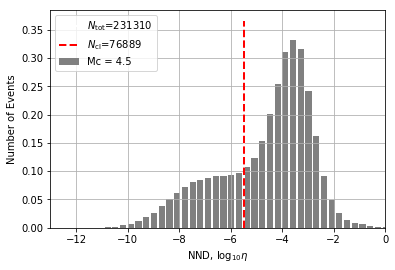

In [9]:
    #=================================4==============================================
    #                          plot histogram
    #================================================================================
    # load eta_0 value - only for plotting purposes
    eta_0_file = '%s/%s_Mc_%.1f_eta_0.txt'%(dir_in, file_in, f_Mc)
    if os.path.isfile( eta_0_file):
        print( 'load eta_0 from file'),
        f_eta_0 = np.loadtxt( eta_0_file, dtype = float)
        print( f_eta_0)
    else:
        print( 'could not find eta_0 file', eta_0_file, 'use value from dPar', dPar['eta_0'])
        f_eta_0 = dPar['eta_0']
    fig, ax = plt.subplots()
    ax.bar( aBins, aHist, width =.8*dPar['eta_binsize'], align = 'edge', color = '.5', label = 'Mc = %.1f'%( f_Mc))
    ax.plot( [f_eta_0, f_eta_0], ax.get_ylim(), 'w-',  lw = 2, label = '$N_\mathrm{tot}$=%i'%( eqCat.size()))
    ax.plot( [f_eta_0, f_eta_0], ax.get_ylim(), 'r--', lw = 2, label = '$N_\mathrm{cl}$=%i'%( dCluster['aNND'][dCluster['aNND']<1e-5].shape[0]))

    ax.legend( loc = 'upper left')
    ax.set_xlabel( 'NND, log$_{10} \eta$')
    ax.set_ylabel( 'Number of Events')
    ax.grid( 'on')
    ax.set_xlim( dPar['xmin'], dPar['xmax'])
    plt.show()

The above figure shows a histogram of nearest parent space-time-magnitude distance in the catalog. Note that two distinct modes arise from a typical earthquake catalog: a clustered mode (left) and a background mode (right). The former represent omori-type clustering (typically 'nearer') while the latter represents the background poisson process. Earthquakes in the background mode are earthquakes that, observably, are not triggered from a previous earthquake. $\eta_0$ is the cutoff between these two modes. Practically, this will result in all connections between earethquakes exceeding this cutoff will be removed, thus forming distinct clusters of earthquakes.

If doing a quick analysis, it is possible to simply pick a value that separates these modes. Smaller values will lead to smaller clusters, larger values will lead to more generous clusters but may include background seismicity.

## (Optional) Plot normalized space distance ($R_{ij}$) versus normalized time distance ($T_{ij}$)
1. compute inter-event times and distance and normalize by magnitude
1. create colormap of event-pair density (i.e. NND events) for
    corresponding rescaled event times and distances
    
This provides a visualization of the clustering behavior outlined above. This time in normalized space distance ($R_{ij}$) versus normalized time distance ($T_{ij}$). Where:

$$ R_{ij} = r_{ij}^d\times10^{bM_i/2} $$
$$ T_{ij} = t_{ij}\times10^{bM_i/2} $$

In [10]:
eqCatMc   = EqCat()  # catalog above completeness
catChild  = EqCat()
catParent = EqCat()
# get eta_0 and eta_ij
for i in range( dPar['aMc'].shape[0]):
    f_Mc =  dPar['aMc'][i]
    eta_0_file = '%s%s_Mc_%.1f_eta_0.txt'%(dir_in, file_in, f_Mc)
    # load eta_0 value
    if os.path.isfile( eta_0_file):
        print( 'load eta_0 from file'),
        f_eta_0 = np.loadtxt( eta_0_file, dtype = float)
        print( f_eta_0)
    else:
        print( 'could not find eta_0 file', eta_0_file, 'use value from dPar', dPar['eta_0'])
        f_eta_0 = dPar['eta_0']
    # cut below current completeness
    eqCatMc.copy( eqCat)
    eqCatMc.selectEvents( f_Mc, None, 'Mag')
    print( 'current catalog size: ',eqCatMc.size())
    
    # load nearest neighbor distances 
    NND_file = 'data/%s_NND_Mc_%.1f.mat'%( file_in.split('.')[0], f_Mc)
    dNND   = data_utils.loadmat(NND_file) #,  struct_as_record=True)
    #dNND  = clustering.NND_eta(  eqCatMc, {'b':dPar['b'], 'D':dPar['D'], 'Mc':f_Mc}, correct_co_located = True)
    
    #==================================3=============================================
    #                       compute re-scaled interevent times and distances
    #================================================================================ 
    catChild.copy( eqCatMc)
    catParent.copy( eqCatMc)
    #catChild, catPar = create_parent_child_cat( projCat, dNND)
    catChild.selEventsFromID(    dNND['aEqID_c'], repeats = True)
    catParent.selEventsFromID(   dNND['aEqID_p'], repeats = True)
    print( 'size of parent catalog', catChild.size(), 'size of offspring cat', catParent.size())     
    # note that dictionary dPar here has to include 'b','D' and 'Mc'
    a_R, a_T = clustering.rescaled_t_r( catChild, catParent, {'b':dPar['b'], 'D':dPar['D'], 'Mc':f_Mc}, correct_co_located = True)
    RT_file = 'data/%s_RT_Mc_%.1f.mat'%( file_in.split('.')[0], f_Mc)
    scipy.io.savemat( RT_file, {'R' : a_R, 'T': a_T}, do_compression  = True)
    #==================================4==============================================================
    #                       T-R density plots
    #=================================================================================================
    a_Tbin = np.arange( dPar['Tmin'], dPar['Tmax']+2*dPar['binx'], dPar['binx'])
    a_Rbin = np.arange( dPar['Rmin'], dPar['Rmax']+2*dPar['biny'], dPar['biny'])
    XX, YY, ZZ = data_utils.density_2D( np.log10( a_T), np.log10( a_R), a_Tbin, a_Rbin, sigma = dPar['sigma'])
    
    plt.figure(1, figsize= (8,10))
    ax = plt.subplot(111)
    ax.set_title( 'Nearest Neighbor Pairs in R-T')
    #------------------------------------------------------------------------------ 
    normZZ = ZZ*( dPar['binx']*dPar['biny']*eqCatMc.size())
    plot1 = ax.pcolormesh( XX, YY, normZZ, cmap=dPar['cmap'])
    cbar  = plt.colorbar(plot1, orientation = 'horizontal', shrink = .5, aspect = 20,)
    #ax.plot(  np.log10( a_T), np.log10( a_R), 'wo', ms = 1.5, alpha = .2)
    # plot eta_0 to divide clustered and background mode
    ax.plot( [dPar['Tmin'], dPar['Tmax']],  -np.array([dPar['Tmin'], dPar['Tmax']])+dPar['eta_0'], '-', lw = 1.5, color = 'w' )
    ax.plot( [dPar['Tmin'], dPar['Tmax']],  -np.array([dPar['Tmin'], dPar['Tmax']])+dPar['eta_0'],'--', lw = 1.5, color = '.5' )
    #-----------------------labels and legends-------------------------------------------------------
    #cbar.set_label( 'Event Pair Density [#ev./dRdT]') 
    cbar.set_label( 'Number of Event Pairs',labelpad=-40)
    ax.set_xlabel( 'Rescaled Time')
    ax.set_ylabel( 'Rescaled Distance') 
    ax.set_xlim( dPar['Tmin'], dPar['Tmax'])
    ax.set_ylim( dPar['Rmin'], dPar['Rmax'])


('could not find eta_0 file', './datazaliapin_test_cat.mat_Mc_4.5_eta_0.txt', 'use value from dPar', -5.5)
('current catalog size: ', 231310)
('size of parent catalog', 230638, 'size of offspring cat', 230638)


ValueError: array must not contain infs or NaNs

## (Optional) Plot branching structure as a function of time and latitude

This is usefull particulalrly for smaller catalogs to diagnose the branching structure of the catalog.

In [ ]:
eqCatMc = EqCat()  # catalog above completeness
iMc = 0
for f_Mc in dPar['aMc']:
    eta_0_file = '%s%s_Mc_%.1f_eta_0.txt'%(data_dir, file_in, f_Mc)
    # load eta_0 value
    if os.path.isfile( eta_0_file):
        print( 'load eta_0 from file'),
        f_eta_0 = np.loadtxt( eta_0_file, dtype = float)
        print( f_eta_0)
    else:
        print( 'could not find eta_0 file', eta_0_file, 'use value from dPar', dPar['eta_0'])
        f_eta_0 = dPar['eta_0']
    # cut below current completeness
    eqCatMc.copy( eqCat)
    eqCatMc.selectEvents( f_Mc, None, 'Mag')
    print( 'current catalog size: ',eqCatMc.size())
    # load nearest neighbor distances
    NND_file = '%s_NND_Mc_%.1f.mat'%(os.path.basename( file_in).split('.')[0], f_Mc)
    dNND = dataIO.loadmat( os.path.join( data_dir, NND_file))
    print dNND.keys()
    dNND['aNND'] = np.log10( dNND['aNND'])
    #==================================3=============================================
    #                          "declustering" step
    #================================================================================  
    #catChild, catPar = create_parent_child_cat( projCat, dNND)
    catChild.copy( eqCat)
    catParent.copy( eqCat)
    catChild.selEventsFromID( dNND['aEqID_c'], eqCatMc, repeats = True)
    catParent.selEventsFromID( dNND['aEqID_p'], eqCatMc, repeats = True)
    print 'tot. ev', eqCatMc.size(), 'parents', np.unique( catParent.data['N']).shape[0], 'children', np.unique( catChild.data['N']).shape[0]
    #==================================4=============================================
    #                          spanning tree
    #================================================================================
    plt.figure( 1)
    ax = plt.subplot(111)  
    for iEv in xrange( catParent.size()):
        if dNND['aNND'][iEv] < dPar['eta_0']:#triggered cluster
            ax.plot( [catParent.data['Time'][iEv]], [catParent.data['Lat'][iEv]], 'ro', ms = 12, alpha = .2)
            ax.plot( [catParent.data['Time'][iEv],catChild.data['Time'][iEv]],
                      [catParent.data['Lat'][iEv], catChild.data['Lat'][iEv]], 'k-', marker = 'o', ms = 4, mew =1, mfc = 'none')
        else: # independent events
            ax.plot( [catChild.data['Time'][iEv]], [catChild.data['Lat'][iEv]], 'bo', ms = 5, alpha = .6)
    plt.show()

    iMc += 1


('could not find eta_0 file', './datazaliapin_test_cat.mat_Mc_4.5_eta_0.txt', 'use value from dPar', -5.5)
('current catalog size: ', 231310)
['aEqID_p', 'aNND', 'aEqID_c']
tot. ev 231310 parents 93299 children 230639


KeyboardInterrupt: 

Error in callback <function post_execute at 0x7f84764ec230> (for post_execute):


ValueError: object too deep for desired array

## (Key step) Create cluster families

     key step in the analysis during which complete families of triggered events are assembled

     1) select all event pairs with NND <= eta_0
     2) place each event into a new cluster (family) with unique cluster ID
        or append to existing cluster if parent or offspring event are found in list
        of previously created clusters
    
    
    Input:   NND_file = str()
             eta_0    = float()
             
      
    Output:
            dictionary with all event families 
            dic['0'] = singles
            all other cluster are integer-strings followed by the associated eqID number
              e.g.
              {   '0': np.array([[1243245,4253455343]]),
                  '1': np.array([[5235,43455343,3456,56652,54]]),
                  '2':  ....}
            Note that:
             1)   output is saved as matlab binary but file cannot
                  be read with matlab because variable names are integers
             2) cluster '0' are singles
             3) mainshocks can be defined as largest  event or
                first event in a family
                
This section creates a file: "fileNameIn_Mc_XY_clusters.mat" that contains the cluster families


In [12]:
eqCatMc = EqCat() # this catalog will be modified with each Mc iteration

iMc = 0
for f_Mc in dPar['aMc']:
    clust_file = file_in.replace( '.mat', 'Mc_%.1f_clusters.mat'%( f_Mc))
    eta_0_file = '%s/%s_Mc_%.1f_eta_0.txt'%(dir_in, file_in, f_Mc)
    # load eta_0 value
    if os.path.isfile( eta_0_file):
        print( 'load eta_0 from file'),
        f_eta_0 = np.loadtxt( eta_0_file, dtype = float)
        print( f_eta_0)
    else:
        print( 'could not find eta_0 file', eta_0_file, 'use value from dPar', dPar['eta_0'])
        f_eta_0 = dPar['eta_0']

    # cut below current completeness
    eqCatMc.copy( eqCat)
    eqCatMc.selectEvents( f_Mc, None, 'Mag')
    print( 'current catalog size: ',eqCatMc.size())
    # load nearest neighbor distances
    NND_file = '%s_NND_Mc_%.1f.mat'%(os.path.basename( file_in).split('.')[0], f_Mc)
    dNND = dataIO.loadmat( os.path.join( data_dir, NND_file))
    dNND['aNND'] = np.log10( dNND['aNND'])
 
    #==================================3=============================================
    #                      assemble clusters
    #================================================================================
    print( 'similarity threshold', dPar['eta_0'])
    # clustering according to eta_0 similarity criteria
    dClust = clustering.assembleClusters_NND( dNND['aEqID_c'], dNND['aEqID_p'], dNND['aNND'], f_eta_0, useLargerEvents = False)

    #=================================4==========================================================================
    #                           save results
    #============================================================================================================
    scipy.io.savemat( os.path.join( data_dir,clust_file), dClust, do_compression=True)

('could not find eta_0 file', './data/zaliapin_test_cat.mat_Mc_4.5_eta_0.txt', 'use value from dPar', -5.0)
('current catalog size: ', 231310)
('similarity threshold', -5.0)
assuming threshold (-5.0) is a MAXIMUM, select similarity values BELOW this threshold
intial N events not clustered 153749 initial N events clustered 76889 76889 N-tot 230638
Ntot in cluster  93076 N-parent 16187 N singles 137615 Ntot. offspring (includes doubles) 76889
Ntot in cat. 230638 N-trig + N-ind 230691


## Measure the productivity of mainshocks:

This section counts the number of foreshock and aftershock corresponding to the largest earthquake of each cluster family. This step produces a file with the mainshock ID, the family ID, the number of aftershocks and the number of foreshocks (not in corresponding order). This can be used for comparison with other methods.

In [13]:
eqCatMc = EqCat() # this catalog will be modified with each Mc iteration
iMc = 0
for f_Mc in dPar['aMc']:
    # load file with IDs of events within family
    clust_file = file_in.replace( '.mat', 'Mc_%.1f_clusters.mat'%( f_Mc))
    dClust = data_utils.loadmat( os.path.join( data_dir,clust_file), )


    # cut below current completeness
    eqCatMc.copy( eqCat)
    eqCatMc.selectEvents( f_Mc, None, 'Mag')
    n_aboveMc = eqCatMc.size()
    print( 'current catalog size: ',eqCatMc.size())

    #=================================1==========================================================================
    #                     singles are counted as MS with 0 AS
    #============================================================================================================
    print 'total number of clusters', len(  dClust.keys()), 'no. of BG events', dClust['0'].shape[0]
    a_ID_single  = dClust['0']

    # IDs of BG events
    a_iSel       = np.zeros( eqCatMc.size(), dtype = int)
    a_mag_single = np.zeros( len( a_ID_single))
    a_N_AS_single= np.zeros( len( a_ID_single))
    a_N_FS_single= np.zeros( len( a_ID_single))
    for i in xrange( a_ID_single.shape[0]):
        # event ID may be in catalog more than once
        sel_ev          = eqCatMc.data['N'] == a_ID_single[i]
        a_mag_single[i] = eqCatMc.data['Mag'][sel_ev][0]
        a_iSel[sel_ev] = 1#catalog.data['N'][catalog.data['N']==aEqID[i]][0]
        if sel_ev.sum() != 1:
            error_str = 'more than event found', eqCatMc.data['N'][sel_ev]
            raise ValueError, error_str
    ### remove singles from catalog
    eqCatMc.selDicAll( np.logical_not(a_iSel))
    print 'remaining events', eqCatMc.size(), 'BG events', len( a_mag_single)
    dClust.pop('0') # remove singles
    #=================================2==========================================================================
    #                   get MAGs of MS with aftershocks, count aftershocks
    #============================================================================================================
    a_N_FS    = np.zeros( len( dClust.keys()), dtype = int)
    a_N_AS    = np.zeros( len( dClust.keys()), dtype = int)
    a_MS_mag  = np.zeros( len( dClust.keys()))
    a_MS_ID   = np.zeros( len( dClust.keys()), dtype = int)
    iCl = 0
    for sCl in dClust.keys():
        aEqID = dClust[sCl]# np.unique( dClust[sCl].flatten()) unique is not needed anymore, createCluster has been fixed
        print 'cl: ', iCl+1,'out of: ', len( dClust.keys()), 'no. of ev. in cl.', len( aEqID), len( np.unique( dClust[sCl]))
        # find MS mag and magnitude of entire family
        atmp_MAG = np.zeros( len( aEqID))
        atmp_Time= np.zeros( len( aEqID))
        a_iSel   = np.zeros( eqCatMc.size(), dtype = int)
        # for each family find: event mag. and origin time
        for iM in xrange( len( aEqID)):
            sel_ev        = eqCatMc.data['N'] == aEqID[iM]
            if sel_ev.sum() != 1:
                error_str = 'more/less than event found', eqCatMc.data['N'][sel_ev], aEqID[iM]
                raise ValueError, error_str
            atmp_MAG[iM]  = eqCatMc.data['Mag'][sel_ev][0]
            atmp_Time[iM] = eqCatMc.data['Time'][sel_ev][0]
            a_iSel[sel_ev] = 1
        # remove events from catalog
        #catalog.selDicAll( np.logical_not(a_iSel))
        #----------------------------mainshock-------------------------------------------------- 
        selMS     = atmp_MAG == atmp_MAG.max()
        f_tMS     = atmp_Time[selMS][0]
        i_ID_MS   = aEqID[selMS]

        #print 'tMS', tMS, v_currEqID.shape[0], 'MAG', curr_cat.data['MAG'][selMS][0]
        #----------------------------aftershock-------------------------------------------------- 
        selAS     = atmp_Time > f_tMS
        selFS     = atmp_Time < f_tMS
        #print 'no. of aftershocks', selAS.sum()
        # save number of aftershocks for each MS mag
        a_MS_mag[iCl] = atmp_MAG[selMS][0]#, dPar['magRound'])
        a_N_AS[iCl]   = selAS.sum()
        a_N_FS[iCl]   = selFS.sum()
        a_MS_ID[iCl]  = int( i_ID_MS[0])
        iCl += 1

    #=================================3==========================================================================
    #                  compare MS+single+FS+AS to original number of events in catalog
    #============================================================================================================
    # combine single without AS with mainshocks that do have aftershocks
    a_N_FS    = np.append( a_N_FS, a_N_FS_single)
    a_N_AS    = np.append( a_N_AS, a_N_AS_single)
    a_MS_mag  = np.append( a_MS_mag, a_mag_single)
    a_MS_ID   = np.append( a_MS_ID, a_ID_single)
    print 'tot ev. in catalog', n_aboveMc,'tot events in families',a_N_FS.sum() + a_N_AS.sum() + a_MS_mag.shape[0]
    #print 'N BG', a_mag_single.shape[0], 'FS', a_N_FS_single.sum(), 'AS', a_N_AS_single.sum(), 'MS (MS+BG)', a_MS_mag.shape[0]

    #=================================4==========================================================================
    #                    save to ASCII text
    #============================================================================================================
    file_out = '%s/%s_Nas_MS_Mc_%.1f.txt'%(data_dir, file_in.split('.')[0], f_Mc)#, dPar['magRound'])
    np.savetxt( file_out, np.array([a_MS_mag, a_N_AS, a_N_FS, a_MS_ID]).T, fmt='%10.3f%10i%10i%14i',
                header = 'MAG          N_AS          N_FS        MS_ID')
    iMc += 1


('current catalog size: ', 231310)
total number of clusters 16188 no. of BG events 137615
remaining events 93695 BG events 137615
cl:  1 out of:  16187 no. of ev. in cl. 2 2
cl:  2 out of:  16187 no. of ev. in cl. 2 2
cl:  3 out of:  16187 no. of ev. in cl. 2 2
cl:  4 out of:  16187 no. of ev. in cl. 2 2
cl:  5 out of:  16187 no. of ev. in cl. 13 13
cl:  6 out of:  16187 no. of ev. in cl. 2 2
cl:  7 out of:  16187 no. of ev. in cl. 4 4
cl:  8 out of:  16187 no. of ev. in cl. 2 2
cl:  9 out of:  16187 no. of ev. in cl. 2 2
cl:  10 out of:  16187 no. of ev. in cl. 3 3
cl:  11 out of:  16187 no. of ev. in cl. 37 37
cl:  12 out of:  16187 no. of ev. in cl. 4 4
cl:  13 out of:  16187 no. of ev. in cl. 2 2
cl:  14 out of:  16187 no. of ev. in cl. 2 2
cl:  15 out of:  16187 no. of ev. in cl. 2 2
cl:  16 out of:  16187 no. of ev. in cl. 4 4
cl:  17 out of:  16187 no. of ev. in cl. 2 2
cl:  18 out of:  16187 no. of ev. in cl. 2 2
cl:  19 out of:  16187 no. of ev. in cl. 3 3
cl:  20 out of:  161

cl:  236 out of:  16187 no. of ev. in cl. 2 2
cl:  237 out of:  16187 no. of ev. in cl. 2 2
cl:  238 out of:  16187 no. of ev. in cl. 7 7
cl:  239 out of:  16187 no. of ev. in cl. 2 2
cl:  240 out of:  16187 no. of ev. in cl. 2 2
cl:  241 out of:  16187 no. of ev. in cl. 2 2
cl:  242 out of:  16187 no. of ev. in cl. 6 6
cl:  243 out of:  16187 no. of ev. in cl. 2 2
cl:  244 out of:  16187 no. of ev. in cl. 2 2
cl:  245 out of:  16187 no. of ev. in cl. 3 3
cl:  246 out of:  16187 no. of ev. in cl. 2 2
cl:  247 out of:  16187 no. of ev. in cl. 5 5
cl:  248 out of:  16187 no. of ev. in cl. 2 2
cl:  249 out of:  16187 no. of ev. in cl. 2 2
cl:  250 out of:  16187 no. of ev. in cl. 2 2
cl:  251 out of:  16187 no. of ev. in cl. 2 2
cl:  252 out of:  16187 no. of ev. in cl. 6 6
cl:  253 out of:  16187 no. of ev. in cl. 3 3
cl:  254 out of:  16187 no. of ev. in cl. 2 2
cl:  255 out of:  16187 no. of ev. in cl. 132 132
cl:  256 out of:  16187 no. of ev. in cl. 48 48
cl:  257 out of:  16187 no. 

cl:  493 out of:  16187 no. of ev. in cl. 2 2
cl:  494 out of:  16187 no. of ev. in cl. 18 18
cl:  495 out of:  16187 no. of ev. in cl. 2 2
cl:  496 out of:  16187 no. of ev. in cl. 2 2
cl:  497 out of:  16187 no. of ev. in cl. 3 3
cl:  498 out of:  16187 no. of ev. in cl. 2 2
cl:  499 out of:  16187 no. of ev. in cl. 2 2
cl:  500 out of:  16187 no. of ev. in cl. 2 2
cl:  501 out of:  16187 no. of ev. in cl. 3 3
cl:  502 out of:  16187 no. of ev. in cl. 3 3
cl:  503 out of:  16187 no. of ev. in cl. 3 3
cl:  504 out of:  16187 no. of ev. in cl. 2 2
cl:  505 out of:  16187 no. of ev. in cl. 2 2
cl:  506 out of:  16187 no. of ev. in cl. 3 3
cl:  507 out of:  16187 no. of ev. in cl. 2 2
cl:  508 out of:  16187 no. of ev. in cl. 2 2
cl:  509 out of:  16187 no. of ev. in cl. 3 3
cl:  510 out of:  16187 no. of ev. in cl. 3 3
cl:  511 out of:  16187 no. of ev. in cl. 2 2
cl:  512 out of:  16187 no. of ev. in cl. 2 2
cl:  513 out of:  16187 no. of ev. in cl. 5 5
cl:  514 out of:  16187 no. of e

cl:  700 out of:  16187 no. of ev. in cl. 2 2
cl:  701 out of:  16187 no. of ev. in cl. 2 2
cl:  702 out of:  16187 no. of ev. in cl. 17 17
cl:  703 out of:  16187 no. of ev. in cl. 6 6
cl:  704 out of:  16187 no. of ev. in cl. 2 2
cl:  705 out of:  16187 no. of ev. in cl. 2 2
cl:  706 out of:  16187 no. of ev. in cl. 2 2
cl:  707 out of:  16187 no. of ev. in cl. 2 2
cl:  708 out of:  16187 no. of ev. in cl. 5 5
cl:  709 out of:  16187 no. of ev. in cl. 3 3
cl:  710 out of:  16187 no. of ev. in cl. 2 2
cl:  711 out of:  16187 no. of ev. in cl. 5 5
cl:  712 out of:  16187 no. of ev. in cl. 2 2
cl:  713 out of:  16187 no. of ev. in cl. 2 2
cl:  714 out of:  16187 no. of ev. in cl. 2 2
cl:  715 out of:  16187 no. of ev. in cl. 2 2
cl:  716 out of:  16187 no. of ev. in cl. 4 4
cl:  717 out of:  16187 no. of ev. in cl. 2 2
cl:  718 out of:  16187 no. of ev. in cl. 2 2
cl:  719 out of:  16187 no. of ev. in cl. 3 3
cl:  720 out of:  16187 no. of ev. in cl. 3 3
cl:  721 out of:  16187 no. of e

cl:  997 out of:  16187 no. of ev. in cl. 2 2
cl:  998 out of:  16187 no. of ev. in cl. 8 8
cl:  999 out of:  16187 no. of ev. in cl. 22 22
cl:  1000 out of:  16187 no. of ev. in cl. 2 2
cl:  1001 out of:  16187 no. of ev. in cl. 2 2
cl:  1002 out of:  16187 no. of ev. in cl. 2 2
cl:  1003 out of:  16187 no. of ev. in cl. 7 7
cl:  1004 out of:  16187 no. of ev. in cl. 4 4
cl:  1005 out of:  16187 no. of ev. in cl. 2 2
cl:  1006 out of:  16187 no. of ev. in cl. 27 27
cl:  1007 out of:  16187 no. of ev. in cl. 2 2
cl:  1008 out of:  16187 no. of ev. in cl. 2 2
cl:  1009 out of:  16187 no. of ev. in cl. 2 2
cl:  1010 out of:  16187 no. of ev. in cl. 3 3
cl:  1011 out of:  16187 no. of ev. in cl. 5 5
cl:  1012 out of:  16187 no. of ev. in cl. 2 2
cl:  1013 out of:  16187 no. of ev. in cl. 2 2
cl:  1014 out of:  16187 no. of ev. in cl. 3 3
cl:  1015 out of:  16187 no. of ev. in cl. 4 4
cl:  1016 out of:  16187 no. of ev. in cl. 2 2
cl:  1017 out of:  16187 no. of ev. in cl. 3 3
cl:  1018 ou

cl:  1279 out of:  16187 no. of ev. in cl. 2 2
cl:  1280 out of:  16187 no. of ev. in cl. 5 5
cl:  1281 out of:  16187 no. of ev. in cl. 2 2
cl:  1282 out of:  16187 no. of ev. in cl. 2 2
cl:  1283 out of:  16187 no. of ev. in cl. 2 2
cl:  1284 out of:  16187 no. of ev. in cl. 2 2
cl:  1285 out of:  16187 no. of ev. in cl. 3 3
cl:  1286 out of:  16187 no. of ev. in cl. 2 2
cl:  1287 out of:  16187 no. of ev. in cl. 2 2
cl:  1288 out of:  16187 no. of ev. in cl. 5 5
cl:  1289 out of:  16187 no. of ev. in cl. 2 2
cl:  1290 out of:  16187 no. of ev. in cl. 4 4
cl:  1291 out of:  16187 no. of ev. in cl. 11 11
cl:  1292 out of:  16187 no. of ev. in cl. 3 3
cl:  1293 out of:  16187 no. of ev. in cl. 2 2
cl:  1294 out of:  16187 no. of ev. in cl. 4 4
cl:  1295 out of:  16187 no. of ev. in cl. 2 2
cl:  1296 out of:  16187 no. of ev. in cl. 2 2
cl:  1297 out of:  16187 no. of ev. in cl. 3 3
cl:  1298 out of:  16187 no. of ev. in cl. 2 2
cl:  1299 out of:  16187 no. of ev. in cl. 5 5
cl:  1300 o

cl:  1532 out of:  16187 no. of ev. in cl. 2 2
cl:  1533 out of:  16187 no. of ev. in cl. 6 6
cl:  1534 out of:  16187 no. of ev. in cl. 9 9
cl:  1535 out of:  16187 no. of ev. in cl. 2 2
cl:  1536 out of:  16187 no. of ev. in cl. 3 3
cl:  1537 out of:  16187 no. of ev. in cl. 2 2
cl:  1538 out of:  16187 no. of ev. in cl. 4 4
cl:  1539 out of:  16187 no. of ev. in cl. 4 4
cl:  1540 out of:  16187 no. of ev. in cl. 2 2
cl:  1541 out of:  16187 no. of ev. in cl. 4 4
cl:  1542 out of:  16187 no. of ev. in cl. 2 2
cl:  1543 out of:  16187 no. of ev. in cl. 2 2
cl:  1544 out of:  16187 no. of ev. in cl. 5 5
cl:  1545 out of:  16187 no. of ev. in cl. 3 3
cl:  1546 out of:  16187 no. of ev. in cl. 2 2
cl:  1547 out of:  16187 no. of ev. in cl. 2 2
cl:  1548 out of:  16187 no. of ev. in cl. 2 2
cl:  1549 out of:  16187 no. of ev. in cl. 8 8
cl:  1550 out of:  16187 no. of ev. in cl. 5 5
cl:  1551 out of:  16187 no. of ev. in cl. 2 2
cl:  1552 out of:  16187 no. of ev. in cl. 2 2
cl:  1553 out

cl:  1745 out of:  16187 no. of ev. in cl. 2 2
cl:  1746 out of:  16187 no. of ev. in cl. 2 2
cl:  1747 out of:  16187 no. of ev. in cl. 2 2
cl:  1748 out of:  16187 no. of ev. in cl. 7 7
cl:  1749 out of:  16187 no. of ev. in cl. 2 2
cl:  1750 out of:  16187 no. of ev. in cl. 2 2
cl:  1751 out of:  16187 no. of ev. in cl. 2 2
cl:  1752 out of:  16187 no. of ev. in cl. 2 2
cl:  1753 out of:  16187 no. of ev. in cl. 12 12
cl:  1754 out of:  16187 no. of ev. in cl. 4 4
cl:  1755 out of:  16187 no. of ev. in cl. 3 3
cl:  1756 out of:  16187 no. of ev. in cl. 7 7
cl:  1757 out of:  16187 no. of ev. in cl. 2 2
cl:  1758 out of:  16187 no. of ev. in cl. 7 7
cl:  1759 out of:  16187 no. of ev. in cl. 3 3
cl:  1760 out of:  16187 no. of ev. in cl. 2 2
cl:  1761 out of:  16187 no. of ev. in cl. 9 9
cl:  1762 out of:  16187 no. of ev. in cl. 6 6
cl:  1763 out of:  16187 no. of ev. in cl. 3 3
cl:  1764 out of:  16187 no. of ev. in cl. 2 2
cl:  1765 out of:  16187 no. of ev. in cl. 2 2
cl:  1766 o

cl:  1987 out of:  16187 no. of ev. in cl. 2 2
cl:  1988 out of:  16187 no. of ev. in cl. 2 2
cl:  1989 out of:  16187 no. of ev. in cl. 3 3
cl:  1990 out of:  16187 no. of ev. in cl. 5 5
cl:  1991 out of:  16187 no. of ev. in cl. 2 2
cl:  1992 out of:  16187 no. of ev. in cl. 20 20
cl:  1993 out of:  16187 no. of ev. in cl. 2 2
cl:  1994 out of:  16187 no. of ev. in cl. 2 2
cl:  1995 out of:  16187 no. of ev. in cl. 2 2
cl:  1996 out of:  16187 no. of ev. in cl. 3 3
cl:  1997 out of:  16187 no. of ev. in cl. 2 2
cl:  1998 out of:  16187 no. of ev. in cl. 2 2
cl:  1999 out of:  16187 no. of ev. in cl. 2 2
cl:  2000 out of:  16187 no. of ev. in cl. 2 2
cl:  2001 out of:  16187 no. of ev. in cl. 3 3
cl:  2002 out of:  16187 no. of ev. in cl. 5 5
cl:  2003 out of:  16187 no. of ev. in cl. 2 2
cl:  2004 out of:  16187 no. of ev. in cl. 481 481
cl:  2005 out of:  16187 no. of ev. in cl. 2 2
cl:  2006 out of:  16187 no. of ev. in cl. 2 2
cl:  2007 out of:  16187 no. of ev. in cl. 2 2
cl:  20

cl:  2264 out of:  16187 no. of ev. in cl. 2 2
cl:  2265 out of:  16187 no. of ev. in cl. 4 4
cl:  2266 out of:  16187 no. of ev. in cl. 2 2
cl:  2267 out of:  16187 no. of ev. in cl. 2 2
cl:  2268 out of:  16187 no. of ev. in cl. 2 2
cl:  2269 out of:  16187 no. of ev. in cl. 3 3
cl:  2270 out of:  16187 no. of ev. in cl. 2 2
cl:  2271 out of:  16187 no. of ev. in cl. 2 2
cl:  2272 out of:  16187 no. of ev. in cl. 2 2
cl:  2273 out of:  16187 no. of ev. in cl. 2 2
cl:  2274 out of:  16187 no. of ev. in cl. 2 2
cl:  2275 out of:  16187 no. of ev. in cl. 3 3
cl:  2276 out of:  16187 no. of ev. in cl. 2 2
cl:  2277 out of:  16187 no. of ev. in cl. 2 2
cl:  2278 out of:  16187 no. of ev. in cl. 2 2
cl:  2279 out of:  16187 no. of ev. in cl. 2 2
cl:  2280 out of:  16187 no. of ev. in cl. 4 4
cl:  2281 out of:  16187 no. of ev. in cl. 4 4
cl:  2282 out of:  16187 no. of ev. in cl. 8 8
cl:  2283 out of:  16187 no. of ev. in cl. 2 2
cl:  2284 out of:  16187 no. of ev. in cl. 2 2
cl:  2285 out

cl:  2520 out of:  16187 no. of ev. in cl. 3 3
cl:  2521 out of:  16187 no. of ev. in cl. 2 2
cl:  2522 out of:  16187 no. of ev. in cl. 2 2
cl:  2523 out of:  16187 no. of ev. in cl. 3 3
cl:  2524 out of:  16187 no. of ev. in cl. 2 2
cl:  2525 out of:  16187 no. of ev. in cl. 2 2
cl:  2526 out of:  16187 no. of ev. in cl. 2 2
cl:  2527 out of:  16187 no. of ev. in cl. 2 2
cl:  2528 out of:  16187 no. of ev. in cl. 2 2
cl:  2529 out of:  16187 no. of ev. in cl. 2 2
cl:  2530 out of:  16187 no. of ev. in cl. 6 6
cl:  2531 out of:  16187 no. of ev. in cl. 2 2
cl:  2532 out of:  16187 no. of ev. in cl. 2 2
cl:  2533 out of:  16187 no. of ev. in cl. 2 2
cl:  2534 out of:  16187 no. of ev. in cl. 5 5
cl:  2535 out of:  16187 no. of ev. in cl. 2 2
cl:  2536 out of:  16187 no. of ev. in cl. 5 5
cl:  2537 out of:  16187 no. of ev. in cl. 2 2
cl:  2538 out of:  16187 no. of ev. in cl. 4 4
cl:  2539 out of:  16187 no. of ev. in cl. 2 2
cl:  2540 out of:  16187 no. of ev. in cl. 2 2
cl:  2541 out

cl:  2786 out of:  16187 no. of ev. in cl. 2 2
cl:  2787 out of:  16187 no. of ev. in cl. 3 3
cl:  2788 out of:  16187 no. of ev. in cl. 2 2
cl:  2789 out of:  16187 no. of ev. in cl. 6 6
cl:  2790 out of:  16187 no. of ev. in cl. 2 2
cl:  2791 out of:  16187 no. of ev. in cl. 2 2
cl:  2792 out of:  16187 no. of ev. in cl. 3 3
cl:  2793 out of:  16187 no. of ev. in cl. 2 2
cl:  2794 out of:  16187 no. of ev. in cl. 2 2
cl:  2795 out of:  16187 no. of ev. in cl. 10 10
cl:  2796 out of:  16187 no. of ev. in cl. 2 2
cl:  2797 out of:  16187 no. of ev. in cl. 2 2
cl:  2798 out of:  16187 no. of ev. in cl. 2 2
cl:  2799 out of:  16187 no. of ev. in cl. 2 2
cl:  2800 out of:  16187 no. of ev. in cl. 2 2
cl:  2801 out of:  16187 no. of ev. in cl. 3 3
cl:  2802 out of:  16187 no. of ev. in cl. 2 2
cl:  2803 out of:  16187 no. of ev. in cl. 3 3
cl:  2804 out of:  16187 no. of ev. in cl. 3 3
cl:  2805 out of:  16187 no. of ev. in cl. 2 2
cl:  2806 out of:  16187 no. of ev. in cl. 4 4
cl:  2807 o

cl:  3029 out of:  16187 no. of ev. in cl. 2 2
cl:  3030 out of:  16187 no. of ev. in cl. 2 2
cl:  3031 out of:  16187 no. of ev. in cl. 2 2
cl:  3032 out of:  16187 no. of ev. in cl. 5 5
cl:  3033 out of:  16187 no. of ev. in cl. 11 11
cl:  3034 out of:  16187 no. of ev. in cl. 3 3
cl:  3035 out of:  16187 no. of ev. in cl. 3 3
cl:  3036 out of:  16187 no. of ev. in cl. 2 2
cl:  3037 out of:  16187 no. of ev. in cl. 2 2
cl:  3038 out of:  16187 no. of ev. in cl. 2 2
cl:  3039 out of:  16187 no. of ev. in cl. 2 2
cl:  3040 out of:  16187 no. of ev. in cl. 3 3
cl:  3041 out of:  16187 no. of ev. in cl. 2 2
cl:  3042 out of:  16187 no. of ev. in cl. 2 2
cl:  3043 out of:  16187 no. of ev. in cl. 2 2
cl:  3044 out of:  16187 no. of ev. in cl. 3 3
cl:  3045 out of:  16187 no. of ev. in cl. 2 2
cl:  3046 out of:  16187 no. of ev. in cl. 2 2
cl:  3047 out of:  16187 no. of ev. in cl. 3 3
cl:  3048 out of:  16187 no. of ev. in cl. 5 5
cl:  3049 out of:  16187 no. of ev. in cl. 2 2
cl:  3050 o

cl:  3361 out of:  16187 no. of ev. in cl. 2 2
cl:  3362 out of:  16187 no. of ev. in cl. 2 2
cl:  3363 out of:  16187 no. of ev. in cl. 2 2
cl:  3364 out of:  16187 no. of ev. in cl. 7 7
cl:  3365 out of:  16187 no. of ev. in cl. 3 3
cl:  3366 out of:  16187 no. of ev. in cl. 2 2
cl:  3367 out of:  16187 no. of ev. in cl. 2 2
cl:  3368 out of:  16187 no. of ev. in cl. 4 4
cl:  3369 out of:  16187 no. of ev. in cl. 2 2
cl:  3370 out of:  16187 no. of ev. in cl. 3 3
cl:  3371 out of:  16187 no. of ev. in cl. 2 2
cl:  3372 out of:  16187 no. of ev. in cl. 4 4
cl:  3373 out of:  16187 no. of ev. in cl. 2 2
cl:  3374 out of:  16187 no. of ev. in cl. 3 3
cl:  3375 out of:  16187 no. of ev. in cl. 5 5
cl:  3376 out of:  16187 no. of ev. in cl. 3 3
cl:  3377 out of:  16187 no. of ev. in cl. 2 2
cl:  3378 out of:  16187 no. of ev. in cl. 2 2
cl:  3379 out of:  16187 no. of ev. in cl. 2 2
cl:  3380 out of:  16187 no. of ev. in cl. 7 7
cl:  3381 out of:  16187 no. of ev. in cl. 2 2
cl:  3382 out

cl:  3628 out of:  16187 no. of ev. in cl. 3 3
cl:  3629 out of:  16187 no. of ev. in cl. 2 2
cl:  3630 out of:  16187 no. of ev. in cl. 2 2
cl:  3631 out of:  16187 no. of ev. in cl. 2 2
cl:  3632 out of:  16187 no. of ev. in cl. 2 2
cl:  3633 out of:  16187 no. of ev. in cl. 2 2
cl:  3634 out of:  16187 no. of ev. in cl. 3 3
cl:  3635 out of:  16187 no. of ev. in cl. 2 2
cl:  3636 out of:  16187 no. of ev. in cl. 3 3
cl:  3637 out of:  16187 no. of ev. in cl. 2 2
cl:  3638 out of:  16187 no. of ev. in cl. 2 2
cl:  3639 out of:  16187 no. of ev. in cl. 2 2
cl:  3640 out of:  16187 no. of ev. in cl. 2 2
cl:  3641 out of:  16187 no. of ev. in cl. 18 18
cl:  3642 out of:  16187 no. of ev. in cl. 2 2
cl:  3643 out of:  16187 no. of ev. in cl. 2 2
cl:  3644 out of:  16187 no. of ev. in cl. 2 2
cl:  3645 out of:  16187 no. of ev. in cl. 7 7
cl:  3646 out of:  16187 no. of ev. in cl. 4 4
cl:  3647 out of:  16187 no. of ev. in cl. 2 2
cl:  3648 out of:  16187 no. of ev. in cl. 5 5
cl:  3649 o

cl:  3890 out of:  16187 no. of ev. in cl. 36 36
cl:  3891 out of:  16187 no. of ev. in cl. 3 3
cl:  3892 out of:  16187 no. of ev. in cl. 3 3
cl:  3893 out of:  16187 no. of ev. in cl. 4 4
cl:  3894 out of:  16187 no. of ev. in cl. 6 6
cl:  3895 out of:  16187 no. of ev. in cl. 2 2
cl:  3896 out of:  16187 no. of ev. in cl. 2 2
cl:  3897 out of:  16187 no. of ev. in cl. 3 3
cl:  3898 out of:  16187 no. of ev. in cl. 2 2
cl:  3899 out of:  16187 no. of ev. in cl. 3 3
cl:  3900 out of:  16187 no. of ev. in cl. 2 2
cl:  3901 out of:  16187 no. of ev. in cl. 2 2
cl:  3902 out of:  16187 no. of ev. in cl. 5 5
cl:  3903 out of:  16187 no. of ev. in cl. 48 48
cl:  3904 out of:  16187 no. of ev. in cl. 2 2
cl:  3905 out of:  16187 no. of ev. in cl. 2 2
cl:  3906 out of:  16187 no. of ev. in cl. 3 3
cl:  3907 out of:  16187 no. of ev. in cl. 2 2
cl:  3908 out of:  16187 no. of ev. in cl. 2 2
cl:  3909 out of:  16187 no. of ev. in cl. 2 2
cl:  3910 out of:  16187 no. of ev. in cl. 2 2
cl:  3911

cl:  4186 out of:  16187 no. of ev. in cl. 2 2
cl:  4187 out of:  16187 no. of ev. in cl. 4 4
cl:  4188 out of:  16187 no. of ev. in cl. 3 3
cl:  4189 out of:  16187 no. of ev. in cl. 10 10
cl:  4190 out of:  16187 no. of ev. in cl. 2 2
cl:  4191 out of:  16187 no. of ev. in cl. 3 3
cl:  4192 out of:  16187 no. of ev. in cl. 2 2
cl:  4193 out of:  16187 no. of ev. in cl. 4 4
cl:  4194 out of:  16187 no. of ev. in cl. 3 3
cl:  4195 out of:  16187 no. of ev. in cl. 2 2
cl:  4196 out of:  16187 no. of ev. in cl. 2 2
cl:  4197 out of:  16187 no. of ev. in cl. 2 2
cl:  4198 out of:  16187 no. of ev. in cl. 2 2
cl:  4199 out of:  16187 no. of ev. in cl. 2 2
cl:  4200 out of:  16187 no. of ev. in cl. 2 2
cl:  4201 out of:  16187 no. of ev. in cl. 2 2
cl:  4202 out of:  16187 no. of ev. in cl. 2 2
cl:  4203 out of:  16187 no. of ev. in cl. 3 3
cl:  4204 out of:  16187 no. of ev. in cl. 2 2
cl:  4205 out of:  16187 no. of ev. in cl. 2 2
cl:  4206 out of:  16187 no. of ev. in cl. 2 2
cl:  4207 o

cl:  4481 out of:  16187 no. of ev. in cl. 2 2
cl:  4482 out of:  16187 no. of ev. in cl. 2 2
cl:  4483 out of:  16187 no. of ev. in cl. 2 2
cl:  4484 out of:  16187 no. of ev. in cl. 2 2
cl:  4485 out of:  16187 no. of ev. in cl. 2 2
cl:  4486 out of:  16187 no. of ev. in cl. 2 2
cl:  4487 out of:  16187 no. of ev. in cl. 3 3
cl:  4488 out of:  16187 no. of ev. in cl. 2 2
cl:  4489 out of:  16187 no. of ev. in cl. 3 3
cl:  4490 out of:  16187 no. of ev. in cl. 6 6
cl:  4491 out of:  16187 no. of ev. in cl. 2 2
cl:  4492 out of:  16187 no. of ev. in cl. 2 2
cl:  4493 out of:  16187 no. of ev. in cl. 2 2
cl:  4494 out of:  16187 no. of ev. in cl. 2 2
cl:  4495 out of:  16187 no. of ev. in cl. 85 85
cl:  4496 out of:  16187 no. of ev. in cl. 12 12
cl:  4497 out of:  16187 no. of ev. in cl. 2 2
cl:  4498 out of:  16187 no. of ev. in cl. 4 4
cl:  4499 out of:  16187 no. of ev. in cl. 2 2
cl:  4500 out of:  16187 no. of ev. in cl. 7 7
cl:  4501 out of:  16187 no. of ev. in cl. 19 19
cl:  45

cl:  4738 out of:  16187 no. of ev. in cl. 3 3
cl:  4739 out of:  16187 no. of ev. in cl. 3 3
cl:  4740 out of:  16187 no. of ev. in cl. 2 2
cl:  4741 out of:  16187 no. of ev. in cl. 2 2
cl:  4742 out of:  16187 no. of ev. in cl. 3 3
cl:  4743 out of:  16187 no. of ev. in cl. 9 9
cl:  4744 out of:  16187 no. of ev. in cl. 2 2
cl:  4745 out of:  16187 no. of ev. in cl. 2 2
cl:  4746 out of:  16187 no. of ev. in cl. 2 2
cl:  4747 out of:  16187 no. of ev. in cl. 2 2
cl:  4748 out of:  16187 no. of ev. in cl. 2 2
cl:  4749 out of:  16187 no. of ev. in cl. 2 2
cl:  4750 out of:  16187 no. of ev. in cl. 2 2
cl:  4751 out of:  16187 no. of ev. in cl. 2 2
cl:  4752 out of:  16187 no. of ev. in cl. 2 2
cl:  4753 out of:  16187 no. of ev. in cl. 2 2
cl:  4754 out of:  16187 no. of ev. in cl. 2 2
cl:  4755 out of:  16187 no. of ev. in cl. 4 4
cl:  4756 out of:  16187 no. of ev. in cl. 2 2
cl:  4757 out of:  16187 no. of ev. in cl. 2 2
cl:  4758 out of:  16187 no. of ev. in cl. 2 2
cl:  4759 out

cl:  4941 out of:  16187 no. of ev. in cl. 3 3
cl:  4942 out of:  16187 no. of ev. in cl. 2 2
cl:  4943 out of:  16187 no. of ev. in cl. 2 2
cl:  4944 out of:  16187 no. of ev. in cl. 2 2
cl:  4945 out of:  16187 no. of ev. in cl. 2 2
cl:  4946 out of:  16187 no. of ev. in cl. 2 2
cl:  4947 out of:  16187 no. of ev. in cl. 2 2
cl:  4948 out of:  16187 no. of ev. in cl. 3 3
cl:  4949 out of:  16187 no. of ev. in cl. 2 2
cl:  4950 out of:  16187 no. of ev. in cl. 6 6
cl:  4951 out of:  16187 no. of ev. in cl. 2 2
cl:  4952 out of:  16187 no. of ev. in cl. 49 49
cl:  4953 out of:  16187 no. of ev. in cl. 2 2
cl:  4954 out of:  16187 no. of ev. in cl. 2 2
cl:  4955 out of:  16187 no. of ev. in cl. 2 2
cl:  4956 out of:  16187 no. of ev. in cl. 2 2
cl:  4957 out of:  16187 no. of ev. in cl. 6 6
cl:  4958 out of:  16187 no. of ev. in cl. 5 5
cl:  4959 out of:  16187 no. of ev. in cl. 9 9
cl:  4960 out of:  16187 no. of ev. in cl. 10 10
cl:  4961 out of:  16187 no. of ev. in cl. 2 2
cl:  4962

cl:  5154 out of:  16187 no. of ev. in cl. 3 3
cl:  5155 out of:  16187 no. of ev. in cl. 2 2
cl:  5156 out of:  16187 no. of ev. in cl. 3 3
cl:  5157 out of:  16187 no. of ev. in cl. 2 2
cl:  5158 out of:  16187 no. of ev. in cl. 2 2
cl:  5159 out of:  16187 no. of ev. in cl. 2 2
cl:  5160 out of:  16187 no. of ev. in cl. 2 2
cl:  5161 out of:  16187 no. of ev. in cl. 2 2
cl:  5162 out of:  16187 no. of ev. in cl. 2 2
cl:  5163 out of:  16187 no. of ev. in cl. 3 3
cl:  5164 out of:  16187 no. of ev. in cl. 2 2
cl:  5165 out of:  16187 no. of ev. in cl. 6 6
cl:  5166 out of:  16187 no. of ev. in cl. 22 22
cl:  5167 out of:  16187 no. of ev. in cl. 2 2
cl:  5168 out of:  16187 no. of ev. in cl. 3 3
cl:  5169 out of:  16187 no. of ev. in cl. 2 2
cl:  5170 out of:  16187 no. of ev. in cl. 2 2
cl:  5171 out of:  16187 no. of ev. in cl. 5 5
cl:  5172 out of:  16187 no. of ev. in cl. 2 2
cl:  5173 out of:  16187 no. of ev. in cl. 5 5
cl:  5174 out of:  16187 no. of ev. in cl. 2 2
cl:  5175 o

cl:  5408 out of:  16187 no. of ev. in cl. 2 2
cl:  5409 out of:  16187 no. of ev. in cl. 3 3
cl:  5410 out of:  16187 no. of ev. in cl. 9 9
cl:  5411 out of:  16187 no. of ev. in cl. 2 2
cl:  5412 out of:  16187 no. of ev. in cl. 22 22
cl:  5413 out of:  16187 no. of ev. in cl. 2 2
cl:  5414 out of:  16187 no. of ev. in cl. 6 6
cl:  5415 out of:  16187 no. of ev. in cl. 3 3
cl:  5416 out of:  16187 no. of ev. in cl. 2 2
cl:  5417 out of:  16187 no. of ev. in cl. 3 3
cl:  5418 out of:  16187 no. of ev. in cl. 7 7
cl:  5419 out of:  16187 no. of ev. in cl. 2 2
cl:  5420 out of:  16187 no. of ev. in cl. 3 3
cl:  5421 out of:  16187 no. of ev. in cl. 28 28
cl:  5422 out of:  16187 no. of ev. in cl. 3 3
cl:  5423 out of:  16187 no. of ev. in cl. 2 2
cl:  5424 out of:  16187 no. of ev. in cl. 3 3
cl:  5425 out of:  16187 no. of ev. in cl. 2 2
cl:  5426 out of:  16187 no. of ev. in cl. 2 2
cl:  5427 out of:  16187 no. of ev. in cl. 2 2
cl:  5428 out of:  16187 no. of ev. in cl. 2 2
cl:  5429

cl:  5614 out of:  16187 no. of ev. in cl. 2 2
cl:  5615 out of:  16187 no. of ev. in cl. 2 2
cl:  5616 out of:  16187 no. of ev. in cl. 3 3
cl:  5617 out of:  16187 no. of ev. in cl. 3 3
cl:  5618 out of:  16187 no. of ev. in cl. 2 2
cl:  5619 out of:  16187 no. of ev. in cl. 2 2
cl:  5620 out of:  16187 no. of ev. in cl. 10 10
cl:  5621 out of:  16187 no. of ev. in cl. 3 3
cl:  5622 out of:  16187 no. of ev. in cl. 7 7
cl:  5623 out of:  16187 no. of ev. in cl. 3 3
cl:  5624 out of:  16187 no. of ev. in cl. 4 4
cl:  5625 out of:  16187 no. of ev. in cl. 3 3
cl:  5626 out of:  16187 no. of ev. in cl. 2 2
cl:  5627 out of:  16187 no. of ev. in cl. 2 2
cl:  5628 out of:  16187 no. of ev. in cl. 5 5
cl:  5629 out of:  16187 no. of ev. in cl. 2 2
cl:  5630 out of:  16187 no. of ev. in cl. 2 2
cl:  5631 out of:  16187 no. of ev. in cl. 3 3
cl:  5632 out of:  16187 no. of ev. in cl. 3 3
cl:  5633 out of:  16187 no. of ev. in cl. 2 2
cl:  5634 out of:  16187 no. of ev. in cl. 2 2
cl:  5635 o

cl:  5821 out of:  16187 no. of ev. in cl. 2 2
cl:  5822 out of:  16187 no. of ev. in cl. 2 2
cl:  5823 out of:  16187 no. of ev. in cl. 2 2
cl:  5824 out of:  16187 no. of ev. in cl. 2 2
cl:  5825 out of:  16187 no. of ev. in cl. 4 4
cl:  5826 out of:  16187 no. of ev. in cl. 5 5
cl:  5827 out of:  16187 no. of ev. in cl. 2 2
cl:  5828 out of:  16187 no. of ev. in cl. 2 2
cl:  5829 out of:  16187 no. of ev. in cl. 4 4
cl:  5830 out of:  16187 no. of ev. in cl. 3 3
cl:  5831 out of:  16187 no. of ev. in cl. 2 2
cl:  5832 out of:  16187 no. of ev. in cl. 2 2
cl:  5833 out of:  16187 no. of ev. in cl. 2 2
cl:  5834 out of:  16187 no. of ev. in cl. 2 2
cl:  5835 out of:  16187 no. of ev. in cl. 2 2
cl:  5836 out of:  16187 no. of ev. in cl. 2 2
cl:  5837 out of:  16187 no. of ev. in cl. 2 2
cl:  5838 out of:  16187 no. of ev. in cl. 3 3
cl:  5839 out of:  16187 no. of ev. in cl. 2 2
cl:  5840 out of:  16187 no. of ev. in cl. 2 2
cl:  5841 out of:  16187 no. of ev. in cl. 17 17
cl:  5842 o

cl:  6104 out of:  16187 no. of ev. in cl. 6 6
cl:  6105 out of:  16187 no. of ev. in cl. 5 5
cl:  6106 out of:  16187 no. of ev. in cl. 2 2
cl:  6107 out of:  16187 no. of ev. in cl. 2 2
cl:  6108 out of:  16187 no. of ev. in cl. 2 2
cl:  6109 out of:  16187 no. of ev. in cl. 3 3
cl:  6110 out of:  16187 no. of ev. in cl. 3 3
cl:  6111 out of:  16187 no. of ev. in cl. 3 3
cl:  6112 out of:  16187 no. of ev. in cl. 2 2
cl:  6113 out of:  16187 no. of ev. in cl. 2 2
cl:  6114 out of:  16187 no. of ev. in cl. 2 2
cl:  6115 out of:  16187 no. of ev. in cl. 3 3
cl:  6116 out of:  16187 no. of ev. in cl. 2 2
cl:  6117 out of:  16187 no. of ev. in cl. 6 6
cl:  6118 out of:  16187 no. of ev. in cl. 3 3
cl:  6119 out of:  16187 no. of ev. in cl. 6 6
cl:  6120 out of:  16187 no. of ev. in cl. 6 6
cl:  6121 out of:  16187 no. of ev. in cl. 3 3
cl:  6122 out of:  16187 no. of ev. in cl. 3 3
cl:  6123 out of:  16187 no. of ev. in cl. 3 3
cl:  6124 out of:  16187 no. of ev. in cl. 3 3
cl:  6125 out

cl:  6390 out of:  16187 no. of ev. in cl. 2 2
cl:  6391 out of:  16187 no. of ev. in cl. 26 26
cl:  6392 out of:  16187 no. of ev. in cl. 2 2
cl:  6393 out of:  16187 no. of ev. in cl. 2 2
cl:  6394 out of:  16187 no. of ev. in cl. 3 3
cl:  6395 out of:  16187 no. of ev. in cl. 3 3
cl:  6396 out of:  16187 no. of ev. in cl. 2 2
cl:  6397 out of:  16187 no. of ev. in cl. 3 3
cl:  6398 out of:  16187 no. of ev. in cl. 12 12
cl:  6399 out of:  16187 no. of ev. in cl. 2 2
cl:  6400 out of:  16187 no. of ev. in cl. 11 11
cl:  6401 out of:  16187 no. of ev. in cl. 3 3
cl:  6402 out of:  16187 no. of ev. in cl. 2 2
cl:  6403 out of:  16187 no. of ev. in cl. 2 2
cl:  6404 out of:  16187 no. of ev. in cl. 2 2
cl:  6405 out of:  16187 no. of ev. in cl. 2 2
cl:  6406 out of:  16187 no. of ev. in cl. 8 8
cl:  6407 out of:  16187 no. of ev. in cl. 2 2
cl:  6408 out of:  16187 no. of ev. in cl. 2 2
cl:  6409 out of:  16187 no. of ev. in cl. 2 2
cl:  6410 out of:  16187 no. of ev. in cl. 3 3
cl:  64

cl:  6642 out of:  16187 no. of ev. in cl. 4 4
cl:  6643 out of:  16187 no. of ev. in cl. 2 2
cl:  6644 out of:  16187 no. of ev. in cl. 14 14
cl:  6645 out of:  16187 no. of ev. in cl. 2 2
cl:  6646 out of:  16187 no. of ev. in cl. 2 2
cl:  6647 out of:  16187 no. of ev. in cl. 2 2
cl:  6648 out of:  16187 no. of ev. in cl. 4 4
cl:  6649 out of:  16187 no. of ev. in cl. 2 2
cl:  6650 out of:  16187 no. of ev. in cl. 2 2
cl:  6651 out of:  16187 no. of ev. in cl. 2 2
cl:  6652 out of:  16187 no. of ev. in cl. 2 2
cl:  6653 out of:  16187 no. of ev. in cl. 2 2
cl:  6654 out of:  16187 no. of ev. in cl. 2 2
cl:  6655 out of:  16187 no. of ev. in cl. 3 3
cl:  6656 out of:  16187 no. of ev. in cl. 52 52
cl:  6657 out of:  16187 no. of ev. in cl. 2 2
cl:  6658 out of:  16187 no. of ev. in cl. 2 2
cl:  6659 out of:  16187 no. of ev. in cl. 52 52
cl:  6660 out of:  16187 no. of ev. in cl. 3 3
cl:  6661 out of:  16187 no. of ev. in cl. 2 2
cl:  6662 out of:  16187 no. of ev. in cl. 3 3
cl:  66

cl:  6924 out of:  16187 no. of ev. in cl. 5 5
cl:  6925 out of:  16187 no. of ev. in cl. 3 3
cl:  6926 out of:  16187 no. of ev. in cl. 2 2
cl:  6927 out of:  16187 no. of ev. in cl. 2 2
cl:  6928 out of:  16187 no. of ev. in cl. 14 14
cl:  6929 out of:  16187 no. of ev. in cl. 5 5
cl:  6930 out of:  16187 no. of ev. in cl. 2 2
cl:  6931 out of:  16187 no. of ev. in cl. 2 2
cl:  6932 out of:  16187 no. of ev. in cl. 2 2
cl:  6933 out of:  16187 no. of ev. in cl. 11 11
cl:  6934 out of:  16187 no. of ev. in cl. 2 2
cl:  6935 out of:  16187 no. of ev. in cl. 2 2
cl:  6936 out of:  16187 no. of ev. in cl. 2 2
cl:  6937 out of:  16187 no. of ev. in cl. 2 2
cl:  6938 out of:  16187 no. of ev. in cl. 4 4
cl:  6939 out of:  16187 no. of ev. in cl. 2 2
cl:  6940 out of:  16187 no. of ev. in cl. 2 2
cl:  6941 out of:  16187 no. of ev. in cl. 2 2
cl:  6942 out of:  16187 no. of ev. in cl. 2 2
cl:  6943 out of:  16187 no. of ev. in cl. 2 2
cl:  6944 out of:  16187 no. of ev. in cl. 5 5
cl:  6945

cl:  7149 out of:  16187 no. of ev. in cl. 4 4
cl:  7150 out of:  16187 no. of ev. in cl. 2 2
cl:  7151 out of:  16187 no. of ev. in cl. 2 2
cl:  7152 out of:  16187 no. of ev. in cl. 2 2
cl:  7153 out of:  16187 no. of ev. in cl. 2 2
cl:  7154 out of:  16187 no. of ev. in cl. 2 2
cl:  7155 out of:  16187 no. of ev. in cl. 2 2
cl:  7156 out of:  16187 no. of ev. in cl. 2 2
cl:  7157 out of:  16187 no. of ev. in cl. 3 3
cl:  7158 out of:  16187 no. of ev. in cl. 3 3
cl:  7159 out of:  16187 no. of ev. in cl. 2 2
cl:  7160 out of:  16187 no. of ev. in cl. 2 2
cl:  7161 out of:  16187 no. of ev. in cl. 10 10
cl:  7162 out of:  16187 no. of ev. in cl. 2 2
cl:  7163 out of:  16187 no. of ev. in cl. 17 17
cl:  7164 out of:  16187 no. of ev. in cl. 2 2
cl:  7165 out of:  16187 no. of ev. in cl. 7 7
cl:  7166 out of:  16187 no. of ev. in cl. 56 56
cl:  7167 out of:  16187 no. of ev. in cl. 2 2
cl:  7168 out of:  16187 no. of ev. in cl. 6 6
cl:  7169 out of:  16187 no. of ev. in cl. 3 3
cl:  71

cl:  7401 out of:  16187 no. of ev. in cl. 2 2
cl:  7402 out of:  16187 no. of ev. in cl. 2 2
cl:  7403 out of:  16187 no. of ev. in cl. 3 3
cl:  7404 out of:  16187 no. of ev. in cl. 3 3
cl:  7405 out of:  16187 no. of ev. in cl. 2 2
cl:  7406 out of:  16187 no. of ev. in cl. 3 3
cl:  7407 out of:  16187 no. of ev. in cl. 5 5
cl:  7408 out of:  16187 no. of ev. in cl. 2 2
cl:  7409 out of:  16187 no. of ev. in cl. 2 2
cl:  7410 out of:  16187 no. of ev. in cl. 3 3
cl:  7411 out of:  16187 no. of ev. in cl. 2 2
cl:  7412 out of:  16187 no. of ev. in cl. 2 2
cl:  7413 out of:  16187 no. of ev. in cl. 2 2
cl:  7414 out of:  16187 no. of ev. in cl. 3 3
cl:  7415 out of:  16187 no. of ev. in cl. 2 2
cl:  7416 out of:  16187 no. of ev. in cl. 89 89
cl:  7417 out of:  16187 no. of ev. in cl. 12 12
cl:  7418 out of:  16187 no. of ev. in cl. 4 4
cl:  7419 out of:  16187 no. of ev. in cl. 2 2
cl:  7420 out of:  16187 no. of ev. in cl. 2 2
cl:  7421 out of:  16187 no. of ev. in cl. 3 3
cl:  7422

cl:  7622 out of:  16187 no. of ev. in cl. 2 2
cl:  7623 out of:  16187 no. of ev. in cl. 2 2
cl:  7624 out of:  16187 no. of ev. in cl. 2 2
cl:  7625 out of:  16187 no. of ev. in cl. 8 8
cl:  7626 out of:  16187 no. of ev. in cl. 2 2
cl:  7627 out of:  16187 no. of ev. in cl. 2 2
cl:  7628 out of:  16187 no. of ev. in cl. 2 2
cl:  7629 out of:  16187 no. of ev. in cl. 2 2
cl:  7630 out of:  16187 no. of ev. in cl. 2 2
cl:  7631 out of:  16187 no. of ev. in cl. 7 7
cl:  7632 out of:  16187 no. of ev. in cl. 4 4
cl:  7633 out of:  16187 no. of ev. in cl. 2 2
cl:  7634 out of:  16187 no. of ev. in cl. 2 2
cl:  7635 out of:  16187 no. of ev. in cl. 2 2
cl:  7636 out of:  16187 no. of ev. in cl. 11 11
cl:  7637 out of:  16187 no. of ev. in cl. 2 2
cl:  7638 out of:  16187 no. of ev. in cl. 2 2
cl:  7639 out of:  16187 no. of ev. in cl. 2 2
cl:  7640 out of:  16187 no. of ev. in cl. 2 2
cl:  7641 out of:  16187 no. of ev. in cl. 2 2
cl:  7642 out of:  16187 no. of ev. in cl. 2 2
cl:  7643 o

cl:  7833 out of:  16187 no. of ev. in cl. 2 2
cl:  7834 out of:  16187 no. of ev. in cl. 2 2
cl:  7835 out of:  16187 no. of ev. in cl. 4 4
cl:  7836 out of:  16187 no. of ev. in cl. 5 5
cl:  7837 out of:  16187 no. of ev. in cl. 10 10
cl:  7838 out of:  16187 no. of ev. in cl. 2 2
cl:  7839 out of:  16187 no. of ev. in cl. 2 2
cl:  7840 out of:  16187 no. of ev. in cl. 3 3
cl:  7841 out of:  16187 no. of ev. in cl. 2 2
cl:  7842 out of:  16187 no. of ev. in cl. 7 7
cl:  7843 out of:  16187 no. of ev. in cl. 7 7
cl:  7844 out of:  16187 no. of ev. in cl. 2 2
cl:  7845 out of:  16187 no. of ev. in cl. 4 4
cl:  7846 out of:  16187 no. of ev. in cl. 2 2
cl:  7847 out of:  16187 no. of ev. in cl. 6 6
cl:  7848 out of:  16187 no. of ev. in cl. 19 19
cl:  7849 out of:  16187 no. of ev. in cl. 2 2
cl:  7850 out of:  16187 no. of ev. in cl. 2 2
cl:  7851 out of:  16187 no. of ev. in cl. 2 2
cl:  7852 out of:  16187 no. of ev. in cl. 4 4
cl:  7853 out of:  16187 no. of ev. in cl. 2 2
cl:  7854

cl:  8043 out of:  16187 no. of ev. in cl. 3 3
cl:  8044 out of:  16187 no. of ev. in cl. 2 2
cl:  8045 out of:  16187 no. of ev. in cl. 2 2
cl:  8046 out of:  16187 no. of ev. in cl. 2 2
cl:  8047 out of:  16187 no. of ev. in cl. 2 2
cl:  8048 out of:  16187 no. of ev. in cl. 4 4
cl:  8049 out of:  16187 no. of ev. in cl. 2 2
cl:  8050 out of:  16187 no. of ev. in cl. 2 2
cl:  8051 out of:  16187 no. of ev. in cl. 2 2
cl:  8052 out of:  16187 no. of ev. in cl. 3 3
cl:  8053 out of:  16187 no. of ev. in cl. 5 5
cl:  8054 out of:  16187 no. of ev. in cl. 2 2
cl:  8055 out of:  16187 no. of ev. in cl. 2 2
cl:  8056 out of:  16187 no. of ev. in cl. 4 4
cl:  8057 out of:  16187 no. of ev. in cl. 2 2
cl:  8058 out of:  16187 no. of ev. in cl. 2 2
cl:  8059 out of:  16187 no. of ev. in cl. 3 3
cl:  8060 out of:  16187 no. of ev. in cl. 2 2
cl:  8061 out of:  16187 no. of ev. in cl. 2 2
cl:  8062 out of:  16187 no. of ev. in cl. 8 8
cl:  8063 out of:  16187 no. of ev. in cl. 6 6
cl:  8064 out

cl:  8293 out of:  16187 no. of ev. in cl. 2 2
cl:  8294 out of:  16187 no. of ev. in cl. 2 2
cl:  8295 out of:  16187 no. of ev. in cl. 3 3
cl:  8296 out of:  16187 no. of ev. in cl. 2 2
cl:  8297 out of:  16187 no. of ev. in cl. 2 2
cl:  8298 out of:  16187 no. of ev. in cl. 2 2
cl:  8299 out of:  16187 no. of ev. in cl. 5 5
cl:  8300 out of:  16187 no. of ev. in cl. 2 2
cl:  8301 out of:  16187 no. of ev. in cl. 2 2
cl:  8302 out of:  16187 no. of ev. in cl. 2 2
cl:  8303 out of:  16187 no. of ev. in cl. 3 3
cl:  8304 out of:  16187 no. of ev. in cl. 2 2
cl:  8305 out of:  16187 no. of ev. in cl. 2 2
cl:  8306 out of:  16187 no. of ev. in cl. 2 2
cl:  8307 out of:  16187 no. of ev. in cl. 5 5
cl:  8308 out of:  16187 no. of ev. in cl. 2 2
cl:  8309 out of:  16187 no. of ev. in cl. 2 2
cl:  8310 out of:  16187 no. of ev. in cl. 3 3
cl:  8311 out of:  16187 no. of ev. in cl. 2 2
cl:  8312 out of:  16187 no. of ev. in cl. 5 5
cl:  8313 out of:  16187 no. of ev. in cl. 2 2
cl:  8314 out

cl:  8598 out of:  16187 no. of ev. in cl. 2 2
cl:  8599 out of:  16187 no. of ev. in cl. 2 2
cl:  8600 out of:  16187 no. of ev. in cl. 2 2
cl:  8601 out of:  16187 no. of ev. in cl. 2 2
cl:  8602 out of:  16187 no. of ev. in cl. 9 9
cl:  8603 out of:  16187 no. of ev. in cl. 2 2
cl:  8604 out of:  16187 no. of ev. in cl. 2 2
cl:  8605 out of:  16187 no. of ev. in cl. 2 2
cl:  8606 out of:  16187 no. of ev. in cl. 10 10
cl:  8607 out of:  16187 no. of ev. in cl. 5 5
cl:  8608 out of:  16187 no. of ev. in cl. 6 6
cl:  8609 out of:  16187 no. of ev. in cl. 2 2
cl:  8610 out of:  16187 no. of ev. in cl. 3 3
cl:  8611 out of:  16187 no. of ev. in cl. 2 2
cl:  8612 out of:  16187 no. of ev. in cl. 4 4
cl:  8613 out of:  16187 no. of ev. in cl. 3 3
cl:  8614 out of:  16187 no. of ev. in cl. 2 2
cl:  8615 out of:  16187 no. of ev. in cl. 2 2
cl:  8616 out of:  16187 no. of ev. in cl. 2 2
cl:  8617 out of:  16187 no. of ev. in cl. 2 2
cl:  8618 out of:  16187 no. of ev. in cl. 2 2
cl:  8619 o

cl:  8891 out of:  16187 no. of ev. in cl. 3 3
cl:  8892 out of:  16187 no. of ev. in cl. 3 3
cl:  8893 out of:  16187 no. of ev. in cl. 2 2
cl:  8894 out of:  16187 no. of ev. in cl. 3 3
cl:  8895 out of:  16187 no. of ev. in cl. 5 5
cl:  8896 out of:  16187 no. of ev. in cl. 6 6
cl:  8897 out of:  16187 no. of ev. in cl. 2 2
cl:  8898 out of:  16187 no. of ev. in cl. 2 2
cl:  8899 out of:  16187 no. of ev. in cl. 8 8
cl:  8900 out of:  16187 no. of ev. in cl. 2 2
cl:  8901 out of:  16187 no. of ev. in cl. 3 3
cl:  8902 out of:  16187 no. of ev. in cl. 2 2
cl:  8903 out of:  16187 no. of ev. in cl. 105 105
cl:  8904 out of:  16187 no. of ev. in cl. 3 3
cl:  8905 out of:  16187 no. of ev. in cl. 2 2
cl:  8906 out of:  16187 no. of ev. in cl. 7 7
cl:  8907 out of:  16187 no. of ev. in cl. 11 11
cl:  8908 out of:  16187 no. of ev. in cl. 4 4
cl:  8909 out of:  16187 no. of ev. in cl. 5 5
cl:  8910 out of:  16187 no. of ev. in cl. 5 5
cl:  8911 out of:  16187 no. of ev. in cl. 3 3
cl:  89

cl:  9071 out of:  16187 no. of ev. in cl. 3 3
cl:  9072 out of:  16187 no. of ev. in cl. 2 2
cl:  9073 out of:  16187 no. of ev. in cl. 2 2
cl:  9074 out of:  16187 no. of ev. in cl. 2 2
cl:  9075 out of:  16187 no. of ev. in cl. 2 2
cl:  9076 out of:  16187 no. of ev. in cl. 4 4
cl:  9077 out of:  16187 no. of ev. in cl. 2 2
cl:  9078 out of:  16187 no. of ev. in cl. 2 2
cl:  9079 out of:  16187 no. of ev. in cl. 13 13
cl:  9080 out of:  16187 no. of ev. in cl. 2 2
cl:  9081 out of:  16187 no. of ev. in cl. 79 79
cl:  9082 out of:  16187 no. of ev. in cl. 61 61
cl:  9083 out of:  16187 no. of ev. in cl. 3 3
cl:  9084 out of:  16187 no. of ev. in cl. 3 3
cl:  9085 out of:  16187 no. of ev. in cl. 10 10
cl:  9086 out of:  16187 no. of ev. in cl. 2 2
cl:  9087 out of:  16187 no. of ev. in cl. 2 2
cl:  9088 out of:  16187 no. of ev. in cl. 29 29
cl:  9089 out of:  16187 no. of ev. in cl. 2 2
cl:  9090 out of:  16187 no. of ev. in cl. 2 2
cl:  9091 out of:  16187 no. of ev. in cl. 2 2
cl:

cl:  9272 out of:  16187 no. of ev. in cl. 2 2
cl:  9273 out of:  16187 no. of ev. in cl. 2 2
cl:  9274 out of:  16187 no. of ev. in cl. 2 2
cl:  9275 out of:  16187 no. of ev. in cl. 2 2
cl:  9276 out of:  16187 no. of ev. in cl. 20 20
cl:  9277 out of:  16187 no. of ev. in cl. 4 4
cl:  9278 out of:  16187 no. of ev. in cl. 2 2
cl:  9279 out of:  16187 no. of ev. in cl. 2 2
cl:  9280 out of:  16187 no. of ev. in cl. 5 5
cl:  9281 out of:  16187 no. of ev. in cl. 2 2
cl:  9282 out of:  16187 no. of ev. in cl. 6 6
cl:  9283 out of:  16187 no. of ev. in cl. 2 2
cl:  9284 out of:  16187 no. of ev. in cl. 2 2
cl:  9285 out of:  16187 no. of ev. in cl. 2 2
cl:  9286 out of:  16187 no. of ev. in cl. 3 3
cl:  9287 out of:  16187 no. of ev. in cl. 5 5
cl:  9288 out of:  16187 no. of ev. in cl. 4 4
cl:  9289 out of:  16187 no. of ev. in cl. 11 11
cl:  9290 out of:  16187 no. of ev. in cl. 2 2
cl:  9291 out of:  16187 no. of ev. in cl. 2 2
cl:  9292 out of:  16187 no. of ev. in cl. 4 4
cl:  9293

cl:  9498 out of:  16187 no. of ev. in cl. 2 2
cl:  9499 out of:  16187 no. of ev. in cl. 5 5
cl:  9500 out of:  16187 no. of ev. in cl. 2 2
cl:  9501 out of:  16187 no. of ev. in cl. 2 2
cl:  9502 out of:  16187 no. of ev. in cl. 3 3
cl:  9503 out of:  16187 no. of ev. in cl. 2 2
cl:  9504 out of:  16187 no. of ev. in cl. 3 3
cl:  9505 out of:  16187 no. of ev. in cl. 3 3
cl:  9506 out of:  16187 no. of ev. in cl. 2 2
cl:  9507 out of:  16187 no. of ev. in cl. 2 2
cl:  9508 out of:  16187 no. of ev. in cl. 69 69
cl:  9509 out of:  16187 no. of ev. in cl. 3 3
cl:  9510 out of:  16187 no. of ev. in cl. 2 2
cl:  9511 out of:  16187 no. of ev. in cl. 4 4
cl:  9512 out of:  16187 no. of ev. in cl. 6 6
cl:  9513 out of:  16187 no. of ev. in cl. 2 2
cl:  9514 out of:  16187 no. of ev. in cl. 2 2
cl:  9515 out of:  16187 no. of ev. in cl. 2 2
cl:  9516 out of:  16187 no. of ev. in cl. 2 2
cl:  9517 out of:  16187 no. of ev. in cl. 2 2
cl:  9518 out of:  16187 no. of ev. in cl. 10 10
cl:  9519

cl:  9730 out of:  16187 no. of ev. in cl. 24 24
cl:  9731 out of:  16187 no. of ev. in cl. 3 3
cl:  9732 out of:  16187 no. of ev. in cl. 12 12
cl:  9733 out of:  16187 no. of ev. in cl. 2 2
cl:  9734 out of:  16187 no. of ev. in cl. 2 2
cl:  9735 out of:  16187 no. of ev. in cl. 2 2
cl:  9736 out of:  16187 no. of ev. in cl. 5 5
cl:  9737 out of:  16187 no. of ev. in cl. 10 10
cl:  9738 out of:  16187 no. of ev. in cl. 2 2
cl:  9739 out of:  16187 no. of ev. in cl. 4 4
cl:  9740 out of:  16187 no. of ev. in cl. 2 2
cl:  9741 out of:  16187 no. of ev. in cl. 2 2
cl:  9742 out of:  16187 no. of ev. in cl. 4 4
cl:  9743 out of:  16187 no. of ev. in cl. 2 2
cl:  9744 out of:  16187 no. of ev. in cl. 16 16
cl:  9745 out of:  16187 no. of ev. in cl. 2 2
cl:  9746 out of:  16187 no. of ev. in cl. 2 2
cl:  9747 out of:  16187 no. of ev. in cl. 6 6
cl:  9748 out of:  16187 no. of ev. in cl. 4 4
cl:  9749 out of:  16187 no. of ev. in cl. 3 3
cl:  9750 out of:  16187 no. of ev. in cl. 3 3
cl:  

cl:  9974 out of:  16187 no. of ev. in cl. 2 2
cl:  9975 out of:  16187 no. of ev. in cl. 2 2
cl:  9976 out of:  16187 no. of ev. in cl. 17 17
cl:  9977 out of:  16187 no. of ev. in cl. 2 2
cl:  9978 out of:  16187 no. of ev. in cl. 3 3
cl:  9979 out of:  16187 no. of ev. in cl. 2 2
cl:  9980 out of:  16187 no. of ev. in cl. 2 2
cl:  9981 out of:  16187 no. of ev. in cl. 10 10
cl:  9982 out of:  16187 no. of ev. in cl. 2 2
cl:  9983 out of:  16187 no. of ev. in cl. 2 2
cl:  9984 out of:  16187 no. of ev. in cl. 2 2
cl:  9985 out of:  16187 no. of ev. in cl. 3 3
cl:  9986 out of:  16187 no. of ev. in cl. 27 27
cl:  9987 out of:  16187 no. of ev. in cl. 2 2
cl:  9988 out of:  16187 no. of ev. in cl. 3 3
cl:  9989 out of:  16187 no. of ev. in cl. 2 2
cl:  9990 out of:  16187 no. of ev. in cl. 3 3
cl:  9991 out of:  16187 no. of ev. in cl. 2 2
cl:  9992 out of:  16187 no. of ev. in cl. 2 2
cl:  9993 out of:  16187 no. of ev. in cl. 3 3
cl:  9994 out of:  16187 no. of ev. in cl. 2 2
cl:  99

cl:  10225 out of:  16187 no. of ev. in cl. 3 3
cl:  10226 out of:  16187 no. of ev. in cl. 3 3
cl:  10227 out of:  16187 no. of ev. in cl. 3 3
cl:  10228 out of:  16187 no. of ev. in cl. 2 2
cl:  10229 out of:  16187 no. of ev. in cl. 2 2
cl:  10230 out of:  16187 no. of ev. in cl. 4 4
cl:  10231 out of:  16187 no. of ev. in cl. 2 2
cl:  10232 out of:  16187 no. of ev. in cl. 2 2
cl:  10233 out of:  16187 no. of ev. in cl. 2 2
cl:  10234 out of:  16187 no. of ev. in cl. 2 2
cl:  10235 out of:  16187 no. of ev. in cl. 2 2
cl:  10236 out of:  16187 no. of ev. in cl. 2 2
cl:  10237 out of:  16187 no. of ev. in cl. 6 6
cl:  10238 out of:  16187 no. of ev. in cl. 2 2
cl:  10239 out of:  16187 no. of ev. in cl. 2 2
cl:  10240 out of:  16187 no. of ev. in cl. 2 2
cl:  10241 out of:  16187 no. of ev. in cl. 10 10
cl:  10242 out of:  16187 no. of ev. in cl. 2 2
cl:  10243 out of:  16187 no. of ev. in cl. 3 3
cl:  10244 out of:  16187 no. of ev. in cl. 6 6
cl:  10245 out of:  16187 no. of ev. i

cl:  10456 out of:  16187 no. of ev. in cl. 3 3
cl:  10457 out of:  16187 no. of ev. in cl. 2 2
cl:  10458 out of:  16187 no. of ev. in cl. 2 2
cl:  10459 out of:  16187 no. of ev. in cl. 2 2
cl:  10460 out of:  16187 no. of ev. in cl. 2 2
cl:  10461 out of:  16187 no. of ev. in cl. 2 2
cl:  10462 out of:  16187 no. of ev. in cl. 2 2
cl:  10463 out of:  16187 no. of ev. in cl. 2 2
cl:  10464 out of:  16187 no. of ev. in cl. 8 8
cl:  10465 out of:  16187 no. of ev. in cl. 2 2
cl:  10466 out of:  16187 no. of ev. in cl. 2 2
cl:  10467 out of:  16187 no. of ev. in cl. 2 2
cl:  10468 out of:  16187 no. of ev. in cl. 2 2
cl:  10469 out of:  16187 no. of ev. in cl. 2 2
cl:  10470 out of:  16187 no. of ev. in cl. 2 2
cl:  10471 out of:  16187 no. of ev. in cl. 14 14
cl:  10472 out of:  16187 no. of ev. in cl. 8 8
cl:  10473 out of:  16187 no. of ev. in cl. 2 2
cl:  10474 out of:  16187 no. of ev. in cl. 5 5
cl:  10475 out of:  16187 no. of ev. in cl. 2 2
cl:  10476 out of:  16187 no. of ev. i

cl:  10690 out of:  16187 no. of ev. in cl. 45 45
cl:  10691 out of:  16187 no. of ev. in cl. 3 3
cl:  10692 out of:  16187 no. of ev. in cl. 9 9
cl:  10693 out of:  16187 no. of ev. in cl. 2 2
cl:  10694 out of:  16187 no. of ev. in cl. 2 2
cl:  10695 out of:  16187 no. of ev. in cl. 2 2
cl:  10696 out of:  16187 no. of ev. in cl. 5 5
cl:  10697 out of:  16187 no. of ev. in cl. 2 2
cl:  10698 out of:  16187 no. of ev. in cl. 2 2
cl:  10699 out of:  16187 no. of ev. in cl. 2 2
cl:  10700 out of:  16187 no. of ev. in cl. 2 2
cl:  10701 out of:  16187 no. of ev. in cl. 2 2
cl:  10702 out of:  16187 no. of ev. in cl. 21 21
cl:  10703 out of:  16187 no. of ev. in cl. 4 4
cl:  10704 out of:  16187 no. of ev. in cl. 2 2
cl:  10705 out of:  16187 no. of ev. in cl. 4 4
cl:  10706 out of:  16187 no. of ev. in cl. 2 2
cl:  10707 out of:  16187 no. of ev. in cl. 2 2
cl:  10708 out of:  16187 no. of ev. in cl. 10 10
cl:  10709 out of:  16187 no. of ev. in cl. 2 2
cl:  10710 out of:  16187 no. of e

cl:  10979 out of:  16187 no. of ev. in cl. 2 2
cl:  10980 out of:  16187 no. of ev. in cl. 13 13
cl:  10981 out of:  16187 no. of ev. in cl. 3 3
cl:  10982 out of:  16187 no. of ev. in cl. 10 10
cl:  10983 out of:  16187 no. of ev. in cl. 5 5
cl:  10984 out of:  16187 no. of ev. in cl. 2 2
cl:  10985 out of:  16187 no. of ev. in cl. 2 2
cl:  10986 out of:  16187 no. of ev. in cl. 2 2
cl:  10987 out of:  16187 no. of ev. in cl. 3 3
cl:  10988 out of:  16187 no. of ev. in cl. 4 4
cl:  10989 out of:  16187 no. of ev. in cl. 4 4
cl:  10990 out of:  16187 no. of ev. in cl. 2 2
cl:  10991 out of:  16187 no. of ev. in cl. 4 4
cl:  10992 out of:  16187 no. of ev. in cl. 2 2
cl:  10993 out of:  16187 no. of ev. in cl. 2 2
cl:  10994 out of:  16187 no. of ev. in cl. 4 4
cl:  10995 out of:  16187 no. of ev. in cl. 2 2
cl:  10996 out of:  16187 no. of ev. in cl. 2 2
cl:  10997 out of:  16187 no. of ev. in cl. 2 2
cl:  10998 out of:  16187 no. of ev. in cl. 9 9
cl:  10999 out of:  16187 no. of ev.

cl:  11212 out of:  16187 no. of ev. in cl. 4 4
cl:  11213 out of:  16187 no. of ev. in cl. 2 2
cl:  11214 out of:  16187 no. of ev. in cl. 2 2
cl:  11215 out of:  16187 no. of ev. in cl. 2 2
cl:  11216 out of:  16187 no. of ev. in cl. 2 2
cl:  11217 out of:  16187 no. of ev. in cl. 2 2
cl:  11218 out of:  16187 no. of ev. in cl. 2 2
cl:  11219 out of:  16187 no. of ev. in cl. 2 2
cl:  11220 out of:  16187 no. of ev. in cl. 4 4
cl:  11221 out of:  16187 no. of ev. in cl. 2 2
cl:  11222 out of:  16187 no. of ev. in cl. 2 2
cl:  11223 out of:  16187 no. of ev. in cl. 2 2
cl:  11224 out of:  16187 no. of ev. in cl. 2 2
cl:  11225 out of:  16187 no. of ev. in cl. 2 2
cl:  11226 out of:  16187 no. of ev. in cl. 5 5
cl:  11227 out of:  16187 no. of ev. in cl. 2 2
cl:  11228 out of:  16187 no. of ev. in cl. 5 5
cl:  11229 out of:  16187 no. of ev. in cl. 10 10
cl:  11230 out of:  16187 no. of ev. in cl. 3 3
cl:  11231 out of:  16187 no. of ev. in cl. 2 2
cl:  11232 out of:  16187 no. of ev. i

cl:  11442 out of:  16187 no. of ev. in cl. 2 2
cl:  11443 out of:  16187 no. of ev. in cl. 2 2
cl:  11444 out of:  16187 no. of ev. in cl. 2 2
cl:  11445 out of:  16187 no. of ev. in cl. 2 2
cl:  11446 out of:  16187 no. of ev. in cl. 4 4
cl:  11447 out of:  16187 no. of ev. in cl. 2 2
cl:  11448 out of:  16187 no. of ev. in cl. 2 2
cl:  11449 out of:  16187 no. of ev. in cl. 2 2
cl:  11450 out of:  16187 no. of ev. in cl. 2 2
cl:  11451 out of:  16187 no. of ev. in cl. 2 2
cl:  11452 out of:  16187 no. of ev. in cl. 2 2
cl:  11453 out of:  16187 no. of ev. in cl. 2 2
cl:  11454 out of:  16187 no. of ev. in cl. 2 2
cl:  11455 out of:  16187 no. of ev. in cl. 3 3
cl:  11456 out of:  16187 no. of ev. in cl. 3 3
cl:  11457 out of:  16187 no. of ev. in cl. 5 5
cl:  11458 out of:  16187 no. of ev. in cl. 2 2
cl:  11459 out of:  16187 no. of ev. in cl. 2 2
cl:  11460 out of:  16187 no. of ev. in cl. 7 7
cl:  11461 out of:  16187 no. of ev. in cl. 2 2
cl:  11462 out of:  16187 no. of ev. in 

cl:  11622 out of:  16187 no. of ev. in cl. 3 3
cl:  11623 out of:  16187 no. of ev. in cl. 3 3
cl:  11624 out of:  16187 no. of ev. in cl. 6 6
cl:  11625 out of:  16187 no. of ev. in cl. 32 32
cl:  11626 out of:  16187 no. of ev. in cl. 4 4
cl:  11627 out of:  16187 no. of ev. in cl. 7 7
cl:  11628 out of:  16187 no. of ev. in cl. 3 3
cl:  11629 out of:  16187 no. of ev. in cl. 2 2
cl:  11630 out of:  16187 no. of ev. in cl. 3 3
cl:  11631 out of:  16187 no. of ev. in cl. 2 2
cl:  11632 out of:  16187 no. of ev. in cl. 2 2
cl:  11633 out of:  16187 no. of ev. in cl. 7 7
cl:  11634 out of:  16187 no. of ev. in cl. 2 2
cl:  11635 out of:  16187 no. of ev. in cl. 2 2
cl:  11636 out of:  16187 no. of ev. in cl. 2 2
cl:  11637 out of:  16187 no. of ev. in cl. 2 2
cl:  11638 out of:  16187 no. of ev. in cl. 2 2
cl:  11639 out of:  16187 no. of ev. in cl. 2 2
cl:  11640 out of:  16187 no. of ev. in cl. 2 2
cl:  11641 out of:  16187 no. of ev. in cl. 7 7
cl:  11642 out of:  16187 no. of ev. i

cl:  11867 out of:  16187 no. of ev. in cl. 7 7
cl:  11868 out of:  16187 no. of ev. in cl. 3 3
cl:  11869 out of:  16187 no. of ev. in cl. 2 2
cl:  11870 out of:  16187 no. of ev. in cl. 2 2
cl:  11871 out of:  16187 no. of ev. in cl. 2 2
cl:  11872 out of:  16187 no. of ev. in cl. 2 2
cl:  11873 out of:  16187 no. of ev. in cl. 2 2
cl:  11874 out of:  16187 no. of ev. in cl. 2 2
cl:  11875 out of:  16187 no. of ev. in cl. 2 2
cl:  11876 out of:  16187 no. of ev. in cl. 5 5
cl:  11877 out of:  16187 no. of ev. in cl. 2 2
cl:  11878 out of:  16187 no. of ev. in cl. 4 4
cl:  11879 out of:  16187 no. of ev. in cl. 2 2
cl:  11880 out of:  16187 no. of ev. in cl. 2 2
cl:  11881 out of:  16187 no. of ev. in cl. 2 2
cl:  11882 out of:  16187 no. of ev. in cl. 4 4
cl:  11883 out of:  16187 no. of ev. in cl. 2 2
cl:  11884 out of:  16187 no. of ev. in cl. 2 2
cl:  11885 out of:  16187 no. of ev. in cl. 4 4
cl:  11886 out of:  16187 no. of ev. in cl. 2 2
cl:  11887 out of:  16187 no. of ev. in 

cl:  12095 out of:  16187 no. of ev. in cl. 2 2
cl:  12096 out of:  16187 no. of ev. in cl. 4 4
cl:  12097 out of:  16187 no. of ev. in cl. 2 2
cl:  12098 out of:  16187 no. of ev. in cl. 4 4
cl:  12099 out of:  16187 no. of ev. in cl. 2 2
cl:  12100 out of:  16187 no. of ev. in cl. 2 2
cl:  12101 out of:  16187 no. of ev. in cl. 2 2
cl:  12102 out of:  16187 no. of ev. in cl. 2 2
cl:  12103 out of:  16187 no. of ev. in cl. 2 2
cl:  12104 out of:  16187 no. of ev. in cl. 2 2
cl:  12105 out of:  16187 no. of ev. in cl. 6 6
cl:  12106 out of:  16187 no. of ev. in cl. 3 3
cl:  12107 out of:  16187 no. of ev. in cl. 2 2
cl:  12108 out of:  16187 no. of ev. in cl. 4 4
cl:  12109 out of:  16187 no. of ev. in cl. 2 2
cl:  12110 out of:  16187 no. of ev. in cl. 2 2
cl:  12111 out of:  16187 no. of ev. in cl. 2 2
cl:  12112 out of:  16187 no. of ev. in cl. 2 2
cl:  12113 out of:  16187 no. of ev. in cl. 5 5
cl:  12114 out of:  16187 no. of ev. in cl. 2 2
cl:  12115 out of:  16187 no. of ev. in 

cl:  12319 out of:  16187 no. of ev. in cl. 3 3
cl:  12320 out of:  16187 no. of ev. in cl. 2 2
cl:  12321 out of:  16187 no. of ev. in cl. 2 2
cl:  12322 out of:  16187 no. of ev. in cl. 2 2
cl:  12323 out of:  16187 no. of ev. in cl. 2 2
cl:  12324 out of:  16187 no. of ev. in cl. 2 2
cl:  12325 out of:  16187 no. of ev. in cl. 2 2
cl:  12326 out of:  16187 no. of ev. in cl. 6 6
cl:  12327 out of:  16187 no. of ev. in cl. 2 2
cl:  12328 out of:  16187 no. of ev. in cl. 2 2
cl:  12329 out of:  16187 no. of ev. in cl. 6 6
cl:  12330 out of:  16187 no. of ev. in cl. 4 4
cl:  12331 out of:  16187 no. of ev. in cl. 4 4
cl:  12332 out of:  16187 no. of ev. in cl. 3 3
cl:  12333 out of:  16187 no. of ev. in cl. 2 2
cl:  12334 out of:  16187 no. of ev. in cl. 2 2
cl:  12335 out of:  16187 no. of ev. in cl. 2 2
cl:  12336 out of:  16187 no. of ev. in cl. 2 2
cl:  12337 out of:  16187 no. of ev. in cl. 2 2
cl:  12338 out of:  16187 no. of ev. in cl. 6 6
cl:  12339 out of:  16187 no. of ev. in 

cl:  12519 out of:  16187 no. of ev. in cl. 12 12
cl:  12520 out of:  16187 no. of ev. in cl. 3 3
cl:  12521 out of:  16187 no. of ev. in cl. 2 2
cl:  12522 out of:  16187 no. of ev. in cl. 9 9
cl:  12523 out of:  16187 no. of ev. in cl. 2 2
cl:  12524 out of:  16187 no. of ev. in cl. 2 2
cl:  12525 out of:  16187 no. of ev. in cl. 2 2
cl:  12526 out of:  16187 no. of ev. in cl. 4 4
cl:  12527 out of:  16187 no. of ev. in cl. 2 2
cl:  12528 out of:  16187 no. of ev. in cl. 44 44
cl:  12529 out of:  16187 no. of ev. in cl. 3 3
cl:  12530 out of:  16187 no. of ev. in cl. 2 2
cl:  12531 out of:  16187 no. of ev. in cl. 2 2
cl:  12532 out of:  16187 no. of ev. in cl. 3 3
cl:  12533 out of:  16187 no. of ev. in cl. 4 4
cl:  12534 out of:  16187 no. of ev. in cl. 2 2
cl:  12535 out of:  16187 no. of ev. in cl. 2 2
cl:  12536 out of:  16187 no. of ev. in cl. 2 2
cl:  12537 out of:  16187 no. of ev. in cl. 3 3
cl:  12538 out of:  16187 no. of ev. in cl. 3 3
cl:  12539 out of:  16187 no. of ev.

cl:  12855 out of:  16187 no. of ev. in cl. 4 4
cl:  12856 out of:  16187 no. of ev. in cl. 2 2
cl:  12857 out of:  16187 no. of ev. in cl. 3 3
cl:  12858 out of:  16187 no. of ev. in cl. 2 2
cl:  12859 out of:  16187 no. of ev. in cl. 14 14
cl:  12860 out of:  16187 no. of ev. in cl. 2 2
cl:  12861 out of:  16187 no. of ev. in cl. 2 2
cl:  12862 out of:  16187 no. of ev. in cl. 2 2
cl:  12863 out of:  16187 no. of ev. in cl. 2 2
cl:  12864 out of:  16187 no. of ev. in cl. 2 2
cl:  12865 out of:  16187 no. of ev. in cl. 2 2
cl:  12866 out of:  16187 no. of ev. in cl. 14 14
cl:  12867 out of:  16187 no. of ev. in cl. 5 5
cl:  12868 out of:  16187 no. of ev. in cl. 2 2
cl:  12869 out of:  16187 no. of ev. in cl. 2 2
cl:  12870 out of:  16187 no. of ev. in cl. 2 2
cl:  12871 out of:  16187 no. of ev. in cl. 21 21
cl:  12872 out of:  16187 no. of ev. in cl. 2 2
cl:  12873 out of:  16187 no. of ev. in cl. 9 9
cl:  12874 out of:  16187 no. of ev. in cl. 2 2
cl:  12875 out of:  16187 no. of e

cl:  13151 out of:  16187 no. of ev. in cl. 2 2
cl:  13152 out of:  16187 no. of ev. in cl. 2 2
cl:  13153 out of:  16187 no. of ev. in cl. 2 2
cl:  13154 out of:  16187 no. of ev. in cl. 3 3
cl:  13155 out of:  16187 no. of ev. in cl. 5 5
cl:  13156 out of:  16187 no. of ev. in cl. 2 2
cl:  13157 out of:  16187 no. of ev. in cl. 3 3
cl:  13158 out of:  16187 no. of ev. in cl. 4 4
cl:  13159 out of:  16187 no. of ev. in cl. 2 2
cl:  13160 out of:  16187 no. of ev. in cl. 3 3
cl:  13161 out of:  16187 no. of ev. in cl. 2 2
cl:  13162 out of:  16187 no. of ev. in cl. 2 2
cl:  13163 out of:  16187 no. of ev. in cl. 2 2
cl:  13164 out of:  16187 no. of ev. in cl. 2 2
cl:  13165 out of:  16187 no. of ev. in cl. 2 2
cl:  13166 out of:  16187 no. of ev. in cl. 7 7
cl:  13167 out of:  16187 no. of ev. in cl. 2 2
cl:  13168 out of:  16187 no. of ev. in cl. 3 3
cl:  13169 out of:  16187 no. of ev. in cl. 2 2
cl:  13170 out of:  16187 no. of ev. in cl. 2 2
cl:  13171 out of:  16187 no. of ev. in 

cl:  13338 out of:  16187 no. of ev. in cl. 5 5
cl:  13339 out of:  16187 no. of ev. in cl. 2 2
cl:  13340 out of:  16187 no. of ev. in cl. 2 2
cl:  13341 out of:  16187 no. of ev. in cl. 3 3
cl:  13342 out of:  16187 no. of ev. in cl. 2 2
cl:  13343 out of:  16187 no. of ev. in cl. 5 5
cl:  13344 out of:  16187 no. of ev. in cl. 2 2
cl:  13345 out of:  16187 no. of ev. in cl. 4 4
cl:  13346 out of:  16187 no. of ev. in cl. 3 3
cl:  13347 out of:  16187 no. of ev. in cl. 5 5
cl:  13348 out of:  16187 no. of ev. in cl. 2 2
cl:  13349 out of:  16187 no. of ev. in cl. 4 4
cl:  13350 out of:  16187 no. of ev. in cl. 2 2
cl:  13351 out of:  16187 no. of ev. in cl. 2 2
cl:  13352 out of:  16187 no. of ev. in cl. 2 2
cl:  13353 out of:  16187 no. of ev. in cl. 2 2
cl:  13354 out of:  16187 no. of ev. in cl. 6 6
cl:  13355 out of:  16187 no. of ev. in cl. 3 3
cl:  13356 out of:  16187 no. of ev. in cl. 2 2
cl:  13357 out of:  16187 no. of ev. in cl. 2 2
cl:  13358 out of:  16187 no. of ev. in 

cl:  13529 out of:  16187 no. of ev. in cl. 6 6
cl:  13530 out of:  16187 no. of ev. in cl. 21 21
cl:  13531 out of:  16187 no. of ev. in cl. 3 3
cl:  13532 out of:  16187 no. of ev. in cl. 3 3
cl:  13533 out of:  16187 no. of ev. in cl. 5 5
cl:  13534 out of:  16187 no. of ev. in cl. 2 2
cl:  13535 out of:  16187 no. of ev. in cl. 3 3
cl:  13536 out of:  16187 no. of ev. in cl. 2 2
cl:  13537 out of:  16187 no. of ev. in cl. 2 2
cl:  13538 out of:  16187 no. of ev. in cl. 2 2
cl:  13539 out of:  16187 no. of ev. in cl. 2 2
cl:  13540 out of:  16187 no. of ev. in cl. 2 2
cl:  13541 out of:  16187 no. of ev. in cl. 4 4
cl:  13542 out of:  16187 no. of ev. in cl. 2 2
cl:  13543 out of:  16187 no. of ev. in cl. 2 2
cl:  13544 out of:  16187 no. of ev. in cl. 6 6
cl:  13545 out of:  16187 no. of ev. in cl. 2 2
cl:  13546 out of:  16187 no. of ev. in cl. 2 2
cl:  13547 out of:  16187 no. of ev. in cl. 3 3
cl:  13548 out of:  16187 no. of ev. in cl. 2 2
cl:  13549 out of:  16187 no. of ev. i

cl:  13800 out of:  16187 no. of ev. in cl. 2 2
cl:  13801 out of:  16187 no. of ev. in cl. 2 2
cl:  13802 out of:  16187 no. of ev. in cl. 3 3
cl:  13803 out of:  16187 no. of ev. in cl. 2 2
cl:  13804 out of:  16187 no. of ev. in cl. 2 2
cl:  13805 out of:  16187 no. of ev. in cl. 2 2
cl:  13806 out of:  16187 no. of ev. in cl. 2 2
cl:  13807 out of:  16187 no. of ev. in cl. 2 2
cl:  13808 out of:  16187 no. of ev. in cl. 4 4
cl:  13809 out of:  16187 no. of ev. in cl. 2 2
cl:  13810 out of:  16187 no. of ev. in cl. 2 2
cl:  13811 out of:  16187 no. of ev. in cl. 2 2
cl:  13812 out of:  16187 no. of ev. in cl. 2 2
cl:  13813 out of:  16187 no. of ev. in cl. 2 2
cl:  13814 out of:  16187 no. of ev. in cl. 3 3
cl:  13815 out of:  16187 no. of ev. in cl. 2 2
cl:  13816 out of:  16187 no. of ev. in cl. 4 4
cl:  13817 out of:  16187 no. of ev. in cl. 3 3
cl:  13818 out of:  16187 no. of ev. in cl. 2 2
cl:  13819 out of:  16187 no. of ev. in cl. 2 2
cl:  13820 out of:  16187 no. of ev. in 

cl:  13989 out of:  16187 no. of ev. in cl. 2 2
cl:  13990 out of:  16187 no. of ev. in cl. 2 2
cl:  13991 out of:  16187 no. of ev. in cl. 3 3
cl:  13992 out of:  16187 no. of ev. in cl. 3 3
cl:  13993 out of:  16187 no. of ev. in cl. 2 2
cl:  13994 out of:  16187 no. of ev. in cl. 4 4
cl:  13995 out of:  16187 no. of ev. in cl. 2 2
cl:  13996 out of:  16187 no. of ev. in cl. 2 2
cl:  13997 out of:  16187 no. of ev. in cl. 2 2
cl:  13998 out of:  16187 no. of ev. in cl. 2 2
cl:  13999 out of:  16187 no. of ev. in cl. 2 2
cl:  14000 out of:  16187 no. of ev. in cl. 2 2
cl:  14001 out of:  16187 no. of ev. in cl. 146 146
cl:  14002 out of:  16187 no. of ev. in cl. 4 4
cl:  14003 out of:  16187 no. of ev. in cl. 2 2
cl:  14004 out of:  16187 no. of ev. in cl. 2 2
cl:  14005 out of:  16187 no. of ev. in cl. 3 3
cl:  14006 out of:  16187 no. of ev. in cl. 3 3
cl:  14007 out of:  16187 no. of ev. in cl. 2 2
cl:  14008 out of:  16187 no. of ev. in cl. 2 2
cl:  14009 out of:  16187 no. of ev.

cl:  14278 out of:  16187 no. of ev. in cl. 2 2
cl:  14279 out of:  16187 no. of ev. in cl. 2 2
cl:  14280 out of:  16187 no. of ev. in cl. 4 4
cl:  14281 out of:  16187 no. of ev. in cl. 2 2
cl:  14282 out of:  16187 no. of ev. in cl. 2 2
cl:  14283 out of:  16187 no. of ev. in cl. 6 6
cl:  14284 out of:  16187 no. of ev. in cl. 2 2
cl:  14285 out of:  16187 no. of ev. in cl. 2 2
cl:  14286 out of:  16187 no. of ev. in cl. 2 2
cl:  14287 out of:  16187 no. of ev. in cl. 3 3
cl:  14288 out of:  16187 no. of ev. in cl. 8 8
cl:  14289 out of:  16187 no. of ev. in cl. 2 2
cl:  14290 out of:  16187 no. of ev. in cl. 2 2
cl:  14291 out of:  16187 no. of ev. in cl. 2 2
cl:  14292 out of:  16187 no. of ev. in cl. 2 2
cl:  14293 out of:  16187 no. of ev. in cl. 2 2
cl:  14294 out of:  16187 no. of ev. in cl. 2 2
cl:  14295 out of:  16187 no. of ev. in cl. 4 4
cl:  14296 out of:  16187 no. of ev. in cl. 2 2
cl:  14297 out of:  16187 no. of ev. in cl. 2 2
cl:  14298 out of:  16187 no. of ev. in 

cl:  14464 out of:  16187 no. of ev. in cl. 3 3
cl:  14465 out of:  16187 no. of ev. in cl. 2 2
cl:  14466 out of:  16187 no. of ev. in cl. 3 3
cl:  14467 out of:  16187 no. of ev. in cl. 2 2
cl:  14468 out of:  16187 no. of ev. in cl. 2 2
cl:  14469 out of:  16187 no. of ev. in cl. 2 2
cl:  14470 out of:  16187 no. of ev. in cl. 2 2
cl:  14471 out of:  16187 no. of ev. in cl. 2 2
cl:  14472 out of:  16187 no. of ev. in cl. 7 7
cl:  14473 out of:  16187 no. of ev. in cl. 3 3
cl:  14474 out of:  16187 no. of ev. in cl. 2 2
cl:  14475 out of:  16187 no. of ev. in cl. 2 2
cl:  14476 out of:  16187 no. of ev. in cl. 2 2
cl:  14477 out of:  16187 no. of ev. in cl. 4 4
cl:  14478 out of:  16187 no. of ev. in cl. 2 2
cl:  14479 out of:  16187 no. of ev. in cl. 2 2
cl:  14480 out of:  16187 no. of ev. in cl. 2 2
cl:  14481 out of:  16187 no. of ev. in cl. 2 2
cl:  14482 out of:  16187 no. of ev. in cl. 2 2
cl:  14483 out of:  16187 no. of ev. in cl. 2 2
cl:  14484 out of:  16187 no. of ev. in 

cl:  14772 out of:  16187 no. of ev. in cl. 3 3
cl:  14773 out of:  16187 no. of ev. in cl. 2 2
cl:  14774 out of:  16187 no. of ev. in cl. 2 2
cl:  14775 out of:  16187 no. of ev. in cl. 2 2
cl:  14776 out of:  16187 no. of ev. in cl. 2 2
cl:  14777 out of:  16187 no. of ev. in cl. 2 2
cl:  14778 out of:  16187 no. of ev. in cl. 4 4
cl:  14779 out of:  16187 no. of ev. in cl. 3 3
cl:  14780 out of:  16187 no. of ev. in cl. 8 8
cl:  14781 out of:  16187 no. of ev. in cl. 2 2
cl:  14782 out of:  16187 no. of ev. in cl. 2 2
cl:  14783 out of:  16187 no. of ev. in cl. 2 2
cl:  14784 out of:  16187 no. of ev. in cl. 2 2
cl:  14785 out of:  16187 no. of ev. in cl. 3 3
cl:  14786 out of:  16187 no. of ev. in cl. 2 2
cl:  14787 out of:  16187 no. of ev. in cl. 2 2
cl:  14788 out of:  16187 no. of ev. in cl. 3 3
cl:  14789 out of:  16187 no. of ev. in cl. 2 2
cl:  14790 out of:  16187 no. of ev. in cl. 3 3
cl:  14791 out of:  16187 no. of ev. in cl. 11 11
cl:  14792 out of:  16187 no. of ev. i

cl:  14970 out of:  16187 no. of ev. in cl. 2 2
cl:  14971 out of:  16187 no. of ev. in cl. 3 3
cl:  14972 out of:  16187 no. of ev. in cl. 2 2
cl:  14973 out of:  16187 no. of ev. in cl. 2 2
cl:  14974 out of:  16187 no. of ev. in cl. 7 7
cl:  14975 out of:  16187 no. of ev. in cl. 5 5
cl:  14976 out of:  16187 no. of ev. in cl. 2 2
cl:  14977 out of:  16187 no. of ev. in cl. 2 2
cl:  14978 out of:  16187 no. of ev. in cl. 2 2
cl:  14979 out of:  16187 no. of ev. in cl. 6 6
cl:  14980 out of:  16187 no. of ev. in cl. 2 2
cl:  14981 out of:  16187 no. of ev. in cl. 2 2
cl:  14982 out of:  16187 no. of ev. in cl. 3 3
cl:  14983 out of:  16187 no. of ev. in cl. 2 2
cl:  14984 out of:  16187 no. of ev. in cl. 2 2
cl:  14985 out of:  16187 no. of ev. in cl. 2 2
cl:  14986 out of:  16187 no. of ev. in cl. 3 3
cl:  14987 out of:  16187 no. of ev. in cl. 2 2
cl:  14988 out of:  16187 no. of ev. in cl. 2 2
cl:  14989 out of:  16187 no. of ev. in cl. 2 2
cl:  14990 out of:  16187 no. of ev. in 

cl:  15172 out of:  16187 no. of ev. in cl. 2 2
cl:  15173 out of:  16187 no. of ev. in cl. 3 3
cl:  15174 out of:  16187 no. of ev. in cl. 24 24
cl:  15175 out of:  16187 no. of ev. in cl. 3 3
cl:  15176 out of:  16187 no. of ev. in cl. 2 2
cl:  15177 out of:  16187 no. of ev. in cl. 2 2
cl:  15178 out of:  16187 no. of ev. in cl. 2 2
cl:  15179 out of:  16187 no. of ev. in cl. 2 2
cl:  15180 out of:  16187 no. of ev. in cl. 2 2
cl:  15181 out of:  16187 no. of ev. in cl. 3 3
cl:  15182 out of:  16187 no. of ev. in cl. 2 2
cl:  15183 out of:  16187 no. of ev. in cl. 2 2
cl:  15184 out of:  16187 no. of ev. in cl. 8 8
cl:  15185 out of:  16187 no. of ev. in cl. 2 2
cl:  15186 out of:  16187 no. of ev. in cl. 2 2
cl:  15187 out of:  16187 no. of ev. in cl. 2 2
cl:  15188 out of:  16187 no. of ev. in cl. 3 3
cl:  15189 out of:  16187 no. of ev. in cl. 2 2
cl:  15190 out of:  16187 no. of ev. in cl. 3 3
cl:  15191 out of:  16187 no. of ev. in cl. 2 2
cl:  15192 out of:  16187 no. of ev. i

cl:  15458 out of:  16187 no. of ev. in cl. 2 2
cl:  15459 out of:  16187 no. of ev. in cl. 2 2
cl:  15460 out of:  16187 no. of ev. in cl. 2 2
cl:  15461 out of:  16187 no. of ev. in cl. 2 2
cl:  15462 out of:  16187 no. of ev. in cl. 2 2
cl:  15463 out of:  16187 no. of ev. in cl. 3 3
cl:  15464 out of:  16187 no. of ev. in cl. 3 3
cl:  15465 out of:  16187 no. of ev. in cl. 4 4
cl:  15466 out of:  16187 no. of ev. in cl. 2 2
cl:  15467 out of:  16187 no. of ev. in cl. 2 2
cl:  15468 out of:  16187 no. of ev. in cl. 2 2
cl:  15469 out of:  16187 no. of ev. in cl. 2 2
cl:  15470 out of:  16187 no. of ev. in cl. 2 2
cl:  15471 out of:  16187 no. of ev. in cl. 2 2
cl:  15472 out of:  16187 no. of ev. in cl. 2 2
cl:  15473 out of:  16187 no. of ev. in cl. 3 3
cl:  15474 out of:  16187 no. of ev. in cl. 2 2
cl:  15475 out of:  16187 no. of ev. in cl. 2 2
cl:  15476 out of:  16187 no. of ev. in cl. 2 2
cl:  15477 out of:  16187 no. of ev. in cl. 2 2
cl:  15478 out of:  16187 no. of ev. in 

cl:  15652 out of:  16187 no. of ev. in cl. 3 3
cl:  15653 out of:  16187 no. of ev. in cl. 2 2
cl:  15654 out of:  16187 no. of ev. in cl. 2 2
cl:  15655 out of:  16187 no. of ev. in cl. 6 6
cl:  15656 out of:  16187 no. of ev. in cl. 2 2
cl:  15657 out of:  16187 no. of ev. in cl. 3 3
cl:  15658 out of:  16187 no. of ev. in cl. 2 2
cl:  15659 out of:  16187 no. of ev. in cl. 4 4
cl:  15660 out of:  16187 no. of ev. in cl. 4 4
cl:  15661 out of:  16187 no. of ev. in cl. 2 2
cl:  15662 out of:  16187 no. of ev. in cl. 3 3
cl:  15663 out of:  16187 no. of ev. in cl. 2 2
cl:  15664 out of:  16187 no. of ev. in cl. 2 2
cl:  15665 out of:  16187 no. of ev. in cl. 2 2
cl:  15666 out of:  16187 no. of ev. in cl. 2 2
cl:  15667 out of:  16187 no. of ev. in cl. 2 2
cl:  15668 out of:  16187 no. of ev. in cl. 4 4
cl:  15669 out of:  16187 no. of ev. in cl. 3 3
cl:  15670 out of:  16187 no. of ev. in cl. 2 2
cl:  15671 out of:  16187 no. of ev. in cl. 2 2
cl:  15672 out of:  16187 no. of ev. in 

cl:  15865 out of:  16187 no. of ev. in cl. 17 17
cl:  15866 out of:  16187 no. of ev. in cl. 2 2
cl:  15867 out of:  16187 no. of ev. in cl. 2 2
cl:  15868 out of:  16187 no. of ev. in cl. 4 4
cl:  15869 out of:  16187 no. of ev. in cl. 10 10
cl:  15870 out of:  16187 no. of ev. in cl. 4 4
cl:  15871 out of:  16187 no. of ev. in cl. 3 3
cl:  15872 out of:  16187 no. of ev. in cl. 2 2
cl:  15873 out of:  16187 no. of ev. in cl. 2 2
cl:  15874 out of:  16187 no. of ev. in cl. 3 3
cl:  15875 out of:  16187 no. of ev. in cl. 6 6
cl:  15876 out of:  16187 no. of ev. in cl. 4 4
cl:  15877 out of:  16187 no. of ev. in cl. 2 2
cl:  15878 out of:  16187 no. of ev. in cl. 2 2
cl:  15879 out of:  16187 no. of ev. in cl. 2 2
cl:  15880 out of:  16187 no. of ev. in cl. 2 2
cl:  15881 out of:  16187 no. of ev. in cl. 3 3
cl:  15882 out of:  16187 no. of ev. in cl. 2 2
cl:  15883 out of:  16187 no. of ev. in cl. 2 2
cl:  15884 out of:  16187 no. of ev. in cl. 3 3
cl:  15885 out of:  16187 no. of ev.

cl:  16097 out of:  16187 no. of ev. in cl. 6 6
cl:  16098 out of:  16187 no. of ev. in cl. 2 2
cl:  16099 out of:  16187 no. of ev. in cl. 22 22
cl:  16100 out of:  16187 no. of ev. in cl. 2 2
cl:  16101 out of:  16187 no. of ev. in cl. 2 2
cl:  16102 out of:  16187 no. of ev. in cl. 2 2
cl:  16103 out of:  16187 no. of ev. in cl. 2 2
cl:  16104 out of:  16187 no. of ev. in cl. 2 2
cl:  16105 out of:  16187 no. of ev. in cl. 2 2
cl:  16106 out of:  16187 no. of ev. in cl. 13 13
cl:  16107 out of:  16187 no. of ev. in cl. 2 2
cl:  16108 out of:  16187 no. of ev. in cl. 2 2
cl:  16109 out of:  16187 no. of ev. in cl. 2 2
cl:  16110 out of:  16187 no. of ev. in cl. 3 3
cl:  16111 out of:  16187 no. of ev. in cl. 2 2
cl:  16112 out of:  16187 no. of ev. in cl. 5 5
cl:  16113 out of:  16187 no. of ev. in cl. 13 13
cl:  16114 out of:  16187 no. of ev. in cl. 2 2
cl:  16115 out of:  16187 no. of ev. in cl. 2 2
cl:  16116 out of:  16187 no. of ev. in cl. 2 2
cl:  16117 out of:  16187 no. of e

## (optional - Last step!!) Plot the productivity versus magnitude for earthquake clusters

In [ ]:
iMc = 0
for f_Mc in dPar['aMc']:
    file_prod = '%s/%s_Nas_MS_Mc_%.1f.txt'%(data_dir, file_in.split('.')[0], f_Mc)#, dPar['magRound'])

    m_N_as = np.loadtxt( file_prod).T
    print 'total no. of mainshock', m_N_as[0].shape[0]
    print 'total no. of AS', m_N_as[1].sum()
    print 'total no. of FS', m_N_as[2].sum()
    
    #=================================2==========================================================================
    #                           count ave. no. of aftershocks per MS magnitude
    #============================================================================================================
    
    aMag_round= np.around( m_N_as[0], dPar['magRound'])
    aMag_bin  = np.array( sorted(np.unique( aMag_round)))
    aAveNo_AS = np.ones( len( aMag_bin))*np.nan
    aNo_Fam   = np.zeros( len( aMag_bin)) # total number of families within mag bin
    aNo_AS20  = np.zeros( len( aMag_bin))
    aNo_AS80  = np.zeros( len( aMag_bin))

    i = 0
    for curr_mag in aMag_bin:
        selMag       = curr_mag == aMag_round
        aAveNo_AS[i] = m_N_as[1][selMag].mean()
        if selMag.sum() > 0:
            aNo_AS20[i]  = np.percentile( m_N_as[1][selMag], 20)
            aNo_AS80[i]  = np.percentile( m_N_as[1][selMag], 80)
        aNo_Fam[i]   = selMag.sum()
        print curr_mag, 'mean N-AS', round(aAveNo_AS[i],2),  aNo_AS20[i],aNo_AS80[i], 'no. of fam', aNo_Fam[i]

        i += 1

    #=================================3==========================================================================
    #                           plot productivity law
    #============================================================================================================
    plt.figure(1, figsize=(8,6))
    ax = plt.axes([.14,.12,.78,.83])#pPlot.createFigureSquare(1)
    ax.semilogy( m_N_as[0],   m_N_as[1],     'o',  ms = 6, mew =0, mfc = '.7', alpha = .2 )
    #ax.errorbar( aMag_bin,  aAveNo_AS, yerr=[np.zeros(aMag_bin.shape[0]), aNo_AS80-aAveNo_AS],
    #             fmt = 'o', ecolor = 'k', elinewidth=.7,capsize=2.5, mec = 'k', ms = 8, mew = 1, mfc = 'w')
    ax.errorbar( aMag_bin,  aAveNo_AS, yerr=[aAveNo_AS-aNo_AS20, aNo_AS80-aAveNo_AS],
                 fmt = 'o', ecolor = 'k', elinewidth=.7,capsize=2.5, mec = 'k', ms = 8, mew = 1, mfc = 'w')

    #-------------------------exponential - estimate-----------------------------------------------------
    mag_fit    = aMag_bin[10] # force fit through this point
    f_no_AS_pl = aAveNo_AS[aMag_bin == mag_fit]
    preFac     = np.log10( f_no_AS_pl) - dPar['alpha']*mag_fit
    a_N_hat    = 10**( dPar['alpha']*aMag_bin + preFac)
    ax.semilogy( aMag_bin, a_N_hat, 'w-')
    ax.semilogy( aMag_bin, a_N_hat, '-', color = 'r', lw = 2, label = 'exp = %.1f'%( np.round( dPar['alpha'],1)))

    #-------------------------------labels, limits etc.-----------------------------------------------
    ax.set_xlabel( 'Mainshock Magnitude')
    ax.set_ylabel( 'Number of Aftershocks')
    ax.legend( loc = 'upper left', frameon = False)

    iMc += 1


The above plot shows the productivity law relationship for omori-type earthquake clusters:

$$ N_{AS} = k10^{\alpha(M_{i}<M_c)} $$

Note that in the above fit $\alpha$ is set to be 1.

## Further reading:

Zaliapin, I., Gabrielov, A., Keilis-Borok, V., & Wong, H. (2008). Clustering analysis of seismicity and aftershock identification. Physical review letters, 101(1), 018501.

Goebel, T. H., & Brodsky, E. E. (2018). The spatial footprint of injection wells in a global compilation of induced earthquake sequences. Science, 361(6405), 899-904.

Dascher-Cousineau, K, Brodsky, E. E., Lay T. (submitted). What controls varations in aftershocks productivity? Journal of Geophysical Research. 
